In [1]:
import glob
import os
import sys
from tqdm import tqdm_notebook as tqdm
#import smrclib

In [2]:
try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

In [3]:
import carla
import random
import time
import numpy as np
import cv2
#import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
SECONDS_PER_EPISODE = 12

In [4]:
def xxx():
    env.world.wait_for_tick()
    for x in list(env.world.get_actors()):
        if x.type_id == 'vehicle.tesla.model3' or x.type_id == 'sensor.lidar.ray_cast' or x.type_id == 'sensor.other.collision':
            x.destroy()

In [5]:
def lidar_line(points,degree,width):
    angle = degree*(2*np.pi)/360
    points_l = points
    points_l = points_l[np.logical_and(points_l[:,2] > -1.75, points_l[:,2] < 1000)] #z
    points_l = points_l[np.logical_and(np.tan(angle)*points_l[:,0]+width*np.sqrt(1+np.tan(angle)**2)>=points_l[:,1], np.tan(angle)*points_l[:,0]-width*np.sqrt(1+np.tan(angle)**2)<=points_l[:,1])] #y
    if 180>degree >0:
        points_l = points_l[np.logical_and(points_l[:,1]>0, points_l[:,1]<1000)] #y>0
    if 180<degree<360:
        points_l = points_l[np.logical_and(points_l[:,1]<0, points_l[:,1] > -1000)] #x
    if degree == 0 or degree == 360:
        points_l = points_l[np.logical_and(points_l[:,0]>0,points_l[:,0] <1000 )] #x
    if degree == 180:
        points_l = points_l[np.logical_and(points_l[:,0] >-1000 , points_l[:,0]<0 )]
    return  points_l

In [12]:
client = carla.Client('localhost', 2000)
client.set_timeout(2.0)
print('start')
world = client.load_world('Town07')

start


In [47]:
client = carla.Client('localhost', 2000)
client.set_timeout(2.0)
print('start')


world = client.get_world()
settings = world.get_settings()
settings.fixed_delta_seconds = 20
world.apply_settings(settings)

start


In [24]:
def update_q(state,new_state,action,reward):
    global learning_rate,discount_rate,q_table,dist_q
    if state == new_state:
        if state in dist_q  :
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)        
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        else :
            dist_q.append(state)
            dist_q.sort()
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table.insert(st,[0,0])
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
    else:
        if state in dist_q and new_state in dist_q :
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        elif state in dist_q :
            dist_q.append(new_state)
            dist_q.sort()
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table.insert(new_st,[0,0])
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        elif new_state in dist_q:
            dist_q.append(state)
            dist_q.sort()
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table.insert(st,[0,0])
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
        else :
            dist_q.append(state)
            dist_q.append(new_state)
            dist_q.sort()
            st = dist_q.index(state)
            new_st = dist_q.index(new_state)
            q_table.insert(st,[0,0])
            q_table.insert(new_st,[0,0])
            q_table[st][action] = q_table[st][action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q_table[new_st][:]))
            print('NONE')

In [34]:
xxx()
client = carla.Client('localhost', 2000)
client.set_timeout(2.0)
print('start')


world = client.get_world()
transform = carla.Transform(carla.Location(246,-36,3),carla.Rotation(0,-90,0))
vehicle = world.spawn_actor(env.model_3, transform)
vehicle.apply_control(carla.VehicleControl(throttle=1, brake=0.0))



start


In [55]:
class CarEnv:
    #BRAKE_AMT = 1.0

    actor_list = []
    collision_hist = []

    pt_cloud = []
    pt_cloud_filtered = []
    
    def __init__(self):
        self.client = carla.Client('localhost', 2000)
        self.client.set_timeout(2.0)

        self.world = self.client.get_world()

        blueprint_library = self.world.get_blueprint_library()

        self.model_3 = blueprint_library.filter('model3')[0]
        self.truck_2 = blueprint_library.filter('carlamotors')[0]
        
    def reset(self):
        self.collision_hist = []
        self.actor_list = []
        self.pt_cloud = []
        self.pt_cloud_filtered = []
        place=random.uniform(110,150)
        ##print('Location: ',str(place))
        #transform = carla.Transform(carla.Location(-120,place,3),carla.Rotation(0,-90,0))
        transform = carla.Transform(carla.Location(246,-36,3),carla.Rotation(0,-90,0))
        
        self.flag = 0
        self.vehicle = self.world.spawn_actor(self.model_3, transform)
        self.flag = 1
        
        self.actor_list.append(self.vehicle)

        self.lidar_sensor = self.world.get_blueprint_library().find('sensor.lidar.ray_cast')
        self.lidar_sensor.set_attribute('points_per_second', '100000')
        self.lidar_sensor.set_attribute('channels', '32')
        self.lidar_sensor.set_attribute('range', '10000')
        self.lidar_sensor.set_attribute('upper_fov', '10')
        self.lidar_sensor.set_attribute('lower_fov', '-10')
        self.lidar_sensor.set_attribute('rotation_frequency', '60')

        transform = carla.Transform(carla.Location(x=0, z=1.9))
        self.sensor = self.world.spawn_actor(self.lidar_sensor, transform, attach_to=self.vehicle)

        self.actor_list.append(self.sensor)
        self.sensor.listen(lambda data: self.process_lidar(data))

        self.vehicle.apply_control(carla.VehicleControl(throttle=1, brake=0.0))
        self.episode_start = time.time()

        time.sleep(0.4) # sleep to get things started and to not detect a collision when the car spawns/falls from sky.
        
        transform2 = carla.Transform(carla.Location(x=2.5, z=0.7))
        colsensor = self.world.get_blueprint_library().find('sensor.other.collision')
        self.colsensor = self.world.spawn_actor(colsensor, transform2, attach_to=self.vehicle)
        self.actor_list.append(self.colsensor)
        self.colsensor.listen(lambda event: self.collision_data(event))

        while self.distance_to_obstacle_f is None:
            time.sleep(0.01)

        self.episode_start = time.time()

        self.vehicle.apply_control(carla.VehicleControl(throttle=1, brake=0.0))
        xx = self.distance_to_obstacle_f//1
        yy = self.distance_to_obstacle_r//1
        zz = self.distance_to_obstacle_l//1
        
        if xx > 10:
            xx = 10
        if yy > 10:
            yy =10
        if zz > 10:
            zz =10
        
        return xx,yy,zz

    def collision_data(self, event):
        self.collision_hist.append(event)

    def process_lidar(self, raw):
        points = np.frombuffer(raw.raw_data, dtype=np.dtype('f4'))
        points = np.reshape(points, (int(points.shape[0] / 3), 3))*np.array([1,-1,-1])
        
        lidar_f = lidar_line(points,90,2)
        lidar_r = lidar_line(points,45,2)
        lidar_l = lidar_line(points,135,2)

        if len(lidar_f) == 0:
            pass
        else:
            self.distance_to_obstacle_f = min(lidar_f[:,1])-2.247148275375366
        
        if len(lidar_r) == 0:
            pass
        else:
            self.distance_to_obstacle_r = np.sqrt(min(lidar_r[:,0]**2 + lidar_r[:,1]**2))
        
        if len(lidar_l) == 0:
            pass
        else:
            self.distance_to_obstacle_l = np.sqrt(min(lidar_l[:,0]**2 + lidar_l[:,1]**2))
    

    def step(self, action):
        sleepy=0.01
        if action == 0:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = 0.0))
            time.sleep(sleepy)
            reward = 0.2
        elif action == 1:
            self.vehicle.apply_control(carla.VehicleControl(throttle=0.7, brake=0.0, steer = 0.0))
            time.sleep(sleepy)
            reward =0.1
        elif action == 2:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = 0.3))
            reward=-0.1
            time.sleep(sleepy)
        elif action == 3:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = -0.3))
            reward=-0.1
            time.sleep(sleepy)
        
        if len(self.collision_hist) != 0:
            done = True
            reward = -10
        else :
            done=False
            reward=0.01
        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            done = True
            
        xx = self.distance_to_obstacle_f//1
        yy = self.distance_to_obstacle_r//1
        zz = self.distance_to_obstacle_l//1
        
        if xx > 10:
            xx = 10
        if yy > 10:
            yy =10
        if zz > 10:
            zz =10
            
        return int(xx), int(yy), int(zz), reward, done, None

In [56]:
def q_2(x,y,z,nx,ny,nz,action,reward):
    global learning_rate,discount_rate,q
    x=int(x)
    y=int(y)
    z=int(z)
    nx=int(nx)
    ny=int(ny)
    nz=int(nz)
    q[x][y][z][action] = q[x][y][z][action]* (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * max(q[nx][ny][nz]))
    print(x,y,z,action,q[x][y][z][action],reward)

In [59]:
env = CarEnv()

# action มี 2 อันคือ เบรคและเร่งเต็มที่, state มี 13 อัน คือ ชน, 0-1, 1-2, 2-3, 3-4, 4-5, 5-6, 6-7, 7-8, 8-9, 9-10, 10-11, >11
action_space_size = 2
state_space_size = 10
#q_table = np.zeros((state_space_size, action_space_size))
q_table = []
q=np.zeros((11,11,11,4))
dist_q=[]

num_episodes = 1000
max_steps_per_episode = 1000
learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.001

count = 0
rewards_all_episodes = []
action_all_episodes = []
RuntimeError_count = 0
with tqdm(total=num_episodes) as pbar:
    for episode in range(num_episodes):
        while True:
            try:
                x,y,z = env.reset()
                if env.flag == 1:
                    break
            except RuntimeError as err:
                RuntimeError_count += 1
                print(err,' ',1)
                while True:
                    try:
                        time.sleep(15)  #wait for 15 sec
                        env.client = carla.Client('localhost', 2000) #reconnect to server
                        env.client.set_timeout(10.0)
                        env.world = env.client.get_world()  #if cannot reconnect, this line will cause an error ---> jump to the 'except' line
                        blueprint_library = env.world.get_blueprint_library()
                        env.model_3 = blueprint_library.filter('model3')[0]
                        xxx()
                        break
                    except RuntimeError as err:
                        RuntimeError_count += 1
                        print(err,' ',RuntimeError_count)
    
        ss=time.time()-env.episode_start
        print('LOOP START :'+str(ss))
        done = False
        rewards_current_episode = []
        action_current_episode = []
        count_step=0
    
        for step in range(max_steps_per_episode):
            exploration_rate_threshold = random.uniform(0, 1)
            if exploration_rate_threshold > exploration_rate:
                #action = np.argmax(q_table[state,:]) 
                    #print('YEAH')
                #if state not in dist_q:
                   # break
                action=np.argmax(q[int(x)][int(y)][int(z)]) #x,y,z คือ หนวดกุ้ง
            else:
                #print('DAMN_BRO')
                action = np.random.randint(0, high=4, size=None, dtype='int')
            action_current_episode.append(action)
            nx,ny,nz, reward, done, info = env.step(action)
            q_2(x,y,z,nx,ny,nz,action,reward)
            count_step+=1
            x=nx
            y=ny
            z=nz
            rewards_current_episode.append(reward)
                    
            if done == True:
                #print('destroying actors')
                break  
        for actor in env.actor_list:
            actor.destroy()
        count+=1
        pbar.update(1)
        print('episode number = ',count)
        #print('distance to obstacle = ',state)
        #print('rewards_current_episode = ',rewards_current_episode)
        print('action_current_episode =', action_current_episode)
        print('count_step = ', count_step)
                      
            
        # Exploration rate decay
        exploration_rate = min_exploration_rate + \
              (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
        #print('exploration rate: '+str(exploration_rate))

        rewards_all_episodes.append(rewards_current_episode)
        action_all_episodes.append(action_current_episode)

LOOP START :0.0
10 7 6 2 0.001 0.01
10 7 6 3 0.001099 0.01
10 7 6 0 0.0011088010000000002 0.01
10 7 6 3 0.002098871299 0.01
10 7 6 0 0.0022057091586010005 0.01
10 7 6 1 0.0012183652067014991 0.01
10 7 6 3 0.003107349375801499 0.01
10 7 6 0 0.0032927658309452493 0.01
10 7 6 0 0.004289473065114305 0.01
10 7 6 2 0.0023246578334463162 0.01
10 7 6 2 0.003516849883548001 0.01
10 7 6 2 0.004589822728639517 0.01
10 7 6 1 0.0025509211361666615 0.01
10 7 6 1 0.0037502214726853078 0.01
10 7 6 2 0.005585232905910878 0.01
10 7 6 1 0.004928137383101954 0.01
10 7 6 3 0.004349552495906526 0.01
10 7 6 3 0.005467535304001051 0.01
10 7 6 0 0.005413463816288051 0.01
10 7 6 2 0.006579647673004968 0.01
10 7 6 3 0.006572166893228438 0.01
10 7 6 3 0.007566335323533086 0.01
10 7 6 3 0.008558768988209554 0.01
10 7 6 0 0.006719435564491992 0.01
10 7 6 1 0.0062826417746245046 0.01
10 7 6 1 0.0075016957269948 0.01
10 7 6 3 0.009550210219221344 0.01
10 7 6 3 0.010540660009002122 0.01
10 7 6 1 0.00879505149518653 0.

10 7 6 1 0.04836266674294356 0.01
10 7 6 0 0.04908353471765844 0.01
10 7 6 2 0.049812059899681405 0.01
10 7 6 0 0.05010657517596105 0.01
10 7 6 2 0.05079140485213341 0.01
10 7 6 2 0.05174061344728128 0.01
10 7 6 1 0.04964872079993005 0.01
10 7 6 3 0.046032311001036386 0.01
10 7 6 3 0.047551400632213595 0.01
10 7 6 2 0.052688872833834 0.01
10 7 6 0 0.05131211606891451 0.01
10 7 6 2 0.053636183961000165 0.01
10 7 6 1 0.05099383093207606 0.01
10 7 6 3 0.04910624278113125 0.01
10 7 6 2 0.054582547777039164 0.01
10 7 6 0 0.052584576691949936 0.01
10 7 6 0 0.05372979125268182 0.01
10 7 6 0 0.054760484357340516 0.01
10 7 6 3 0.05061690645439484 0.01
10 7 6 1 0.05231573579024516 0.01
10 7 6 2 0.05554558095071196 0.01
10 7 6 0 0.055783448435726954 0.01
10 7 6 0 0.056727664987291225 0.01
10 7 6 3 0.05217125464269719 0.01
10 7 6 2 0.05660706168938259 0.01
10 7 6 2 0.05756239435418616 0.01
10 7 6 3 0.0536528062194919 0.01
10 7 6 3 0.054986202638607144 0.01
10 7 6 0 0.05775357552962653 0.01
10 7 6 

10 8 5 1 0.026473781380906766 0.01
10 8 5 3 0.027663539089795474 0.01
10 8 5 1 0.027565093612705843 0.01
10 8 5 0 0.023530832266104057 0.01
10 8 5 1 0.028547274621325013 0.01
10 8 5 3 0.028723365368327106 0.01
10 8 5 0 0.025021362210958034 0.01
10 8 5 2 0.026225416500361316 0.01
10 8 5 1 0.029536160330656896 0.01
10 8 5 3 0.02793119580308039 0.01
10 9 5 2 0.008795659172281462 0.01
10 9 5 1 0.008542133032018808 0.01
10 9 5 1 0.009768086700402922 0.01
10 9 5 2 0.009996260226639311 0.01
10 9 5 0 0.007375062712598045 0.01
10 9 4 1 0.011549412770273102 0.01
10 9 4 3 0.012705172153535574 0.01
10 9 4 3 0.013692466981382038 0.01
10 9 4 0 0.008752947759569089 0.01
10 9 4 0 0.010233207214769002 0.01
10 9 4 1 0.012750025724402614 0.01
10 9 4 1 0.013830577383119175 0.01
10 9 4 3 0.014692447444172634 0.01
10 9 4 2 0.006099303492173823 0.01
10 9 4 3 0.01567775499672846 0.01
10 9 4 2 0.008041470887632558 0.01
10 9 4 1 0.014999617389483376 0.01
10 9 4 1 0.016051753395211157 0.01
10 9 4 1 0.01703570164

10 9 4 0 0.02212943854641907 0.01
10 9 4 3 0.028313863257828364 0.01
10 9 4 2 0.02515036934293765 0.01
10 9 4 2 0.026438404871168893 0.01
10 9 4 3 0.029285549394570537 0.01
10 9 4 3 0.030256263845175966 0.01
10 9 4 2 0.027789934504724424 0.01
10 9 4 3 0.029378333306845295 0.01
10 8 4 0 0.01258129444788622 0.01
10 8 4 3 0.011241330344093827 0.01
10 8 4 0 0.016971366751421947 0.01
10 8 5 1 0.04577617259875572 0.01
10 8 5 3 0.04592867967892354 0.01
10 8 5 1 0.0468467570872045 0.01
10 8 5 1 0.047810283126808406 0.01
10 8 5 0 0.04170473667071431 0.01
10 8 5 1 0.0487624728436816 0.01
10 8 5 0 0.04336174781516736 0.01
10 8 5 0 0.044853057845175105 0.01
10 8 5 0 0.04619523687218208 0.01
10 8 5 0 0.04740319799648835 0.01
10 8 5 2 0.04808386434174584 0.01
10 8 5 3 0.04716329652255567 0.01
10 8 5 3 0.048274451681824586 0.01
10 8 5 2 0.049102962719095734 0.01
10 8 5 1 0.049747418868503916 0.01
10 8 5 0 0.04858787266482141 0.01
10 8 5 3 0.04937200098162402 0.01
10 8 5 3 0.05035979535144351 0.01
10 

10 7 6 2 0.18596956307350962 0.01
10 7 6 3 0.1879040424941662 0.01
10 7 6 3 0.18871613845167204 0.01
10 7 6 2 0.1870555044728742 0.01
10 7 6 0 0.1820030354651844 0.01
10 7 6 0 0.18348562962538148 0.01
10 7 6 3 0.18952742231322037 0.01
10 7 6 3 0.19033789489090713 0.01
10 7 6 2 0.1881934056197866 0.01
10 7 6 1 0.1859000481221817 0.01
10 7 6 2 0.18921751665200776 0.01
10 7 6 2 0.1901392165810068 0.01
10 7 6 3 0.19114755699601624 0.01
10 7 6 3 0.19195640943902023 0.01
10 7 6 0 0.18514075119730633 0.01
10 7 6 2 0.17512377336573667 0.01
10 7 5 3 0.01566313529450746 0.01
10 7 5 1 0.030606734525864095 0.01
10 7 5 3 0.018126888483117262 0.01
10 7 5 2 0.03128896165288367 0.01
10 7 5 0 0.02966433486537541 0.01
10 8 5 3 0.06771208574225401 0.01
10 8 5 3 0.06864437365651177 0.01
10 8 5 2 0.055098612497400376 0.01
10 7 5 3 0.02041180683844102 0.01
10 7 5 3 0.026166419146591582 0.01
10 8 5 3 0.06957572928285526 0.01
10 8 5 0 0.062273360498185916 0.01
10 8 5 2 0.057476748446663006 0.01
10 8 5 1 0.063

10 7 6 3 0.2099282328437658 0.01
10 7 6 0 0.21177122885063418 0.01
10 7 6 3 0.21188385753546832 0.01
10 7 6 2 0.22247979321316175 0.01
10 7 6 3 0.2137209713100245 0.01
10 7 6 3 0.21537437370712506 0.01
10 7 6 0 0.2136196054936738 0.01
10 7 6 2 0.2232573134199486 0.01
10 7 6 0 0.21536011897288132 0.01
10 7 6 2 0.22403405610652863 0.01
10 7 6 1 0.2004990636401459 0.01
10 7 6 1 0.20362852883067767 0.01
10 7 6 2 0.2248100220504221 0.01
10 7 6 2 0.2255852120283717 0.01
10 7 6 2 0.22635962681634333 0.01
10 7 6 1 0.20667527900242788 0.01
10 7 6 1 0.20941735415700308 0.01
10 7 6 1 0.21188522179612077 0.01
10 7 6 2 0.22713326718952698 0.01
10 7 6 3 0.21732312978817572 0.01
10 7 6 0 0.21731030052735636 0.01
10 7 6 3 0.21907701026112134 0.01
10 7 6 0 0.2190654639263839 0.01
10 7 6 0 0.22064511098550868 0.01
10 7 6 3 0.22065550268677236 0.01
10 7 6 3 0.2220761458698583 0.01
10 7 6 2 0.22790613392233747 0.01
10 7 6 3 0.22343123854118388 0.01
10 7 6 0 0.22214330714526923 0.01
10 7 6 3 0.224650821945

10 9 4 3 0.03295341817664792 0.01
6 10 4 3 0.0024840879962587485 0.01
6 10 4 2 0.0022251726302235956 0.01
2 10 3 3 0.0031339667993235953 0.01
2 10 3 2 0.0023230935302235955 0.01
2 10 3 3 0.0039195701193912354 0.01
0 10 3 0 0.001099 0.01
0 10 3 1 0.002008801 0.01
0 10 3 3 -0.8987228 0.01
-1 10 2 2 0.0028981000000000002 0.01
-1 10 2 0 0.0012869119 0.01
-1 10 2 3 -0.8977507271 0.01
-1 10 2 2 0.00360829 0.01
-2 1 1 0 0.001 0.01
-2 1 1 1 0.0013973431051356976 0.01
-2 2 2 3 0.005009553151823857 0.01
-2 2 2 1 0.002672654127528721 0.01
-2 2 2 2 0.0037950339949309004 0.01
-2 10 2 1 0.001 0.01
-2 10 2 2 0.001099 0.01
-2 10 2 1 0.0019000000000000002 0.01
-2 5 2 2 0.001 0.01
-2 5 2 0 0.001099 0.01
-2 5 2 0 0.002097901 0.01
-2 5 2 1 0.001207692199 0.01
-2 5 2 2 0.002107692199 0.01
-2 5 2 3 0.001208661527701 0.01
-2 5 2 1 0.0022955845068010003 0.01
-2 5 2 1 0.0032932889222941995 0.01
-2 5 2 2 0.003222958582407126 0.01
-2 5 2 3 0.002413830978238026 0.01
-2 5 2 0 0.003214146503307126 0.01
-2 5 2 2 0.0

10 7 6 2 0.2603943627209556 0.01
10 7 6 2 0.26260568438510323 0.01
10 7 6 3 0.25514775967227865 0.01
10 7 6 3 0.2578837416412939 0.01
10 7 6 3 0.2603461254134077 0.01
10 7 6 1 0.2759849209929991 0.01
10 7 6 1 0.2767089360720061 0.01
10 7 6 2 0.2647393006177215 0.01
10 7 6 2 0.26665955522707796 0.01
10 7 6 2 0.26838778437549876 0.01
10 7 6 2 0.2699431906090775 0.01
10 7 6 2 0.2713430562192984 0.01
10 7 6 0 0.27541794913736467 0.01
10 7 6 0 0.27627033889475683 0.01
10 7 6 2 0.27260293526849716 0.01
10 7 6 0 0.27703748967640973 0.01
10 7 6 2 0.273769353219612 0.01
10 7 6 0 0.27776045218673334 0.01
10 7 6 3 0.2628097976385535 0.01
10 7 6 0 0.2784826917345466 0.01
10 7 6 0 0.279204209042812 0.01
10 7 6 3 0.26517003456993654 0.01
10 7 6 0 0.2799250048337692 0.01
10 7 6 2 0.27510499337619393 0.01
10 7 6 3 0.26736560659148606 0.01
10 7 6 3 0.26934162141088064 0.01
10 7 6 2 0.2763070695171177 0.01
10 7 6 3 0.27112003474833574 0.01
10 7 6 1 0.27775061794334865 0.01
10 7 6 0 0.28064507982893544 0

action_current_episode = [3, 2, 1, 0, 2, 0, 2, 1, 0, 2, 3, 0, 1, 3, 1, 1, 0, 0, 2, 3, 3, 0, 0, 0, 2, 3, 3, 2, 1, 1, 3, 3, 2, 2, 1, 3, 1, 2, 2, 0, 3, 0, 0, 0, 0, 1, 0, 3, 1, 3, 1, 1, 3, 2, 1, 0, 3, 3, 1, 1, 3, 1, 3, 1, 2, 3, 1, 1, 1, 2, 2, 2, 1, 2, 3, 1, 2, 0, 2, 1, 0, 1, 3, 1, 3, 3, 0, 0, 3, 2, 0, 1, 0, 0, 1, 2, 1, 0, 2, 3, 0, 2, 2, 1, 0, 0, 2, 1, 3, 1, 1, 2, 3, 1, 3, 2, 2, 2, 2, 0, 3, 3, 3, 2, 3, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 3, 2, 3, 3, 2, 2, 2, 3, 0, 0, 0, 2, 1, 3, 2, 1, 1, 1, 0, 0, 2, 1, 3, 1, 3, 1, 2, 2, 0, 3, 0, 0, 1, 2, 3, 1, 1, 3, 3, 2, 2, 3, 1, 0, 1, 2, 2, 1, 0, 2, 0, 2, 3, 2, 1, 1, 2, 3, 2, 2, 0, 2, 3, 0, 3, 0, 0, 3, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 1, 1, 3, 2, 3, 0, 3, 3, 0, 1, 0, 0, 2, 1, 2, 1, 0, 2, 0, 3, 1, 1, 3, 2, 3, 0, 1, 0, 1, 3, 2, 3, 3, 0, 1, 3, 3, 2, 2, 0, 2, 2, 2]
count_step =  257
LOOP START :0.000997304916381836
10 7 6 2 0.29825603832286574 0.01
10 7 6 3 0.3032043171311145 0.01
10 7 6 3 0.3039840011324829 0.01
10 7 6 1 0.2898078421584657 0.01
10 7 6 1 0.29192717

10 7 6 1 0.3331708695382697 0.01
10 7 6 0 0.3358359472963274 0.01
10 7 6 0 0.3365001113490311 0.01
10 7 6 2 0.3314211846526506 0.01
10 7 6 2 0.3325925772109396 0.01
10 7 6 1 0.3341672936079968 0.01
10 7 6 1 0.3350640752707512 0.01
10 7 6 0 0.337163611237682 0.01
10 7 6 2 0.33371251700237614 0.01
10 7 6 2 0.33472046281466905 0.01
10 7 6 1 0.3359368652562066 0.01
10 7 6 0 0.3378264476264443 0.01
10 7 6 0 0.3384886211788179 0.01
10 7 6 0 0.3391501325576391 0.01
10 7 6 3 0.3277422681337956 0.01
10 7 6 0 0.33981098242508145 0.01
10 7 6 2 0.33588970379328525 0.01
10 7 6 3 0.32960932858049913 0.01
10 7 6 2 0.33694202067403983 0.01
10 7 6 0 0.34047117144265643 0.01
10 7 6 0 0.3411307002712138 0.01
10 7 6 1 0.3371151180574361 0.01
10 7 6 2 0.33801975793348604 0.01
10 7 6 3 0.3091078494647688 0.01
10 8 5 3 0.10376515010109949 0.01
10 8 5 0 0.11536054155300075 0.01
10 8 5 0 0.11628394114002032 0.01
10 8 5 3 0.10590074526385156 0.01
10 8 5 0 0.1171676571988803 0.01
10 8 5 1 0.10597956181125938 0.0

9 9 4 2 0.005895291191610429 0.01
9 9 4 0 0.0042488587279694325 0.01
9 9 4 0 0.005129179598219665 0.01
8 10 3 3 0.0039310423952371755 0.01
8 10 3 0 0.003526220265870939 0.01
8 10 3 1 0.0042480873536831325 0.01
6 10 3 0 0.0025507094087088102 0.01
6 10 3 3 0.0032577201499192684 0.01
4 10 3 3 0.00524003746080412 0.01
4 10 3 1 0.004038435267033703 0.01
4 10 3 2 0.005314788099293699 0.01
2 10 3 3 0.004915650549271845 0.01
2 10 3 0 0.004442764224592415 0.01
2 10 3 1 0.002836806958043678 0.01
1 10 2 0 0.002582402102020104 0.01
1 10 2 0 0.004582533668174113 0.01
-1 2 2 3 -1.620792335488523 0.01
-1 2 2 2 -0.8008819014826031 0.01
-1 2 2 0 0.006906948319533396 0.01
-2 2 2 3 0.006004543598672034 0.01
-2 2 2 0 -0.8057673396642482 0.01
-2 2 2 1 0.004577486828000021 0.01
-3 1 1 0 -0.8061955430266761 0.01
-3 1 1 2 0.012827535506171188 0.01
-3 1 1 2 0.013814707970665016 0.01
-3 1 1 3 0.010986688523211455 0.01
-3 1 1 1 0.007373068629811067 0.01
-3 1 1 0 -0.7232083326349127 0.01
-3 1 1 1 0.00900341785592

6 4 10 2 0.0061357709892591724 0.01
6 4 10 2 0.007263791821321426 0.01
6 4 10 1 0.006168716754427394 0.01
6 4 10 1 0.007406296491511904 0.01
7 3 10 0 0.009622191526411333 0.01
7 3 10 3 0.008951986338739466 0.01
7 3 10 3 0.010009384665980241 0.01
7 3 10 3 0.010999375281314262 0.01
7 3 10 3 0.011988375906032949 0.01
7 3 10 1 0.008374888920663239 0.01
7 3 10 1 0.009724249243294177 0.01
7 3 10 1 0.01093867353366202 0.01
7 3 10 2 0.009036943996717395 0.01
7 3 10 2 0.01032009881174292 0.01
7 3 10 2 0.010828686136066553 0.01
10 3 10 1 0.00541782205345065 0.01
10 3 10 0 0.005413882431037677 0.01
10 3 10 1 0.00641663705360351 0.01
10 3 10 0 0.006507741256240657 0.01
10 3 10 1 0.007419239732610984 0.01
10 3 10 2 0.006577860939697252 0.01
10 3 10 1 0.008411820492878374 0.01
10 3 10 1 0.009403408672385496 0.01
10 3 10 0 0.007686252463664148 0.01
10 3 9 3 0.009368242906207159 0.01
10 3 9 3 0.010358874663300951 0.01
10 3 9 3 0.01125392465553702 0.01
10 3 10 1 0.010394005263713112 0.01
10 3 10 3 0.00

1 2 10 2 -0.997646242708825 -10
episode number =  31
action_current_episode = [2, 2, 2, 0, 1, 1, 3, 3, 3, 2, 0, 1, 2, 3, 3, 1, 2, 1, 1, 1, 2, 2, 1, 0, 2, 1, 2, 1, 0, 3, 0, 2, 3, 1, 3, 1, 1, 3, 2, 3, 0, 2, 2, 3, 2, 1, 1, 1, 0, 2, 3, 0, 3, 1, 2, 1, 1, 3, 3, 2, 3, 3, 3, 1, 3, 1, 0, 2, 0, 2, 2, 1, 2, 0, 3, 0, 1, 2, 1, 2, 1, 1, 0, 2, 3, 3, 1, 1, 3, 3, 1, 1, 2, 1, 3, 1, 3, 0, 0, 2, 2, 0, 0, 1, 3, 1, 2, 2, 3, 1, 2, 2, 2, 1, 2, 2, 0, 0, 3, 2, 2, 0, 3, 3, 2, 3, 0, 3, 3, 1, 3, 1, 0, 0, 2, 2, 2, 0, 3, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 3, 2, 3, 2, 3, 2, 0, 2, 3, 0, 0, 2, 1, 2]
count_step =  165
LOOP START :0.0
10 7 6 0 0.4396367146633354 0.01
10 7 6 0 0.44019707794867213 0.01
10 7 6 0 0.4407568808707235 0.01
10 7 6 1 0.43855852205730583 0.01
10 7 6 2 0.38933634983882703 0.01
10 7 6 0 0.44131612398985276 0.01
10 7 6 3 0.40088030474599 0.01
10 7 6 0 0.4418748078658629 0.01
10 7 6 2 0.3951483208336648 0.01
10 7 6 1 0.43944827583029566 0.01
10 7 6 2 0.4003790947290188 0.01
10 7 6 3 0.405537880250111

10 9 5 0 0.03947355803160203 0.01
10 9 5 3 0.037146379522073704 0.01
10 9 5 1 0.03757457766677543 0.01
10 9 5 1 0.03872500214522649 0.01
10 9 5 3 0.0515737491629822 0.01
10 8 5 3 0.13893179628047336 0.01
10 8 5 0 0.17397844025780548 0.01
10 8 5 0 0.1626863973991602 0.01
10 9 5 1 0.04095830309783908 0.01
10 9 5 3 0.05231960918626198 0.01
10 9 4 2 0.045431674378472446 0.01
10 9 4 1 0.04898320194193757 0.01
10 9 4 0 0.05047809802665071 0.01
10 9 4 1 0.05008221345238223 0.01
10 9 4 3 0.04367903222151919 0.01
10 10 4 3 0.014443801858622105 0.01
10 10 4 3 0.01578547572344453 0.01
10 10 4 2 0.009615315840789779 0.01
10 10 4 3 0.016992982201784714 0.01
10 10 4 3 0.01807973803229088 0.01
10 10 4 3 0.01906165829425859 0.01
10 10 4 3 0.023152824169471148 0.01
10 9 4 0 0.05142761992862406 0.01
10 9 4 1 0.051165326480077794 0.01
10 9 4 3 0.04086952352296614 0.01
5 10 3 0 0.006337272371858211 0.01
5 10 3 0 0.0073309350994863525 0.01
5 10 3 0 0.00829768300778564 0.01
2 10 3 2 0.0037906255954491585 0.

10 8 7 1 0.022424330600219616 0.01
10 8 7 2 0.05505455462805902 0.01
10 8 6 2 0.03431827886431589 0.01
10 8 6 1 0.026922462101818374 0.01
10 8 6 1 0.02862772549920381 0.01
10 8 6 1 0.030162462556850705 0.01
10 8 6 2 0.049204538823143504 0.01
10 8 5 0 0.17575525007488835 0.01
10 8 5 1 0.16661088276855485 0.01
10 8 5 0 0.17657949482481347 0.01
10 8 5 3 0.16736733490693212 0.01
10 8 5 0 0.17740291532998867 0.01
10 8 5 0 0.1782255124146587 0.01
10 8 5 1 0.1685941202207506 0.01
10 8 5 3 0.15224556488065982 0.01
10 7 8 2 0.004367445655603261 0.01
10 7 8 1 0.007205540413701859 0.01
10 7 8 3 0.014757563717504273 0.01
10 7 7 3 0.020084720299210518 0.01
10 7 7 2 0.01621157798392477 0.01
10 8 6 1 0.033017465644656845 0.01
10 8 6 1 0.03558696842368237 0.01
10 8 6 3 0.036682752285931944 0.01
10 8 5 1 0.17037903392772674 0.01
10 8 5 1 0.1719854562640053 0.01
10 8 5 1 0.1727440686860486 0.01
10 7 5 1 0.17211314030702415 0.01
10 7 5 2 0.15613360004483592 0.01
10 7 5 1 0.15736282508435465 0.01
10 7 8 2

10 6 7 1 0.07011025035228062 0.01
10 6 7 2 0.07554669805015418 0.01
10 6 7 1 0.07182744626627922 0.01
10 6 7 2 0.07672024919436543 0.01
10 6 7 2 0.07777644522415555 0.01
10 6 7 0 0.0789847750331054 0.01
10 6 7 2 0.07881829343001744 0.01
10 6 7 2 0.07488232310083519 0.01
10 5 8 1 0.030726395503087676 0.01
10 5 8 1 0.03169566910758459 0.01
10 5 8 1 0.030535827832090943 0.01
7 5 10 3 0.011170342363306924 0.01
7 5 10 2 0.011285187850920201 0.01
7 5 10 1 0.008073322987147757 0.01
4 4 10 2 0.001 0.01
4 4 10 2 0.001999 0.01
4 4 10 1 0.0016904749010313057 0.01
2 3 10 0 0.0016904749010313057 0.01
2 3 10 0 0.003211902311959481 0.01
2 3 10 0 -0.9964188130182051 -10
episode number =  40
action_current_episode = [0, 0, 1, 1, 3, 3, 1, 1, 0, 0, 0, 0, 1, 2, 1, 2, 2, 3, 2, 1, 1, 1, 2, 3, 3, 3, 0, 1, 1, 2, 0, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 0, 1, 1, 3, 2, 1, 1, 3, 3, 3, 1, 0, 0, 0, 2, 0, 3, 3, 0, 0, 1, 3, 2, 1, 1, 2, 2, 2, 2, 0, 0, 3, 2, 3, 0, 1, 0, 0, 2, 1, 1, 1, 0, 2, 3, 0, 3, 3, 0, 1, 0, 2, 2, 3, 2,

10 6 7 2 0.07833430617750824 0.01
10 6 7 3 0.06043499843556015 0.01
10 6 7 0 0.07506155362545353 0.01
10 6 7 2 0.07925597187133072 0.01
10 6 7 1 0.07628988210873372 0.01
10 6 7 2 0.0801767158994594 0.01
10 6 7 1 0.07759838877190683 0.01
10 6 7 3 0.06332899346605061 0.01
10 6 7 2 0.08109653918355994 0.01
10 6 7 3 0.07030857190021989 0.01
10 6 6 3 0.08594712167155195 0.01
10 6 6 3 0.0863809668835692 0.01
10 6 7 3 0.07230627208937034 0.01
10 6 7 3 0.07410420225960573 0.01
10 6 7 2 0.08201544264437638 0.01
10 6 7 2 0.08293342720173201 0.01
10 6 7 2 0.07732504086770077 0.01
10 6 8 3 0.018002741714705218 0.01
10 6 8 2 0.01692325617296569 0.01
10 5 8 0 0.029064767488792075 0.01
10 5 8 1 0.02982139731342246 0.01
10 5 8 1 0.03079157591610904 0.01
10 5 8 3 0.02478270960921397 0.01
10 5 8 0 0.030206656755607665 0.01
10 5 8 2 0.026469387402138923 0.01
10 5 8 0 0.031234357095741697 0.01
10 5 8 0 0.03220312273864596 0.01
10 5 8 2 0.028010557813050983 0.01
10 5 8 0 0.03317091961590731 0.01
10 5 8 0 0

10 7 6 0 0.48269848832478074 0.01
10 7 6 3 0.5123349736091939 0.01
10 7 6 3 0.5136767187207094 0.01
10 7 6 3 0.5148842893210734 0.01
10 7 6 3 0.515971102861401 0.01
10 7 6 1 0.5096915929791738 0.01
10 7 6 2 0.5214410831309343 0.01
10 7 6 1 0.5113451009112189 0.01
10 7 6 1 0.5128332580500595 0.01
10 7 6 2 0.5219196420478034 0.01
10 7 6 2 0.5223977224057555 0.01
10 7 6 0 0.4871460140104725 0.01
10 7 6 1 0.5142673067632234 0.01
10 7 6 0 0.4911487871275951 0.01
10 7 6 1 0.5155579506050709 0.01
10 7 6 2 0.5228753246833499 0.01
10 7 6 1 0.5167668126882154 0.01
10 7 6 3 0.5171386497189125 0.01
10 7 6 2 0.5233524493586665 0.01
10 7 6 0 0.49484580090134356 0.01
10 7 6 2 0.5238290969093079 0.01
10 7 6 1 0.5179492120134154 0.01
10 7 6 1 0.5190133714060953 0.01
10 7 6 3 0.5182838653410428 0.01
10 7 6 2 0.5243052678123986 0.01
10 7 6 1 0.5200182557789133 0.01
10 7 6 2 0.5247809625445863 0.01
10 7 6 3 0.5194087940988525 0.01
10 7 6 1 0.520969745492936 0.01
10 7 6 0 0.49831453610312326 0.01
10 7 6 2 

10 7 6 2 0.5395048883971035 0.01
10 7 6 1 0.5200043073872044 0.01
10 7 6 3 0.5393315011728022 0.01
10 7 6 1 0.5224148605997972 0.01
10 7 6 1 0.5245843584911308 0.01
10 7 6 2 0.5399653835087065 0.01
10 7 6 1 0.5265824956093796 0.01
10 7 6 2 0.5404254181251977 0.01
10 7 6 3 0.5399004674499165 0.01
10 7 6 0 0.5199366157902974 0.01
10 7 6 0 0.5224450706056623 0.01
10 7 6 2 0.5408849927070726 0.01
10 7 6 0 0.5247481778230962 0.01
10 7 6 1 0.5284718603264419 0.01
10 7 6 3 0.540458034982925 0.01
10 7 6 1 0.5301722885717979 0.01
10 7 6 1 0.5317026739926183 0.01
10 7 6 1 0.5330800208713566 0.01
10 7 6 3 0.5409598457626327 0.01
10 7 6 2 0.541351518166866 0.01
10 7 6 2 0.5418101666486992 0.01
10 7 6 2 0.5422683564820505 0.01
10 7 6 3 0.5415484284780925 0.01
10 7 6 3 0.5420781529220062 0.01
10 7 6 1 0.534456586075944 0.01
10 7 6 0 0.5269579273325096 0.01
10 7 6 2 0.5427260881255684 0.01
10 7 6 0 0.52899201732369 0.01
10 7 6 0 0.5308226983157522 0.01
10 7 6 0 0.5324703112086083 0.01
10 7 6 2 0.5431

6 5 10 2 0.003908602750127484 0.01
6 5 10 1 0.0012771109 0.01
4 4 10 3 0.0012771109 0.01
4 4 10 2 0.0037963008999999997 0.01
4 4 10 0 0.0026744799686016577 0.01
3 4 10 0 0.005657063807082094 0.01
3 4 10 2 0.0033931380007299334 0.01
1 3 10 2 -1.1805049910516163 0.01
1 3 10 0 -0.8978341855170059 0.01
0 3 10 0 0.001 0.01
0 3 10 0 0.001999 0.01
0 3 10 0 0.003008399715548918 0.01
-1 2 10 2 0.003112024402357267 0.01
-1 2 10 1 -0.7256434988741668 0.01
-1 2 10 2 -0.9967840309644102 -10
episode number =  52
action_current_episode = [3, 0, 2, 3, 2, 2, 2, 2, 1, 0, 0, 1, 2, 0, 3, 2, 1, 1, 1, 1, 3, 3, 0, 1, 1, 1, 1, 3, 3, 2, 0, 0, 0, 1, 0, 2, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 0, 2, 1, 2, 2, 1, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 1, 3, 3, 1, 0, 2, 2, 0, 1, 2, 2, 2, 3, 0, 2, 0, 2, 3, 3, 2, 3, 2, 1, 3, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2, 1, 2]
count_step =  98
LOOP START :0.0
10 7 6 0 0.5223672054237596 0.01
10 7 6 3 0.5553092426567198 0.01
10 7 6 1 0.5662013233946854 0.01
10 7 6 2 0.5656024211571202 0.01
10 7 6 2 0.

10 4 9 2 0.02860124410292007 0.01
10 4 9 2 0.028461406753003883 0.01
10 4 10 3 0.01825277025227666 0.01
10 4 10 3 0.019234517482024385 0.01
10 4 10 2 0.01870732929849899 0.01
10 4 9 1 0.028431066046972223 0.01
10 4 9 1 0.029405638710822385 0.01
10 4 9 3 0.026018279048561386 0.01
10 4 9 1 0.030376233072111562 0.01
10 4 9 0 0.024667660837191872 0.01
10 4 9 3 0.02742369821784429 0.01
10 4 9 2 0.026900482981696512 0.01
8 3 10 0 0.0038780978493840822 0.01
8 3 10 0 0.0056465749888238 0.01
5 3 10 1 0.0035718587104721193 0.01
5 3 10 3 0.012667986236906542 0.01
5 3 10 0 0.007716895935008977 0.01
6 3 10 3 0.009841722122394347 0.01
6 3 10 1 0.00457441624230704 0.01
6 3 10 2 0.0039678519597352545 0.01
6 3 10 1 0.0066802925215406475 0.01
7 3 10 1 0.01240812408376013 0.01
7 3 10 2 0.01470569317754864 0.01
7 3 10 3 0.01677529884404895 0.01
7 3 10 2 0.015895878445354623 0.01
7 3 10 3 0.0177585235452049 0.01
7 3 10 1 0.012603247899144769 0.01
7 2 10 0 0.0038220811607513625 0.01
7 2 10 1 0.0053989928034

10 10 3 2 0.036093882784904906 0.01
10 10 3 3 0.03351986288608941 0.01
10 10 3 1 0.038435874414201834 0.01
10 9 3 2 0.03675907611573525 0.01
10 9 3 3 0.03970309086979295 0.01
10 9 6 3 0.023169036889130454 0.01
10 9 6 2 0.05539654956737972 0.01
10 9 6 2 0.0585265378169043 0.01
10 9 5 0 0.07839367235410391 0.01
10 9 5 3 0.06909653504996226 0.01
10 9 5 1 0.0643821472814918 0.01
10 9 4 3 0.06172901576334478 0.01
10 9 4 3 0.06234837644005659 0.01
10 8 4 3 0.04939426328002431 0.01
10 8 4 2 0.05944919182619434 0.01
10 8 4 2 0.05716346722958851 0.01
10 8 8 0 0.01002248317347905 0.01
10 8 8 3 0.00999830371434577 0.01
10 8 8 2 0.02252043152379931 0.01
10 8 7 1 0.03550559875396553 0.01
10 8 7 2 0.10732316788158744 0.01
10 8 7 1 0.04175585534035793 0.01
10 8 6 3 0.05771012166211709 0.01
10 8 6 0 0.08980823884168851 0.01
10 8 6 1 0.0706651893792285 0.01
10 7 5 2 0.2422087452986117 0.01
10 7 5 3 0.23721785387607366 0.01
10 7 5 0 0.22724310425917024 0.01
10 7 5 0 0.22970651082860924 0.01
10 7 5 2 0.2

10 7 5 2 0.2251408412332871 0.01
10 7 5 1 0.2827152518537971 0.01
10 7 6 1 0.5613117012780513 0.01
10 7 6 1 0.5666479034669314 0.01
10 7 6 1 0.5714504854369234 0.01
10 7 6 2 0.6111707570138232 0.01
10 7 6 2 0.6115595862568094 0.01
10 7 6 1 0.5758498359326553 0.01
10 7 6 3 0.5683303244861682 0.01
10 6 7 2 0.1979192245901322 0.01
10 6 7 2 0.19911453095779916 0.01
10 6 7 0 0.18902407883690964 0.01
10 6 7 2 0.20019030668869942 0.01
10 6 7 1 0.16792144085367577 0.01
10 6 7 3 0.18642122810945227 0.01
10 6 8 1 0.029454160692950843 0.01
10 6 8 2 0.03557721006713306 0.01
9 5 9 3 0.0050044145377842394 0.01
9 5 9 0 0.008382901853366534 0.01
7 5 10 0 0.018771410927679685 0.01
7 5 10 2 0.017571875586324663 0.01
7 5 10 0 0.01975322267024983 0.01
7 5 10 1 0.014111828172504656 0.01
7 5 10 0 0.021248974200911184 0.01
7 4 10 2 0.02428512279525826 0.01
7 4 10 3 0.025935381049380323 0.01
7 4 10 3 0.026909445668330943 0.01
7 4 10 3 0.02788253622266261 0.01
7 4 10 1 0.019469570356040015 0.01
7 4 10 1 0.0212

-1 2 2 3 -0.5735227843248331 0.01
-1 2 2 0 0.030728073448227658 0.01
-1 2 2 0 0.03169734537477943 0.01
-1 2 2 3 -0.5120324687002467 0.01
-1 2 2 2 -0.023501718495484714 0.01
-1 2 2 2 -0.01701350945383308 0.01
-1 2 2 1 -0.5145594314594685 0.01
-1 2 2 1 -0.4589654511214185 0.01
-1 2 2 2 -0.011174121316346607 0.01
-1 2 2 3 -0.45669118463811886 0.01
-1 2 2 2 -0.005918671992608784 0.01
-1 2 2 1 -0.4089308688171735 0.01
-1 2 2 0 0.03266564802940465 0.01
-1 2 2 2 -0.001092905638436845 0.01
-1 2 2 2 0.0032502840803179 0.01
-1 2 2 3 -0.4067881670193959 0.01
-1 2 2 1 -0.3638038827805451 0.01
-1 2 2 0 0.03363298238137525 0.01
-1 2 2 2 0.007254920928042261 0.01
-1 2 2 0 0.034599349398993874 0.01
-1 2 2 2 -0.9900452355742616 -10
episode number =  62
action_current_episode = [3, 2, 1, 1, 1, 0, 1, 3, 3, 0, 0, 1, 3, 2, 0, 3, 0, 0, 3, 2, 2, 0, 0, 2, 0, 0, 1, 2, 3, 0, 1, 3, 1, 2, 1, 0, 1, 0, 0, 2, 2, 3, 0, 2, 2, 2, 0, 3, 1, 2, 2, 3, 0, 0, 3, 3, 3, 0, 3, 0, 0, 1, 3, 3, 0, 2, 3, 2, 1, 2, 0, 2, 1, 0, 0, 3, 

6 10 2 3 0.0014069219415601684 0.01
5 2 2 3 0.0024850328415601686 0.01
5 2 2 3 0.00364345149896432 0.01
5 2 2 2 0.0051933013673248095 0.01
3 2 2 1 0.005985019985005999 0.01
3 2 2 3 0.004347579769942071 0.01
2 10 4 1 0.00566289224395463 0.01
2 10 4 2 0.008120460462933514 0.01
2 10 4 0 0.008808630417853788 0.01
0 10 3 1 0.007130414034897902 0.01
0 10 3 1 0.008152483010510489 0.01
0 10 3 2 -1.89571276515223 -10
episode number =  65
action_current_episode = [1, 0, 0, 2, 3, 0, 1, 1, 3, 1, 0, 2, 2, 3, 3, 2, 2, 0, 3, 3, 3, 3, 3, 2, 1, 3, 2, 3, 1, 0, 0, 2, 1, 1, 2, 1, 1, 0, 2, 2, 2, 3, 1, 0, 0, 2, 3, 3, 1, 1, 3, 3, 0, 1, 1, 3, 0, 3, 3, 3, 2, 2, 3, 3, 2, 3, 0, 2, 0, 0, 2, 0, 1, 3, 2, 2, 3, 0, 0, 1, 0, 2, 0, 1, 0, 1, 1, 0, 3, 0, 2, 1, 0, 0, 1, 3, 2, 0, 1, 1, 3, 3, 1, 1, 3, 0, 2, 1, 1, 2, 3, 3, 2, 3, 0, 1, 2, 0, 3, 3, 1, 1, 0, 2, 1, 0, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 3, 0, 1, 0, 0, 0, 2, 2, 1, 3, 1, 0, 3, 1, 1, 3, 0, 0, 0, 3, 0, 0, 2, 1, 0, 3, 0, 3, 1, 0, 3, 0, 0, 1, 0, 0, 2, 2, 0, 3, 2, 3

10 7 6 0 0.662480877095317 0.01
10 7 6 0 0.662868554360711 0.01
10 7 6 0 0.6632174638995657 0.01
10 7 6 2 0.6393588998146327 0.01
10 7 6 0 0.6635542464356661 0.01
10 7 6 2 0.6421148802303004 0.01
10 7 6 0 0.6638906921892305 0.01
10 7 6 0 0.6642268014970412 0.01
10 7 6 0 0.6645625746955441 0.01
10 7 6 3 0.6634804673941839 0.01
10 7 6 1 0.6620498980560829 0.01
10 7 6 1 0.6626366031453335 0.01
10 7 6 1 0.663164637725659 0.01
10 7 6 2 0.6446950871021293 0.01
10 7 6 0 0.6648980121208485 0.01
10 7 6 3 0.6639573238547295 0.01
10 7 6 3 0.6643864946692206 0.01
10 7 6 3 0.6647727484022626 0.01
10 7 6 1 0.6636730771530572 0.01
10 7 6 1 0.6641306726377155 0.01
10 7 6 1 0.6645425085739081 0.01
10 7 6 3 0.6651203767620004 0.01
10 7 6 1 0.6649351750159553 0.01
10 7 6 0 0.6652551282082018 0.01
10 7 6 2 0.6470858360845283 0.01
10 7 6 0 0.6655898730799935 0.01
10 7 6 3 0.6655017365207198 0.01
10 7 6 1 0.6653350549492792 0.01
10 7 6 0 0.6659242832069135 0.01
10 7 6 2 0.64930375651356 0.01
10 7 6 2 0.6512

10 7 6 2 0.6835617591744334 0.01
10 7 6 2 0.6839966862053916 0.01
10 7 6 1 0.6803256853404505 0.01
10 7 6 3 0.6522694155167443 0.01
10 7 6 0 0.6850738570247787 0.01
10 7 6 3 0.655864785810523 0.01
10 7 6 1 0.6811154286518585 0.01
10 7 6 3 0.6591006190749238 0.01
10 7 6 1 0.6818261976321257 0.01
10 7 6 3 0.6620128690128845 0.01
10 7 6 2 0.6844193294303055 0.01
10 7 6 0 0.685388783167754 0.01
10 7 6 2 0.6848308860208825 0.01
10 7 6 1 0.6824970674025208 0.01
10 7 6 3 0.6646650716452036 0.01
10 7 6 1 0.6831008501958764 0.01
10 7 6 0 0.6857033943845863 0.01
10 7 6 1 0.6836754012203629 0.01
10 7 6 0 0.6860176909902017 0.01
10 7 6 1 0.6842236125063565 0.01
10 7 6 2 0.6852635488268243 0.01
10 7 6 3 0.6671143158887133 0.01
10 7 6 0 0.6863316732992115 0.01
10 7 6 1 0.6847480869123429 0.01
10 7 6 2 0.6856840296007638 0.01
10 7 6 3 0.669349719956464 0.01
10 7 6 0 0.6866453416259124 0.01
10 7 6 3 0.671392636781783 0.01
10 7 6 0 0.6869586962842865 0.01
10 7 6 1 0.685282189153253 0.01
10 7 6 3 0.6732

action_current_episode = [2, 2, 0, 3, 3, 2, 2, 2, 0, 3, 1, 3, 0, 2, 0, 1, 1, 3, 0, 0, 0, 1, 2, 1, 2, 2, 3, 2, 1, 2, 3, 3, 2, 3, 1, 3, 0, 2, 3, 3, 2, 0, 1, 0, 1, 2, 3, 0, 2, 3, 0, 2, 3, 0, 2, 3, 1, 1, 0, 0, 0, 1, 3, 2, 1, 0, 1, 1, 0, 2, 1, 0, 2, 0, 0, 0, 3, 1, 3, 2, 1, 1, 2, 1, 1, 0, 2, 3, 1, 1, 2, 3, 3, 3, 0, 3, 3, 2, 1, 3, 1]
count_step =  101
LOOP START :0.0
10 7 6 3 0.6621368986845962 0.01
10 7 6 0 0.6981381973710484 0.01
10 7 6 1 0.6825424596864872 0.01
10 7 6 3 0.6660598693353819 0.01
10 7 6 3 0.669590542921089 0.01
10 7 6 1 0.6844248742370838 0.01
10 7 6 0 0.6984610381531888 0.01
10 7 6 0 0.6987625771150356 0.01
10 7 6 0 0.6990638145379207 0.01
10 7 6 0 0.6993647507233828 0.01
10 7 6 0 0.6996653859726594 0.01
10 7 6 3 0.6728983618402734 0.01
10 7 6 1 0.6862492600246687 0.01
10 7 6 0 0.6999657205866868 0.01
10 7 6 3 0.6759051319943281 0.01
10 7 6 3 0.6786112251329773 0.01
10 7 6 2 0.6988117019675849 0.01
10 7 6 0 0.7002657548661001 0.01
10 7 6 0 0.7005654891112341 0.01
10 7 6 0 0.

10 9 5 0 0.0972809240491823 0.01
10 9 5 2 0.1322903539689781 0.01
10 8 5 3 0.28702512176289446 0.01
10 8 5 1 0.33135406136813905 0.01
10 8 5 1 0.33202270730677097 0.01
10 8 5 0 0.28666016107596093 0.01
10 8 5 0 0.29186439299173517 0.01
10 8 5 2 0.30461072351891183 0.01
10 8 5 3 0.2921928576099754 0.01
10 8 5 1 0.33269068459946416 0.01
10 8 5 1 0.3333579939148647 0.01
10 8 5 0 0.2966803950901332 0.01
10 8 5 0 0.3010147969786915 0.01
10 8 5 1 0.3340246359209499 0.01
10 8 5 0 0.3049817562369964 0.01
10 8 5 1 0.33469061128502897 0.01
10 8 5 2 0.3082840216842385 0.01
10 8 5 3 0.2971079423661957 0.01
10 8 5 2 0.3115899900330325 0.01
10 8 5 3 0.301531518646794 0.01
10 8 5 3 0.3055127372993325 0.01
10 8 5 0 0.30861795113051466 0.01
10 8 5 1 0.3353559206737439 0.01
10 8 5 3 0.3091616997160999 0.01
10 8 5 1 0.3360205647530702 0.01
10 8 5 1 0.3366845441883171 0.01
10 8 5 3 0.3125772996191333 0.01
10 8 5 2 0.3147627609043726 0.01
10 8 5 0 0.31208792589210654 0.01
10 8 5 1 0.33734785964412883 0.01


10 6 7 0 0.20047403133682629 0.01
10 6 7 2 0.18480150717483804 0.01
10 6 7 1 0.19094347286469437 0.01
10 6 7 2 0.23831606260504484 0.01
10 7 6 0 0.7024523826342484 0.01
10 7 6 0 0.7042018505185141 0.01
10 7 6 3 0.7174011256721505 0.01
10 7 6 0 0.7058043769082056 0.01
10 7 6 3 0.7176837245464784 0.01
10 7 6 2 0.7053921660077652 0.01
10 7 6 2 0.70690363813709 0.01
10 7 6 3 0.7179660408219319 0.01
10 7 6 3 0.7182480747811101 0.01
10 7 6 2 0.6461042899687082 0.01
10 8 6 3 0.08673499271369614 0.01
10 8 6 1 0.0994916751786667 0.01
10 8 5 2 0.32128264407083734 0.01
10 8 5 2 0.3225053373644508 0.01
10 8 5 3 0.3245931013294329 0.01
10 8 5 0 0.3274505731615805 0.01
10 8 5 1 0.3229258581867829 0.01
10 8 5 3 0.3062305362394185 0.01
10 9 5 1 0.08861308721181418 0.01
10 9 5 3 0.11170988343551864 0.01
10 8 5 1 0.3240508791111011 0.01
10 8 5 1 0.3250633979429875 0.01
10 8 5 2 0.3236724103710022 0.01
10 8 5 2 0.3247227760768985 0.01
10 8 5 0 0.3013646991011517 0.01
10 8 4 0 0.05126484836966412 0.01
10 

10 7 5 2 0.3920991281336793 0.01
10 7 6 0 0.705299308886629 0.01
10 7 6 2 0.7170923741295361 0.01
10 7 6 1 0.7139772854793218 0.01
10 7 6 0 0.7067615230367902 0.01
10 7 6 2 0.7173752817554067 0.01
10 7 6 3 0.6862943614575268 0.01
10 7 6 0 0.7081055236268965 0.01
10 7 6 2 0.7176579064736512 0.01
10 7 6 3 0.6897130580526656 0.01
10 7 6 3 0.6927898849882905 0.01
10 7 6 2 0.7179402485671776 0.01
10 7 6 0 0.7093710558723575 0.01
10 7 6 0 0.7105100348932724 0.01
10 7 6 0 0.7115351160120957 0.01
10 7 6 0 0.7124576890190368 0.01
10 7 6 1 0.7146556415395403 0.01
10 7 6 0 0.7132880047252838 0.01
10 7 6 2 0.7182223083186106 0.01
10 7 6 0 0.7140632127762979 0.01
10 7 6 0 0.7147609000222106 0.01
10 7 6 3 0.6956149050130039 0.01
10 7 6 2 0.718504086010292 0.01
10 7 6 3 0.6658712281969379 0.01
10 7 5 3 0.34203970492732566 0.01
10 7 5 1 0.37919937946485555 0.01
10 7 5 3 0.34765354811982735 0.01
10 7 5 0 0.367216784524427 0.01
10 7 5 1 0.3810972552036042 0.01
10 7 5 0 0.3703129197572186 0.01
10 7 5 3 0

8 10 4 1 0.00586998764453798 0.01
7 10 3 3 0.015887016971936584 0.01
7 10 3 2 0.019254967526956768 0.01
7 10 3 0 0.01576236818955304 0.01
7 10 3 1 0.01695494823401524 0.01
10 10 3 3 0.04929052578008781 0.01
10 10 3 3 0.05117920433908537 0.01
10 10 3 1 0.05555623536577221 0.01
10 10 3 0 0.05970619601888219 0.01
10 10 3 2 0.04846213113997978 0.01
10 10 3 1 0.05691152523506432 0.01
10 10 3 2 0.05052683143185114 0.01
10 10 3 0 0.06064648982286331 0.01
10 10 3 0 0.06158584333304045 0.01
10 10 3 1 0.05809299577330769 0.01
10 10 4 2 0.05280307630222085 0.01
10 10 4 0 0.05741890652273701 0.01
10 10 4 0 0.05854963893221311 0.01
10 10 4 0 0.05979167352896281 0.01
10 10 3 0 0.06252425748970741 0.01
10 10 3 0 0.06346173323221771 0.01
10 10 3 1 0.059566407785966474 0.01
10 10 3 1 0.060892478597359384 0.01
10 10 3 3 0.053343995495166385 0.01
10 10 3 0 0.06439827149898548 0.01
10 10 3 1 0.062178659616023015 0.01
10 10 3 3 0.05570377350986639 0.01
10 9 6 1 0.04372977269530942 0.01
10 9 6 2 0.068550337

action_current_episode = [1, 3, 0, 3, 2, 3, 1, 1, 2, 3, 0, 3, 3, 0, 1, 2, 2, 0, 0, 0, 2, 1, 1, 3, 3, 2, 2, 0, 0, 2, 0, 2, 2, 3, 1, 0, 3, 3, 2, 1, 0, 1, 0, 2, 0, 3, 1, 1, 1, 0, 3, 0, 1, 1, 3, 0, 0, 0, 3, 1, 3, 3, 2, 0, 1, 0, 1, 0, 0, 1, 3, 1, 1, 0, 0, 0, 2, 1, 0, 3, 1, 0, 2, 2, 3, 0, 2, 3, 0, 1, 2, 0, 3, 0, 1, 3, 3, 3, 3, 2, 2, 2, 3, 0, 1, 2, 2, 0, 2, 3, 0, 2, 3, 3, 3, 0, 1, 1, 2, 3, 1, 1, 0, 3, 1, 3, 3, 1]
count_step =  128
LOOP START :0.0
10 7 6 0 0.746058420900434 0.01
10 7 6 1 0.7453346610954467 0.01
10 7 6 0 0.7463123624795335 0.01
10 7 6 0 0.746566050117054 0.01
10 7 6 3 0.7074186868071491 0.01
10 7 6 0 0.746819484066937 0.01
10 7 6 3 0.711611947049061 0.01
10 7 6 0 0.74707266458287 0.01
10 7 6 3 0.715410946137859 0.01
10 7 6 0 0.7473255919182872 0.01
10 7 6 0 0.7475782663263688 0.01
10 7 6 1 0.7458114433522125 0.01
10 7 6 1 0.7462405473833018 0.01
10 7 6 1 0.7466267410112822 0.01
10 7 6 2 0.7443523503968681 0.01
10 7 6 2 0.7449273637234919 0.01
10 7 6 3 0.7188800998903837 0.01
10

10 6 8 0 0.08768520833481108 0.01
10 6 8 3 0.06198890484102583 0.01
8 5 9 0 0.013924361197510227 0.01
8 5 9 3 0.008684076211592916 0.01
8 5 9 0 0.015747643771088102 0.01
8 5 10 3 0.02305828060770579 0.01
8 5 10 3 0.02508293579685056 0.01
7 4 10 3 0.03349135875296692 0.01
7 4 10 3 0.03447270612758557 0.01
7 4 10 3 0.035438233421457986 0.01
7 4 10 2 0.034785505562500214 0.01
7 4 10 2 0.03581534011497453 0.01
7 4 10 0 0.0321897228155781 0.01
10 4 10 2 0.036435704770036506 0.01
10 4 10 2 0.03752598218411408 0.01
10 4 10 1 0.03538237946590179 0.01
10 4 9 2 0.04378583044701384 0.01
10 4 9 0 0.04135145998320407 0.01
10 4 9 3 0.03457908126209016 0.01
10 4 8 0 0.022276146206598853 0.01
10 4 8 1 0.024365845219775244 0.01
10 4 8 1 0.02534147937455547 0.01
10 4 8 1 0.026316137895180915 0.01
10 4 8 3 0.021933045768498364 0.01
10 4 8 3 0.02447358908272975 0.01
10 4 10 0 0.03535725680226081 0.01
10 4 10 2 0.03850723185678389 0.01
10 4 10 3 0.03875628769092364 0.01
10 4 10 3 0.03971753140323271 0.01
1

10 2 2 2 -0.3576325359864303 0.01
10 10 5 0 0.028162834391835947 0.01
10 10 5 2 0.027686656410244006 0.01
10 10 3 3 0.061234642162327636 0.01
10 10 3 3 0.06255569220159517 0.01
10 10 3 3 0.06324624440609757 0.01
10 9 3 2 0.0570863835397495 0.01
10 9 3 1 0.05042736772431532 0.01
10 9 3 2 0.05254373399481044 0.01
10 9 8 1 0.002155088809035889 0.01
10 9 8 0 0.001213353792094553 0.01
10 9 8 3 0.0021133537920945532 0.01
10 9 8 2 0.002508989173053538 0.01
9 8 7 1 0.001 0.01
9 8 7 2 0.001 0.01
8 7 7 1 0.001 0.01
8 7 7 3 0.001099 0.01
8 7 7 3 0.0019890999999999997 0.01
7 7 10 0 0.001 0.01
7 7 10 3 0.001099 0.01
7 7 10 3 0.002097901 0.01
7 7 10 0 0.002383470616463748 0.01
7 6 10 2 0.001483470616463748 0.01
7 6 10 3 0.0058786580388614585 0.01
7 6 10 3 0.009130967550255201 0.01
7 5 10 0 0.025674813229644596 0.01
7 5 10 0 0.026947507221960026 0.01
7 5 10 3 0.029659950908733423 0.01
7 5 10 1 0.020062661107117283 0.01
7 5 10 3 0.03063029095782469 0.01
7 5 10 1 0.0220887938012302 0.01
7 5 10 2 0.0228

10 7 6 3 0.7693890720538321 0.01
10 7 6 2 0.7441128337750577 0.01
10 7 5 3 0.4669770147968043 0.01
10 7 5 1 0.4784029943238254 0.01
10 7 5 2 0.5095816033746663 0.01
10 8 5 1 0.40461695215746396 0.01
10 8 5 1 0.40521233520530653 0.01
10 8 5 0 0.38814659368204657 0.01
10 8 5 0 0.3904479554991673 0.01
10 8 5 1 0.40580712287010123 0.01
10 8 5 0 0.39257806511339055 0.01
10 8 5 2 0.3885064422744644 0.01
10 8 5 2 0.390830703211158 0.01
10 8 5 0 0.39449516376619154 0.01
10 8 5 2 0.3929225380541822 0.01
10 8 5 0 0.3962205525537124 0.01
10 8 5 3 0.40405533269898863 0.01
10 8 5 0 0.3977734024624812 0.01
10 8 5 1 0.40640131574723115 0.01
10 8 5 1 0.40699491443148395 0.01
10 8 5 1 0.4075879195170525 0.01
10 8 5 1 0.4081803315975354 0.01
10 8 5 1 0.3810730428890976 0.01
10 9 5 2 0.12926296673600404 0.01
10 9 5 0 0.11612579328594577 0.01
10 9 4 0 0.09443175344205082 0.01
10 9 4 2 0.0911131248849702 0.01
10 9 4 1 0.09790328279444527 0.01
10 9 4 0 0.09568100309449581 0.01
10 9 4 0 0.09680532778169632 0

10 7 6 2 0.7294208567224595 0.01
10 6 7 3 0.22739024442153938 0.01
10 6 7 0 0.23002440595679027 0.01
10 6 8 1 0.06637614311956451 0.01
10 6 8 0 0.08859752312647627 0.01
10 6 8 3 0.07658514316065547 0.01
8 6 9 1 0.00250848271 0.01
8 6 9 2 0.0070610047322537724 0.01
7 5 10 3 0.0325680610062 0.01
7 5 10 2 0.026450420627840563 0.01
7 5 10 3 0.0335354929451938 0.01
7 5 10 1 0.02481012597052626 0.01
7 5 10 0 0.02857277030133821 0.01
7 5 10 1 0.02664912717504782 0.01
7 5 10 3 0.034501957452248606 0.01
7 5 10 0 0.02811565120801079 0.01
5 4 10 3 0.015128866453228263 0.01
5 4 10 1 0.013011359800747687 0.01
5 4 10 3 0.015458803129770571 0.01
3 4 10 3 0.007505670040227989 0.01
3 4 10 0 0.00443464561491284 0.01
2 3 10 0 -1.32493549516311 0.01
2 3 10 3 -0.041658153528052896 0.01
2 3 10 0 -1.387530111077302 0.01
1 3 10 0 -2.2264245376987124 0.01
1 3 10 1 -3.044638015963057 0.01
1 3 10 3 -1.7812441880784453 0.01
0 2 10 1 0.0047891126843007175 0.01
0 2 10 2 -0.8908619906321242 0.01
-1 2 2 3 -0.37601361

10 9 4 0 0.10753806889438594 0.01
10 9 4 3 0.1256361005508843 0.01
10 8 4 1 0.09686637828290237 0.01
10 8 4 2 0.10096543188375089 0.01
10 8 4 2 0.1061023741849119 0.01
10 8 6 0 0.09606090044705577 0.01
10 8 6 3 0.1446288081216825 0.01
10 8 6 0 0.1269797215911846 0.01
10 8 5 0 0.3998422856327834 0.01
10 8 5 2 0.4213175508465702 0.01
10 7 6 1 0.7679566919836602 0.01
10 7 6 2 0.6685928661490705 0.01
10 7 9 0 0.007957770741510217 0.01
10 7 9 0 0.010414675698176593 0.01
10 7 9 1 0.029263707508476386 0.01
10 6 8 3 0.0808607334824863 0.01
10 6 8 0 0.0913289972610687 0.01
10 6 8 1 0.06610936171569701 0.01
10 6 8 0 0.08597057239240519 0.01
8 5 10 3 0.028996973561473773 0.01
8 5 10 0 0.01968448988600839 0.01
8 5 10 3 0.029967976587912303 0.01
8 5 10 2 0.029000531914510706 0.01
8 5 10 2 0.02845561280625225 0.01
9 4 10 0 0.006601230268584412 0.01
9 4 10 2 0.003989242018538461 0.01
9 4 9 0 0.004520963204039838 0.01
9 4 9 0 0.005516442240835799 0.01
9 4 9 0 0.01092710104652557 0.01
10 4 9 2 0.048466

10 7 6 3 0.7847160822072239 0.01
10 7 6 2 0.7535907308365126 0.01
10 7 6 2 0.7579999167970749 0.01
10 7 6 1 0.7958433412643358 0.01
10 7 6 2 0.7619884159025366 0.01
10 7 6 3 0.7860329647716707 0.01
10 7 6 0 0.7833451741190005 0.01
10 7 6 1 0.7960474979230715 0.01
10 7 6 2 0.765598276606667 0.01
10 7 6 1 0.7962514504251484 0.01
10 7 6 1 0.7964551989747233 0.01
10 7 6 1 0.7966587437757486 0.01
10 7 6 3 0.7872988839283028 0.01
10 7 6 1 0.7968620850319729 0.01
10 7 6 1 0.7970652229469409 0.01
10 7 6 0 0.7849201137788476 0.01
10 7 6 2 0.7689479060177474 0.01
10 7 6 2 0.7719625724877198 0.01
10 7 6 3 0.7884784526072197 0.01
10 7 6 0 0.78633755947271 0.01
10 7 6 1 0.797268157723994 0.01
10 7 6 3 0.7895601549611732 0.01
10 7 6 1 0.79747088956627 0.01
10 7 6 1 0.7976734186767038 0.01
10 7 6 3 0.7905738079140495 0.01
10 7 6 2 0.7747359836879415 0.01
10 7 6 2 0.7772320537681411 0.01
10 7 6 0 0.7876734719744327 0.01
10 7 6 1 0.7978757452580272 0.01
10 7 6 3 0.7915061259031894 0.01
10 7 6 3 0.79234

10 4 10 0 0.05160090509023049 0.01
10 4 10 0 0.05254930418514027 0.01
10 4 10 1 0.04550876916986402 0.01
10 4 10 0 0.0537259258441879 0.01
10 4 9 1 0.0558092982372131 0.01
10 4 9 1 0.05675348893897588 0.01
10 4 9 0 0.04960343702195519 0.01
10 5 10 0 0.04367119974866231 0.01
10 5 10 0 0.04462752854891364 0.01
10 5 10 0 0.045582901020364726 0.01
10 5 10 2 0.03088589124031994 0.01
10 5 10 1 0.035689753111011455 0.01
10 5 9 3 0.06652063542206427 0.01
10 5 9 0 0.06110299410053308 0.01
10 5 9 0 0.06257823759726414 0.01
10 5 9 1 0.052536317633061 0.01
10 5 9 3 0.0674541147866422 0.01
10 5 9 3 0.06838666067185556 0.01
10 5 9 1 0.05279539307077101 0.01
10 5 10 2 0.03331000931730406 0.01
10 5 10 1 0.03763348500092642 0.01
10 5 10 2 0.03774928779208735 0.01
10 5 9 3 0.0693182740111837 0.01
10 5 9 1 0.0553783628908011 0.01
10 5 9 1 0.06092082755636248 0.01
10 5 8 3 0.08943452054234996 0.01
10 5 8 0 0.08076890093135183 0.01
10 5 8 3 0.104016231555138 0.01
10 6 7 0 0.22829937276723247 0.01
10 6 7 0 

5 4 10 1 0.010335268112600226 0.01
2 3 10 3 -0.0318803551216831 0.01
2 3 10 1 -0.4367947980890903 0.01
2 3 10 1 -0.3952714734372279 0.01
2 3 10 0 -1.1247965042858508 0.01
0 3 10 3 0.0025801571487569855 0.01
0 3 10 2 -0.9956997397058993 -10
episode number =  111
action_current_episode = [3, 1, 1, 3, 0, 3, 0, 2, 3, 2, 3, 2, 3, 0, 2, 2, 0, 3, 1, 1, 0, 0, 3, 0, 2, 0, 2, 2, 1, 2, 3, 2, 1, 0, 2, 3, 3, 2, 3, 2, 0, 1, 2, 1, 2, 3, 0, 3, 0, 3, 0, 2, 1, 2, 0, 3, 1, 3, 3, 0, 0, 1, 1, 1, 0, 2, 2, 0, 0, 1, 1, 1, 2, 2, 1, 3, 0, 3, 3, 0, 0, 3, 3, 0, 1, 1, 1, 0, 0, 2, 2, 1, 3, 0, 3, 0, 0, 3, 1, 2, 2, 2, 2, 0, 1, 3, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 1, 3, 1, 1, 0, 3, 2]
count_step =  129
LOOP START :0.0
10 7 6 1 0.7512868000811737 0.01
10 7 6 0 0.7640820348975872 0.01
10 7 6 1 0.7565904217230706 0.01
10 7 6 0 0.7681061330578427 0.01
10 7 6 0 0.7717278214020727 0.01
10 7 6 2 0.8009264428394375 0.01
10 7 6 1 0.7613636812007778 0.01
10 7 6 3 0.8025441348319623 0.01
10 7 6 3 0.8027415906971304

10 7 5 1 0.5288075091546831 0.01
10 7 5 2 0.5390545037981718 0.01
10 8 5 1 0.41139099585309286 0.01
10 8 5 2 0.4264599293747656 0.01
10 8 5 1 0.41397033621425666 0.01
10 8 5 2 0.4275323763837621 0.01
10 8 5 2 0.428497578691859 0.01
10 8 5 0 0.43206789400531903 0.01
10 8 5 1 0.41634802409935756 0.01
10 8 5 2 0.42942254232919974 0.01
10 8 5 1 0.4184879431959484 0.01
10 8 5 2 0.4302550096028064 0.01
10 8 5 3 0.412402753910061 0.01
10 8 5 0 0.4432275004808061 0.01
10 7 5 0 0.5158946068293976 0.01
10 7 5 1 0.5302931541152338 0.01
10 7 5 2 0.566665984118061 0.01
10 7 6 3 0.8125688230793308 0.01
10 7 6 1 0.7560592465623004 0.01
10 6 7 3 0.23263834883034246 0.01
10 6 7 3 0.23346166323955106 0.01
10 6 7 0 0.2154046256860134 0.01
10 6 7 3 0.2342282015763115 0.01
10 6 7 0 0.2180527550734669 0.01
10 6 7 1 0.23407176734008073 0.01
10 6 7 3 0.2349939733747352 0.01
10 6 7 2 0.22053991815359486 0.01
10 6 7 3 0.23575897940136048 0.01
10 6 7 1 0.23500472956680735 0.01
10 6 7 0 0.2205876185268549 0.01
10

10 7 6 2 0.8125717038560548 0.01
10 7 6 1 0.7883516188160691 0.01
10 7 6 2 0.8127591321521989 0.01
10 7 6 0 0.7686232080405413 0.01
10 7 6 3 0.8071179622599446 0.01
10 7 6 0 0.7732240413195549 0.01
10 7 6 2 0.8129463730200467 0.01
10 7 6 3 0.8078878569629347 0.01
10 7 6 3 0.8085807621956259 0.01
10 7 6 2 0.8131334266470266 0.01
10 7 6 2 0.8133202932203796 0.01
10 7 6 1 0.7910351659632797 0.01
10 7 6 2 0.8135069729271591 0.01
10 7 6 3 0.8092598762958522 0.01
10 7 6 0 0.7774388275073882 0.01
10 7 6 2 0.813693465954232 0.01
10 7 6 3 0.8098895417957359 0.01
10 7 6 2 0.8138797724882778 0.01
10 7 6 0 0.7812690422329889 0.01
10 7 6 1 0.7935057468432912 0.01
10 7 6 0 0.7847162354860295 0.01
10 7 6 0 0.7878187094137661 0.01
10 7 6 3 0.8104746850925019 0.01
10 7 6 3 0.8110013140595912 0.01
10 7 6 1 0.7957292696353016 0.01
10 7 6 2 0.8140658927157896 0.01
10 7 6 2 0.8142518268230737 0.01
10 7 6 1 0.7977672735272557 0.01
10 7 6 2 0.8144375749962507 0.01
10 7 6 3 0.811530502578261 0.01
10 7 6 3 0.8

10 8 7 2 0.1828681784253317 0.01
10 8 6 1 0.16761497843448278 0.01
10 8 6 2 0.13767098786156207 0.01
10 8 6 0 0.17294579224604462 0.01
10 7 5 3 0.5377221051090865 0.01
10 7 5 3 0.49746138256536815 0.01
10 9 4 3 0.1272522876689206 0.01
10 9 4 2 0.1215118386941628 0.01
10 9 4 2 0.11060904475287882 0.01
10 9 8 0 0.002340408341017398 0.01
10 9 8 3 0.015067102320306702 0.01
10 9 6 0 0.053093130163147643 0.01
10 9 6 2 0.12375675579307255 0.01
10 9 6 3 0.06276936166874199 0.01
10 9 4 3 0.1281250353812517 0.01
10 9 4 2 0.10772892153518429 0.01
10 10 3 0 0.07346061087207836 0.01
10 10 3 0 0.07438715026120628 0.01
10 10 3 3 0.07317063944705954 0.01
10 10 3 2 0.05957708213086657 0.01
10 10 3 1 0.07253439033409576 0.01
10 10 3 2 0.056232373780725035 0.01
10 10 6 2 0.017276634980628036 0.01
10 10 6 3 0.009509455740507716 0.01
10 10 5 3 0.02995315100602776 0.01
10 10 5 1 0.043370094931129956 0.01
10 10 5 1 0.04739741331387638 0.01
10 10 3 0 0.07531276311094506 0.01
10 10 3 2 0.059065099950636094 0.0

10 8 5 3 0.47070693958609555 0.01
10 8 5 3 0.47562897743494836 0.01
10 8 5 2 0.48249954978728715 0.01
10 9 5 2 0.1819225390697984 0.01
10 9 5 0 0.15551171392545005 0.01
10 9 5 0 0.1589708739008151 0.01
10 9 5 2 0.17750097928705974 0.01
10 9 4 3 0.12986791343552456 0.01
10 9 4 3 0.13073804552208904 0.01
10 9 4 3 0.12054905387544475 0.01
9 9 4 2 0.020019475683424694 0.01
9 9 4 2 0.026197585599868733 0.01
10 10 4 3 0.07165069352370289 0.01
10 10 4 1 0.07345330734648203 0.01
10 10 4 2 0.07139659212467146 0.01
10 10 4 2 0.07252881033950603 0.01
10 10 4 1 0.07437985403913555 0.01
10 10 4 1 0.07530547418509642 0.01
10 10 4 1 0.07623016871091133 0.01
10 10 4 3 0.07303241087371283 0.01
10 10 4 3 0.07427595648872178 0.01
10 10 4 1 0.07715393854220043 0.01
10 10 4 1 0.07807678460365823 0.01
10 10 4 2 0.0740055309813176 0.01
10 10 4 1 0.07899870781905456 0.01
10 10 4 1 0.08403319337081813 0.01
10 9 4 0 0.11093770247581598 0.01
10 9 4 3 0.1214285048215693 0.01
10 9 4 2 0.10629919434171335 0.01
10 9

10 7 6 1 0.7765741447053021 0.01
10 7 6 1 0.7802817258820437 0.01
10 7 6 2 0.8119558651679247 0.01
10 7 6 2 0.8121439093027568 0.01
10 7 6 1 0.7836558003148122 0.01
10 7 6 2 0.8123317653934541 0.01
10 7 6 3 0.7974313233468747 0.01
10 7 6 2 0.8125194336280607 0.01
10 7 6 0 0.7575796168593096 0.01
10 7 6 2 0.8127069141944326 0.01
10 7 6 2 0.8128942072802383 0.01
10 7 6 3 0.7991647175329308 0.01
10 7 6 2 0.8130813130729582 0.01
10 7 6 2 0.8132682317598853 0.01
10 7 6 3 0.8007618007238664 0.01
10 7 6 1 0.7868037752275596 0.01
10 7 6 2 0.8134549635281254 0.01
10 7 6 3 0.8022176620407642 0.01
10 7 6 2 0.8136415085645973 0.01
10 7 6 0 0.7633721645212738 0.01
10 7 6 0 0.7685854574170415 0.01
10 7 6 2 0.8138278670560326 0.01
10 7 6 3 0.803564854675235 0.01
10 7 6 2 0.8140140391889765 0.01
10 7 6 1 0.7897107875845124 0.01
10 7 6 0 0.7733143015550461 0.01
10 7 6 2 0.8142000251497876 0.01
10 7 6 1 0.7923455113158901 0.01
10 7 6 3 0.8048141716975404 0.01
10 7 6 1 0.7947167626741302 0.01
10 7 6 1 0.

4 10 3 0 0.025489781891235845 0.01
4 10 3 1 0.026668232789212487 0.01
4 10 3 0 0.026580958748244295 0.01
4 10 3 3 -0.03331075479276753 0.01
0 10 2 1 -0.5170587138660327 0.01
0 10 2 1 -0.46195911432036285 0.01
-2 2 2 1 -0.9720102307847353 0.01
-2 2 2 2 -1.3155548172434626 0.01
-2 2 2 3 -0.9908987573739445 -10
episode number =  129
action_current_episode = [2, 2, 2, 3, 1, 3, 0, 1, 2, 2, 2, 3, 0, 3, 0, 2, 3, 1, 2, 3, 3, 3, 0, 2, 2, 3, 0, 3, 3, 3, 3, 2, 1, 3, 3, 0, 0, 3, 1, 2, 3, 1, 3, 2, 1, 2, 2, 1, 1, 2, 2, 0, 2, 1, 3, 2, 1, 1, 2, 1, 3, 3, 3, 1, 2, 1, 1, 1, 2, 3, 2, 1, 2, 1, 0, 0, 3, 0, 2, 0, 2, 2, 0, 3, 2, 1, 0, 0, 1, 2, 3, 1, 0, 3, 2, 3, 3, 2, 2, 0, 1, 2, 1, 0, 1, 0, 1, 3, 3, 1, 3, 1, 0, 2, 0, 1, 0, 3, 1, 1, 1, 2, 3]
count_step =  123
LOOP START :0.0
10 7 6 0 0.8145764225562693 0.01
10 7 6 3 0.8202571091071319 0.01
10 7 6 3 0.8204368519980247 0.01
10 7 6 0 0.8153420286484468 0.01
10 7 6 0 0.8160310741314066 0.01
10 7 6 3 0.8206164151460268 0.01
10 7 6 2 0.7974693936579561 0.01
10 7 6 3

10 7 6 0 0.8343001699336822 0.01
10 7 6 3 0.832142422772197 0.01
10 7 6 1 0.832691215030749 0.01
10 7 6 0 0.8344658697637486 0.01
10 7 6 2 0.825016872960264 0.01
10 7 6 0 0.8346314038939848 0.01
10 7 6 3 0.8325566894804819 0.01
10 7 6 2 0.8261436946497422 0.01
10 7 6 0 0.8347967724900909 0.01
10 7 6 2 0.827174205661287 0.01
10 7 6 3 0.8329459010089527 0.01
10 7 6 1 0.8330669740041932 0.01
10 7 6 1 0.8073122686255783 0.01
10 7 5 1 0.5159690933353056 0.01
10 7 5 1 0.513474042959507 0.01
10 8 5 2 0.44381124672063393 0.01
10 8 5 3 0.4863914858462048 0.01
10 8 5 2 0.4485828791473448 0.01
10 8 5 1 0.47313749001150057 0.01
10 8 5 3 0.48690509436035856 0.01
10 8 5 3 0.4874181892659982 0.01
10 8 5 1 0.47507814174768437 0.01
10 8 5 0 0.4594490962619517 0.01
10 8 5 0 0.46275858737309034 0.01
10 8 5 0 0.4657371293731151 0.01
10 8 5 3 0.4617272310632522 0.01
10 9 5 3 0.1652183492791451 0.01
10 9 5 1 0.22351323094070616 0.01
10 9 5 2 0.2120153762062691 0.01
10 9 5 3 0.1634619522357469 0.01
10 9 4 1 

10 7 6 3 0.8473002933947027 0.01
10 7 6 3 0.847452993101308 0.01
10 7 6 3 0.8476055401082067 0.01
10 7 6 1 0.8430086150727896 0.01
10 7 6 0 0.8331544133605955 0.01
10 7 6 3 0.8477579345680986 0.01
10 7 6 0 0.8347670075467777 0.01
10 7 6 0 0.8362183423143417 0.01
10 7 6 2 0.8112482675558823 0.01
10 7 6 1 0.8436357890877524 0.01
10 7 6 3 0.8479101766335304 0.01
10 7 6 3 0.8480622664568969 0.01
10 7 6 3 0.8482142041904399 0.01
10 7 6 0 0.8375697142977612 0.01
10 7 6 2 0.8150966470151477 0.01
10 7 6 3 0.8483659899862495 0.01
10 7 6 1 0.8442604431876158 0.01
10 7 6 0 0.8388009758766237 0.01
10 7 6 1 0.844822631877493 0.01
10 7 6 3 0.8485176239962632 0.01
10 7 6 0 0.8399241230645914 0.01
10 7 6 3 0.8486691063722669 0.01
10 7 6 2 0.8186052238444874 0.01
10 7 6 0 0.8409499522889867 0.01
10 7 6 1 0.8453586102205981 0.01
10 7 6 0 0.8418731985909426 0.01
10 7 6 2 0.8217629429908931 0.01
10 7 6 3 0.8488204372658947 0.01
10 7 6 2 0.8246198719811274 0.01
10 7 6 2 0.8271911080723383 0.01
10 7 6 2 0.8

10 8 5 1 0.47448456263270183 0.01
10 8 5 1 0.4750100780700692 0.01
10 8 5 1 0.49036726904341943 0.01
10 7 5 3 0.49345317293980195 0.01
10 7 5 3 0.5069660544261789 0.01
10 7 5 1 0.5631387456807682 0.01
10 7 6 0 0.856350589700967 0.01
10 7 6 0 0.8565946482847249 0.01
10 7 6 0 0.856814301010107 0.01
10 7 6 0 0.8570119884629509 0.01
10 7 6 3 0.8526904481723162 0.01
10 7 6 2 0.83806508728155 0.01
10 7 6 3 0.8533005209089392 0.01
10 7 6 0 0.8023868238913319 0.01
10 6 6 1 0.27870439691256305 0.01
10 6 6 0 0.3002706803553741 0.01
10 6 6 1 0.28190999149598284 0.01
10 6 6 3 0.29543248526076393 0.01
10 6 6 1 0.28479502662106065 0.01
10 6 6 1 0.28739155823363066 0.01
10 6 6 3 0.29696527100936365 0.01
10 6 6 2 0.3085052341459192 0.01
10 6 7 1 0.30390318345345185 0.01
10 6 7 3 0.3414214794511099 0.01
10 6 6 2 0.30919672891177324 0.01
10 6 6 1 0.29026287857253313 0.01
10 6 6 3 0.29887922007069284 0.01
10 6 6 2 0.30988753218286147 0.01
10 6 6 0 0.30192247800593996 0.01
10 6 6 2 0.3105776446506786 0.01

action_current_episode = [1, 1, 3, 2, 1, 0, 1, 0, 3, 1, 1, 3, 0, 0, 0, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 2, 1, 3, 1, 0, 1, 1, 2, 3, 3, 0, 3, 0, 1, 0, 2, 3, 3, 1, 3, 0, 1, 1, 2, 3, 3, 1, 2, 1, 3, 0, 1, 0, 0, 2, 1, 0, 1, 0, 2, 0, 3, 3, 1, 0, 2, 1, 1, 1, 1, 0, 2, 0, 3, 3, 3, 1, 0, 3, 3, 1, 2, 0, 0, 0, 0, 2, 3, 3, 0, 2, 0, 1, 2, 0, 0, 0, 3, 1, 2, 2, 2, 1, 1, 0, 3, 1, 0, 0, 3, 2, 1, 0, 3, 2, 3, 1, 3, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 3, 3, 2, 0, 0, 3, 2, 1, 1, 0, 1, 1, 2, 3, 1, 0, 3, 3, 1, 1, 2, 1, 2, 3, 1, 1, 1, 3, 3, 0, 2, 1, 2, 1, 1, 0, 1, 2, 0, 3, 3, 2, 3, 1, 2, 3, 1, 0, 0, 1, 0, 3, 1, 3, 2, 2, 3, 0, 3, 2, 0, 0, 0, 2, 2, 1, 1, 0, 1, 0, 0, 1, 3, 0, 3, 2, 2, 0, 1, 1, 2, 0, 3, 0, 0, 1, 2, 1, 0, 0, 2, 1, 2, 2, 2, 2, 3, 0, 2, 0, 1, 3, 1, 3, 1, 2, 3]
count_step =  244
LOOP START :0.0
10 7 6 0 0.8545738959088667 0.01
10 7 6 3 0.8622075236341592 0.01
10 7 6 2 0.8576967708980391 0.01
10 7 6 3 0.8623453161105251 0.01
10 7 6 0 0.855488692612922 0.01
10 7 6 3 0.8624829707944146 0.01
10 7 6 3 0.

10 7 6 3 0.8639474448332596 0.01
10 7 6 1 0.8623889408449055 0.01
10 7 6 3 0.8640834973884264 0.01
10 7 6 0 0.8541821952091522 0.01
10 7 6 3 0.864219413891038 0.01
10 7 6 2 0.859285751877916 0.01
10 7 6 1 0.8627077687356277 0.01
10 7 6 1 0.839563416003922 0.01
10 7 5 0 0.5717544044664404 0.01
10 7 5 1 0.6149566465165699 0.01
10 7 5 3 0.5655798561680312 0.01
10 7 5 2 0.6279120981587403 0.01
10 7 5 1 0.6166242795826282 0.01
10 7 5 2 0.6282841860605815 0.01
10 7 5 3 0.5722220049712257 0.01
10 7 5 0 0.577779098439794 0.01
10 7 5 1 0.618161986044363 0.01
10 7 5 2 0.6286559018745209 0.01
10 7 5 0 0.6065589105710274 0.01
10 7 6 1 0.8421647963787425 0.01
10 7 6 3 0.8643551944771469 0.01
10 7 6 3 0.8644908392826698 0.01
10 7 6 2 0.8097605021182852 0.01
10 6 6 0 0.3582517384114413 0.01
10 6 6 2 0.3159868022883434 0.01
10 6 6 0 0.3567307875007918 0.01
10 6 7 3 0.32442132961698955 0.01
10 6 7 3 0.3262834195857852 0.01
10 6 7 0 0.337069885934991 0.01
10 6 7 2 0.2739021181356914 0.01
10 6 8 3 0.1038

10 6 7 2 0.30494183878100534 0.01
10 6 7 0 0.39971932942192534 0.01
10 7 6 3 0.820126971803427 0.01
10 7 6 0 0.873553358861566 0.01
10 7 6 0 0.8736798055027044 0.01
10 7 6 2 0.8698528443933627 0.01
10 7 6 1 0.8707058909472861 0.01
10 7 6 0 0.8738061256972017 0.01
10 7 6 2 0.8703743663980494 0.01
10 7 6 3 0.8256210810671073 0.01
10 7 6 1 0.8711421082965805 0.01
10 7 6 0 0.8739323195715045 0.01
10 7 6 2 0.8708562293958235 0.01
10 7 6 0 0.8740583872519331 0.01
10 7 6 0 0.8230325801413556 0.01
10 6 6 3 0.3053713296782393 0.01
10 6 6 0 0.3580166826565777 0.01
10 6 6 2 0.307553026300515 0.01
10 5 7 2 0.12446348701647257 0.01
10 5 7 3 0.10741095281229628 0.01
10 5 7 2 0.12935982543548935 0.01
10 5 8 2 0.16591257003579166 0.01
10 5 8 3 0.14838193010820389 0.01
10 5 8 2 0.16674665746575587 0.01
10 5 8 0 0.14572334514897786 0.01
10 5 8 1 0.16023533127381825 0.01
10 5 8 3 0.1443136999819475 0.01
10 5 9 3 0.09350419590375518 0.01
10 5 9 3 0.09492373919794367 0.01
10 5 9 3 0.0941654984016938 0.01
1

10 6 7 3 0.3114522854792177 0.01
10 5 8 1 0.19289958457707265 0.01
10 5 8 3 0.18525309431030068 0.01
10 5 8 0 0.1619623310688518 0.01
10 5 9 2 0.1012226425571552 0.01
10 5 9 1 0.10228634353165621 0.01
10 5 9 1 0.11215476805162078 0.01
10 5 8 3 0.18682484375240083 0.01
10 5 8 3 0.18823941825029095 0.01
10 5 8 2 0.17797011603524965 0.01
10 5 8 1 0.18984871127425704 0.01
10 5 7 2 0.15477622292663384 0.01
10 5 7 1 0.1401277451332063 0.01
10 5 7 2 0.1556214467037072 0.01
10 5 7 2 0.1564658252570035 0.01
10 5 7 2 0.1573093594317465 0.01
10 5 7 0 0.11807566240964923 0.01
10 5 7 1 0.1426885972036286 0.01
10 5 7 0 0.12284172275242722 0.01
10 5 7 2 0.15815205007231475 0.01
10 5 7 3 0.12250747306086915 0.01
10 5 8 0 0.16556112037811807 0.01
10 5 8 1 0.19065886256298278 0.01
10 5 8 3 0.18929070381899715 0.01
10 5 8 1 0.1914682037004198 0.01
10 5 8 3 0.19031698560343902 0.01
10 5 8 1 0.1922767354967194 0.01
10 5 8 1 0.1851523839841579 0.01
10 5 9 2 0.10320370033855013 0.01
10 5 9 2 0.10498665234180

10 7 6 1 0.7717240218163132 0.01
8 7 10 2 0.0032697964041275866 0.01
8 7 10 3 0.004081008414245196 0.01
8 7 10 2 0.004799918298619978 0.01
8 6 10 0 0.00792014452866019 0.01
8 6 10 2 0.009648933670406513 0.01
8 6 10 1 0.006026523876877457 0.01
5 5 10 3 0.007160817656162483 0.01
5 5 10 0 0.005256428238420769 0.01
3 4 10 2 -0.2120526013530409 0.01
3 4 10 0 0.0070912006558422865 0.01
3 4 10 1 -1.2942719132774982 0.01
1 3 10 2 -2.7840707382243353 0.01
1 3 10 0 -2.1292422416593118 0.01
1 3 10 3 -3.7581749463711285 -10
episode number =  155
action_current_episode = [3, 0, 2, 1, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 0, 2, 1, 3, 1, 2, 2, 0, 2, 1, 2, 3, 0, 1, 1, 1, 1, 1, 2, 0, 2, 0, 3, 1, 0, 3, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 3, 1, 1, 3, 3, 2, 1, 0, 0, 1, 3, 3, 0, 1, 0, 1, 3, 1, 0, 0, 3, 2, 0, 0, 2, 0, 0, 3, 1, 3, 2, 3, 0, 0, 0, 2, 0, 1, 1, 1, 2, 3, 0, 0, 0, 1, 1, 3, 3, 2, 3, 1, 3, 1, 3, 2, 2, 1, 2, 3, 1, 0, 2, 2, 3, 2, 2, 3, 2, 1, 0, 2, 2, 1, 1, 1, 3, 0, 2, 2, 1, 3, 1,

10 7 6 2 0.8354560401365221 0.01
10 7 6 0 0.8586685863600826 0.01
10 7 6 2 0.8379186261725181 0.01
10 7 6 0 0.8588099177737225 0.01
10 7 6 2 0.8401489454148648 0.01
10 7 6 2 0.8421562327329769 0.01
10 7 6 3 0.8428520499037802 0.01
10 7 6 3 0.8445890267730007 0.01
10 7 6 0 0.8589511078559489 0.01
10 7 6 2 0.8439767691374181 0.01
10 7 6 0 0.8590921567480929 0.01
10 7 6 0 0.8592330645913449 0.01
10 7 6 2 0.8456431656182195 0.01
10 7 6 0 0.8593738315267535 0.01
10 7 6 0 0.8595144576952268 0.01
10 7 6 0 0.8596549432375317 0.01
10 7 6 1 0.8567227192706547 0.01
10 7 6 0 0.8597952882942942 0.01
10 7 6 2 0.8471985825975327 0.01
10 7 6 2 0.8485984578789145 0.01
10 7 6 0 0.8599354930059999 0.01
10 7 6 1 0.8571840611511832 0.01
10 7 6 2 0.8498722258986171 0.01
10 7 6 0 0.8600755575129939 0.01
10 7 6 3 0.8462776042894871 0.01
10 7 6 3 0.8477973240543247 0.01
10 7 6 2 0.8510324835025418 0.01
10 7 6 0 0.8602154819554809 0.01
10 7 6 0 0.8603552664735254 0.01
10 7 6 3 0.8491927630297713 0.01
10 7 6 2 0

10 3 9 3 0.026122777806773908 0.01
10 3 9 2 0.01758198354314493 0.01
10 3 9 3 0.02816354391353988 0.01
10 3 10 2 0.03786253377329208 0.01
10 3 10 1 0.036242983737255444 0.01
10 3 10 0 0.036303929068371335 0.01
7 3 10 2 0.05003443216069069 0.01
7 3 10 2 0.050984397728529994 0.01
7 3 10 2 0.05193341333080147 0.01
7 3 10 3 0.04439262672912873 0.01
7 3 10 2 0.05288147991747067 0.01
7 3 10 2 0.0538285984375532 0.01
7 3 10 3 0.04628239530153362 0.01
7 3 10 1 0.04611639974025099 0.01
5 3 10 2 -0.006792932903157609 0.01
5 3 10 0 0.028332002881683298 0.01
5 3 10 0 0.025141921890901423 0.01
1 2 10 1 -0.012692159817282124 0.01
1 2 10 0 -1.0188489297667749 -10
episode number =  161
action_current_episode = [2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 3, 0, 2, 1, 2, 2, 2, 3, 2, 1, 1, 1, 2, 3, 2, 0, 0, 3, 2, 3, 2, 1, 3, 0, 0, 3, 1, 0, 2, 2, 2, 1, 0, 2, 2, 2, 0, 0, 1, 2, 2, 1, 0, 1, 2, 3, 1, 0, 0, 1, 0, 2, 0, 2, 2, 3, 0, 2, 0, 3, 0, 2, 3, 1, 1, 3, 1, 3, 0, 3, 0, 0, 2, 3, 3, 3, 1, 2, 0, 3, 0, 1, 0, 2, 2, 0, 1, 0

2 10 3 3 0.02206376578496091 0.01
2 10 3 0 0.016367666585933523 0.01
2 10 2 2 0.00690753345504136 0.01
2 10 2 3 0.01039662294849147 0.01
2 10 2 3 -0.008993605105590342 0.01
0 2 2 1 -0.8066749818252176 0.01
0 2 2 2 -2.7634190039459923 0.01
0 2 2 3 -0.28193236841284314 0.01
-2 2 2 0 -2.1395891185192357 0.01
-2 2 2 3 -1.4237514637627304 0.01
-3 1 1 1 -0.9947975530660569 0.01
-3 1 1 1 -0.9919071568316091 0.01
-3 1 1 0 -1.517879034210535 0.01
-2 1 1 3 0.0108905337827504 0.01
-2 1 1 3 0.01187964324896765 0.01
-2 1 1 2 -0.17496670634632222 0.01
-2 2 2 2 -1.0789102636743708 0.01
-2 2 2 2 -1.0768313534106964 0.01
-2 2 2 3 -1.2803763173864575 0.01
-2 6 2 3 0.001 0.01
-2 6 2 1 0.001099 0.01
-2 6 2 2 0.0017232750578554602 0.01
-2 4 2 2 0.007066334616171429 0.01
-2 4 2 1 0.0031589858264795445 0.01
-2 4 2 3 0.008298502856541462 0.01
-2 4 2 0 0.006629640433719264 0.01
-2 4 2 2 0.00818125293735189 0.01
-2 4 2 0 0.007788228173144942 0.01
-2 4 2 1 0.004664639026629195 0.01
-2 4 2 3 0.009290204353684921 

action_current_episode = [2, 3, 3, 3, 2, 3, 2, 0, 0, 3, 1, 2, 1, 3, 2, 1, 0, 3, 2, 2, 2, 2, 1, 3, 0, 1, 0, 0, 1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 0, 3, 3, 1, 0, 0, 3, 0, 3, 3, 1, 2, 0, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 2, 3, 2, 3, 1, 3, 3, 2, 1, 3, 0, 3, 2, 2, 1, 3, 2, 3, 1, 0, 2, 2, 1, 1, 3, 3, 3, 3, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 3, 1, 0, 2, 1, 3, 1, 1, 3, 1, 3, 0, 2, 3, 3, 1, 2, 3, 0, 3, 1, 1, 0, 3, 3, 2, 2, 2, 3, 3, 1, 2, 2, 1, 3, 0, 2, 0, 1, 3, 1, 0, 0, 0, 3, 0, 0, 3, 2, 1, 2, 3, 1, 0, 0, 2, 1, 2, 2, 3, 3, 2, 3, 1, 0, 3, 0, 2, 3, 2, 3, 0, 2, 1, 2, 3, 0, 2, 2, 3, 2, 0, 3, 2, 2, 0, 0, 2, 1, 3, 0, 2, 3, 2, 1, 1, 2, 3, 1, 2, 2, 2, 2, 3, 1, 0, 2, 1, 3, 2, 1, 2, 3, 3, 2, 3, 2, 0, 2, 0, 0, 1, 2, 0, 1, 2, 2, 1, 0, 1, 2, 0, 0, 2, 3, 0, 2, 2, 2, 0, 2, 0, 2, 2, 3, 2, 3, 3, 0, 2, 2, 3, 3, 1, 2, 2, 3, 0, 0, 1, 3, 0, 2, 1, 3, 2, 0, 2, 3, 2, 2, 3, 0, 2, 0, 1, 0, 0, 2, 2, 2, 3, 2, 2, 2, 0, 1, 0, 0, 2, 1, 0, 2, 2, 3, 2, 3, 3, 1, 2, 2, 3, 0, 0, 3, 2, 0, 1, 2, 2, 0, 2, 2, 2, 2, 3, 0, 0, 2, 3, 3, 2, 2, 2, 2,

-1 2 2 0 -0.12548173335901996 0.01
-1 2 2 2 -0.11917909344578223 0.01
-1 2 2 3 -0.1124309149099469 0.01
-1 2 2 2 -0.11739184467728876 0.01
-1 2 2 0 -0.12306422059920272 0.01
-1 2 2 1 -0.13754570735563992 0.01
-1 2 2 1 -0.13392179719616068 0.01
-1 2 2 1 -0.13066027805262936 0.01
-1 2 2 3 -0.11131848399503697 0.01
-1 2 2 1 -0.12761478016287509 0.01
-1 2 2 3 -0.11020716551104193 0.01
-1 2 2 3 -0.10909695834553089 0.01
-1 2 2 1 -0.12465390102279514 0.01
-1 2 2 2 -0.11545325908576745 0.01
-1 2 2 0 -0.12055839741549 0.01
-1 2 2 3 -0.10798786138718536 0.01
-1 2 2 1 -0.12187930919784698 0.01
-1 2 2 3 -0.10687987352579818 0.01
-1 2 2 0 -0.11808366515299502 0.01
-1 2 2 3 -0.10577299365227238 0.01
-1 2 2 3 -0.10466722065862011 0.01
-1 2 2 1 -0.11905343312326568 0.01
-1 2 2 0 -0.11563735348289891 0.01
-1 2 2 0 -0.11343567297981241 0.01
-1 2 2 2 -0.1132699880223941 0.01
-1 2 2 1 -0.1165101446561425 0.01
-1 2 2 0 -0.11145416052703457 0.01
-1 2 2 0 -0.1096707993195345 0.01
-1 2 2 1 -0.114221185035731

10 7 6 2 0.8740861074509347 0.01
10 7 6 1 0.8763433833265422 0.01
10 7 6 3 0.8587165105965838 0.01
10 7 6 3 0.8606028544862532 0.01
10 7 6 1 0.8764670399432156 0.01
10 7 6 2 0.8744477336602197 0.01
10 7 6 1 0.8765905729032725 0.01
10 7 6 1 0.8767139823303692 0.01
10 7 6 1 0.8768372683480389 0.01
10 7 6 2 0.8748098498606536 0.01
10 7 6 2 0.8751357544410441 0.01
10 7 6 0 0.8679560753215266 0.01
10 7 6 0 0.8689673573558299 0.01
10 7 6 2 0.8754290685633955 0.01
10 7 6 0 0.8698775111867028 0.01
10 7 6 3 0.8623494586040837 0.01
10 7 6 2 0.8756930512735118 0.01
10 7 6 2 0.8759306357126165 0.01
10 7 6 1 0.8769604310796909 0.01
10 7 6 1 0.8770834706486113 0.01
10 7 6 1 0.8772063871779627 0.01
10 7 6 2 0.8255142371763775 0.01
10 6 7 3 0.31632326322504706 0.01
10 6 7 3 0.3218676019375649 0.01
10 6 7 3 0.32685750677883096 0.01
10 6 7 3 0.3313484211359704 0.01
10 6 7 2 0.3476492188360335 0.01
10 6 7 1 0.3660554380806822 0.01
10 6 7 3 0.3354530673923609 0.01
10 6 7 3 0.3391472490231124 0.01
10 6 7 1

action_current_episode = [1, 0, 2, 1, 1, 1, 3, 0, 1, 0, 1, 0, 1, 2, 0, 1, 3, 1, 0, 1, 3, 1, 0, 0, 3, 1, 1, 1, 2, 1, 2, 3, 1, 0, 0, 1, 1, 1, 3, 3, 0, 3, 2, 0, 3, 1, 2, 2, 1, 3, 3, 1, 2, 1, 1, 1, 2, 2, 0, 0, 2, 0, 3, 2, 2, 1, 1, 1, 2, 3, 3, 3, 3, 2, 1, 3, 3, 1, 1, 1, 2, 0, 1, 3, 1, 1, 0, 1, 3, 3, 2, 1, 1, 3, 3, 1, 3, 1, 3, 0, 3, 3, 1, 0, 1, 3, 3, 0, 1, 2, 2, 3, 0, 0, 1, 1, 0, 3, 1, 1, 3, 2, 3, 1, 0, 3, 1, 1, 3, 1, 1, 2, 2, 2, 2, 3, 2, 0, 0, 3, 1, 2, 0, 3, 0, 0, 3, 0, 3, 1, 1, 3, 0, 2, 0, 0, 2, 1, 1, 1, 3, 3, 3, 0, 1, 0, 2, 3, 2, 3, 3, 1, 1, 3, 2, 0, 1, 3, 3, 3, 1, 2, 2, 3, 0, 3, 1, 3, 3, 0, 3, 2, 0, 0, 3, 1, 0, 2, 1, 1, 1, 3, 3, 2, 2, 3, 0, 0, 0, 3, 2, 3, 3, 3, 3, 1, 1, 1, 0, 2, 0, 2, 3, 3, 1, 0, 3, 0, 3, 2, 3, 2, 1, 1, 1, 3, 2, 0, 0, 3, 2, 3, 2, 3, 1, 3, 3, 2, 2, 3, 2, 2, 3, 3, 1, 2, 1, 3, 3, 3, 3, 1, 1, 0, 3, 3, 2, 1, 1, 3, 3, 2, 3, 3, 2, 2, 0, 0, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, 2, 0, 3, 1, 3, 0, 3, 0, 3, 3, 0, 2, 3, 2, 3, 3, 3, 1, 0, 2, 1, 3, 3, 2, 1, 3, 0, 3, 1, 3, 3, 3, 0, 3, 0,

3 10 3 1 0.03032416502065433 0.01
3 10 3 1 0.030766218042616016 0.01
2 10 3 3 0.025969647015182777 0.01
2 10 3 3 0.023944728919642496 0.01
1 10 2 2 -0.007881834630704637 0.01
1 10 2 1 -0.008717514478083338 0.01
-1 2 2 2 -0.04491608846132844 0.01
-1 2 2 2 -0.04032416972455246 0.01
-1 2 2 0 -1.1121284016650252 -10
episode number =  173
action_current_episode = [1, 3, 3, 1, 3, 0, 0, 1, 1, 2, 0, 1, 0, 3, 0, 3, 2, 0, 1, 3, 1, 3, 2, 0, 0, 0, 3, 1, 0, 3, 3, 3, 0, 3, 3, 1, 3, 0, 0, 1, 3, 1, 1, 0, 0, 1, 3, 1, 0, 1, 3, 1, 0, 2, 3, 0, 3, 1, 2, 3, 2, 3, 2, 3, 0, 3, 2, 1, 0, 2, 2, 1, 3, 3, 2, 3, 3, 2, 0, 3, 0, 1, 1, 1, 3, 1, 1, 3, 1, 3, 0, 0, 0, 0, 2, 1, 3, 0, 1, 1, 1, 3, 3, 2, 1, 2, 2, 0]
count_step =  108
LOOP START :0.0
10 7 6 1 0.8520432003297322 0.01
10 7 6 1 0.854739314066467 0.01
10 7 6 1 0.8571658164295282 0.01
10 7 6 2 0.8698332787139648 0.01
10 7 6 1 0.8593496685562833 0.01
10 7 6 0 0.8621265847080106 0.01
10 7 6 0 0.8638143600069175 0.01
10 7 6 3 0.8779043771306888 0.01
10 7 6 0 0.865345

10 7 5 3 0.6648223691423985 0.01
10 7 5 1 0.6957372002450541 0.01
10 7 5 0 0.6723014876973303 0.01
10 7 5 0 0.6749493217518577 0.01
10 7 5 3 0.6867705668160696 0.01
10 7 6 0 0.8611542020682856 0.01
10 7 6 0 0.8634692164493681 0.01
10 7 6 2 0.871877918925223 0.01
10 7 6 0 0.8655527293923423 0.01
10 7 6 0 0.867427891041019 0.01
10 7 6 2 0.8731205616206118 0.01
10 7 6 3 0.8583624455341357 0.01
10 7 6 1 0.8832525672052836 0.01
10 7 6 0 0.8274442930568439 0.01
10 6 6 1 0.34455974516825844 0.01
10 6 6 1 0.34805367144500665 0.01
10 6 7 3 0.33560371470040784 0.01
10 6 7 3 0.33999324402394115 0.01
10 6 7 1 0.3432521606377029 0.01
10 6 7 2 0.3516317899437492 0.01
10 6 8 0 0.13704320229959943 0.01
10 6 8 1 0.14335423981751164 0.01
10 6 8 2 0.1408121856989213 0.01
10 6 8 3 0.1495745182863304 0.01
10 6 8 0 0.1391467593799862 0.01
10 6 8 0 0.1410399607523343 0.01
10 6 8 0 0.14274384198744758 0.01
10 6 8 0 0.14770723655015328 0.01
10 5 8 0 0.18304160536293063 0.01
10 5 8 2 0.18503576750190906 0.01
10

10 8 5 0 0.5933130868481524 0.01
10 8 5 1 0.5732766595187717 0.01
10 8 5 2 0.5331255369349526 0.01
10 8 5 2 0.5395509788394244 0.01
10 8 5 0 0.5937197737613044 0.01
10 8 5 0 0.594126053987543 0.01
10 8 5 0 0.5945319279335556 0.01
10 8 5 3 0.5797973304886235 0.01
10 8 5 2 0.5454545418209039 0.01
10 8 5 0 0.594937396005622 0.01
10 8 5 0 0.5953424586096164 0.01
10 8 5 3 0.5817565008421133 0.01
10 8 5 3 0.5835197541602539 0.01
10 8 5 3 0.5851066821465807 0.01
10 8 5 0 0.6057163175900908 0.01
10 7 5 3 0.6909577836532887 0.01
10 7 5 1 0.7149161493965241 0.01
10 7 6 3 0.8837409477125217 0.01
10 7 6 3 0.8838572067648092 0.01
10 7 6 2 0.8584952273185527 0.01
10 7 6 1 0.848282748580851 0.01
10 7 6 2 0.8611475680564136 0.01
10 7 6 3 0.8564374015297473 0.01
10 8 5 3 0.5875619293733416 0.01
10 8 5 0 0.6061106012725008 0.01
10 8 5 2 0.5519140371647911 0.01
10 8 5 0 0.6065044906712284 0.01
10 8 5 1 0.5769929381433462 0.01
10 8 5 0 0.6068979861805571 0.01
10 8 5 0 0.565859826062713 0.01
10 9 4 2 0.162

10 7 6 1 0.8884190845563372 0.01
10 7 6 2 0.8912675792187181 0.01
10 7 6 3 0.8906577215773613 0.01
10 7 6 2 0.8913763116394995 0.01
10 7 6 2 0.89148493532786 0.01
10 7 6 2 0.8915934503925321 0.01
10 7 6 0 0.848547259969477 0.01
10 7 6 0 0.85296028556139 0.01
10 7 6 0 0.8569320085941118 0.01
10 7 6 1 0.8888449276895642 0.01
10 7 6 2 0.8917018569421397 0.01
10 7 6 2 0.8918101550851976 0.01
10 7 6 3 0.8908811547730597 0.01
10 7 6 0 0.8605280130881352 0.01
10 7 6 3 0.8910822446491883 0.01
10 7 6 1 0.8892496402740424 0.01
10 7 6 1 0.8896138816000727 0.01
10 7 6 3 0.891263225537704 0.01
10 7 6 1 0.8899416987935 0.01
10 7 6 3 0.8914261083373681 0.01
10 7 6 2 0.8919183449301124 0.01
10 7 6 3 0.8915834136517125 0.01
10 7 6 3 0.8917249884346223 0.01
10 7 6 1 0.8902474450622313 0.01
10 7 6 0 0.8637751279274029 0.01
10 7 6 3 0.8743574116826257 0.01
10 7 5 1 0.7154860320138805 0.01
10 7 5 3 0.7133216963240573 0.01
10 7 5 1 0.7037703112131423 0.01
10 8 5 1 0.5946772678611019 0.01
10 8 5 2 0.52785089

10 7 6 1 0.8970766606088298 0.01
10 7 6 1 0.8971795839482211 0.01
10 7 6 2 0.8904950809389567 0.01
10 7 6 0 0.8911398228345548 0.01
10 7 6 0 0.8918466193619733 0.01
10 7 6 0 0.8924827362366499 0.01
10 7 6 1 0.8972824043642729 0.01
10 7 6 3 0.8806126771817735 0.01
10 7 6 3 0.8823823674956591 0.01
10 7 6 2 0.891276530877124 0.01
10 7 6 0 0.8930654206450479 0.01
10 7 6 2 0.8919798358214746 0.01
10 7 6 1 0.8973851219599086 0.01
10 7 6 3 0.8839852578201242 0.01
10 7 6 3 0.8854278591121427 0.01
10 7 6 1 0.8974877368379487 0.01
10 7 6 1 0.8975902491011107 0.01
10 7 6 3 0.8867465078619384 0.01
10 7 6 3 0.8879332917367545 0.01
10 7 6 1 0.8976926588520097 0.01
10 7 6 3 0.889011535789428 0.01
10 7 6 1 0.8977949661931577 0.01
10 7 6 1 0.8978971712269646 0.01
10 7 6 2 0.8926736721907966 0.01
10 7 6 0 0.8936506985320127 0.01
10 7 6 3 0.8900022021619547 0.01
10 7 6 1 0.8979992740557377 0.01
10 7 6 3 0.8909039100772773 0.01
10 7 6 3 0.8917154472010675 0.01
10 7 6 1 0.8981012747816819 0.01
10 7 6 2 0.8

10 7 6 0 0.8972233512398693 0.01
10 7 6 3 0.8954116899451313 0.01
10 7 6 1 0.891640140337293 0.01
10 7 6 0 0.8973261278886295 0.01
10 7 6 0 0.8974288017607409 0.01
10 7 6 2 0.8962205985912476 0.01
10 7 6 3 0.8571258127116017 0.01
10 6 6 1 0.42281216977769437 0.01
10 6 6 3 0.4918482526393461 0.01
10 6 7 1 0.34390890847706523 0.01
10 6 7 1 0.34456499956858816 0.01
10 6 7 1 0.34522043456901963 0.01
10 6 7 0 0.3197310602732426 0.01
10 6 7 3 0.34117074264388 0.01
10 6 7 0 0.3229347772682513 0.01
10 6 7 3 0.34223049140182493 0.01
10 6 7 1 0.32659046054515406 0.01
10 6 8 3 0.15127451882427603 0.01
10 6 8 2 0.1371495082148437 0.01
10 6 8 1 0.13740834349251194 0.01
10 6 8 3 0.15212324430545177 0.01
10 6 8 1 0.15854832779204142 0.01
10 6 7 2 0.3366260757103337 0.01
10 6 7 3 0.3428882609104231 0.01
10 6 7 0 0.3255872373715581 0.01
10 6 7 0 0.3279744514645342 0.01
10 6 7 0 0.3301229441482127 0.01
10 6 7 3 0.34354537264951274 0.01
10 6 7 3 0.34420182727686327 0.01
10 6 7 3 0.3448576254495864 0.01
1

10 8 5 0 0.5378578868111378 0.01
10 8 5 2 0.4972018952701791 0.01
10 8 5 3 0.5602169666202654 0.01
10 8 5 1 0.5661868762404363 0.01
10 8 5 3 0.5612477707060421 0.01
10 8 5 1 0.5666206893641959 0.01
10 8 5 2 0.5045771539902166 0.01
10 8 5 3 0.5622184418824934 0.01
10 8 5 2 0.5112148868382503 0.01
10 8 5 0 0.5411675463770794 0.01
10 8 5 0 0.5441462399864269 0.01
10 8 5 1 0.5670540686748317 0.01
10 8 5 2 0.5172317509532336 0.01
10 8 5 3 0.5631349504930524 0.01
10 8 5 1 0.6008117761974207 0.01
10 7 6 1 0.9037641542998186 0.01
10 7 6 2 0.9012522862194509 0.01
10 7 6 1 0.9038603901455188 0.01
10 7 6 1 0.9039565297553732 0.01
10 7 6 1 0.9040525732256178 0.01
10 7 6 1 0.9041485206523923 0.01
10 7 6 2 0.9016377611420927 0.01
10 7 6 2 0.85763975716252 0.01
10 6 7 2 0.3792505106226172 0.01
10 6 7 2 0.38749123169499194 0.01
10 6 7 2 0.3949078806601292 0.01
10 6 7 0 0.3564964457699555 0.01
10 6 7 3 0.45676370063133165 0.01
10 6 7 0 0.36706640755546177 0.01
10 6 7 2 0.40163669895661813 0.01
10 6 7 3

10 7 6 3 0.8937837825099966 0.01
10 7 6 3 0.895437258424028 0.01
10 7 6 1 0.9095032556653122 0.01
10 7 6 2 0.9038424753305339 0.01
10 7 6 3 0.8969343548924911 0.01
10 7 6 3 0.8982817417141078 0.01
10 7 6 2 0.9044990501083463 0.01
10 7 6 1 0.9095937524096469 0.01
10 7 6 3 0.8995033490312521 0.01
10 7 6 2 0.9050989265860667 0.01
10 7 6 3 0.9006027956166819 0.01
10 7 6 0 0.8829305515838272 0.01
10 7 6 0 0.8856872779139995 0.01
10 7 6 0 0.8881683316111546 0.01
10 7 6 2 0.9056388154160151 0.01
10 7 6 1 0.9096841586572373 0.01
10 7 6 0 0.8904102301571056 0.01
10 7 6 3 0.9016012477620802 0.01
10 7 6 1 0.9097744744985801 0.01
10 7 6 0 0.8924368801167545 0.01
10 7 6 3 0.9025087959612316 0.01
10 7 6 1 0.9098647000240815 0.01
10 7 6 1 0.9099548353240574 0.01
10 7 6 0 0.8942787208021608 0.01
10 7 6 3 0.9033434450621902 0.01
10 7 6 1 0.9100448804887333 0.01
10 7 6 0 0.8959452918903292 0.01
10 7 6 2 0.9061693770427983 0.01
10 7 6 1 0.9101348356082446 0.01
10 7 6 1 0.9102247007726364 0.01
10 7 6 1 0.

10 7 6 2 0.8918925313321673 0.01
10 7 6 1 0.8967273583837456 0.01
10 7 6 0 0.9042690002660383 0.01
10 7 6 2 0.8932259092252884 0.01
10 7 6 1 0.8975772535717089 0.01
10 7 6 0 0.9043647312657723 0.01
10 7 6 2 0.8944354266980711 0.01
10 7 6 0 0.9044603665345066 0.01
10 7 6 1 0.8983611045014542 0.01
10 7 6 2 0.8955334603151801 0.01
10 7 6 0 0.9045559061679721 0.01
10 7 6 0 0.9046513502618041 0.01
10 7 6 2 0.8965405979595807 0.01
10 7 6 2 0.8974470218395413 0.01
10 7 6 2 0.8982628033315058 0.01
10 7 6 3 0.8913476951590086 0.01
10 7 6 2 0.8989970066742738 0.01
10 7 6 0 0.9047466989115424 0.01
10 7 6 3 0.8927828488353504 0.01
10 7 6 0 0.9048419522126308 0.01
10 7 6 1 0.8991043473203593 0.01
10 7 6 0 0.9049371102604181 0.01
10 7 6 2 0.8996860799226278 0.01
10 7 6 0 0.9050321731501578 0.01
10 7 6 0 0.9051271409770076 0.01
10 7 6 0 0.9052220138360306 0.01
10 7 6 1 0.8998108919580905 0.01
10 7 6 0 0.9053167918221947 0.01
10 7 6 2 0.9003438343207624 0.01
10 7 6 3 0.8941309263422126 0.01
10 7 6 2 0

10 8 5 3 0.6054509466979678 0.01
10 8 5 2 0.5307744451183054 0.01
10 8 5 1 0.598324288331736 0.01
10 8 5 1 0.5994315032216612 0.01
10 8 5 3 0.6058454957512699 0.01
10 8 5 3 0.6062396502555187 0.01
10 8 5 2 0.5387147259817712 0.01
10 8 5 0 0.5629417344699751 0.01
10 8 5 3 0.6066334106052632 0.01
10 8 5 3 0.607026777194658 0.01
10 8 5 0 0.5333394488595675 0.01
10 9 5 0 0.26025450453286214 0.01
10 9 5 2 0.242235964799283 0.01
10 9 5 3 0.2524935609202639 0.01
10 9 5 0 0.26099425002832927 0.01
10 9 5 1 0.24967094118482375 0.01
10 9 4 0 0.17913434249592736 0.01
10 9 4 0 0.1810096312371809 0.01
10 9 4 3 0.19059529563490318 0.01
10 9 4 3 0.1914047003392683 0.01
10 9 4 3 0.17837810335538265 0.01
9 9 4 1 0.052603628050415574 0.01
9 9 4 3 0.03399132390729191 0.01
8 9 4 3 0.019817265466145928 0.01
8 9 4 3 0.02107634015319622 0.01
8 9 4 0 0.015536217031488154 0.01
6 10 3 2 0.02877401750932012 0.01
6 10 3 2 0.029745243491810798 0.01
6 10 3 3 0.029017865837864303 0.01
3 10 3 2 0.02998356260804494 0.0

3 10 3 0 0.02920728120285032 0.01
3 10 3 1 0.030967546144802082 0.01
3 10 3 0 0.026253274600028714 0.01
1 10 2 3 -0.01872088678378029 0.01
1 10 2 2 -0.0677447956880495 0.01
0 2 2 1 -0.5070012979664901 0.01
0 2 2 3 -0.2247992497598275 0.01
0 2 2 3 -0.22746276231777698 0.01
-1 2 2 0 -0.7053948463866098 0.01
-1 2 2 2 -1.2329062573150753 -10
episode number =  205
action_current_episode = [2, 0, 1, 0, 1, 2, 0, 1, 2, 1, 2, 2, 1, 0, 1, 0, 0, 0, 2, 0, 2, 1, 0, 3, 3, 3, 0, 1, 2, 3, 3, 2, 1, 2, 3, 1, 2, 3, 0, 3, 1, 0, 1, 1, 3, 1, 2, 3, 3, 0, 3, 3, 1, 2, 0, 0, 0, 0, 2, 0, 2, 1, 3, 0, 3, 3, 1, 3, 2, 0, 1, 3, 0, 3, 3, 1, 1, 1, 1, 2, 0, 2, 0, 0, 2, 0, 3, 1, 1, 2, 2, 3, 1, 0, 0, 0, 1, 0, 3, 2, 1, 3, 3, 0, 2]
count_step =  105
LOOP START :0.0
10 7 6 1 0.9181963475934418 0.01
10 7 6 1 0.9183879139581852 0.01
10 7 6 3 0.9154015503048003 0.01
10 7 6 2 0.9193857567976114 0.01
10 7 6 0 0.8924310496256719 0.01
10 7 6 2 0.9194663710408137 0.01
10 7 6 0 0.8952151153961453 0.01
10 7 6 0 0.8977207745895713 0.01

10 8 5 1 0.6004339427683 0.01
10 8 5 3 0.5825244788626801 0.01
10 8 5 0 0.6095924164077715 0.01
10 8 5 0 0.6099828239913637 0.01
10 8 5 0 0.6103728411673723 0.01
10 8 5 0 0.610762468326205 0.01
10 8 5 2 0.5832767872593001 0.01
10 8 5 3 0.5857375153407064 0.01
10 8 5 0 0.6111517058578788 0.01
10 8 5 2 0.5864531274133 0.01
10 8 5 1 0.6122645218033506 0.01
10 7 5 1 0.6549822649013985 0.01
10 7 5 0 0.6814184936251387 0.01
10 7 5 1 0.6613580117231393 0.01
10 7 5 3 0.7161828216017048 0.01
10 7 5 1 0.6392329124567994 0.01
10 6 7 0 0.41886153052727154 0.01
10 6 7 2 0.43501708286937335 0.01
10 6 7 2 0.435582065786504 0.01
10 6 7 1 0.4264776075231635 0.01
10 6 7 3 0.4205413170392333 0.01
10 6 7 2 0.4093181887690465 0.01
10 6 8 0 0.13691051080640665 0.01
10 6 8 3 0.1654245982993106 0.01
10 6 8 0 0.1325833042497514 0.01
10 5 10 0 0.08539879474203456 0.01
10 5 10 0 0.08631339594729252 0.01
10 5 10 0 0.08722708255134523 0.01
10 5 10 1 0.08472030152316581 0.01
10 5 10 0 0.08813985546879388 0.01
10 5 

10 6 7 2 0.41661415332175245 0.01
10 6 6 2 0.5061254424942364 0.01
10 6 6 3 0.6444154645480331 0.01
10 7 6 0 0.9278478479929899 0.01
10 7 6 3 0.9119714317920533 0.01
10 7 6 3 0.913776963690071 0.01
10 7 6 1 0.9293906303247057 0.01
10 7 6 1 0.9012486982824904 0.01
10 6 6 2 0.5203100292350681 0.01
10 6 6 3 0.6447710490834851 0.01
10 6 6 1 0.5133823477397075 0.01
10 6 6 1 0.5268764468250018 0.01
10 6 6 2 0.5331113601708263 0.01
10 6 6 2 0.5446325580130087 0.01
10 6 6 1 0.5390211360017667 0.01
10 6 6 1 0.5499513562608551 0.01
10 6 6 2 0.5202601704515003 0.01
10 7 7 0 0.29455330678336017 0.01
10 7 7 0 0.3579549130563302 0.01
10 7 6 0 0.927920000144997 0.01
10 7 6 1 0.903987908468596 0.01
10 7 6 2 0.8781825498828214 0.01
10 7 5 0 0.6887625064162182 0.01
10 7 5 3 0.7184801569491798 0.01
10 7 5 3 0.7083613712307667 0.01
10 8 5 0 0.6127226225291637 0.01
10 8 5 0 0.6131795902527521 0.01
10 8 5 1 0.613813138853822 0.01
10 8 5 1 0.6141993257149683 0.01
10 8 5 2 0.5501840858504945 0.01
10 8 7 3 0.1

10 7 6 0 0.9107768639918504 0.01
10 7 6 2 0.9320533217379495 0.01
10 7 6 2 0.9321212684162117 0.01
10 7 6 0 0.9129791831658703 0.01
10 7 6 0 0.9149612704224882 0.01
10 7 6 3 0.8964239568830237 0.01
10 7 6 2 0.9321891471477954 0.01
10 7 6 2 0.9322569580006477 0.01
10 7 6 3 0.9000750000367854 0.01
10 7 6 2 0.932324701042647 0.01
10 7 6 2 0.9323923763416043 0.01
10 7 6 0 0.9167719886380582 0.01
10 7 6 3 0.9033743452909258 0.01
10 7 6 3 0.906343756019652 0.01
10 7 6 3 0.9090162256755057 0.01
10 7 6 10 7 6 0 0.9271068714532291 0.01
10 7 6 3 0.9213083003740795 0.01
10 7 6 1 0.8958176111312824 0.01
10 7 6 1 0.8990194302920239 0.01
10 7 6 2 0.9119087246224181 0.01
10 7 6 1 0.9019010675366912 0.01
10 7 6 3 0.9219610506105412 0.01
10 7 6 2 0.8910073431792236 0.01
10 7 5 1 0.6570065564331301 0.01
10 7 5 3 0.6950217901523963 0.01
10 8 5 0 0.6480021112781109 0.01
10 8 5 0 0.6483541091668328 0.01
10 8 5 0 0.648705755057666 0.01
10 8 5 0 0.6490570493026084 0.01
10 8 5 3 0.5894509076609457 0.01
10 8 5

10 4 9 2 0.09684303518035747 0.01
10 4 9 3 0.09749510640565147 0.01
10 4 9 3 0.09868246661777674 0.01
10 4 9 3 0.09975109080868949 0.01
10 4 9 3 0.10071285258051096 0.01
10 4 9 3 0.10161213972793046 0.01
10 4 9 1 0.097975736125924 0.01
10 4 9 0 0.09996023290367298 0.01
10 4 10 3 0.08803452818612398 0.01
10 4 10 0 0.08621503529317937 0.01
10 4 10 1 0.08107324760493446 0.01
10 4 10 0 0.0873089500542877 0.01
10 4 10 2 0.07576021976326995 0.01
10 4 9 3 0.10251052758820253 0.01
10 4 9 2 0.09830727389355379 0.01
10 4 9 0 0.10111275184453775 0.01
10 4 9 0 0.10215001889131603 0.01
10 4 9 0 0.10308355923341647 0.01
10 4 9 2 0.09968181886830664 0.01
10 4 9 1 0.09938343487743984 0.01
10 4 9 0 0.1024906216005011 0.01
10 4 10 1 0.08268134113486729 0.01
10 4 10 0 0.08565383649611154 0.01
7 3 10 3 0.054427846158375044 0.01
7 3 10 3 0.05606084298979016 0.01
7 3 10 2 0.062310158240458255 0.01
7 3 10 2 0.0632478480822178 0.01
7 3 10 2 0.06418460023413558 0.01
7 3 10 1 0.052723791249525885 0.01
7 3 10 3 

2 2 2 0 -0.19738533577221865 0.01
-2 2 2 2 -1.7660761507311242 0.01
-2 2 2 0 -1.5893618516405486 0.01
-1 10 2 0 -0.5200955478215246 0.01
-1 10 2 0 -0.518575452273703 0.01
-1 10 2 3 -2.006740162823151 0.01
-2 1 1 1 -0.8043297730179312 0.01
-2 1 1 2 0.04904641690033707 0.01
-2 1 1 2 -0.9510026295165632 -10
episode number =  222
action_current_episode = [3, 2, 0, 0, 0, 0, 2, 3, 3, 3, 0, 0, 1, 3, 3, 3, 2, 2, 2, 0, 3, 0, 3, 0, 0, 0, 3, 3, 1, 1, 1, 0, 1, 3, 1, 0, 2, 0, 2, 1, 1, 0, 0, 0, 2, 3, 2, 3, 3, 0, 2, 2, 3, 0, 3, 1, 1, 3, 3, 0, 0, 1, 3, 0, 3, 2, 3, 3, 2, 2, 2, 0, 0, 0, 0, 1, 2, 3, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 3, 2, 1, 3, 2, 3, 1, 3, 1, 0, 0, 3, 2, 3, 3, 3, 0, 3, 1, 3, 3, 3, 1, 1, 1, 1, 0, 3, 2, 0, 0, 0, 2, 0, 0, 0, 3, 1, 2, 2]
count_step =  130
LOOP START :0.0
10 7 6 2 0.9173034814264405 0.01
10 7 6 0 0.9317404770083317 0.01
10 7 6 0 0.9318087365313235 0.01
10 7 6 0 0.9318769277947921 0.01
10 7 6 2 0.9188289491354809 0.01
10 7 6 2 0.9202018700736172 0.01
10 7 6 0 0.9319450508669

10 7 6 1 0.9050198258448012 0.01
10 8 5 2 0.6028920851786815 0.01
10 8 5 0 0.5399308967315066 0.01
9 9 5 1 0.005503889474713855 0.01
9 9 5 3 0.004771061647182544 0.01
9 9 5 0 0.004925825415746981 0.01
8 10 5 3 0.002336880588063366 0.01
8 10 5 3 0.00563398117838382 0.01
8 9 4 3 0.022499494787003388 0.01
8 9 4 2 0.024491966288044963 0.01
8 9 4 1 0.02736791042111556 0.01
5 10 4 1 0.027707141146855827 0.01
5 10 4 1 0.02929716791576953 0.01
5 10 4 3 0.03520670717353569 0.01
4 10 3 2 0.03162733551532216 0.01
4 10 3 0 0.03520154934470296 0.01
4 10 3 1 0.02143094479175065 0.01
1 10 3 1 -0.12808230322727446 0.01
1 10 3 1 -0.11350849258125038 0.01
2 10 2 1 -0.007867267119485388 0.01
2 10 2 1 -0.005314960084240219 0.01
2 10 2 0 -0.992274598555825 -10
episode number =  225
action_current_episode = [1, 1, 0, 1, 0, 2, 3, 3, 2, 2, 1, 1, 1, 3, 0, 1, 1, 1, 1, 0, 3, 3, 1, 1, 1, 1, 2, 1, 0, 3, 3, 1, 1, 0, 1, 1, 3, 1, 2, 2, 1, 0, 2, 3, 1, 2, 0, 2, 1, 1, 0, 0, 2, 1, 1, 1, 0, 2, 0, 2, 1, 3, 3, 0, 3, 2, 3, 3

-2 2 2 0 -1.5790199300502386 0.01
-2 2 2 1 -4.486840495766564 -10
episode number =  229
action_current_episode = [0, 2, 0, 1, 0, 0, 3, 1, 2, 1, 2, 0, 3, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 2, 2, 1, 1, 0, 2, 0, 2, 2, 0, 0, 2, 1, 2, 2, 2, 1, 2, 2, 3, 2, 0, 2, 2, 1, 3, 0, 0, 0, 3, 0, 0, 3, 3, 3, 0, 3, 0, 2, 0, 3, 3, 3, 1, 3, 0, 0, 1, 2, 0, 0, 0, 0, 3, 3, 2, 2, 1, 3, 2, 3, 1, 1, 0, 2, 2, 0, 1]
count_step =  98
LOOP START :0.0
10 7 6 3 0.9295930921761155 0.01
10 7 6 2 0.9350460107068718 0.01
10 7 6 3 0.9302033380184843 0.01
10 7 6 2 0.935110964696165 0.01
10 7 6 2 0.9351758537314687 0.01
10 7 6 2 0.9352406778777373 0.01
10 7 6 1 0.9341567059062622 0.01
10 7 6 0 0.9079239865611781 0.01
10 7 6 3 0.930771831326532 0.01
10 7 6 0 0.9107204150149564 0.01
10 7 6 3 0.9312834753037748 0.01
10 7 6 2 0.9353054371998597 0.01
10 7 6 0 0.9132436117962469 0.01
10 7 6 3 0.9317503660561834 0.01
10 7 6 2 0.9353701317626599 0.01
10 7 6 3 0.9321769724950685 0.01
10 7 6 0 0.9155208936611255 0.01


10 7 6 0 0.9316571253432496 0.01
10 7 6 3 0.9199125794960921 0.01
10 7 6 1 0.8685674159637502 0.01
10 7 6 3 0.9211553769554646 0.01
10 7 6 1 0.8749447297763568 0.01
10 7 6 0 0.9317254682179064 0.01
10 7 6 2 0.8994028515763165 0.01
10 7 6 2 0.9027033877722576 0.01
10 7 6 3 0.9222806606134908 0.01
10 7 6 1 0.8806910781522939 0.01
10 7 6 0 0.9317937427496884 0.01
10 7 6 0 0.9318619490069388 0.01
10 7 6 3 0.9233069275038287 0.01
10 7 6 2 0.9056873819467187 0.01
10 7 6 3 0.9242305677051328 0.01
10 7 6 0 0.9319300870579318 0.01
10 7 6 0 0.9319981569708738 0.01
10 7 6 3 0.9250753284747361 0.01
10 7 6 0 0.932066158813903 0.01
10 7 6 1 0.8858965200596409 0.01
10 7 6 0 0.9321340926550892 0.01
10 7 6 3 0.9258490708001164 0.01
10 7 6 0 0.9322019585624342 0.01
10 7 6 0 0.9322697566038717 0.01
10 7 6 3 0.926558869623888 0.01
10 7 6 0 0.9323374868472678 0.01
10 7 6 0 0.9324051493604205 0.01
10 7 6 0 0.9324727442110601 0.01
10 7 6 0 0.932540271466849 0.01
10 7 6 2 0.9084401306272649 0.01
10 7 6 3 0.92

10 8 5 0 0.5939355111369913 0.01
10 8 5 1 0.5809858971747435 0.01
10 8 5 2 0.5540871654402829 0.01
10 9 5 0 0.248078249502671 0.01
10 9 5 0 0.24883017125316834 0.01
10 9 5 0 0.24958134108191518 0.01
10 9 5 0 0.25033175974083327 0.01
10 9 5 1 0.23531378976465359 0.01
10 9 5 3 0.24131528239608066 0.01
10 9 5 0 0.23898154521229337 0.01
10 10 4 0 0.12898261095048366 0.01
10 10 4 1 0.1179758995441627 0.01
10 10 4 2 0.12147814842137175 0.01
10 10 4 0 0.12985362833953318 0.01
10 10 4 3 0.12780661302545432 0.01
10 9 4 3 0.1937750214371125 0.01
10 9 4 2 0.16496229428858325 0.01
8 10 4 2 0.024921296757607524 0.01
8 10 4 3 0.02804423679809899 0.01
8 10 4 1 0.020254027480783757 0.01
6 10 3 1 0.03190002303782531 0.01
6 10 3 3 0.036575735745070684 0.01
4 10 3 0 0.037130181447562895 0.01
4 10 3 0 0.033585069780954796 0.01
2 10 3 3 -0.007396580084140992 0.01
2 10 3 1 -0.07215345701421044 0.01
0 10 2 3 -0.6886280560654852 0.01
0 10 2 1 -0.6430752645056089 0.01
-1 2 2 0 -0.8812862328466765 0.01
-1 2 2 2

10 7 6 3 0.939273938192349 0.01
10 7 6 3 0.9393346642541567 0.01
10 7 6 1 0.9267581251805032 0.01
10 7 6 1 0.9280764444236144 0.01
10 7 6 3 0.9393953295899026 0.01
10 7 6 0 0.9168473374985222 0.01
10 7 6 3 0.9394559342603127 0.01
10 7 6 0 0.919168741240441 0.01
10 7 6 2 0.9357191012373282 0.01
10 7 6 2 0.9361533286053664 0.01
10 7 6 3 0.9395164783260525 0.01
10 7 6 2 0.936550127099109 0.01
10 7 6 1 0.9292809313355321 0.01
10 7 6 2 0.9369072457434774 0.01
10 7 6 2 0.9372286525234089 0.01
10 7 6 3 0.9395769618477264 0.01
10 7 6 3 0.9396373848858787 0.01
10 7 6 3 0.9396977475009928 0.01
10 7 6 1 0.9303829152045773 0.01
10 7 6 1 0.9313747006867179 0.01
10 7 6 2 0.9375358642736664 0.01
10 7 6 3 0.9397580497534919 0.01
10 7 6 3 0.9398182917037383 0.01
10 7 6 3 0.9398784734120347 0.01
10 7 6 2 0.9378302467140912 0.01
10 7 6 3 0.9399385949386226 0.01
10 7 6 3 0.939998656343684 0.01
10 7 6 3 0.9400586576873403 0.01
10 7 6 3 0.940118599029653 0.01
10 7 6 3 0.9401784804306235 0.01
10 7 6 3 0.9402

10 7 6 2 0.9331312411485443 0.01
10 7 6 2 0.9334191522328892 0.01
10 7 6 0 0.9354286279191928 0.01
10 7 6 1 0.9326820703980016 0.01
10 7 6 1 0.9330212975222015 0.01
10 7 6 0 0.9064604864460413 0.01
10 8 5 3 0.6425267333075648 0.01
10 8 5 3 0.6428842065742573 0.01
10 8 5 1 0.6404185547122639 0.01
10 8 5 1 0.641022235691889 0.01
10 8 5 3 0.643241322367683 0.01
10 8 5 2 0.612058031953978 0.01
10 8 5 3 0.6042569366646474 0.01
10 9 5 0 0.24395259303534764 0.01
10 9 5 0 0.2448970802655455 0.01
10 9 5 3 0.2466101695676655 0.01
10 9 5 1 0.23981321837840053 0.01
10 9 5 0 0.2398855333118349 0.01
10 9 4 0 0.18746144355324346 0.01
10 9 4 2 0.1829347375140142 0.01
10 9 4 2 0.16861004156608836 0.01
8 9 4 0 0.024063245485129486 0.01
8 9 4 1 0.03095766692598075 0.01
8 9 4 1 0.032128879401221805 0.01
6 10 4 3 0.033966789784558526 0.01
6 10 4 3 0.035191108644864674 0.01
6 10 3 3 0.03753916000932562 0.01
6 10 3 1 0.03560693160237818 0.01
6 10 3 2 0.03281239495653864 0.01
6 10 3 0 0.02215830928495237 0.01

10 9 4 3 0.20505136449727346 0.01
10 9 4 2 0.18864900502969292 0.01
10 9 4 2 0.19812574206333491 0.01
10 8 4 2 0.21032174868994263 0.01
10 8 4 3 0.24845876282202878 0.01
10 8 5 2 0.6532749226493191 0.01
10 8 5 1 0.6623803330195162 0.01
10 8 5 2 0.6545230833533193 0.01
10 8 5 0 0.6173702918732984 0.01
10 8 5 3 0.6434913592280407 0.01
10 8 5 1 0.6627179526864967 0.01
10 8 5 1 0.6630552347338102 0.01
10 8 5 3 0.6457846915438838 0.01
10 8 5 1 0.6633921794990764 0.01
10 8 5 1 0.6637287873195773 0.01
10 8 5 1 0.6640650585322577 0.01
10 8 5 1 0.6644009934737255 0.01
10 8 5 2 0.6558464733718863 0.01
10 8 5 0 0.6224089610398674 0.01
10 8 5 3 0.6479819207433943 0.01
10 8 5 3 0.6499594270229537 0.01
10 8 5 2 0.6620500071062919 0.01
10 7 5 0 0.7123159023952919 0.01
10 7 5 2 0.6719037787784172 0.01
10 7 5 3 0.715317099904269 0.01
10 7 5 3 0.7156017828043647 0.01
10 7 5 1 0.6646729531691029 0.01
10 8 5 1 0.6647365924802519 0.01
10 8 5 3 0.6517724069762033 0.01
10 8 5 2 0.6626539290512077 0.01
10 8 5

10 7 6 0 0.9278572119215707 0.01
10 7 6 3 0.9308439068865638 0.01
10 7 6 1 0.8971356648545729 0.01
10 7 6 3 0.9309130629796772 0.01
10 7 6 3 0.9309821499166976 0.01
10 7 6 2 0.9211465789948242 0.01
10 7 6 2 0.922199153937095 0.01
10 7 6 0 0.9282387235711668 0.01
10 7 6 3 0.931051167766781 0.01
10 7 6 2 0.9231533041522968 0.01
10 7 6 3 0.9311201165990142 0.01
10 7 6 3 0.9311889964824153 0.01
10 7 6 2 0.9240256843888263 0.01
10 7 6 2 0.9248108266017028 0.01
10 7 6 2 0.9255174545932916 0.01
10 7 6 3 0.9312578074859329 0.01
10 7 6 3 0.9313265496784471 0.01
10 7 6 1 0.9006234267872819 0.01
10 7 6 2 0.9261670375521288 0.01
10 7 6 3 0.9313952231287687 0.01
10 7 6 3 0.93146382790564 0.01
10 7 6 2 0.9267652527595742 0.01
10 7 6 2 0.9273036464462752 0.01
10 7 6 3 0.9315323640777343 0.01
10 7 6 3 0.9316008317136566 0.01
10 7 6 3 0.931669230881943 0.01
10 7 6 2 0.92780853565896 0.01
10 7 6 1 0.9037963379658661 0.01
10 7 6 0 0.9286501050713625 0.01
10 7 6 0 0.9290203484215386 0.01
10 7 6 3 0.931737

10 5 9 0 0.1294613570005204 0.01
8 5 9 0 0.04477824274064305 0.01
8 5 9 1 0.033323257265477746 0.01
8 5 9 1 0.03747651279398811 0.01
8 4 10 0 0.055049537216292216 0.01
8 4 10 1 0.06773213468543815 0.01
7 4 10 0 0.06440108806295528 0.01
7 4 10 3 0.07387570623286337 0.01
7 4 10 0 0.06673328435066031 0.01
7 4 10 2 0.061184670798347246 0.01
7 4 10 0 0.06727754282485553 0.01
7 3 10 1 0.059070023653906276 0.01
7 3 10 3 0.06374110426618172 0.01
7 3 10 3 0.06412678403485744 0.01
10 3 10 1 0.05286160085721403 0.01
10 3 10 2 0.052495191101707424 0.01
10 3 10 1 0.054335230966786524 0.01
10 3 10 0 0.05912151924342022 0.01
10 3 10 3 0.04920749524543894 0.01
10 3 10 0 0.0600623977241768 0.01
10 3 10 0 0.06100233532645262 0.01
10 3 10 0 0.06194133299112617 0.01
10 3 10 3 0.05141893768701654 0.01
10 3 10 1 0.05603389983622936 0.01
10 3 10 1 0.05756270181872792 0.01
10 3 10 0 0.06287939165813504 0.01
10 3 10 0 0.06836614872245217 0.01
10 4 9 0 0.10972648014040902 0.01
10 4 9 0 0.11061675366026862 0.01


10 6 7 0 0.4167492042657852 0.01
10 6 7 1 0.43117715086039443 0.01
10 6 7 0 0.4210805438220723 0.01
10 6 7 2 0.45515407800891583 0.01
10 6 7 2 0.45569892393090694 0.01
10 6 7 1 0.43417362924351477 0.01
10 6 7 2 0.45624322500697606 0.01
10 6 7 1 0.43692434559485394 0.01
10 6 7 2 0.4567869817819691 0.01
10 6 7 3 0.4405396499977532 0.01
10 6 7 3 0.4427075961943928 0.01
10 6 7 2 0.4573301948001871 0.01
10 6 7 2 0.45787286460538695 0.01
10 6 7 0 0.4253019030357984 0.01
10 6 7 0 0.4291011263281519 0.01
10 6 7 3 0.4447662501708869 0.01
10 6 7 2 0.4584149917407816 0.01
10 6 7 1 0.4396149952177059 0.01
10 6 7 0 0.4325740978776741 0.01
10 6 7 1 0.4420365798782727 0.01
10 6 7 3 0.4466727093361356 0.01
10 6 7 2 0.45895657674904083 0.01
10 6 7 1 0.4442696229886005 0.01
10 6 7 2 0.45949762017229184 0.01
10 6 7 1 0.44633292508679734 0.01
10 6 7 0 0.4358069524869636 0.01
10 6 7 3 0.44849570279957895 0.01
10 6 7 1 0.44818989697517453 0.01
10 6 7 3 0.45013639691667795 0.01
10 6 7 2 0.46003812255211957 0

10 7 6 3 0.9329079937858691 0.01
10 7 6 1 0.9318903355843478 0.01
10 7 6 2 0.9061885600630988 0.01
10 7 6 2 0.9089275954415901 0.01
10 7 6 3 0.9329750857920833 0.01
10 7 6 1 0.9320658355193292 0.01
10 7 6 1 0.9322237854608125 0.01
10 7 6 2 0.9113993693908473 0.01
10 7 6 1 0.9323659404081475 0.01
10 7 6 0 0.9304368350248216 0.01
10 7 6 3 0.9330421107062913 0.01
10 7 6 3 0.933109068595585 0.01
10 7 6 2 0.9136372302427255 0.01
10 7 6 0 0.9307709493133023 0.01
10 7 6 1 0.9325071441582956 0.01
10 7 6 2 0.9156513050094158 0.01
10 7 6 3 0.9331759595269894 0.01
10 7 6 1 0.932640849735638 0.01
10 7 6 0 0.931078274375144 0.01
10 7 6 3 0.9332427835674624 0.01
10 7 6 3 0.9333095407838949 0.01
10 7 6 3 0.9333762312431111 0.01
10 7 6 1 0.9327810116551423 0.01
10 7 6 3 0.9334428550118681 0.01
10 7 6 2 0.9174970171546492 0.01
10 7 6 1 0.932913753135803 0.01
10 7 6 2 0.9191581580853592 0.01
10 7 6 3 0.9335094121568562 0.01
10 7 6 3 0.9335759027446994 0.01
10 7 6 3 0.9336423268419547 0.01
10 7 6 0 0.931

-1 2 10 2 -0.7651720177841438 0.01
-1 2 10 2 -0.8569386859805768 0.01
-2 2 2 2 -2.6449521614696176 0.01
-2 2 2 1 -4.99466804651316 0.01
-2 2 2 3 -3.9299909179405224 -10
episode number =  261
action_current_episode = [0, 3, 0, 2, 3, 2, 1, 3, 2, 1, 1, 3, 3, 2, 3, 3, 1, 0, 3, 0, 0, 3, 3, 1, 3, 2, 0, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 2, 3, 1, 3, 1, 2, 0, 0, 2, 2, 3, 2, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1, 1, 1, 3, 0, 2, 1, 2, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 0, 1, 1, 3, 3, 0, 0, 0, 3, 3, 3, 1, 3, 1, 2, 2, 2, 2, 1, 3]
count_step =  98
LOOP START :0.000997304916381836
10 7 6 3 0.8999056872719339 0.01
10 7 6 0 0.9288438991773909 0.01
10 7 6 1 0.93046615536519 0.01
10 7 6 1 0.9305356892098249 0.01
10 7 6 2 0.9292096268518146 0.01
10 7 6 2 0.9294116973984059 0.01
10 7 6 3 0.9030381517765131 0.01
10 7 6 3 0.9058573698306345 0.01
10 7 6 3 0.9083946660793438 0.01
10 7 6 1 0.930605153520615 0.01
10 7 6 0 0.9290894194581927 0.01
10 7 6 1 0.9306745483670944 0.01
10 7 6 0 0.9293172578007158 0.01
10 7 6 2 0.92

count_step =  143
LOOP START :0.0
10 7 6 2 0.9339118112983267 0.01
10 7 6 0 0.9027289365904843 0.01
10 7 6 0 0.9059133122499702 0.01
10 7 6 0 0.9087792503435076 0.01
10 7 6 2 0.9339778994870284 0.01
10 7 6 2 0.9340439215875413 0.01
10 7 6 3 0.9318590882129665 0.01
10 7 6 1 0.9229690380445406 0.01
10 7 6 2 0.9341098776659539 0.01
10 7 6 2 0.9341757677882879 0.01
10 7 6 1 0.924155535251127 0.01
10 7 6 1 0.9252233827370548 0.01
10 7 6 0 0.9113847263201973 0.01
10 7 6 0 0.9137296546992181 0.01
10 7 6 2 0.9342415920204996 0.01
10 7 6 3 0.9321630970016993 0.01
10 7 6 1 0.9261909620733788 0.01
10 7 6 3 0.9324367049115588 0.01
10 7 6 2 0.9343073504284791 0.01
10 7 6 2 0.9343730430780506 0.01
10 7 6 3 0.9326959656851299 0.01
10 7 6 1 0.9270747971307679 0.01
10 7 6 1 0.9278702486824181 0.01
10 7 6 2 0.9344386700349725 0.01
10 7 6 2 0.9345042313649375 0.01
10 7 6 2 0.9345697271335726 0.01
10 7 6 3 0.9329487721028407 0.01
10 7 6 2 0.934635157406439 0.01
10 7 6 3 0.9331827754757941 0.01
10 7 6 2 0.

action_current_episode = [0, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 1, 0, 0, 0, 3, 3, 3, 2, 0, 0, 3, 2, 3, 3, 0, 0, 0, 0, 1, 0, 2, 1, 1, 1, 1, 3, 3, 0, 0, 0, 0, 0, 0, 3, 2, 2, 1, 2, 0, 0, 0, 0, 3, 2, 2, 3, 2, 2, 3, 3, 0, 3, 0, 2, 0, 0, 2, 2, 3, 1, 2, 2, 1, 3, 1, 2, 3, 2, 3, 3, 3, 2, 3, 3, 1, 1, 1, 2, 1, 1, 2, 0, 0, 3, 0, 1, 2, 0, 1, 3, 0, 0, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 0, 1, 3, 0, 0, 0, 0, 2, 1, 0, 0, 2, 0]
count_step =  128
LOOP START :0.0
10 7 6 1 0.9246229947093297 0.01
10 7 6 2 0.907655412394964 0.01
10 7 6 2 0.9103570207275412 0.01
10 7 6 3 0.9340776002272887 0.01
10 7 6 2 0.9127950010772887 0.01
10 7 6 3 0.9341435226270614 0.01
10 7 6 3 0.9342093791044344 0.01
10 7 6 0 0.9194364981767059 0.01
10 7 6 3 0.93427516972533 0.01
10 7 6 1 0.9256539370412045 0.01
10 7 6 1 0.9265817851398918 0.01
10 7 6 0 0.9209860901618431 0.01
10 7 6 3 0.9343408945556048 0.01
10 7 6 1 0.9274233551869074 0.01
10 7 6 3 0.9344065536610492 0.01
10 7 6 3 0.9344721471073881 0.01
10 7 6 1 0.9281937622318481 0.0

-1 3 2 3 0.24125068848696238 0.01
-1 3 2 0 0.24644403819392147 0.01
-1 3 2 2 0.23877972810612214 0.01
-1 3 2 3 0.2425235794194644 0.01
-1 3 2 3 0.24366918125871617 0.01
-1 3 2 3 0.2447002229140428 0.01
-1 3 2 3 0.24562816040383678 0.01
-1 3 2 0 0.24719759415572756 0.01
-1 3 2 0 0.24795039656157183 0.01
-1 3 2 0 0.24870244616501028 0.01
-1 3 2 1 0.24638089993744947 0.01
-1 3 2 3 0.24668688653378912 0.01
-1 3 2 3 0.24763974005074624 0.01
-1 3 2 3 0.24849730821600763 0.01
-1 3 2 3 0.2492691195647429 0.01
-1 3 2 1 0.24742045278061406 0.01
-1 3 2 2 0.24057939813241946 0.01
-1 3 2 0 0.2495098443854188 0.01
-1 3 2 0 0.25026033454103336 0.01
-1 3 2 3 0.2501179807278309 0.01
-1 3 2 0 0.2510100742064923 0.01
-1 3 2 0 0.2517590641322858 0.01
-1 3 2 3 0.25103033000414415 0.01
-1 3 2 1 0.24860255485164895 0.01
-1 3 2 1 0.24966644671558036 0.01
-1 3 2 2 0.2424456056682738 0.01
-1 3 2 3 0.251851444352826 0.01
-1 3 2 3 0.25259959290847317 0.01
-1 3 2 1 0.25070716174196117 0.01
-1 3 2 0 0.2525905174169

10 6 7 1 0.4421221492636075 0.01
10 6 7 0 0.4550502339091413 0.01
10 6 7 2 0.40714111031594724 0.01
10 5 8 1 0.20545366799942352 0.01
10 5 8 3 0.21632017686442107 0.01
10 5 8 2 0.1869571738063004 0.01
10 5 9 1 0.156429018624398 0.01
10 5 9 0 0.13365625671560485 0.01
10 5 9 2 0.1295749216208907 0.01
10 4 9 2 0.09953765471547579 0.01
10 4 9 0 0.1114149385601497 0.01
10 4 9 1 0.10723739890617043 0.01
10 4 9 2 0.10161396816138303 0.01
10 4 9 0 0.11230352362158955 0.01
10 4 9 0 0.11319122009796795 0.01
10 4 9 2 0.10365850213494356 0.01
10 4 9 0 0.1118962810838773 0.01
10 4 10 1 0.0920622102293983 0.01
10 4 10 0 0.08932355752972806 0.01
10 4 10 1 0.09297014801916889 0.01
10 4 10 3 0.09025588894604179 0.01
10 4 10 0 0.08349063763228477 0.01
8 3 10 3 0.022185216360343173 0.01
8 3 10 3 0.02316303114398283 0.01
8 3 10 3 0.0197661359880458 0.01
4 3 10 2 -0.10710289485350222 0.01
4 3 10 3 -0.31101222208127866 0.01
2 3 10 2 -1.1540323363865617 0.01
2 3 10 3 -2.3517957018004494 0.01
2 3 10 2 -1.0950

3 10 10 2 0.01093410382606582 0.01
2 10 4 3 -0.07267763335635549 0.01
2 10 4 0 0.01684086545991885 0.01
2 10 4 0 -0.033633774967204884 0.01
0 10 3 0 -0.5014319528005122 0.01
0 10 3 2 -1.58961089328217 0.01
0 10 3 0 -0.5928514164405843 0.01
-1 10 2 0 -1.4375868309212436 0.01
-1 10 2 3 -1.8734691153208034 0.01
-1 10 2 1 -2.141873962336508 0.01
-3 1 1 1 -3.1102831003728757 0.01
-3 1 1 3 -3.022192965906381 0.01
2 10 10 0 -3.649969619505125 0.01
2 10 10 0 -3.5764360974961384 0.01
2 10 10 3 -3.658758544922959 -10
episode number =  274
action_current_episode = [0, 0, 2, 3, 1, 3, 1, 3, 2, 0, 1, 3, 3, 3, 2, 3, 3, 1, 1, 1, 3, 2, 2, 1, 0, 3, 3, 3, 1, 3, 3, 0, 2, 2, 0, 1, 3, 2, 3, 2, 1, 2, 2, 3, 3, 0, 1, 3, 1, 3, 0, 1, 3, 3, 0, 1, 1, 1, 2, 0, 2, 3, 2, 3, 2, 1, 0, 3, 2, 3, 3, 1, 3, 2, 3, 2, 2, 1, 2, 2, 1, 1, 3, 0, 1, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 3, 0, 2, 2, 3, 3, 1, 3, 1, 0, 0, 2, 2, 2, 1, 3, 1, 2, 1, 3, 0, 0, 3, 3, 2, 0, 0, 0, 1, 1, 3, 1, 3, 0, 2, 0, 2, 0, 3, 3, 3, 3, 2, 1, 2, 3, 1, 1, 2, 3, 0, 2

0 2 2 1 -0.5349628184660161 0.01
0 2 2 0 -3.3322276550297394 0.01
0 2 2 1 -0.615152931451854 0.01
-1 2 2 0 -2.1470129617985134 0.01
-1 2 2 1 -1.358108166036434 0.01
-1 2 2 1 -2.472564374774967 -10
episode number =  276
action_current_episode = [1, 1, 2, 2, 2, 0, 2, 1, 3, 2, 2, 2, 1, 0, 2, 1, 1, 2, 1, 0, 3, 2, 2, 3, 2, 3, 2, 2, 2, 0, 1, 0, 1, 0, 1, 0, 0, 1, 2, 2, 2, 2, 2, 1, 3, 1, 1, 0, 2, 1, 3, 0, 2, 2, 2, 3, 0, 2, 1, 2, 0, 2, 0, 3, 1, 1, 1, 1, 3, 0, 1, 0, 3, 1, 3, 3, 3, 3, 0, 0, 2, 0, 1, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 3, 3, 1, 0, 3, 2, 0, 0, 1, 3, 1, 2, 3, 0, 3, 0, 1, 0, 3, 0, 2, 0, 2, 0, 1, 0, 1, 3, 3, 1, 2, 1, 2, 3, 3, 3, 1, 3, 2, 1, 2, 2, 2, 1, 1, 0, 1, 2, 2, 2, 1, 2, 0, 1, 3, 0, 2, 3, 2, 1, 0, 0, 2, 3, 2, 1, 3, 2, 3, 2, 3, 0, 0, 2, 2, 1, 2, 0, 0, 1, 2, 3, 2, 0, 2, 2, 0, 0, 2, 3, 3, 3, 3, 3, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1]
count_step =  202
LOOP START :0.0
10 7 6 3 0.9179518932895192 0.01
10 7 6 1 0.9241741819862128 0.01
10 7 6 1 0.9242500078042266 0.01
10 7 6 2 0.88990

10 7 6 2 0.8991765784772665 0.01
10 7 6 3 0.9156528679791417 0.01
10 7 6 3 0.9157372151111625 0.01
10 7 6 3 0.9158214778960514 0.01
10 7 6 1 0.9137475970157858 0.01
10 7 6 3 0.9159056564181554 0.01
10 7 6 0 0.9128931279503905 0.01
10 7 6 3 0.9159897507617372 0.01
10 7 6 3 0.9160737610109755 0.01
10 7 6 3 0.9161576872499646 0.01
10 7 6 2 0.9009585316672863 0.01
10 7 6 3 0.9162415295627147 0.01
10 7 6 2 0.9025705899272665 0.01
10 7 6 3 0.9163252880331519 0.01
10 7 6 3 0.9164089627451188 0.01
10 7 6 3 0.9164925537823737 0.01
10 7 6 3 0.9165760612285914 0.01
10 7 6 3 0.8985577552050655 0.01
10 7 5 3 0.7140702999927737 0.01
10 7 5 0 0.658790857222719 0.01
10 7 5 0 0.6552458144119463 0.01
10 8 5 2 0.6199162511978549 0.01
10 8 5 1 0.4957311322375216 0.01
10 8 5 2 0.620296334946657 0.01
10 8 5 3 0.6019994759487431 0.01
10 8 5 3 0.5739691522526205 0.01
10 9 5 3 0.27046431342864274 0.01
10 9 5 0 0.2438486015126049 0.01
10 9 5 3 0.2755875059845302 0.01
10 9 5 0 0.2516333652600961 0.01
10 9 5 3 0.

action_current_episode = [1, 0, 3, 0, 2, 3, 0, 3, 3, 0, 3, 0, 3, 3, 1, 1, 3, 3, 3, 0, 1, 0, 3, 1, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 2, 0, 1, 0, 3, 0, 3, 0, 3, 0, 3, 3, 1, 2, 3, 2, 0, 2, 3, 2, 0, 2, 3, 2, 1, 3, 2, 2, 3, 1, 2, 0, 2, 1, 2, 0, 3, 0, 2, 2, 0, 1, 1, 2, 1, 1, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 3, 2]
count_step =  100
LOOP START :0.0
10 7 6 0 0.9032383538028496 0.01
10 7 6 1 0.9142411065815569 0.01
10 7 6 1 0.9143268654749753 0.01
10 7 6 2 0.8764595825447806 0.01
10 7 6 2 0.8803319839723251 0.01
10 7 6 0 0.9044328781045872 0.01
10 7 6 2 0.8838171452571153 0.01
10 7 6 1 0.9144125386095004 0.01
10 7 6 1 0.914498126070891 0.01
10 7 6 1 0.9145836279448201 0.01
10 7 6 2 0.886979209897941 0.01
10 7 6 0 0.9055333694606656 0.01
10 7 6 3 0.9044789916892915 0.01
10 7 6 1 0.9146690443168753 0.01
10 7 6 0 0.9065322679019697 0.01
10 7 6 1 0.9147543752725585 0.01
10 7 6 3 0.9055917756723456 0.01
10 7 6 1 0.914839620897286 0.01
10 7 6 0 0.9074481635806041 0.01
10 7 6 0 0.90827

0 2 2 1 -1.5697795018969083 0.01
0 2 2 0 -3.1171525747559796 0.01
0 2 2 3 -1.201308460040255 0.01
0 2 2 3 -1.1991071515802147 0.01
0 2 2 3 -1.1220812054600768 0.01
1 2 2 1 -0.4418372148368236 0.01
1 2 2 3 -0.6463304338519937 0.01
7 2 2 3 -0.14598891935668717 0.01
7 2 2 2 -0.025097815719492565 0.01
7 2 2 0 -0.12250312531371699 0.01
7 2 2 1 -0.6408054189408888 0.01
7 2 2 2 -0.024072717903773074 0.01
7 2 2 2 -0.23115714526498113 0.01
10 2 2 3 -2.1230526005296335 0.01
10 2 2 3 -2.119929547929104 0.01
10 2 2 1 -2.3296400499057035 0.01
10 2 2 1 -2.3055490701601147 0.01
10 2 2 3 -2.1168096183811747 0.01
10 2 2 1 -2.2835583153638397 0.01
10 2 2 1 -2.263766636047192 0.01
10 2 2 3 -1.9710572396914634 0.01
10 2 10 3 -0.8684779527990888 0.01
10 2 10 3 -0.8475587406675863 0.01
10 2 10 2 -0.5994773812527896 0.01
10 3 10 3 0.06702999047632759 0.01
10 3 10 0 0.08136686312110397 0.01
10 3 10 1 0.07187989784538827 0.01
10 3 10 3 0.06938231087768412 0.01
10 3 10 1 0.07691858568974026 0.01
10 4 9 3 0.1142

action_current_episode = [1, 2, 1, 3, 2, 0, 0, 3, 2, 1, 3, 0, 1, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 3, 2, 3, 3, 1, 1, 1, 3, 3, 1, 3, 0, 3, 2, 1, 0, 3, 1, 0, 3, 3, 0, 3, 0, 2, 3, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 3, 2, 0, 2, 0, 0, 2, 0, 3, 2, 0, 3, 2, 1, 1, 1, 1, 0, 3, 3, 2, 3, 3, 1, 3, 1, 2, 1, 2, 3, 0, 3, 1, 1, 3, 3, 3, 3, 0, 3, 2, 1, 1, 1, 3, 3, 0, 0, 2, 1, 1, 2, 0, 1, 3, 0, 2, 1, 2, 3, 1, 1, 0, 2, 1, 2, 0, 0, 3, 2, 0, 0, 1, 3, 3, 2, 1, 3, 0, 0, 3, 2, 1, 1, 0, 0, 0, 3, 2, 0, 2, 1, 0, 0, 2, 1, 1, 3, 0, 0, 3, 3, 3, 0, 3, 1, 2, 0, 1, 2, 2, 2, 0, 2, 3, 3, 2, 3, 2, 3, 2, 2, 0, 0, 2, 0, 3, 2, 3, 0, 0, 3, 1, 0, 3, 1, 0, 0, 2, 3, 3, 1, 0, 3, 0, 3, 1, 1, 1, 3, 1, 1, 0]
count_step =  214
LOOP START :0.0
10 7 6 1 0.8951230128603817 0.01
10 7 6 1 0.8952278898475213 0.01
10 7 6 0 0.8281138758311741 0.01
10 7 6 2 0.8922870379499006 0.01
10 7 6 1 0.8953326619576738 0.01
10 7 6 1 0.8954373292957161 0.01
10 7 6 1 0.8955418919664203 0.01
10 7 6 1 0.8956463500744539 0.01
10 7 6 2 0.8927273228122815 0.01
1

10 7 6 1 0.8864978078207497 0.01
10 7 6 0 0.8748081318076142 0.01
10 7 6 1 0.8866113100129289 0.01
10 7 6 3 0.8752650524286028 0.01
10 7 6 2 0.8839553198841938 0.01
10 7 6 1 0.886724698702916 0.01
10 7 6 2 0.8843455330673632 0.01
10 7 6 2 0.8846967249322155 0.01
10 7 6 2 0.8850127976105826 0.01
10 7 6 3 0.8765242923573312 0.01
10 7 6 1 0.8868379740042132 0.01
10 7 6 1 0.8869511360302089 0.01
10 7 6 1 0.8870641848941787 0.01
10 7 6 0 0.8761466729313765 0.01
10 7 6 1 0.8871771207092846 0.01
10 7 6 1 0.8872899435885753 0.01
10 7 6 3 0.877713567536867 0.01
10 7 6 3 0.8787839151984493 0.01
10 7 6 0 0.8773737100535078 0.01
10 7 6 1 0.8874026536449867 0.01
10 7 6 1 0.8875152509913418 0.01
10 7 6 3 0.8797695335267472 0.01
10 7 6 1 0.8876277357403504 0.01
10 7 6 0 0.8785114848864518 0.01
10 7 6 2 0.885386663687819 0.01
10 7 6 1 0.88774010800461 0.01
10 7 6 3 0.8806788508665289 0.01
10 7 6 1 0.8878523678966054 0.01
10 7 6 1 0.8879645155287088 0.01
10 7 6 0 0.8795688234351489 0.01
10 7 6 0 0.8805

10 8 5 0 0.6470231525852116 0.01
10 8 5 2 0.6811222283101089 0.01
10 8 5 2 0.6417135742553468 0.01
10 9 5 0 0.2805541940148748 0.01
10 9 5 3 0.2697445658718654 0.01
10 9 5 0 0.28127363982085996 0.01
10 9 5 0 0.27694108305075543 0.01
10 9 4 0 0.2286389817412619 0.01
10 9 4 1 0.21535843013451342 0.01
10 9 4 3 0.23102032732090386 0.01
10 9 4 3 0.23178930699358297 0.01
10 9 4 1 0.2177697285134268 0.01
10 9 4 3 0.2325575176865894 0.01
10 9 4 3 0.2333249601689028 0.01
10 9 4 1 0.2200919267188055 0.01
10 9 4 2 0.23093638207607145 0.01
10 9 4 1 0.22218190510364635 0.01
10 9 4 3 0.2340916352087339 0.01
10 9 4 2 0.23201781575412894 0.01
10 9 4 3 0.21471133967564338 0.01
8 10 4 2 0.027700461118656865 0.01
8 10 4 2 0.02895928299457404 0.01
8 10 4 2 0.03215892363338792 0.01
5 10 3 1 0.04732053774216373 0.01
5 10 3 1 0.04868405290621864 0.01
5 10 3 2 0.05241892292255567 0.01
5 10 3 1 0.04855458277627195 0.01
9 10 3 1 0.03137687785033418 0.01
9 10 3 2 0.027990963821561216 0.01
10 10 3 2 0.11239227250

7 10 4 3 0.04155619568910467 0.01
4 10 3 0 0.023481208501089687 0.01
4 10 3 0 0.018095036320237234 0.01
2 10 3 1 -0.03974760888295697 0.01
2 10 3 0 -0.0632512399211052 0.01
2 10 3 1 -0.052440147398687506 0.01
1 10 3 1 -0.1772791121679011 0.01
1 10 3 3 -1.168009084614014 0.01
0 10 2 2 -1.0434709004828664 0.01
0 10 2 0 -1.669005617590862 0.01
-1 2 2 0 -3.7100597031245095 0.01
-1 2 2 0 -3.598957526880886 0.01
-1 2 2 0 -3.498645208347744 0.01
-2 2 2 0 -3.4857178281409658 0.01
-2 2 2 3 -3.6192073358416943 -10
episode number =  299
action_current_episode = [3, 1, 0, 3, 3, 0, 0, 0, 1, 2, 3, 0, 0, 0, 2, 0, 2, 3, 0, 3, 1, 1, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 2, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 3, 1, 1, 3, 3, 3, 3, 1, 0, 2, 1, 2, 3, 2, 3, 3, 0, 1, 0, 3, 0, 3, 0, 0, 1, 0, 1, 1, 3, 2, 0, 0, 0, 0, 0, 3]
count_step =  91
LOOP START :0.0
10 7 6 3 0.8813769751052568 0.01
10 7 6 0 0.87003770775636 0.01
10 7 6 0 0.8717930215373461 0.01
10 7 6 1 0.8865689441622773 0.01
10 7 6

10 7 6 1 0.8956079328805141 0.01
10 7 6 2 0.8932879112024958 0.01
10 7 6 1 0.8957123249476335 0.01
10 7 6 1 0.895816612622686 0.01
10 7 6 0 0.8939780091048417 0.01
10 7 6 1 0.8959207960100632 0.01
10 7 6 1 0.8960248752140532 0.01
10 7 6 3 0.8633490758442326 0.01
10 7 6 1 0.8961288503388392 0.01
10 7 6 1 0.8962327214885004 0.01
10 7 6 1 0.896336488767012 0.01
10 7 6 1 0.896440152278245 0.01
10 7 6 0 0.8943277832699039 0.01
10 7 6 2 0.8937066951577926 0.01
10 7 6 1 0.8965437121259667 0.01
10 7 6 2 0.894093853142484 0.01
10 7 6 1 0.8966471684138407 0.01
10 7 6 1 0.8967505212454269 0.01
10 7 6 3 0.8667924698631067 0.01
10 7 6 1 0.8968537707241815 0.01
10 7 6 1 0.8969569169534574 0.01
10 7 6 0 0.8946937397213058 0.01
10 7 6 0 0.8950231005275675 0.01
10 7 6 1 0.8970599600365039 0.01
10 7 6 0 0.8953297265184246 0.01
10 7 6 0 0.8956056899101961 0.01
10 7 6 0 0.8958540569627904 0.01
10 7 6 1 0.8971629000764674 0.01
10 7 6 3 0.8699323499843663 0.01
10 7 6 1 0.897265737176391 0.01
10 7 6 1 0.8973

10 7 5 2 0.7865601140137319 0.01
10 7 5 0 0.7266191574342373 0.01
10 7 5 2 0.7867735538997183 0.01
10 7 5 0 0.7328478235268857 0.01
10 7 5 0 0.7384536230102693 0.01
10 7 5 0 0.7434988425453145 0.01
10 7 5 1 0.79129234262054 0.01
10 7 6 1 0.9019848394593553 0.01
10 7 6 3 0.8483645090879688 0.01
10 8 5 0 0.6746355988925821 0.01
10 8 5 3 0.6618040204681926 0.01
10 8 5 1 0.6334284217712226 0.01
10 8 5 3 0.663412542711739 0.01
10 8 5 3 0.6648602127309308 0.01
10 8 5 3 0.6661631157482033 0.01
10 8 5 0 0.6749609632936895 0.01
10 8 5 3 0.6673679395394583 0.01
10 8 5 1 0.5877187594263099 0.01
10 8 8 2 0.16884390557956963 0.01
10 8 8 1 0.10879857993687411 0.01
10 8 8 3 0.11442584735289404 0.01
10 8 6 2 0.31767104805483204 0.01
10 8 6 2 0.31835337700677724 0.01
10 8 6 2 0.2949476690674858 0.01
10 10 5 3 0.0759717185012615 0.01
10 10 5 3 0.07335418084255585 0.01
8 10 4 0 0.02521128672052876 0.01
8 10 4 3 0.04115812684069782 0.01
8 10 4 0 0.027265730829691835 0.01
7 10 3 2 0.037080779883179114 0.01

10 5 8 0 0.24926541300981628 0.01
10 5 8 0 0.24039408013765828 0.01
10 5 9 2 0.14471104065375223 0.01
10 5 9 0 0.1529207395999475 0.01
10 5 9 2 0.14637908980877182 0.01
10 5 9 0 0.15376781886034757 0.01
10 5 9 1 0.150303216820252 0.01
10 5 9 2 0.14796419489506904 0.01
10 5 9 3 0.14276367462376746 0.01
7 4 10 3 0.08306276943903593 0.01
7 4 10 3 0.08397970666959689 0.01
7 4 10 3 0.0848957269629273 0.01
7 4 10 0 0.08129952049635338 0.01
7 4 10 3 0.08581083123596436 0.01
7 4 10 1 0.04618920234145399 0.01
7 4 10 2 0.060361410164885686 0.01
5 4 10 3 -0.055078219843395726 0.01
5 4 10 1 -0.030962273144259304 0.01
5 4 10 2 -0.024698308051665046 0.01
5 3 10 1 0.019660021877575755 0.01
5 3 10 1 -0.0406223767797622 0.01
3 3 10 1 -0.7517634168486299 0.01
3 3 10 3 -0.5975563643748567 0.01
3 3 10 3 -0.6169496354994605 0.01
2 3 10 1 -1.5749889412940907 0.01
2 3 10 2 -1.1561494393372402 0.01
1 2 10 0 -1.4688684398156784 0.01
1 2 10 3 -1.332714382133449 0.01
1 2 10 0 -1.4316476731820165 0.01
0 2 2 2 -2.

-1 2 2 0 -2.3439384648662656 0.01
-1 2 2 0 -2.324597514200715 0.01
-1 2 2 3 -2.384184337700968 0.01
-1 2 2 2 -2.1791701305581297 0.01
-1 2 2 2 -2.1759909604275713 0.01
-1 2 2 3 -2.360189009013201 0.01
-1 2 2 1 -2.241231359919208 0.01
-1 2 2 2 -2.1728149694671437 0.01
-1 2 2 0 -2.3062464447578908 0.01
-1 2 2 2 -2.1696421544976765 0.01
-1 2 2 2 -2.166472512343179 0.01
-1 2 2 3 -2.3376508868338557 0.01
-1 2 2 2 -2.163306039830836 0.01
-1 2 2 1 -2.23027552187054 0.01
-1 2 2 3 -2.317053096093723 0.01
-1 2 2 2 -2.1601427337910053 0.01
-1 2 2 2 -2.1569825910572145 0.01
-1 2 2 3 -2.297889062999015 0.01
-1 2 2 1 -2.2197892461981503 0.01
-1 2 2 2 -2.1538256084661573 0.01
-1 2 2 0 -2.2878505355202514 0.01
-1 2 2 3 -2.280328891937263 0.01
-1 2 2 2 -2.150671782857691 0.01
-1 2 2 3 -2.2642125092464482 0.01
-1 2 2 1 -2.209726828081247 0.01
-1 2 2 0 -2.2709819884711377 0.01
-1 2 2 3 -2.249707764824715 0.01
-1 2 2 2 -2.1475211110748336 0.01
-1 2 2 3 -2.236341578338652 0.01
-1 2 2 2 -2.1443735899637586 

action_current_episode = [3, 1, 1, 3, 1, 2, 2, 1, 2, 1, 1, 0, 0, 1, 2, 2, 1, 1, 1, 3, 1, 1, 1, 0, 2, 0, 0, 3, 3, 3, 2, 1, 2, 2, 2, 1, 1, 1, 3, 1, 1, 0, 1, 0, 1, 2, 0, 3, 3, 2, 1, 1, 1, 3, 0, 1, 0, 0, 1, 2, 1, 1, 3, 0, 3, 3, 3, 3, 2, 0, 3, 2, 3, 2, 1, 2, 1, 1, 2, 2, 3, 2, 2, 2, 3, 2, 2, 0, 0, 3, 3, 3, 2, 2, 2, 0, 2, 3, 3, 3, 1, 2, 3, 3, 2, 1, 2, 0, 1, 3, 3, 1, 2, 3, 3, 3, 1, 1, 0, 2, 3, 3, 3, 3, 3, 2, 0, 3, 1, 1, 0, 0, 0, 3, 1, 3, 1, 3, 2, 2, 0, 2, 0, 2]
count_step =  144
LOOP START :0.0
10 7 6 1 0.8980857806206266 0.01
10 7 6 3 0.8956982560560067 0.01
10 7 6 3 0.8960389227318482 0.01
10 7 6 0 0.8872459135580797 0.01
10 7 6 1 0.898187694840006 0.01
10 7 6 1 0.8982895071451661 0.01
10 7 6 3 0.8963656916660349 0.01
10 7 6 3 0.8966597837068029 0.01
10 7 6 1 0.898391217638021 0.01
10 7 6 1 0.8984928264203831 0.01
10 7 6 3 0.8969445951517405 0.01
10 7 6 1 0.8985943335939628 0.01
10 7 6 1 0.8986957392603688 0.01
10 7 6 2 0.8954466295758139 0.01
10 7 6 1 0.8987970435211085 0.01
10 7 6 2 0.8958

10 7 6 2 0.9056343649744648 0.01
10 7 6 2 0.9057287306094903 0.01
10 7 6 1 0.8753374972585475 0.01
10 6 6 0 0.6468555321775211 0.01
10 6 6 0 0.6728371232901086 0.01
10 7 6 2 0.9058230018788809 0.01
10 7 6 3 0.902749277496885 0.01
10 7 6 0 0.9038730011841457 0.01
10 7 6 0 0.9041621782517404 0.01
10 7 6 0 0.9044224376125756 0.01
10 7 6 2 0.9059171788770021 0.01
10 7 6 2 0.9060112616981251 0.01
10 7 6 2 0.9061052504364269 0.01
10 7 6 2 0.9061991451859905 0.01
10 7 6 1 0.8785174629061059 0.01
10 7 6 2 0.9062929460408046 0.01
10 7 6 2 0.9063866530947637 0.01
10 7 6 2 0.9064802664416689 0.01
10 7 6 1 0.8814072629932206 0.01
10 7 6 2 0.9065737861752273 0.01
10 7 6 0 0.9047309986826655 0.01
10 7 6 0 0.8678624694911744 0.01
10 6 7 2 0.5130327193768782 0.01
10 6 7 3 0.5318279404656436 0.01
10 6 7 0 0.4587366870095358 0.01
10 6 8 1 0.24687613903211095 0.01
10 6 8 2 0.24453737104434414 0.01
10 5 8 2 0.23495290502842447 0.01
10 5 8 0 0.25186235926031014 0.01
10 5 8 0 0.25261049690104986 0.01
10 5 8

10 9 5 2 0.27944328143503816 0.01
10 9 5 2 0.28016383815360313 0.01
10 9 5 0 0.2654694432297774 0.01
10 9 5 2 0.2808836743154495 0.01
10 9 5 2 0.2816027906411341 0.01
10 9 5 3 0.26634625037864834 0.01
10 9 5 0 0.25751222697805 0.01
10 10 4 2 0.17849634690079907 0.01
10 10 4 3 0.14945886861408336 0.01
10 10 4 1 0.16461727410017793 0.01
10 9 4 2 0.2697770739854307 0.01
10 9 4 2 0.27164863478403733 0.01
10 9 4 0 0.22470307977390963 0.01
10 9 4 1 0.2645848325047475 0.01
10 9 4 2 0.2733330395027833 0.01
10 9 4 3 0.28202443362578333 0.01
10 9 4 3 0.28274240919215754 0.01
10 9 4 3 0.28345966678296536 0.01
10 9 4 3 0.2841762071161824 0.01
10 9 4 1 0.25679748759745186 0.01
10 10 4 2 0.17931785055389826 0.01
10 10 4 2 0.1905195100030105 0.01
10 9 4 3 0.28489203090906623 0.01
10 9 4 3 0.2625923011874926 0.01
5 10 3 1 0.049888597867977766 0.01
5 10 3 3 0.04520575767686174 0.01
5 10 3 2 0.04857061901478778 0.01
3 10 3 3 0.004971664607102889 0.01
3 10 3 3 0.005966692942495787 0.01
3 10 3 3 0.0001081

10 7 6 3 0.8845254562464963 0.01
10 8 5 1 0.7061132064412636 0.01
10 8 5 0 0.6403135718835113 0.01
10 8 5 0 0.6471874221328454 0.01
10 8 5 3 0.6538139158980958 0.01
10 8 5 3 0.6593377317459713 0.01
10 8 5 0 0.653373887357246 0.01
10 8 5 1 0.6635589761608018 0.01
10 9 5 0 0.26744595391496206 0.01
10 9 5 2 0.27403063912425146 0.01
10 9 5 0 0.27102619135702233 0.01
10 9 4 3 0.2721430371613413 0.01
10 9 4 3 0.27525356627876363 0.01
10 9 4 0 0.2606508855406802 0.01
10 9 4 3 0.27805304248444374 0.01
10 9 4 2 0.2969142222295241 0.01
10 9 4 1 0.2782549550251198 0.01
10 9 4 2 0.29761730800729463 0.01
10 9 4 3 0.28071185172872154 0.01
10 9 4 2 0.2983196906992873 0.01
10 9 4 2 0.299021371008588 0.01
10 9 4 2 0.28898806594744786 0.01
10 10 4 2 0.19140366876443413 0.01
10 10 4 1 0.17977782126019498 0.01
10 10 4 1 0.18174900234185445 0.01
10 10 4 3 0.154461944960354 0.01
10 10 4 0 0.16479334171220084 0.01
10 10 4 0 0.161719491396584 0.01
10 10 3 3 -0.01736493057229639 0.01
10 10 3 2 0.12618260981563

10 7 7 1 0.4144847210791486 0.01
10 7 7 0 0.5107087573454612 0.01
10 6 7 3 0.5107206318158353 0.01
10 6 7 2 0.48682784928212797 0.01
10 6 7 2 0.4897064069036829 0.01
10 6 7 3 0.5112099111840195 0.01
10 6 7 3 0.5116987012728355 0.01
10 6 7 2 0.4923939376393253 0.01
10 6 7 3 0.5121870025715627 0.01
10 6 7 3 0.5126748155689912 0.01
10 6 7 2 0.46854798719147367 0.01
10 5 8 0 0.24715201891681632 0.01
10 5 8 0 0.2479048668978995 0.01
10 5 8 2 0.23926203016979947 0.01
10 5 8 1 0.2245789400489152 0.01
10 5 8 0 0.24865696203100163 0.01
10 5 8 1 0.22773808528509287 0.01
10 5 8 1 0.23058131599765277 0.01
10 5 8 0 0.25257292828629163 0.01
10 5 7 1 0.25699363862550484 0.01
10 5 7 3 0.2813422302619371 0.01
10 5 7 2 0.27874009214883494 0.01
10 5 7 2 0.27971896372988325 0.01
10 5 7 2 0.2633609665914104 0.01
10 5 10 2 0.10737642896138533 0.01
10 5 10 2 0.10826905253242394 0.01
10 5 10 3 0.0980364854470022 0.01
10 5 9 0 0.1712220387726906 0.01
10 5 9 3 0.1423013846569633 0.01
10 5 9 1 0.1612266690569777

10 7 6 1 0.9080099502957092 0.01
10 7 6 0 0.8957481841110418 0.01
10 7 6 2 0.9019938238449279 0.01
10 7 6 2 0.9026874265397103 0.01
10 7 6 0 0.8970663507792129 0.01
10 7 6 3 0.9063824293063055 0.01
10 7 6 3 0.9066371714549503 0.01
10 7 6 1 0.9081019403454135 0.01
10 7 6 0 0.8982618077954876 0.01
10 7 6 1 0.9081938384050681 0.01
10 7 6 3 0.906884644311557 0.01
10 7 6 0 0.8993468170180405 0.01
10 7 6 2 0.903329873887841 0.01
10 7 6 2 0.9039080765011587 0.01
10 7 6 1 0.9082856445666629 0.01
10 7 6 1 0.9083773589220963 0.01
10 7 6 2 0.9044466273843303 0.01
10 7 6 2 0.9049313231791849 0.01
10 7 6 2 0.905367549394554 0.01
10 7 6 2 0.9057601529883862 0.01
10 7 6 3 0.9071255384136889 0.01
10 7 6 0 0.900341493849524 0.01
10 7 6 2 0.8832962560209437 0.01
10 6 6 1 0.6782222849804526 0.01
10 6 6 3 0.6271869321708334 0.01
10 6 7 1 0.47746311013783443 0.01
10 6 7 0 0.45908980485103723 0.01
10 6 7 3 0.48964915659969527 0.01
10 6 8 3 0.27589475520217743 0.01
10 6 8 3 0.27661886044697526 0.01
10 6 8 2 

10 6 7 0 0.456426038266742 0.01
10 6 8 3 0.2773422415865283 0.01
10 6 8 2 0.2557246689348681 0.01
10 5 8 2 0.24924849068240568 0.01
10 5 8 1 0.23738313531390948 0.01
10 5 8 1 0.22235451049224253 0.01
9 5 9 3 0.07879776788903302 0.01
9 5 9 3 0.079718970121144 0.01
9 5 9 3 0.0816038216457828 0.01
7 4 10 3 0.09037264432541857 0.01
7 4 10 1 0.03959328735081178 0.01
7 4 10 3 0.07099086252915304 0.01
4 4 10 1 -0.11347649339757522 0.01
4 4 10 1 -0.11236301690417766 0.01
4 4 10 0 -0.18887400285531086 0.01
3 4 10 3 -0.40378026954733565 0.01
3 4 10 3 -0.4023764892777883 0.01
3 4 10 0 -0.4884521882989653 0.01
2 3 10 0 -0.8005550780076877 0.01
2 3 10 3 -1.5281328485183514 0.01
1 2 10 1 -1.0960270012112239 0.01
1 2 10 2 -2.2680944065575934 0.01
1 2 10 1 -1.1153837137914349 0.01
0 2 2 1 -1.4710020719669477 0.01
0 2 2 0 -3.499937042081211 0.01
0 2 2 0 -3.326410849323455 0.01
-1 2 2 1 -2.3542545155885444 0.01
-1 2 2 3 -1.7898085246355024 0.01
-1 2 2 2 -1.9325165716078658 0.01
-1 2 2 3 -1.7870187161108

10 7 6 3 0.9052250971693094 0.01
10 7 6 3 0.9065073874496314 0.01
10 7 6 0 0.9173029817904614 0.01
10 7 6 1 0.8648390969559374 0.01
10 8 5 0 0.5852586429361868 0.01
10 8 5 2 0.6189726250562362 0.01
10 8 5 1 0.5629816076589433 0.01
10 8 5 2 0.61935365243118 0.01
10 8 5 3 0.501970097289135 0.01
9 8 5 1 0.003531277866703135 0.01
9 8 5 3 0.011541915772508756 0.01
9 9 4 1 0.059011824993617505 0.01
9 9 4 1 0.059952813168623886 0.01
9 9 4 1 0.07464145092890109 0.01
10 10 4 1 -0.02883603919081047 0.01
10 10 4 1 -0.005268516194589831 0.01
10 10 4 2 0.19962863796022676 0.01
10 10 4 2 0.20042900932226654 0.01
10 10 4 1 0.01610080734777354 0.01
10 10 4 2 0.20122858031294427 0.01
10 10 4 1 0.035412356063977676 0.01
10 10 4 0 0.18200908332296634 0.01
10 10 4 2 0.2020273517326313 0.01
10 10 4 1 0.05287182827911041 0.01
10 10 4 2 0.21148899272374633 0.01
10 9 4 3 0.27632988566235506 0.01
10 9 4 3 0.2783612732604977 0.01
10 9 4 0 0.29024961402236127 0.01
10 9 4 3 0.28025985772266165 0.01
10 9 4 0 0.290

-1 2 2 0 -1.485533699202626 0.01
-1 2 2 0 -1.4830481655034233 0.01
-1 2 2 2 -1.5419063617669557 0.01
-1 2 2 0 -1.48056511733792 0.01
-1 2 2 1 -1.6202437673224066 0.01
-1 2 2 0 -1.478084552220582 0.01
-1 2 2 0 -1.4756064676683616 0.01
-1 2 2 0 -1.4731308612006933 0.01
-1 2 2 1 -1.6030593458490345 0.01
-1 2 2 3 -1.5195945279176155 0.01
-1 2 2 0 -1.4706577303394925 0.01
-1 2 2 3 -1.5122301904294637 0.01
-1 2 2 0 -1.468187072609153 0.01
-1 2 2 1 -1.5871039314524373 0.01
-1 2 2 0 -1.465718885536544 0.01
-1 2 2 3 -1.5051133410546351 0.01
-1 2 2 1 -1.5724997079753116 0.01
-1 2 2 0 -1.4632531666510074 0.01
-1 2 2 2 -1.53157778908871 0.01
-1 2 2 1 -1.5591118006762301 0.01
-1 2 2 2 -1.5222820736782887 0.01
-1 2 2 0 -1.4607899134843565 0.01
-1 2 2 1 -1.5468188220435586 0.01
-1 2 2 0 -1.4583291235708722 0.01
-1 2 2 0 -1.4558707944473013 0.01
-1 2 2 1 -1.5352681484894855 0.01
-1 2 2 0 -1.453414923652854 0.01
-1 2 2 0 -1.4509615087292012 0.01
-1 2 2 0 -1.448510547220472 0.01
-1 2 2 1 -1.524143877815

10 7 6 2 0.9239103943413474 0.01
10 7 6 3 0.9146934483240705 0.01
10 7 6 3 0.9156912325314569 0.01
10 7 6 0 0.92280384449871 0.01
10 7 6 3 0.9165892383181046 0.01
10 7 6 1 0.9174777083166554 0.01
10 7 6 3 0.9173974435260875 0.01
10 7 6 3 0.9181248282132721 0.01
10 7 6 2 0.9132506737467659 0.01
10 7 5 2 0.8156523991991292 0.01
10 7 5 3 0.7776752356261121 0.01
10 8 5 0 0.6250358885513108 0.01
10 8 5 2 0.5709486960074938 0.01
10 8 5 1 0.5659408859779927 0.01
10 9 5 3 0.3170306250879972 0.01
10 9 5 2 0.28992751236588893 0.01
10 9 5 0 0.33012970993412477 0.01
10 8 5 2 0.5767323793733241 0.01
10 8 5 2 0.5244038615664781 0.01
8 9 4 2 0.044842175862180304 0.01
8 9 4 3 0.03393234001494692 0.01
8 9 4 1 0.03971260487697496 0.01
8 10 4 1 0.028648749228320503 0.01
8 10 4 1 0.04772128458513934 0.01
10 10 4 3 0.15962589176516823 0.01
10 10 4 2 0.2122775037310226 0.01
10 10 4 3 0.16567877545802265 0.01
10 10 4 2 0.2130652262272916 0.01
10 10 4 3 0.17120435530872224 0.01
10 10 4 1 0.06967810284770123 0

5 4 10 1 -0.03334368482525332 0.01
5 4 10 2 -0.029304866996775588 0.01
5 4 10 2 -0.026464511557003724 0.01
5 3 10 0 -0.010000415440866571 0.01
5 3 10 3 -0.03916152967065098 0.01
4 3 10 1 -0.19793071910462573 0.01
4 3 10 2 -0.1645396817269795 0.01
4 3 10 3 -0.3063216570220766 0.01
2 3 10 1 -1.3050368940395172 0.01
2 3 10 3 -1.8276950025016636 0.01
1 3 10 3 -3.7102550014731586 0.01
1 3 10 1 -3.0887537192774945 0.01
0 2 10 0 -2.2191713383616016 0.01
0 2 10 1 -0.37512394868211635 0.01
0 2 10 1 -0.4645245637498914 0.01
-1 2 2 0 -1.289758554808592 0.01
-1 2 2 3 -1.2058302846931828 0.01
-2 1 2 0 -0.019556353358234798 0.01
-2 1 1 3 -0.20643229297855115 0.01
-2 1 1 0 -1.4720126726491203 -10
episode number =  338
action_current_episode = [1, 0, 1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 3, 1, 2, 0, 2, 2, 3, 3, 3, 3, 2, 3, 0, 2, 2, 1, 2, 3, 2, 2, 1, 0, 3, 2, 2, 3, 1, 0, 3, 0, 2, 2, 0, 0, 2, 1, 2, 2, 2, 3, 2, 1, 2, 2, 2, 3, 2, 2, 0, 2, 1, 3, 2, 3, 3, 1, 2, 2, 2, 3, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 3, 1, 2, 3, 

action_current_episode = [0, 2, 1, 2, 1, 0, 0, 0, 0, 3, 0, 0, 0, 3, 2, 3, 0, 0, 0, 3, 0, 1, 3, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 2, 0, 0, 0, 1, 0, 3, 0, 0, 0, 1, 2, 1, 0, 1, 3, 3, 0, 3, 2, 2, 0, 3, 0, 2, 2, 0, 0, 2, 3, 0, 3, 3, 0, 3, 1, 0, 0, 0, 0, 1, 1, 0, 3, 2, 3, 3, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 2, 1, 2, 0, 2, 1, 1, 1, 3, 1, 0, 1, 0, 0, 1, 0, 3, 0, 2, 0, 0, 0, 0, 0, 3, 3, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 3, 1, 3, 3, 3, 2, 3, 3, 0, 0, 2, 2, 3, 0, 0, 0, 0, 3, 1, 3, 3, 3, 1, 2, 0, 3, 2, 3, 3, 3, 0, 2, 3, 3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 0, 3, 0, 3, 3, 1, 1, 3, 3, 0, 0, 1, 0, 3, 2, 3, 2, 3, 3, 1, 2, 3, 2, 3, 0, 1, 1, 3, 3, 0, 3, 2, 2, 3, 2, 3, 3, 3, 0, 3, 2, 0, 3, 3, 0, 0, 3, 2, 3, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 2, 0, 2, 0, 2, 2, 0, 2, 3, 3, 2, 0, 1, 1, 3, 0, 2, 2, 3, 3, 1, 0, 2, 0, 3, 0, 3, 0, 0, 3, 3, 1, 2, 3, 1, 3, 3, 3, 1, 0, 1, 1, 1, 3, 3, 2, 3, 1, 0, 1, 3, 0, 3, 3, 0, 3, 2, 1, 2, 3, 2, 1, 1, 3, 3, 0, 0, 0, 3, 2, 3, 0, 3, 2, 3, 0, 1, 3, 3,

10 8 8 3 0.13380402764134952 0.01
10 8 8 1 0.1430550079354856 0.01
10 8 7 2 0.24067303457366082 0.01
10 8 7 2 0.24621838959776007 0.01
10 8 7 3 0.20545215118990684 0.01
10 8 6 2 0.42107701831928035 0.01
10 8 6 3 0.3554041527738348 0.01
10 8 5 2 0.5726806929783846 0.01
10 8 5 0 0.5906809132194354 0.01
10 8 5 2 0.5748900340892703 0.01
10 8 5 0 0.5910902323062159 0.01
10 8 5 0 0.5914991420739097 0.01
10 8 5 0 0.591907642931836 0.01
10 8 5 0 0.5923157352889041 0.01
10 8 5 0 0.5927234195536152 0.01
10 8 5 1 0.5530996217523352 0.01
10 8 7 3 0.21451959455238148 0.01
10 8 7 1 0.19162616597158394 0.01
10 8 6 1 0.2941746174419171 0.01
10 8 6 2 0.42165594130096107 0.01
10 8 6 2 0.46340251660863674 0.01
10 7 5 2 0.8376591643266055 0.01
10 7 5 3 0.795573835511997 0.01
10 7 5 0 0.7389555164205214 0.01
10 8 5 3 0.5736949646447262 0.01
10 8 5 1 0.5003335362359433 0.01
10 8 9 0 0.01657911901194775 0.01
10 8 9 0 0.017562539892935804 0.01
10 8 9 2 0.029612658481465326 0.01
10 8 7 1 0.20207620785589087 0.

10 7 6 1 0.923686068925862 0.01
10 7 6 2 0.9018552113144813 0.01
10 7 6 2 0.9041146110066935 0.01
10 7 6 1 0.9237623828569361 0.01
10 7 6 1 0.9238386204740792 0.01
10 7 6 1 0.9239147818536051 0.01
10 7 6 1 0.9239908670717515 0.01
10 7 6 3 0.9164985729555624 0.01
10 7 6 3 0.9173238115001096 0.01
10 7 6 1 0.9240668762046798 0.01
10 7 6 3 0.9180740510943619 0.01
10 7 6 1 0.924142809328475 0.01
10 7 6 1 0.9242186665191465 0.01
10 7 6 2 0.9062007978914197 0.01
10 7 6 3 0.9187642939703212 0.01
10 7 6 1 0.9165810938036331 0.01
10 7 5 2 0.8464596933582299 0.01
10 7 5 1 0.7466173339414456 0.01
10 7 5 2 0.8466132336648716 0.01
10 7 5 3 0.7869261977728368 0.01
10 7 5 3 0.7689907075529291 0.01
10 8 5 2 0.6040037618971574 0.01
10 8 5 3 0.5878668339860873 0.01
10 8 5 0 0.6007107217185638 0.01
10 8 5 2 0.6043997581352603 0.01
10 8 5 3 0.5899157266428694 0.01
10 8 5 0 0.6014752256020982 0.01
10 8 5 1 0.6020361202199933 0.01
10 8 5 2 0.577984952797888 0.01
10 9 5 0 0.3342539929866421 0.01
10 9 5 0 0.36

10 7 6 1 0.9092004348454519 0.01
10 7 6 2 0.9063335865950451 0.01
10 7 6 0 0.9182997201729641 0.01
10 7 6 2 0.9076119002326641 0.01
10 7 6 1 0.9101920636580302 0.01
10 7 6 1 0.9110845295893507 0.01
10 7 6 0 0.9183814204527913 0.01
10 7 6 0 0.9184630390323385 0.01
10 7 6 1 0.9119039174946171 0.01
10 7 6 0 0.9185445759933062 0.01
10 7 6 0 0.9186260314173129 0.01
10 7 6 2 0.9087946873197117 0.01
10 7 6 2 0.9098591956980545 0.01
10 7 6 1 0.9126575028554694 0.01
10 7 6 3 0.9159240515645878 0.01
10 7 6 3 0.916275623518443 0.01
10 7 6 0 0.9187074053858957 0.01
10 7 6 0 0.9187886979805098 0.01
10 7 6 0 0.9188699092825293 0.01
10 7 6 1 0.9133598735888929 0.01
10 7 6 0 0.9189510393732468 0.01
10 7 6 1 0.9140000391279551 0.01
10 7 6 0 0.9190320883338736 0.01
10 7 6 0 0.9191130562455399 0.01
10 7 6 1 0.9145922277834682 0.01
10 7 6 0 0.9191939431892944 0.01
10 7 6 0 0.9192747492461051 0.01
10 7 6 2 0.9108814763036135 0.01
10 7 6 2 0.9118015288486165 0.01
10 7 6 3 0.9166562613419631 0.01
10 7 6 2 0.

action_current_episode = [2, 2, 3, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 3, 2, 0, 3, 0, 0, 2, 1, 2, 1, 2, 2, 3, 1, 2, 2, 0, 3, 3, 2, 1, 3, 2, 3, 0, 2, 0, 0, 2, 0, 2, 0, 3, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0, 1, 2, 3, 2, 0, 2, 2, 2, 1, 1, 2, 3, 2, 1, 3, 0, 0, 2, 2, 2, 0, 0, 2, 2, 3, 0, 2, 2, 2, 1, 3, 3, 3]
count_step =  95
LOOP START :0.0
10 7 6 1 0.9092143099623353 0.01
10 7 6 0 0.9133934788749579 0.01
10 7 6 1 0.9097188333747226 0.01
10 7 6 3 0.9089524446855517 0.01
10 7 6 1 0.9101729044458713 0.01
10 7 6 0 0.9134800853960829 0.01
10 7 6 3 0.9094917286712088 0.01
10 7 6 0 0.9135666053106869 0.01
10 7 6 0 0.9136530387053762 0.01
10 7 6 2 0.8751372457040547 0.01
10 7 6 2 0.8790751719654816 0.01
10 7 6 0 0.9137393856666708 0.01
10 7 6 1 0.9106158131822847 0.01
10 7 6 0 0.9138256462810042 0.01
10 7 6 1 0.9110229708458756 0.01
10 7 6 3 0.9100112947859073 0.01
10 7 6 0 0.9139118206347232 0.01
10 7 6 2 0.882644925011771 0.01
10 7 6 0 0.9139979088140885 0.01
10 7 6 1 0.9114064667338828 0.

action_current_episode = [0, 0, 0, 1, 0, 0, 0, 3, 0, 1, 0, 3, 2, 1, 2, 2, 0, 3, 2, 3, 1, 1, 0, 3, 3, 0, 0, 1, 1, 3, 0, 2, 3, 1, 0, 1, 0, 2, 0, 3, 1, 1, 0, 0, 3, 1, 0, 1, 1, 0, 1, 0, 2, 0, 1, 3, 1, 3, 1, 0, 0, 1, 0, 3, 0, 2, 0, 0, 0, 0, 1, 1, 2, 2, 3, 1, 2, 3, 2, 2, 2, 3, 1, 1, 3, 3, 1, 0, 1, 3, 1, 2, 2, 0, 2, 1, 0, 1, 1, 1, 1, 0, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 3, 0, 2, 0, 0, 2, 1, 3, 2, 0, 2, 1, 0, 2, 2, 3, 1, 1, 1, 1, 2, 1, 1, 3, 3, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0, 3, 1, 2, 1]
count_step =  151
LOOP START :0.0
10 7 6 1 0.895823732163892 0.01
10 7 6 1 0.897038493798539 0.01
10 7 6 2 0.9071347244059098 0.01
10 7 6 0 0.8925107214351576 0.01
10 7 6 0 0.8940659870078269 0.01
10 7 6 2 0.907227589681504 0.01
10 7 6 2 0.9073203620918224 0.01
10 7 6 3 0.8928486129852286 0.01
10 7 6 1 0.8981593602657755 0.01
10 7 6 2 0.9074130417297306 0.01
10 7 6 1 0.8991773153704412 0.01
10 7 6 3 0.894397642817949 0.01
10 7 6 2 0.9075056286880009 0.01
10 7 6 0 0.8955024455471563 0.01
10 7 6 2 0.9075981230593129 0

10 7 6 3 0.883193159846447 0.01
10 7 6 3 0.8862848608078412 0.01
10 7 6 3 0.889067391673096 0.01
10 7 6 2 0.9133293528191202 0.01
10 7 6 2 0.9134160234663011 0.01
10 7 6 0 0.9115857414570773 0.01
10 7 6 2 0.9135026074428348 0.01
10 7 6 3 0.891597410642627 0.01
10 7 6 1 0.9095746646131666 0.01
10 7 6 3 0.8938744277152049 0.01
10 7 6 3 0.8959237430805251 0.01
10 7 6 2 0.9135891048353921 0.01
10 7 6 3 0.8977766901511766 0.01
10 7 6 2 0.9136755157305568 0.01
10 7 6 2 0.9137618402148263 0.01
10 7 6 3 0.8994614433173267 0.01
10 7 6 2 0.9138480783746115 0.01
10 7 6 2 0.9030066191889224 0.01
10 7 5 3 0.803664700031519 0.01
10 7 5 3 0.8038610353314876 0.01
10 7 5 1 0.7707602820138137 0.01
10 7 5 3 0.8040571742961561 0.01
10 7 5 3 0.7897652869487909 0.01
10 8 5 1 0.6580577399208901 0.01
10 8 5 3 0.6371727416244753 0.01
10 8 5 0 0.6189249295396043 0.01
10 8 5 0 0.623180152837812 0.01
10 8 5 1 0.627838216170004 0.01
10 9 5 1 0.35000670697941094 0.01
10 9 5 0 0.305560477610613 0.01
9 8 5 0 0.005035

10 7 6 2 0.9084550562769307 0.01
10 7 6 0 0.8828792289087326 0.01
10 7 6 1 0.9035831535125106 0.01
10 7 6 2 0.9085466012206538 0.01
10 7 6 2 0.9086380546194331 0.01
10 7 6 0 0.8855464734251832 0.01
10 7 6 2 0.9087294165648138 0.01
10 7 6 3 0.9082709757250595 0.01
10 7 6 0 0.8879560383225815 0.01
10 7 6 1 0.9041890504011761 0.01
10 7 6 3 0.9084080903924702 0.01
10 7 6 1 0.9047343576009751 0.01
10 7 6 0 0.8901246467302399 0.01
10 7 6 1 0.9052251340807942 0.01
10 7 6 1 0.9056668329126314 0.01
10 7 6 2 0.9088206871482489 0.01
10 7 6 2 0.9089118664611007 0.01
10 7 6 2 0.9090029545946395 0.01
10 7 6 1 0.9060914421262376 0.01
10 7 6 2 0.9090939516400449 0.01
10 7 6 3 0.9085675825655877 0.01
10 7 6 3 0.9087111255213934 0.01
10 7 6 0 0.8921124832695805 0.01
10 7 6 0 0.8939015361549869 0.01
10 7 6 2 0.909184857688405 0.01
10 7 6 1 0.9064915988247659 0.01
10 7 6 2 0.9092756728307166 0.01
10 7 6 0 0.8955296741497292 0.01
10 7 6 0 0.8969949983449972 0.01
10 7 6 3 0.9088583045794951 0.01
10 7 6 2 0.

10 8 5 1 0.6589134111408712 0.01
10 8 5 1 0.6592544977297303 0.01
10 8 5 0 0.6306674026645882 0.01
10 8 5 1 0.6595952432320007 0.01
10 8 5 1 0.6599356479887687 0.01
10 8 5 3 0.6166868975808835 0.01
10 8 5 2 0.6503322663207058 0.01
10 8 5 3 0.6213518369736832 0.01
10 8 5 1 0.66027571234078 0.01
10 8 5 3 0.6255839487980522 0.01
10 8 5 3 0.6293928494399843 0.01
10 8 5 1 0.6606154366284392 0.01
10 8 5 0 0.6468435511284941 0.01
10 7 5 1 0.7905418771882256 0.01
10 7 5 1 0.7907513353110374 0.01
10 7 5 0 0.7850850127640325 0.01
10 7 5 1 0.7909605839757263 0.01
10 7 5 2 0.7375154421985948 0.01
10 7 5 3 0.7373447252923302 0.01
10 7 5 0 0.7858816093012262 0.01
10 7 5 3 0.7552945004731993 0.01
10 7 6 0 0.9023105242055743 0.01
10 7 6 3 0.9131595493138461 0.01
10 7 6 1 0.9057895597990446 0.01
10 7 6 2 0.9160864996201222 0.01
10 7 6 0 0.903772035247409 0.01
10 7 6 2 0.9161704131205021 0.01
10 7 6 2 0.9162542427073816 0.01
10 7 6 1 0.906919773847171 0.01
10 7 6 2 0.8960779909389354 0.01
10 6 6 0 0.682

10 7 6 1 0.9102984512916538 0.01
10 7 6 1 0.9105260063587556 0.01
10 7 6 3 0.8871906018716588 0.01
10 8 5 1 0.6636577083200859 0.01
10 8 5 1 0.6639940506117658 0.01
10 8 5 3 0.5814460731996809 0.01
10 8 5 3 0.5900368768902776 0.01
10 8 5 1 0.6312208688233694 0.01
10 9 5 0 0.3209166275587778 0.01
10 9 5 0 0.3224511880756803 0.01
10 9 5 1 0.3302282530253279 0.01
10 9 5 3 0.33005026494818307 0.01
10 9 5 1 0.33089802477230257 0.01
10 9 5 2 0.3142412295986677 0.01
10 9 5 1 0.33156712674753025 0.01
10 9 5 1 0.3333396457179512 0.01
10 9 4 1 0.3433767920558464 0.01
10 9 4 1 0.3168709411756931 0.01
9 9 4 1 0.06993935855662478 0.01
9 9 4 1 0.07086941919806816 0.01
9 9 4 1 0.06972328267475034 0.01
7 10 4 3 0.05085721809184348 0.01
7 10 4 2 0.03911499949613988 0.01
6 10 4 3 0.04948955257697519 0.01
6 10 4 1 0.037808063198498276 0.01
6 10 4 1 0.04024812906498606 0.01
5 10 3 3 0.04835183517156643 0.01
5 10 3 1 0.053683346607588556 0.01
5 10 3 1 0.05462966326098097 0.01
5 10 3 1 0.055575033597719994 

10 7 6 1 0.9051933539866935 0.01
10 7 6 2 0.9138851250540403 0.01
10 7 6 3 0.901363192911889 0.01
10 7 6 3 0.9027015010010502 0.01
10 7 6 2 0.9139712399289863 0.01
10 7 6 2 0.9140572686890573 0.01
10 7 6 2 0.9141432114203684 0.01
10 7 6 2 0.914229068208948 0.01
10 7 6 2 0.9143148391407391 0.01
10 7 6 3 0.9039485199758783 0.01
10 7 6 1 0.9061911876629574 0.01
10 7 6 2 0.9144005243015985 0.01
10 7 6 2 0.9144861237772969 0.01
10 7 6 3 0.905087794232243 0.01
10 7 6 2 0.9145716376535196 0.01
10 7 6 2 0.914657066015866 0.01
10 7 6 3 0.9061300643445893 0.01
10 7 6 0 0.9119711585734991 0.01
10 7 6 2 0.9147424089498501 0.01
10 7 6 2 0.9148276665409003 0.01
10 7 6 1 0.9071400078842108 0.01
10 7 6 0 0.9123419817036983 0.01
10 7 6 2 0.9149128388743594 0.01
10 7 6 0 0.91268415458189 0.01
10 7 6 2 0.914997926035485 0.01
10 7 6 2 0.9150829281094496 0.01
10 7 6 2 0.9151678451813401 0.01
10 7 6 2 0.9152526773361588 0.01
10 7 6 0 0.8783571592169234 0.01
10 6 7 3 0.565499784577062 0.01
10 6 7 0 0.5310938

action_current_episode = [2, 3, 1, 1, 1, 2, 0, 2, 0, 0, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 1, 1, 2, 1, 0, 3, 3, 0, 2, 3, 2, 1, 1, 3, 2, 1, 3, 2, 1, 0, 1, 3, 1, 0, 2, 1, 1, 1, 0, 1, 2, 1, 3, 2, 1, 2, 1, 0, 1, 0, 2, 2, 3, 2, 1, 1, 3, 0, 2, 3, 1, 1, 0, 0, 1, 0, 1, 3, 3, 1, 3, 1, 1, 1, 3, 2, 2, 1, 1, 3, 3, 2, 3, 0, 2, 3, 1, 1, 1, 0, 1, 1, 1, 1, 3, 0, 2, 2, 2, 1, 1, 3, 2, 1, 2, 0, 0, 0, 2, 2, 3, 1, 2, 2, 2, 0, 3, 2, 0, 0, 3, 3, 2, 1, 2, 1, 0, 0, 0, 3, 3, 0, 2, 1, 2, 2, 0, 2, 1, 2, 0, 2, 0, 3, 0, 3, 2, 2, 1, 3, 1, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 2, 2, 2, 0, 2, 2, 1, 2, 3, 3, 2, 2, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 3, 3, 1, 0, 0, 0, 0, 0, 3, 3, 3, 2, 3, 0, 2, 3, 2, 0, 3, 2, 2, 2, 3, 3, 0, 2, 2, 1, 3, 1, 3, 1, 1, 3, 1, 1, 0, 0, 1, 2, 2, 2, 1, 3, 2, 2, 0, 1, 0, 3, 3, 3, 2, 1, 1, 0, 0, 0, 0, 1, 1, 3, 2, 0, 1]
count_step =  266
LOOP START :0.0
10 7 6 2 0.8871346185352764 0.01
10 7 6 1 0.7597189420211066 0.01
10 7 6 3 0.8919388208878418 0.01
10 7 6 2 0.8885608129004368 0.01
10 7 6 3 0

10 9 4 2 0.3107802174938851 0.01
10 9 4 3 0.2607309665310277 0.01
10 10 4 2 0.21454377650963527 0.01
10 10 4 2 0.21532923273312563 0.01
10 10 4 1 0.1724113852854535 0.01
10 9 4 0 0.31795038986996826 0.01
10 9 4 3 0.26713495847505175 0.01
10 9 4 0 0.3186324394800983 0.01
10 9 4 2 0.3245196248824209 0.01
10 8 4 0 0.3884487639727707 0.01
10 8 4 1 0.4028835261047143 0.01
10 8 4 2 0.44894521876576926 0.01
10 8 5 1 0.6441449877034205 0.01
10 8 5 0 0.6396982688450678 0.01
10 7 5 3 0.7753868749173873 0.01
10 7 5 3 0.7756114880424699 0.01
10 7 5 0 0.7643713575596951 0.01
10 7 6 0 0.8985903710992738 0.01
10 7 6 3 0.8885975849338025 0.01
10 7 6 3 0.86507838392412 0.01
10 7 7 2 0.49745605229879963 0.01
10 7 7 2 0.5072210539152778 0.01
10 6 7 1 0.5914252145405235 0.01
10 6 7 1 0.5918337893259831 0.01
10 6 7 1 0.5922419555366571 0.01
10 6 7 1 0.5926497135811206 0.01
10 6 7 3 0.5610503826125559 0.01
10 6 7 0 0.564924864726721 0.01
10 6 7 3 0.5646176659958313 0.01
10 6 7 3 0.5678282210407791 0.01
10 6

10 5 8 3 0.29041447538974025 0.01
10 5 7 2 0.3282280883719252 0.01
10 5 7 3 0.3575950634630838 0.01
10 6 7 2 0.5283851461210471 0.01
10 6 7 3 0.5573548304684485 0.01
10 6 7 3 0.55779747563798 0.01
10 6 7 1 0.5548921751984567 0.01
10 6 7 3 0.5927383828125521 0.01
10 7 6 0 0.8855090390519147 0.01
10 7 6 1 0.8445248875118477 0.01
10 8 6 0 0.35229378331627764 0.01
10 8 6 2 0.5039477604257638 0.01
10 8 6 3 0.44455675503222986 0.01
10 8 5 1 0.6445008427157172 0.01
10 8 5 1 0.6448563418730014 0.01
10 8 5 1 0.6146349343797552 0.01
10 9 5 1 0.3366662875490896 0.01
10 9 5 2 0.3217843671359768 0.01
10 9 5 1 0.33732962126154054 0.01
10 9 5 1 0.337992291640279 0.01
10 9 5 0 0.32785987655103177 0.01
10 9 5 3 0.3324619133514519 0.01
10 9 5 2 0.32406716729476676 0.01
10 9 5 2 0.3261216874376777 0.01
10 9 5 3 0.3323431648796664 0.01
10 9 4 2 0.32519510525753853 0.01
10 9 4 3 0.2736157780480429 0.01
10 9 4 1 0.3062364367032673 0.01
10 9 4 0 0.3199635109525848 0.01
10 9 4 2 0.325869910152281 0.01
10 9 4 

10 7 6 3 0.9126408485644391 0.01
10 7 6 1 0.8996498296979565 0.01
10 7 6 3 0.9127282077158747 0.01
10 7 6 3 0.9128154795081588 0.01
10 7 6 3 0.9129026640286506 0.01
10 7 6 3 0.912989761364622 0.01
10 7 6 3 0.9130767716032573 0.01
10 7 6 3 0.913163694831654 0.01
10 7 6 1 0.9010880525164946 0.01
10 7 6 0 0.8949509873814881 0.01
10 7 5 0 0.7657641658308351 0.01
10 7 5 2 0.7458136261840126 0.01
10 7 5 0 0.7527589978767095 0.01
10 8 5 1 0.6046485389625155 0.01
10 8 5 1 0.5782330379535287 0.01
10 9 5 0 0.33157495120145636 0.01
10 9 5 0 0.33246680896857544 0.01
10 9 5 3 0.3344980154987625 0.01
10 9 5 2 0.3295833187188054 0.01
10 9 5 3 0.33516351748326373 0.01
10 9 5 2 0.330806175077768 0.01
10 9 5 2 0.3319067458008343 0.01
10 9 5 3 0.3358283539657805 0.01
10 9 5 2 0.33296307826336313 0.01
10 9 5 2 0.33391377747963913 0.01
10 9 5 0 0.3334671351143301 0.01
10 9 5 2 0.3640936483606332 0.01
10 8 5 3 0.6324007816194845 0.01
10 8 5 2 0.5772498723450084 0.01
10 8 5 2 0.597354829137617 0.01
10 7 5 3 

7 10 5 3 0.009931376379098427 0.01
6 10 4 0 0.05193558968919068 0.01
6 10 4 1 0.0383188909519781 0.01
4 10 4 3 0.004328894957155197 0.01
4 10 4 0 0.007606731761481472 0.01
4 10 4 1 0.006799593085265414 0.01
3 10 6 3 0.00396151445931388 0.01
3 10 6 1 0.011198183111977792 0.01
3 10 6 1 -0.0010033905626777948 0.01
2 10 4 2 -0.12091589503125605 0.01
2 10 4 2 -0.20897475998085896 0.01
0 10 3 1 -2.609912295212876 0.01
0 10 3 2 -1.2270991215035292 0.01
0 10 3 0 -1.4941935908205022 0.01
-1 10 2 0 -2.256977634361945 0.01
-1 10 2 2 -3.4544199743930344 0.01
-1 10 2 3 -3.9856450557439103 0.01
-3 1 1 0 -2.423274820425016 0.01
-3 1 1 1 -3.374493268221735 0.01
-3 1 1 1 -3.275948148621638 0.01
-3 1 1 0 -2.4198515456045913 0.01
-3 1 1 0 -2.4164316940589865 0.01
-3 1 1 2 -2.5782198668937784 0.01
2 10 4 0 -0.13558320508993388 0.01
2 10 4 2 -0.20050002128667652 0.01
2 10 4 0 -0.22217533903366898 0.01
0 10 3 2 -1.2045396638059047 0.01
0 10 3 1 -2.3633820033101447 0.01
-2 1 1 1 -0.31993982903498663 0.01
-2 

action_current_episode = [0, 0, 3, 1, 3, 1, 3, 0, 1, 2, 2, 2, 0, 0, 1, 3, 3, 2, 0, 3, 3, 3, 0, 3, 1, 2, 1, 1, 0, 2, 3, 0, 0, 3, 0, 1, 0, 1, 0, 0, 0, 1, 3, 0, 2, 0, 0, 3, 0, 3, 0, 0, 2, 3, 3, 3, 3, 2, 3, 1, 2, 3, 2, 0, 0, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 1, 2, 3, 2, 2, 1, 3, 1, 3, 1, 0, 2, 0, 0, 2, 0, 2, 2, 3, 3, 0, 2, 3, 2, 2, 0, 2, 2, 2, 3, 1, 0, 1, 3, 3, 3, 2, 0, 2, 2, 3, 2, 2]
count_step =  119
LOOP START :0.0
10 7 6 1 0.9087402102336615 0.01
10 7 6 1 0.9089215293170705 0.01
10 7 6 2 0.9097402501683677 0.01
10 7 6 3 0.881640323177414 0.01
10 7 6 3 0.884540575626341 0.01
10 7 6 1 0.9090936611520318 0.01
10 7 6 2 0.9098305099181994 0.01
10 7 6 2 0.9099206794082813 0.01
10 7 6 2 0.9100107587288729 0.01
10 7 6 1 0.9092753601509871 0.01
10 7 6 0 0.9004604590902251 0.01
10 7 6 2 0.9101007479701441 0.01
10 7 6 3 0.8871864921127511 0.01
10 7 6 2 0.9101906472221739 0.01
10 7 6 3 0.8895767169764712 0.01
10 7 6 2 0.9102804565749518 0.01
10 7 6 2 0.9103701761183769 0.01
10 7 6 0 0.9015410606169

10 7 6 0 0.913228897606042 0.01
10 7 6 1 0.9178603381297922 0.01
10 7 6 0 0.9137741813202872 0.01
10 7 6 3 0.9154535773568977 0.01
10 7 6 1 0.9179424777916624 0.01
10 7 6 1 0.9180245353138707 0.01
10 7 6 1 0.9181065107785569 0.01
10 7 6 3 0.915800764188285 0.01
10 7 6 1 0.9181884042677784 0.01
10 7 6 2 0.9126196055273134 0.01
10 7 6 3 0.8944795711618165 0.01
10 6 6 2 0.6998850960501778 0.01
10 6 6 3 0.6972696205953421 0.01
10 6 6 3 0.719443310558318 0.01
10 7 6 3 0.896932266068145 0.01
10 7 6 3 0.8991396914838407 0.01
10 7 6 1 0.9182702158635107 0.01
10 7 6 2 0.8753657834549691 0.01
10 8 6 3 0.4818999259373584 0.01
10 8 6 0 0.3863381394079355 0.01
10 8 6 3 0.49977813508800883 0.01
10 8 5 2 0.6210947720143101 0.01
10 8 5 0 0.6575973085115344 0.01
10 8 5 0 0.657939711203023 0.01
10 8 5 2 0.6251213262219784 0.01
10 8 5 3 0.5311981493221728 0.01
9 9 5 3 0.020572583080655463 0.01
9 9 5 0 0.009571984647583808 0.01
9 9 5 0 0.014740278274682602 0.01
8 9 4 3 0.0366645981053094 0.01
8 9 4 0 0.03

10 5 8 3 0.2649528942848074 0.01
10 5 8 2 0.27636712812023523 0.01
10 5 8 3 0.2670778521346617 0.01
10 5 8 0 0.2797134043541078 0.01
10 5 8 1 0.27657528721513436 0.01
10 5 8 2 0.27742204233926837 0.01
10 5 8 1 0.2693230326855813 0.01
10 5 9 3 0.1968168577552361 0.01
10 5 9 2 0.1718888388050197 0.01
10 5 9 3 0.18743103363620658 0.01
8 5 9 2 0.0809574712103966 0.01
8 5 9 3 0.07905013509277545 0.01
8 5 9 2 0.07933424829565007 0.01
7 4 10 2 0.05448917367971498 0.01
7 4 10 2 0.05551278051803661 0.01
7 4 10 2 0.05096240842442871 0.01
6 4 10 2 0.0010091419417935055 0.01
6 4 10 2 -0.024508951862248874 0.01
4 4 10 2 -0.37746738511068734 0.01
4 4 10 3 -0.2655733578813451 0.01
4 4 10 1 -0.3276280108194813 0.01
3 3 10 0 -0.7750587316277278 0.01
3 3 10 0 -0.7732836728961 0.01
3 3 10 0 -1.0371971565384879 0.01
1 3 10 0 -3.4525314048592506 0.01
1 3 10 2 -3.309367645271176 0.01
-1 2 10 0 -1.0420748930241837 0.01
-1 2 10 2 -2.0366528943899516 0.01
-1 2 10 2 -2.1712870499269172 0.01
-2 2 2 1 -3.42283985

10 7 6 0 0.9169818392331553 0.01
10 7 6 1 0.8646436549425986 0.01
10 7 6 2 0.8768979221730159 0.01
10 7 6 2 0.8809893320397967 0.01
10 7 6 0 0.9170648573939222 0.01
10 7 6 0 0.9171477925365282 0.01
10 7 6 0 0.9172306447439917 0.01
10 7 6 2 0.8846962326654721 0.01
10 7 6 0 0.9173134140992478 0.01
10 7 6 3 0.9066496641174479 0.01
10 7 6 2 0.8880406373947505 0.01
10 7 6 1 0.8699933174441643 0.01
10 7 6 3 0.9077987257015285 0.01
10 7 6 0 0.9173961006851485 0.01
10 7 6 3 0.9088410670992054 0.01
10 7 6 1 0.8748161996675776 0.01
10 7 6 2 0.8910587876231052 0.01
10 7 6 3 0.9097791743571146 0.01
10 7 6 0 0.9174787045844635 0.01
10 7 6 1 0.8791649714546818 0.01
10 7 6 0 0.917561225879879 0.01
10 7 6 0 0.917643664653999 0.01
10 7 6 1 0.8830951971099595 0.01
10 7 6 0 0.9177260209893451 0.01
10 7 6 0 0.9178082949683558 0.01
10 7 6 2 0.893815930062662 0.01
10 7 6 1 0.8866486986008308 0.01
10 7 6 2 0.8962973582582632 0.01
10 7 6 0 0.9178904866733875 0.01
10 7 6 3 0.9106724151020685 0.01
10 7 6 0 0.91

10 9 5 3 0.3267730307833413 0.01
10 9 5 0 0.37553847646919974 0.01
10 9 5 3 0.332274036875458 0.01
10 9 5 1 0.33877940094386066 0.01
10 9 5 3 0.337224942358363 0.01
10 9 5 2 0.3727544162546191 0.01
10 9 5 1 0.340881134235988 0.01
10 9 4 1 0.3464069485238417 0.01
10 9 4 1 0.3477459270579709 0.01
10 9 4 0 0.3539767041729986 0.01
10 9 4 0 0.3546227274688256 0.01
10 9 4 0 0.3413408500646463 0.01
10 10 4 2 0.21472944391273308 0.01
10 10 4 0 0.20541154862746203 0.01
10 10 4 3 0.20150273303408422 0.01
10 10 4 1 0.18651422066080095 0.01
10 10 4 0 0.20712860871207642 0.01
10 10 4 3 0.2036106746780364 0.01
10 10 4 1 0.19012101354208144 0.01
10 10 4 2 0.21551471446882034 0.01
10 10 4 1 0.1934448689202865 0.01
10 10 4 2 0.21125819045205585 0.01
10 10 3 2 0.16543083315845863 0.01
10 10 3 1 0.13324680132429897 0.01
8 10 3 1 0.026203473204567902 0.01
8 10 3 2 0.03965987807926795 0.01
8 10 3 2 0.04126286022514865 0.01
6 10 3 3 0.04710506044296646 0.01
6 10 3 3 0.04954900903621776 0.01
5 10 3 1 0.06310

2 3 10 0 -1.4994596093283818 0.01
2 3 10 2 -1.84606851007704 0.01
0 2 10 1 -0.8584909415299857 0.01
0 2 10 0 -1.6208804911294532 0.01
0 2 10 1 -1.0460971049616776 0.01
-1 2 2 2 -3.2646598366548902 0.01
-1 2 2 3 -3.819581018926309 -10
episode number =  402
action_current_episode = [2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 0, 0, 2, 0, 2, 2, 3, 1, 0, 0, 3, 0, 0, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 0, 1, 1, 2, 2, 1, 2, 2, 1, 3, 1, 0, 3, 0, 3, 2, 2, 2, 3, 0, 2, 3, 1, 0, 2, 2, 2, 3, 3, 1, 2, 1, 0, 0, 0, 0, 2, 2, 3, 2, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 2, 1, 0, 2, 1, 1, 1, 0, 2, 1, 0, 1, 2, 3]
count_step =  100
LOOP START :0.0
10 7 6 2 0.9081482810815572 0.01
10 7 6 0 0.9223597033348582 0.01
10 7 6 1 0.8954026465291708 0.01
10 7 6 0 0.9224373436315233 0.01
10 7 6 0 0.9225149062878918 0.01
10 7 6 1 0.898191357598755 0.01
10 7 6 0 0.922592391381604 0.01
10 7 6 3 0.9163723104495829 0.01
10 7 6 0 0.9226697989902224 0.01
10 7 6 0 0.9227471291912321 0.01
10 7 6 0 0.922824382062041 0.01
10 7 6 0 0.9229015576799

10 7 6 1 0.9038379647786134 0.01
10 7 6 1 0.9049989790324331 0.01
10 7 6 0 0.9146794537469628 0.01
10 7 6 1 0.9060523470501392 0.01
10 7 6 0 0.9147647742932159 0.01
10 7 6 0 0.9148500095189227 0.01
10 7 6 3 0.9084011515725345 0.01
10 7 6 0 0.9149351595094037 0.01
10 7 6 2 0.9058076799424037 0.01
10 7 6 2 0.9068054927395944 0.01
10 7 6 0 0.9150202243498944 0.01
10 7 6 0 0.9151052041255445 0.01
10 7 6 0 0.915190098921419 0.01
10 7 6 0 0.9152749088224976 0.01
10 7 6 0 0.9153596339136751 0.01
10 7 6 2 0.9077455472230889 0.01
10 7 6 0 0.8888110809483699 0.01
10 6 7 0 0.6127328063420644 0.01
10 6 7 2 0.6466911415720831 0.01
10 6 7 2 0.647044450430511 0.01
10 6 7 3 0.6192752979368982 0.01
10 6 7 2 0.6473974059800804 0.01
10 6 7 0 0.6165518688998859 0.01
10 6 7 1 0.5955068006294941 0.01
10 6 8 0 0.3775554852156803 0.01
10 6 8 3 0.31336975617837914 0.01
10 6 8 0 0.34978097177182255 0.01
9 5 9 3 0.09162680851144066 0.01
9 5 9 3 0.09308111712723824 0.01
8 5 9 1 0.09804416643913849 0.01
8 5 9 3 0.

10 8 5 2 0.6365066354125153 0.01
10 8 5 1 0.6603146940320005 0.01
10 8 5 3 0.6432624233414481 0.01
10 8 5 1 0.6606543793379684 0.01
10 8 5 1 0.6417519196982506 0.01
10 8 4 1 0.46682641733116037 0.01
10 8 4 1 0.4673595909138292 0.01
10 8 4 3 0.44190610169865646 0.01
10 8 4 0 0.46596425367754996 0.01
10 8 4 1 0.4862568636845103 0.01
10 8 5 2 0.6384892037333277 0.01
10 8 5 1 0.6432099595904895 0.01
10 8 5 0 0.6532080669717365 0.01
10 8 5 0 0.6535548589047647 0.01
10 8 5 0 0.65390130404586 0.01
10 8 5 0 0.6542474027418141 0.01
10 8 5 1 0.6446594565028803 0.01
10 8 5 0 0.6658875008425656 0.01
10 7 5 0 0.7465893963971802 0.01
10 7 5 3 0.7685633690561411 0.01
10 7 5 3 0.7576890236262117 0.01
10 7 7 1 0.6567273685273638 0.01
10 7 7 1 0.6570706411588365 0.01
10 7 7 3 0.607704990179781 0.01
10 7 6 3 0.909924310989304 0.01
10 7 6 0 0.9113670843458748 0.01
10 7 6 3 0.9101572212406153 0.01
10 7 6 2 0.9093715915729121 0.01
10 7 6 1 0.8691514317998474 0.01
10 8 5 2 0.6415631459434089 0.01
10 8 5 3 0.

10 7 6 0 0.9137293206180424 0.01
10 7 6 2 0.8909413265104624 0.01
10 7 6 3 0.9096689052051591 0.01
10 7 6 0 0.9138155912974244 0.01
10 7 6 0 0.913901775706127 0.01
10 7 6 0 0.9139878739304209 0.01
10 7 6 0 0.9140738860564905 0.01
10 7 6 0 0.9141598121704341 0.01
10 7 6 3 0.9102038360895162 0.01
10 7 6 0 0.9142456523582636 0.01
10 7 6 0 0.9143314067059054 0.01
10 7 6 0 0.9144170752991996 0.01
10 7 6 0 0.9145026582239004 0.01
10 7 6 0 0.9145881555656765 0.01
10 7 6 2 0.8933914212604182 0.01
10 7 6 2 0.8955965065353784 0.01
10 7 6 0 0.9146735674101109 0.01
10 7 6 0 0.9147588938427008 0.01
10 7 6 2 0.897597986372268 0.01
10 7 6 0 0.9148441349488581 0.01
10 7 6 2 0.8994077570949781 0.01
10 7 6 0 0.9149292908139093 0.01
10 7 6 1 0.9075562625550841 0.01
10 7 6 1 0.9083786360901528 0.01
10 7 6 2 0.9010449811760574 0.01
10 7 6 1 0.9091187722717146 0.01
10 7 6 1 0.9097848948351202 0.01
10 7 6 0 0.9150143615230953 0.01
10 7 6 0 0.9150993471615723 0.01
10 7 6 1 0.9104012407206039 0.01
10 7 6 0 0.9

10 7 6 1 0.9231871627190587 0.01
10 7 6 1 0.9232639755563397 0.01
10 7 6 1 0.9233407115807832 0.01
10 7 6 1 0.9234173708692024 0.01
10 7 6 1 0.9234939534983333 0.01
10 7 6 0 0.9047642142256526 0.01
10 7 6 1 0.923570459544835 0.01
10 7 6 1 0.9236468890852901 0.01
10 7 6 2 0.9201608157934099 0.01
10 7 6 1 0.9237232421962048 0.01
10 7 6 0 0.9067363937805115 0.01
10 7 6 1 0.9237995189540086 0.01
10 7 6 1 0.9238757194350546 0.01
10 7 6 1 0.9239518437156196 0.01
10 7 6 1 0.924027891871904 0.01
10 7 6 1 0.9241038639800322 0.01
10 7 6 1 0.9241797601160522 0.01
10 7 6 1 0.9242555803559362 0.01
10 7 6 1 0.9243313247755803 0.01
10 7 6 0 0.9085715555552428 0.01
10 7 6 1 0.9244069934508048 0.01
10 7 6 1 0.924482586457354 0.01
10 7 6 0 0.9102381760589966 0.01
10 7 6 0 0.9117381345123751 0.01
10 7 6 1 0.9245581038708968 0.01
10 7 6 3 0.9118535761426269 0.01
10 7 6 3 0.9131994708115829 0.01
10 7 6 1 0.9246335457670259 0.01
10 7 6 1 0.9247089122212588 0.01
10 7 6 1 0.9247842033090377 0.01
10 7 6 1 0.92

10 7 6 3 0.9220822528004786 0.01
10 7 6 1 0.918165259108044 0.01
10 7 6 3 0.9221601705476782 0.01
10 7 6 2 0.9054126201850572 0.01
10 7 6 0 0.9211801971216453 0.01
10 7 6 3 0.9222380103771306 0.01
10 7 6 1 0.9186502962245756 0.01
10 7 6 3 0.9223157723667536 0.01
10 7 6 3 0.9223934565943869 0.01
10 7 6 0 0.9213791296123252 0.01
10 7 6 3 0.9224710631377925 0.01
10 7 6 0 0.9215658519017341 0.01
10 7 6 1 0.9191099018527595 0.01
10 7 6 3 0.9225485920746548 0.01
10 7 6 3 0.9226260434825801 0.01
10 7 6 3 0.9227034174390977 0.01
10 7 6 3 0.9227807140216585 0.01
10 7 6 0 0.9217645573997049 0.01
10 7 6 2 0.9072266488546957 0.01
10 7 6 3 0.9228579333076369 0.01
10 7 6 3 0.9229350753743293 0.01
10 7 6 3 0.923012140298955 0.01
10 7 6 3 0.907643812090465 0.01
10 7 5 2 0.7672318478341822 0.01
10 7 5 2 0.7585775849035239 0.01
10 8 5 3 0.610862896509671 0.01
10 8 5 1 0.6530874232797984 0.01
10 8 5 3 0.6178455287114638 0.01
10 8 5 2 0.6777863932414864 0.01
10 8 5 2 0.6781086068482449 0.01
10 8 5 1 0.655

10 7 6 0 0.9152010269031371 0.01
10 7 6 2 0.8937349865152289 0.01
10 7 6 0 0.915425365388883 0.01
10 7 6 2 0.8961059290397656 0.01
10 7 6 1 0.9166939064129653 0.01
10 7 6 1 0.9167772125065523 0.01
10 7 6 1 0.9168604352940458 0.01
10 7 6 2 0.8982645192298996 0.01
10 7 6 1 0.9169435748587518 0.01
10 7 6 1 0.9170266312838931 0.01
10 7 6 1 0.9171096046526093 0.01
10 7 6 1 0.9171924950479566 0.01
10 7 6 1 0.9172753025529088 0.01
10 7 6 1 0.9173580272503559 0.01
10 7 6 0 0.9157012735477799 0.01
10 7 6 3 0.9101661289884942 0.01
10 7 6 1 0.9174406692231055 0.01
10 7 6 1 0.9175232285538825 0.01
10 7 6 3 0.9109843157164792 0.01
10 7 6 3 0.9117206837716657 0.01
10 7 6 1 0.9176057053253286 0.01
10 7 6 2 0.9002810321341171 0.01
10 7 6 0 0.9159741110202094 0.01
10 7 6 1 0.9176880996200033 0.01
10 7 6 1 0.9177704115203833 0.01
10 7 6 1 0.9178526411088629 0.01
10 7 6 2 0.9021203403904828 0.01
10 7 6 3 0.9124160268642766 0.01
10 7 6 0 0.9162441113879659 0.01
10 7 6 0 0.9164871117189467 0.01
10 7 6 0 0.

10 9 4 2 0.32795225198569594 0.01
10 9 4 3 0.34242227031041345 0.01
10 9 4 3 0.34307984804010305 0.01
10 9 4 3 0.34373676819206295 0.01
10 9 4 3 0.3585025208776232 0.01
10 8 4 2 0.44780766416007334 0.01
10 8 4 1 0.4867706068208258 0.01
10 8 4 1 0.44271044737015636 0.01
5 10 4 3 0.03612950742966267 0.01
5 10 4 2 0.0040893995431271965 0.01
2 10 3 1 -0.3147354296092815 0.01
2 10 3 1 -0.30689766709130933 0.01
2 10 3 3 -0.29221957095662165 0.01
1 10 3 2 -0.6978754811671407 0.01
1 10 3 2 -0.7895004827448905 0.01
0 10 2 2 -1.757571818563707 0.01
0 10 2 2 -1.8895058887808733 0.01
-1 2 2 1 -3.113975361832962 0.01
-1 2 2 1 -4.110861386471129 -10
episode number =  421
action_current_episode = [2, 1, 3, 2, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 2, 0, 3, 1, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 1, 3, 1, 1, 3, 1, 3, 3, 3, 2, 1, 3, 3, 0, 1, 1, 1, 1, 1, 1, 3, 1, 0, 3, 2, 0, 2, 0, 3, 3, 2, 0, 0, 2, 0, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 1, 1, 3, 2, 1, 1, 3, 2, 2, 2, 2, 1, 1]
count_step =  87
LOOP START :0.0
10 7 6 0 0.879

3 10 3 1 -0.14345368031854847 0.01
1 10 3 1 -1.2639318540696027 0.01
1 10 3 2 -1.0381597555627262 0.01
1 10 3 2 -1.111577960238909 0.01
0 10 2 2 -1.8777894801352415 0.01
0 10 2 0 -1.9461284934805128 0.01
-1 2 2 1 -4.02559301191857 0.01
-1 2 2 2 -3.2968883467723193 0.01
-1 2 2 1 -4.653084515423191 -10
episode number =  425
action_current_episode = [1, 0, 0, 0, 3, 0, 0, 3, 1, 3, 0, 0, 0, 3, 0, 1, 1, 0, 2, 0, 0, 3, 1, 0, 0, 0, 1, 2, 2, 3, 0, 0, 1, 3, 1, 0, 0, 3, 0, 0, 1, 2, 2, 0, 2, 2, 1, 3, 1, 2, 0, 1, 0, 0, 2, 1, 2, 1, 2, 3, 0, 2, 1, 1, 3, 3, 2, 0, 3, 3, 0, 2, 3, 3, 3, 2, 0, 0, 2, 1, 0, 2, 0, 0, 3, 3, 3, 3, 3, 0, 3, 1, 0, 1, 0, 1, 1, 2, 2, 2, 0, 1, 2, 1]
count_step =  104
LOOP START :0.0
10 7 6 0 0.8791570882669246 0.01
10 7 6 3 0.9116247115283278 0.01
10 7 6 3 0.9117130868167995 0.01
10 7 6 3 0.9118013737299828 0.01
10 7 6 1 0.9094536992621435 0.01
10 7 6 1 0.9097766653351974 0.01
10 7 6 1 0.910067334800946 0.01
10 7 6 1 0.9103289373201198 0.01
10 7 6 1 0.9105643795873761 0.01
10 7 6 2

episode number =  429
action_current_episode = [0, 3, 2, 3, 1, 3, 1, 3, 1, 0, 3, 3, 0, 3, 3, 3, 3, 3, 1, 1, 0, 3, 3, 1, 2, 3, 3, 1, 0, 0, 3, 3, 1, 3, 2, 3, 2, 1, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 0, 1, 3, 3, 1, 2, 1, 1, 1, 3, 0, 0, 1, 2, 2, 0, 1, 0, 0, 1, 2]
count_step =  81
LOOP START :0.0
10 7 6 3 0.8994487452859771 0.01
10 7 6 1 0.9189761095420107 0.01
10 7 6 0 0.904689169652 0.01
10 7 6 1 0.9190571334324688 0.01
10 7 6 1 0.9191380762990363 0.01
10 7 6 1 0.9192189382227373 0.01
10 7 6 1 0.9192997192845146 0.01
10 7 6 0 0.9062309248959669 0.01
10 7 6 1 0.9193804195652301 0.01
10 7 6 3 0.9015225322943372 0.01
10 7 6 1 0.9194610391456649 0.01
10 7 6 1 0.9195415781065193 0.01
10 7 6 3 0.9034048952974489 0.01
10 7 6 1 0.9196220365284128 0.01
10 7 6 1 0.9197024144918844 0.01
10 7 6 1 0.9197827120773925 0.01
10 7 6 3 0.905122894263366 0.01
10 7 6 0 0.9076663209020321 0.01
10 7 6 1 0.9198629293653151 0.01
10 7 6 1 0.9199430664359498 0.01
10 7 6 0 0.9089740523

10 7 5 2 0.7759041063247275 0.01
10 7 5 2 0.7766689820657571 0.01
10 7 5 3 0.7859103482633661 0.01
10 7 6 0 0.9201061819956418 0.01
10 7 6 1 0.923089059092952 0.01
10 7 6 1 0.923165970033859 0.01
10 7 6 0 0.9204889948294297 0.01
10 7 6 3 0.9212182529100977 0.01
10 7 6 1 0.9232428040638252 0.01
10 7 6 2 0.8991769424777221 0.01
10 7 6 2 0.9016602858322685 0.01
10 7 6 1 0.9233195612597613 0.01
10 7 6 1 0.8894930087020068 0.01
10 6 7 1 0.5387618483869083 0.01
10 6 7 3 0.5812817996429633 0.01
10 6 7 3 0.5817005178433204 0.01
10 6 7 3 0.5821188173254772 0.01
10 6 7 3 0.5825366985081518 0.01
10 6 7 3 0.5829541618096437 0.01
10 6 7 3 0.583371207647834 0.01
10 6 7 3 0.5837878364401862 0.01
10 6 7 3 0.5546311032323578 0.01
10 5 8 2 0.27327952530263766 0.01
10 5 8 1 0.2975803808019236 0.01
10 5 7 3 0.4318420082948847 0.01
10 5 7 3 0.43241016628658985 0.01
10 5 7 3 0.43297775612030326 0.01
10 5 7 3 0.4474708247302296 0.01
10 6 7 2 0.5740712462397444 0.01
10 6 7 0 0.5669989228483837 0.01
10 6 7 2 0

2 10 4 1 -0.2859884363689007 0.01
2 10 4 3 -0.3248658239532267 0.01
1 10 3 2 -1.1073569158963914 0.01
1 10 3 3 -1.2882259614136464 0.01
1 10 3 3 -1.258953968612865 0.01
0 10 3 3 -1.0136469973458853 0.01
0 10 3 2 -2.3592031264604376 -10
episode number =  434
action_current_episode = [0, 3, 0, 1, 1, 3, 1, 0, 0, 3, 1, 1, 2, 3, 0, 3, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 2, 0, 3, 3, 2, 0, 3, 0, 3, 3, 3, 0, 2, 0, 0, 0, 2, 0, 2, 1, 3, 0, 0, 1, 2, 2, 2, 0, 3, 1, 0, 0, 0, 0, 1, 1, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 2, 2, 3, 0, 3, 3, 1, 3, 1, 1, 2, 3, 0, 1, 3, 2, 3, 3, 3, 2]
count_step =  101
LOOP START :0.0
10 7 6 2 0.9162638824143021 0.01
10 7 6 1 0.9115198457796299 0.01
10 7 6 1 0.9120779855606829 0.01
10 7 6 2 0.9163476185318878 0.01
10 7 6 2 0.916431270913356 0.01
10 7 6 1 0.9125968828250368 0.01
10 7 6 1 0.9130638903629554 0.01
10 7 6 3 0.8898138288681218 0.01
10 7 6 2 0.9165148396424426 0.01
10 7 6 1 0.9134924704512617 0.01
10 7 6 1 0.9138781925307373 0.01
10 7 6 2 0.916598

10 10 3 3 0.16763247275852097 0.01
10 10 3 2 -0.1518405850095002 0.01
10 10 6 2 0.04097475074240579 0.01
10 10 6 0 0.043728210217145125 0.01
10 10 6 3 0.13781969732708912 0.01
10 9 4 0 0.3351488320541279 0.01
10 9 4 2 0.3325554740801205 0.01
10 9 4 3 0.29866889112719225 0.01
10 10 3 2 -0.11906091170545663 0.01
10 10 3 0 -0.012992521103820095 0.01
6 10 2 2 0.01503161866403502 0.01
6 10 2 0 0.010979623926944838 0.01
6 10 2 0 0.011702694670699204 0.01
5 2 2 3 0.009284970740529301 0.01
5 2 2 3 0.010275685769788774 0.01
5 2 2 3 0.011265410084018986 0.01
5 2 2 3 0.024783019110998915 0.01
10 10 6 3 0.13868187762976203 0.01
10 10 6 0 0.05408489508077706 0.01
10 10 6 3 0.14968608293470997 0.01
10 10 4 3 0.24189414823087085 0.01
10 10 4 1 0.20160619209089442 0.01
8 10 3 1 0.031739356080026995 0.01
8 10 3 2 0.04413619639179102 0.01
8 10 3 1 0.03105355071976376 0.01
6 10 2 0 0.013020555451368751 0.01
6 10 2 0 0.014206630153971344 0.01
6 10 2 0 0.015274097386313678 0.01
6 10 2 2 0.01585388265394691

10 7 6 1 0.9144636321305938 0.01
10 7 6 0 0.9125744286664409 0.01
10 7 6 1 0.9145491684984632 0.01
10 7 6 1 0.9146346193299648 0.01
10 7 6 0 0.9128658131134634 0.01
10 7 6 2 0.9053702041513546 0.01
10 7 6 0 0.9131280591157835 0.01
10 7 6 1 0.9147199847106349 0.01
10 7 6 3 0.893913260166741 0.01
10 7 6 0 0.9133725316905581 0.01
10 7 6 0 0.9135925570078551 0.01
10 7 6 0 0.9137905797934225 0.01
10 7 6 1 0.9148052647259243 0.01
10 7 6 1 0.9148904594611984 0.01
10 7 6 3 0.8960960896367256 0.01
10 7 6 2 0.9064073392228778 0.01
10 7 6 1 0.9149755690017372 0.01
10 7 6 1 0.9150605934327354 0.01
10 7 6 0 0.9140025205639211 0.01
10 7 6 1 0.9151455328393027 0.01
10 7 6 1 0.9152303873064634 0.01
10 7 6 1 0.915315156919157 0.01
10 7 6 3 0.8981026812080496 0.01
10 7 6 1 0.9153998417622379 0.01
10 7 6 2 0.9073911896350515 0.01
10 7 6 1 0.9154844419204756 0.01
10 7 6 2 0.9082850304216734 0.01
10 7 6 1 0.9155689574785552 0.01
10 7 6 1 0.9156533885210766 0.01
10 7 6 1 0.9157377351325555 0.01
10 7 6 1 0.9

10 7 6 2 0.9189695008312262 0.01
10 7 6 0 0.9130300333073552 0.01
10 7 6 1 0.921818648306365 0.01
10 7 6 3 0.9195006639826468 0.01
10 7 6 1 0.9218968296580585 0.01
10 7 6 2 0.9193403368842514 0.01
10 7 6 1 0.9219749328284005 0.01
10 7 6 1 0.9220529578955722 0.01
10 7 6 3 0.9198338404160439 0.01
10 7 6 0 0.9140102728082814 0.01
10 7 6 1 0.9221309049376767 0.01
10 7 6 2 0.9196972627846562 0.01
10 7 6 1 0.9222087740327389 0.01
10 7 6 0 0.9149079141566945 0.01
10 7 6 3 0.9201491250036807 0.01
10 7 6 0 0.9157157913702663 0.01
10 7 6 2 0.9200262051354319 0.01
10 7 6 1 0.9222865652587062 0.01
10 7 6 1 0.9223642786934475 0.01
10 7 6 1 0.9224419144147541 0.01
10 7 6 1 0.9225194725003393 0.01
10 7 6 1 0.9063450546639236 0.01
10 6 6 0 0.7586005240828751 0.01
10 6 6 2 0.7090752554324418 0.01
10 6 6 1 0.7115579828316885 0.01
10 6 6 0 0.7588419235587922 0.01
10 6 6 0 0.7590830816352334 0.01
10 6 6 0 0.7593239985535982 0.01
10 6 6 0 0.7595646745550446 0.01
10 6 6 0 0.7598051098804897 0.01
10 6 6 2 0.

10 7 6 0 0.9234162163023074 0.01
10 7 6 0 0.9234928000860051 0.01
10 7 6 1 0.9134054188896905 0.01
10 7 6 0 0.923569307285919 0.01
10 7 6 0 0.9236457379786331 0.01
10 7 6 3 0.9211679985598711 0.01
10 7 6 3 0.9214921267637687 0.01
10 7 6 0 0.9237220922406545 0.01
10 7 6 0 0.9237983701484138 0.01
10 7 6 2 0.8873000176817891 0.01
10 7 6 0 0.9238745717782655 0.01
10 7 6 3 0.9218064966934401 0.01
10 7 6 0 0.9239506972064873 0.01
10 7 6 0 0.9240267465092808 0.01
10 7 6 0 0.9241027197627716 0.01
10 7 6 2 0.8910561851701246 0.01
10 7 6 3 0.9221120162806105 0.01
10 7 6 1 0.9145510462572359 0.01
10 7 6 0 0.9241786170430089 0.01
10 7 6 2 0.8944442497403701 0.01
10 7 6 0 0.9242544384259659 0.01
10 7 6 2 0.8975010141705037 0.01
10 7 6 0 0.92433018398754 0.01
10 7 6 1 0.9156046298462788 0.01
10 7 6 0 0.9244058538035524 0.01
10 7 6 1 0.9165603463882026 0.01
10 7 6 0 0.9244814479497488 0.01
10 7 6 1 0.9174279750964075 0.01
10 7 6 2 0.9002745761004785 0.01
10 7 6 0 0.9245569665017991 0.01
10 7 6 0 0.92

10 9 5 2 0.40102987562010756 0.01
10 9 5 1 0.3867100327622388 0.01
10 9 5 3 0.3761918945435112 0.01
10 9 5 0 0.3894623430722699 0.01
10 9 4 3 0.3081833669890113 0.01
10 9 4 3 0.30157540102205566 0.01
10 10 4 2 0.23521374102235873 0.01
10 10 4 1 0.20573173324301852 0.01
10 10 4 2 0.2359785272813364 0.01
10 10 4 2 0.23674254875405507 0.01
10 10 4 2 0.22137293787571366 0.01
9 9 4 1 0.07471049851582855 0.01
9 9 4 1 0.07563578801731272 0.01
9 9 4 0 0.053111839386900964 0.01
6 10 4 0 0.051050530744001024 0.01
6 10 4 3 0.05169667770139104 0.01
7 10 3 2 0.0486269895087917 0.01
7 10 3 2 0.05002841664259519 0.01
9 10 3 2 0.05411981776361592 0.01
9 10 3 1 0.035408745298364575 0.01
8 10 3 0 0.034257795691795837 0.01
8 10 3 2 0.04509206019539923 0.01
8 10 3 2 0.046940716134457286 0.01
9 10 3 2 0.05506569794585231 0.01
9 10 3 3 0.03972876346425029 0.01
10 10 3 3 0.1717859950389702 0.01
10 10 3 1 -0.046823412405228665 0.01
10 10 3 3 0.17261420904393124 0.01
10 10 3 3 0.1734415948348873 0.01
10 10 3 0

10 7 6 3 0.8945591224018556 0.01
10 7 6 2 0.901613617280605 0.01
10 7 6 2 0.9017120036633244 0.01
10 7 6 2 0.9018102916596611 0.01
10 7 6 2 0.9019084813680015 0.01
10 7 6 1 0.8608948344614886 0.01
10 7 6 1 0.8650942906707719 0.01
10 7 6 2 0.9020065728866336 0.01
10 7 6 1 0.8688835123194715 0.01
10 7 6 0 0.8930275927943622 0.01
10 7 6 3 0.8954018608774468 0.01
10 7 6 3 0.8961603255054789 0.01
10 7 6 2 0.9021045663137469 0.01
10 7 6 1 0.8723035131525853 0.01
10 7 6 3 0.896852645019992 0.01
10 7 6 2 0.9022024617474331 0.01
10 7 6 2 0.9023002592856857 0.01
10 7 6 3 0.8974951061872757 0.01
10 7 6 2 0.9023979590264001 0.01
10 7 6 2 0.9024955610673737 0.01
10 7 6 1 0.8754202223829968 0.01
10 7 6 0 0.894071894060596 0.01
10 7 6 2 0.9025930655063064 0.01
10 7 6 2 0.9026904724408 0.01
10 7 6 0 0.8950310614261755 0.01
10 7 6 1 0.8782445569163363 0.01
10 7 6 3 0.8981119523401873 0.01
10 7 6 3 0.8986671138778077 0.01
10 7 6 2 0.9027877819683592 0.01
10 7 6 2 0.9028849941863908 0.01
10 7 6 2 0.88612

10 6 10 2 0.07643471714298661 0.01
10 6 10 3 0.11755783081343377 0.01
10 6 10 3 0.1546618117475113 0.01
10 7 8 0 0.4839485277919748 0.01
10 7 8 0 0.4844645792641828 0.01
10 7 8 1 0.4819321600184776 0.01
10 7 8 1 0.5085886759692073 0.01
10 7 7 1 0.746210931521463 0.01
10 7 7 1 0.7344824834791357 0.01
10 8 6 2 0.6255530551990827 0.01
10 8 6 2 0.6259275021438836 0.01
10 8 6 2 0.6263015746417397 0.01
10 8 6 0 0.5390091120944921 0.01
10 8 5 1 0.6896502972318452 0.01
10 8 5 1 0.6899606469346133 0.01
10 8 5 1 0.624574761560685 0.01
9 9 5 0 0.01828282187451229 0.01
9 9 5 3 0.027339082224378235 0.01
9 9 5 3 0.03309311701565437 0.01
9 9 4 1 0.07656015222929541 0.01
9 9 4 1 0.07163146399127698 0.01
10 10 7 0 0.018430299575012136 0.01
10 10 7 0 0.019411869275437123 0.01
10 10 7 2 0.01636755825346079 0.01
10 10 5 0 0.11073321821752263 0.01
10 10 5 1 0.0922349534778017 0.01
10 10 5 3 0.14094854200995402 0.01
4 10 4 0 -0.00916906772455947 0.01
4 10 4 0 -0.0070086939736112176 0.01
4 10 4 1 -0.35757423

10 7 6 1 0.9023314698118154 0.01
10 7 6 1 0.9024291383420036 0.01
10 7 6 1 0.9025267092036615 0.01
10 7 6 0 0.8882323335631777 0.01
10 7 6 0 0.8897592444180225 0.01
10 7 6 2 0.885838454501816 0.01
10 7 6 1 0.9026241824944579 0.01
10 7 6 3 0.8914629228682465 0.01
10 7 6 1 0.9027215583119634 0.01
10 7 6 3 0.8926860648543062 0.01
10 7 6 0 0.8911527542491046 0.01
10 7 6 1 0.9028188367536515 0.01
10 7 6 0 0.8924165436628055 0.01
10 7 6 3 0.8937965232074871 0.01
10 7 6 0 0.8935539541351365 0.01
10 7 6 1 0.9029160179168978 0.01
10 7 6 1 0.903013101898981 0.01
10 7 6 1 0.903110088797082 0.01
10 7 6 3 0.8948247696776496 0.01
10 7 6 1 0.9032069787082849 0.01
10 7 6 1 0.9033037717295767 0.01
10 7 6 3 0.8957693661111128 0.01
10 7 6 1 0.9034004679578471 0.01
10 7 6 2 0.8876912553794613 0.01
10 7 6 3 0.8966290758278285 0.01
10 7 6 1 0.9034970674898893 0.01
10 7 6 2 0.8893683395230142 0.01
10 7 6 2 0.8908777152522118 0.01
10 7 6 1 0.9035935704223995 0.01
10 7 6 0 0.8946543221934404 0.01
10 7 6 1 0.90

10 7 6 1 0.8910148338720669 0.01
10 7 6 0 0.8937171460438542 0.01
10 7 6 2 0.8745947947043975 0.01
10 7 6 3 0.8816459648034818 0.01
10 7 6 2 0.8766133126922993 0.01
10 7 6 0 0.8938234288978104 0.01
10 7 6 0 0.8939296054689126 0.01
10 7 6 0 0.8940356758634438 0.01
10 7 6 0 0.8941416401875804 0.01
10 7 6 0 0.8942474985473928 0.01
10 7 6 0 0.8943532510488454 0.01
10 7 6 0 0.8944588977977966 0.01
10 7 6 2 0.8785034123050512 0.01
10 7 6 0 0.8945644388999989 0.01
10 7 6 0 0.894669874461099 0.01
10 7 6 1 0.8914856680565091 0.01
10 7 6 0 0.894775204586638 0.01
10 7 6 0 0.8948804293820514 0.01
10 7 6 0 0.8949855489526694 0.01
10 7 6 3 0.883084937669448 0.01
10 7 6 0 0.8950905634037167 0.01
10 7 6 1 0.8919510670278261 0.01
10 7 6 2 0.8802670368515142 0.01
10 7 6 0 0.8951954728403131 0.01
10 7 6 2 0.8818646849775538 0.01
10 7 6 2 0.8833025682909894 0.01
10 7 6 0 0.8953002773674728 0.01
10 7 6 2 0.8846070389212703 0.01
10 7 6 0 0.8954049770901054 0.01
10 7 6 3 0.8844215366344236 0.01
10 7 6 1 0.89

10 7 6 0 0.8975474237618731 0.01
10 7 6 3 0.8803833707884128 0.01
10 7 6 2 0.8942030429204841 0.01
10 7 6 1 0.8940856674195301 0.01
10 7 6 0 0.8976498763381113 0.01
10 7 6 0 0.8977522264617732 0.01
10 7 6 0 0.8978544742353114 0.01
10 7 6 0 0.8979566197610761 0.01
10 7 6 1 0.8945748060339237 0.01
10 7 6 0 0.8980586631413151 0.01
10 7 6 0 0.8981606044781738 0.01
10 7 6 0 0.8982624438736957 0.01
10 7 6 1 0.8950453073740272 0.01
10 7 6 0 0.898364181429822 0.01
10 7 6 1 0.8954788305981769 0.01
10 7 6 0 0.8984658172483923 0.01
10 7 6 0 0.8985673514311439 0.01
10 7 6 0 0.8986687840797127 0.01
10 7 6 3 0.8823132433334631 0.01
10 7 6 0 0.8987701152956331 0.01
10 7 6 0 0.8988713451803375 0.01
10 7 6 3 0.8840701821729702 0.01
10 7 6 2 0.8947710018012891 0.01
10 7 6 1 0.8959192107112126 0.01
10 7 6 0 0.8989724738351572 0.01
10 7 6 0 0.8990735013613221 0.01
10 7 6 0 0.8991744278599609 0.01
10 7 6 2 0.8953121699792963 0.01
10 7 6 3 0.8856814323138094 0.01
10 7 6 3 0.8871315574405645 0.01
10 7 6 3 0.

action_current_episode = [1, 1, 0, 1, 1, 0, 1, 1, 3, 0, 3, 1, 3, 0, 1, 1, 1, 1, 0, 1, 1, 2, 3, 3, 0, 1, 1, 1, 2, 3, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 3, 1, 1, 2, 3, 3, 1, 1, 0, 0, 0, 0, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 3, 1, 3, 2, 1, 2, 3, 3, 2, 2, 3, 2, 1, 2, 2, 2, 3, 1, 0, 3, 0, 3, 3, 3, 3, 0, 2, 2, 2, 2, 1, 3, 1, 2, 3, 3, 1, 2, 1, 1, 3, 3, 3, 0, 3, 3, 3, 1, 3, 1, 1, 0, 0, 2, 0, 0, 1, 1, 1, 0, 3, 0, 0, 0, 1, 0, 1, 1, 2, 0, 2, 1, 1, 2, 1, 1, 1, 3, 1]
count_step =  142
LOOP START :0.0
10 7 6 1 0.8696901618433268 0.01
10 7 6 1 0.8716912242821346 0.01
10 7 6 0 0.8886980661062351 0.01
10 7 6 2 0.8718263091944085 0.01
10 7 6 1 0.8735032103984386 0.01
10 7 6 3 0.8862514157417958 0.01
10 7 6 0 0.888809368040129 0.01
10 7 6 0 0.8889205586720889 0.01
10 7 6 3 0.886629409476153 0.01
10 7 6 0 0.8890316381134168 0.01
10 7 6 3 0.886980600701766 0.01
10 7 6 0 0.8891426064753034 0.01
10 7 6 0 0.8892534638688282 0.01
10 7 6 0 0.8893642104049594 0.01
10 7 6 2 0.8736907351050587 0.01
10 7 6 0 0.88947484619

10 7 6 0 0.894841712254572 0.01
10 7 6 0 0.8951134766554806 0.01
10 7 6 1 0.8966280776842357 0.01
10 7 6 1 0.8967314496065515 0.01
10 7 6 1 0.8968347181569449 0.01
10 7 6 1 0.896937883438788 0.01
10 7 6 3 0.8959710493182338 0.01
10 7 6 3 0.8961707948468505 0.01
10 7 6 1 0.8970409455553493 0.01
10 7 6 0 0.8954091825999122 0.01
10 7 6 3 0.8963607689721451 0.01
10 7 6 1 0.897143904609794 0.01
10 7 6 2 0.8830658062508071 0.01
10 7 6 2 0.884576472182096 0.01
10 7 6 3 0.8965419386313002 0.01
10 7 6 0 0.8956855108962906 0.01
10 7 6 1 0.8972467607051842 0.01
10 7 6 1 0.897349513944479 0.01
10 7 6 1 0.8974521644305347 0.01
10 7 6 1 0.8975547122661042 0.01
10 7 6 3 0.8967456612825144 0.01
10 7 6 2 0.8859767414782307 0.01
10 7 6 3 0.8969290116686073 0.01
10 7 6 0 0.8959748763210058 0.01
10 7 6 1 0.8976571575538381 0.01
10 7 6 3 0.8971041690995766 0.01
10 7 6 3 0.8972618107874489 0.01
10 7 6 2 0.8872471259282376 0.01
10 7 6 1 0.8977595003962843 0.01
10 7 6 1 0.897861740895888 0.01
10 7 6 3 0.89742

10 6 6 0 0.7567233379761931 0.01
10 6 6 3 0.7161819043425375 0.01
10 6 6 0 0.7569666146382169 0.01
10 6 6 0 0.7405967735139621 0.01
10 6 7 1 0.5895706416083573 0.01
10 6 7 2 0.555606889743513 0.01
10 6 7 1 0.5899810709667489 0.01
10 6 7 3 0.5406706096901811 0.01
10 6 7 1 0.5903910898957822 0.01
10 6 7 1 0.5908006988058864 0.01
10 6 7 1 0.5912098981070805 0.01
10 6 7 3 0.546133328633764 0.01
10 6 7 1 0.5916186882089735 0.01
10 6 7 3 0.551090245903076 0.01
10 6 7 2 0.5596164509018501 0.01
10 6 7 1 0.5920270695207644 0.01
10 6 7 1 0.5924350424512437 0.01
10 6 7 0 0.583508313851782 0.01
10 6 7 2 0.5633058750143383 0.01
10 6 7 1 0.6075106187840016 0.01
10 6 6 0 0.7408561767404482 0.01
10 6 6 0 0.7411153205637079 0.01
10 6 6 2 0.7341727629274437 0.01
10 7 6 3 0.8946554557945885 0.01
10 7 6 3 0.8947608003387939 0.01
10 7 6 0 0.893434216533279 0.01
10 7 6 3 0.8948660395384551 0.01
10 7 6 3 0.8949711734989167 0.01
10 7 6 3 0.8950762023254178 0.01
10 7 6 3 0.8687674090702808 0.01
10 8 6 2 0.6286

10 6 8 1 0.31450426883860144 0.01
10 6 8 0 0.29281017269420057 0.01
10 5 9 3 0.17786488699603994 0.01
10 5 9 2 0.17471857342887598 0.01
8 5 9 2 0.08681716048346502 0.01
8 5 9 1 0.1006991224603886 0.01
8 5 9 0 0.09526999519993531 0.01
7 5 10 1 0.07282457063262342 0.01
7 5 10 2 0.06917694452614179 0.01
8 5 10 1 0.07930847181348648 0.01
8 5 10 1 0.08022916334167299 0.01
8 5 10 1 0.08317546013108416 0.01
8 5 9 1 0.10159842333792822 0.01
8 5 9 1 0.1024968249145903 0.01
8 5 9 1 0.09944900252235699 0.01
7 4 10 2 0.06358240645582304 0.01
7 4 10 2 0.06451882404936722 0.01
7 4 10 0 0.004966366921041866 0.01
7 4 10 2 0.06545430522531785 0.01
7 4 10 3 0.061253871189875395 0.01
7 4 10 2 0.06638885092009253 0.01
7 4 10 2 0.06732246206917243 0.01
7 4 10 2 0.06825513960710326 0.01
7 4 10 0 0.012226989050040903 0.01
7 4 10 2 0.045792104252557524 0.01
5 3 10 1 -0.16688771588324833 0.01
5 3 10 1 -0.16572082816736508 0.01
5 3 10 1 -0.19472946050174994 0.01
4 3 10 0 -0.46904176197949743 0.01
4 3 10 0 -0.46

10 8 5 3 0.6514669416975745 0.01
10 8 5 0 0.6068540890888604 0.01
10 9 5 1 0.4256749296866047 0.01
10 9 5 3 0.46225692952700626 0.01
10 9 5 3 0.46279467259747925 0.01
10 9 5 3 0.4633318779248818 0.01
10 9 5 0 0.42814582094833 0.01
10 9 5 0 0.43220109476806035 0.01
10 9 5 3 0.46386854604695693 0.01
10 9 5 0 0.4388401063534207 0.01
10 8 4 2 0.4940329489000425 0.01
10 8 4 2 0.4528416155461081 0.01
6 10 4 1 0.04465366840328886 0.01
6 10 4 3 0.05570958490560948 0.01
6 10 4 2 0.03247607259431443 0.01
3 10 4 1 -0.035867929872996314 0.01
3 10 4 3 -0.00020506211985846668 0.01
3 10 4 1 -0.15889312885638207 0.01
1 10 3 0 -1.2867210098860073 0.01
1 10 3 1 -2.364396186084147 0.01
0 10 3 0 -2.3138489591131908 0.01
0 10 3 3 -2.346773756446017 0.01
-1 10 2 1 -3.391824176929392 0.01
-1 10 2 0 -5.695858474228553 -10
episode number =  481
action_current_episode = [0, 0, 0, 0, 2, 0, 0, 3, 1, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 3, 1, 0, 3, 1, 1, 0, 3, 3, 2, 3, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 2, 0, 0, 0

10 8 5 2 0.6625894410018598 0.01
10 8 5 0 0.6462979432768038 0.01
10 8 5 1 0.6325404843472309 0.01
10 8 5 2 0.6435257239118045 0.01
10 9 5 0 0.44961115309820154 0.01
10 9 5 1 0.4303026637280749 0.01
10 9 5 0 0.45184526479851206 0.01
10 9 5 3 0.4671518361931367 0.01
10 9 5 2 0.45782229668763313 0.01
10 9 5 1 0.43452042913838795 0.01
10 9 5 3 0.4577105795150516 0.01
10 9 4 1 0.34394118794184175 0.01
10 9 4 2 0.3670368991342156 0.01
10 9 4 3 0.3399060651961287 0.01
10 9 4 2 0.3676698622350814 0.01
10 9 4 2 0.36830219237284634 0.01
10 9 4 1 0.34700898619256937 0.01
10 9 4 2 0.3689338901804735 0.01
10 9 4 2 0.35881428726910664 0.01
10 10 4 3 0.26108093253104814 0.01
10 10 4 1 0.20873634797897542 0.01
10 10 4 3 0.26181985159851706 0.01
10 10 4 3 0.26255803174691855 0.01
10 10 4 1 0.22438532762071944 0.01
10 9 4 3 0.34243807311615737 0.01
10 9 4 2 0.35945547298183755 0.01
10 9 4 2 0.37408828879901146 0.01
10 8 4 0 0.501290755073154 0.01
10 8 4 1 0.49255016200731716 0.01
10 8 4 0 0.48919642015

-3 1 1 3 -4.359329958486248 0.01
-3 1 1 3 -4.342635387480908 0.01
-3 1 1 1 -4.2395877416004195 0.01
-3 1 1 0 -4.488902446664965 0.01
-3 1 1 1 -4.23434815385882 0.01
-3 1 1 1 -4.229113805704961 0.01
-3 1 1 1 -4.223884691899256 0.01
-3 1 1 1 -4.218660807207357 0.01
-3 1 1 1 -4.2134421464001495 0.01
-3 1 1 2 -4.3466007883941735 0.01
-3 1 1 0 -4.456142974492083 0.01
-3 1 1 1 -4.20822870425375 0.01
-3 1 1 3 -4.3239864904539385 0.01
-3 1 1 1 -4.203020475549496 0.01
-3 1 1 1 -4.197817455073947 0.01
-3 1 1 2 -4.326524637607077 0.01
-3 1 1 2 -4.308456101898691 0.01
-3 1 1 1 -4.192619637618874 0.01
-3 1 1 1 -4.187427017981255 0.01
-3 1 1 2 -4.291165766488966 0.01
-3 1 1 0 -4.424083951823019 0.01
-3 1 1 3 -4.305143116188689 0.01
-3 1 1 1 -4.182239590963274 0.01
-3 1 1 3 -4.2876705240751845 0.01
-3 1 1 1 -4.17705735137231 0.01
-3 1 1 1 -4.171880294020938 0.01
-3 1 1 0 -4.39369170574879 0.01
-3 1 1 1 -4.1667084137269175 0.01
-3 1 1 2 -4.273553322799034 0.01
-3 1 1 2 -4.257702123478095 0.01
-3 1 1 1

action_current_episode = [3, 3, 0, 0, 0, 3, 3, 2, 3, 1, 3, 3, 0, 3, 0, 0, 3, 2, 0, 0, 3, 1, 1, 1, 0, 0, 0, 3, 0, 0, 0, 0, 2, 2, 1, 2, 1, 3, 0, 0, 2, 1, 0, 0, 3, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 2, 0, 3, 0, 1, 0, 2, 2, 2, 1, 0, 2, 0, 3, 2, 2, 2, 1, 0, 0, 0, 2, 3, 0, 0, 1, 0, 0, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 0, 1, 0, 2, 0, 3, 0, 3, 0, 0, 2, 2, 3, 3, 3, 1, 1, 2, 0, 0, 2, 2, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0]
count_step =  133
LOOP START :0.0
10 7 6 2 0.8596674276351395 0.01
10 7 6 3 0.8739602574338989 0.01
10 7 6 3 0.874086297176465 0.01
10 7 6 2 0.8612352282920956 0.01
10 7 6 3 0.8742122108792886 0.01
10 7 6 3 0.8743379986684093 0.01
10 7 6 3 0.8744636606697409 0.01
10 7 6 3 0.8745891970090711 0.01
10 7 6 2 0.8626960359667841 0.01
10 7 6 0 0.8654232712015977 0.01
10 7 6 2 0.8640107628740038 0.01
10 7 6 3 0.874714607812062 0.01
10 7 6 2 0.8652064327599975 0.01
10 7 6 1 0.8726430783568129 0.01
10 7 6 3 0.87483989320425 0.01
10 7 6 3 0.8749650533110458 0.01
10 7 6 3 0.875090

10 7 6 2 0.8651388900226402 0.01
10 7 6 1 0.8716324386889776 0.01
10 7 6 3 0.8675971507120485 0.01
10 7 6 0 0.8695232871922892 0.01
10 7 6 2 0.865916612450585 0.01
10 7 6 1 0.8717608062502886 0.01
10 7 6 1 0.8718890454440384 0.01
10 7 6 1 0.8720171563985943 0.01
10 7 6 2 0.8666546496889874 0.01
10 7 6 1 0.8721451392421957 0.01
10 7 6 1 0.8722729941029536 0.01
10 7 6 2 0.8673442111362811 0.01
10 7 6 1 0.8724007211088506 0.01
10 7 6 1 0.8725283203877418 0.01
10 7 6 0 0.8699512621914468 0.01
10 7 6 2 0.8679900937410395 0.01
10 7 6 1 0.872655792067354 0.01
10 7 6 1 0.8727831362752867 0.01
10 7 6 0 0.8703616664635556 0.01
10 7 6 2 0.868596614858189 0.01
10 7 6 1 0.8729103531390114 0.01
10 7 6 1 0.8730374427858725 0.01
10 7 6 0 0.8707562066530015 0.01
10 7 6 1 0.8731644053430866 0.01
10 7 6 0 0.8711238621166668 0.01
10 7 6 1 0.8732912409377436 0.01
10 7 6 1 0.8734179496968059 0.01
10 7 6 1 0.8614435001980593 0.01
10 6 6 1 0.7273295307904054 0.01
10 6 6 2 0.7514341224794245 0.01
10 6 6 3 0.70

10 7 6 0 0.8737535190994599 0.01
10 7 6 1 0.8766070763724427 0.01
10 7 6 1 0.8767304692960703 0.01
10 7 6 3 0.8717832267337068 0.01
10 7 6 1 0.8768537388267743 0.01
10 7 6 1 0.8769768850879476 0.01
10 7 6 1 0.8770999082028597 0.01
10 7 6 1 0.8772228082946568 0.01
10 7 6 3 0.8724499620815072 0.01
10 7 6 2 0.8599375527747988 0.01
10 7 5 1 0.7636419997481737 0.01
10 7 5 1 0.7652014448412962 0.01
10 7 5 0 0.7669794675447467 0.01
10 8 5 3 0.6737972695702805 0.01
10 8 5 0 0.6693259300288918 0.01
10 8 5 3 0.6741234723007103 0.01
10 8 5 1 0.6682724907143707 0.01
10 8 5 2 0.641495350058923 0.01
10 8 5 3 0.6744493488284096 0.01
10 8 5 1 0.6692157271769462 0.01
10 8 5 3 0.6747748994795811 0.01
10 8 5 3 0.6751001245801016 0.01
10 8 5 3 0.6754250244555215 0.01
10 8 5 1 0.6701612318803483 0.01
10 8 5 3 0.675749599431066 0.01
10 8 5 3 0.676073849831635 0.01
10 8 5 0 0.6703246481593346 0.01
10 8 5 3 0.6763977759818034 0.01
10 8 5 2 0.6226537056389361 0.01
10 9 5 2 0.4274485432779034 0.01
10 9 5 1 0.44

10 7 6 2 0.8882982655332579 0.01
10 7 6 3 0.8903557650168328 0.01
10 7 6 3 0.8904654092518159 0.01
10 7 6 0 0.8832137141751928 0.01
10 7 6 3 0.8905749438425641 0.01
10 7 6 3 0.8906843688987216 0.01
10 7 6 2 0.8886461915009056 0.01
10 7 6 2 0.8889593248717885 0.01
10 7 6 3 0.890793684529823 0.01
10 7 6 3 0.8909028908452932 0.01
10 7 6 1 0.872805191260054 0.01
10 7 6 2 0.8892627785782937 0.01
10 7 6 0 0.8840917289513576 0.01
10 7 6 1 0.8747240583277326 0.01
10 7 6 0 0.8848819422499059 0.01
10 7 6 3 0.8910119879544479 0.01
10 7 6 3 0.8911209759664935 0.01
10 7 6 3 0.8912298549905271 0.01
10 7 6 0 0.8856255036689775 0.01
10 7 6 3 0.8913386251355365 0.01
10 7 6 3 0.8914472865104011 0.01
10 7 6 3 0.8915558392238907 0.01
10 7 6 3 0.8916642833846669 0.01
10 7 6 3 0.8917726191012822 0.01
10 7 6 2 0.8896219900114913 0.01
10 7 6 3 0.891880846482181 0.01
10 7 6 1 0.8765478562966953 0.01
10 7 6 0 0.8863591571038156 0.01
10 7 6 3 0.891988965635699 0.01
10 7 6 3 0.8680841148801901 0.01
10 8 5 1 0.634

10 7 5 1 0.7668401121674854 0.01
10 7 5 0 0.763221902796071 0.01
10 7 5 3 0.7490212487582842 0.01
10 7 5 1 0.767073272055318 0.01
10 7 5 2 0.763730737319091 0.01
10 7 5 1 0.7673061987832627 0.01
10 7 5 3 0.7510824375619989 0.01
10 7 5 1 0.7675388925844794 0.01
10 7 5 2 0.7554165017667405 0.01
10 8 5 0 0.6776846398119086 0.01
10 8 5 2 0.6597171906816653 0.01
10 8 5 0 0.6780069551720967 0.01
10 8 5 0 0.6783289482169247 0.01
10 8 5 0 0.6786506192687078 0.01
10 8 5 2 0.6619318829211008 0.01
10 8 5 0 0.6789719686494391 0.01
10 8 5 2 0.6639569195252852 0.01
10 8 5 0 0.6792929966807897 0.01
10 8 5 3 0.6165435193081802 0.01
10 8 5 0 0.6796137036841089 0.01
10 8 5 3 0.623170924042089 0.01
10 8 5 0 0.6799340899804248 0.01
10 8 5 0 0.6802541558904444 0.01
10 8 5 0 0.6805739017345539 0.01
10 8 5 3 0.6292306479096009 0.01
10 8 5 0 0.6808933278328194 0.01
10 8 5 0 0.6812124345049867 0.01
10 8 5 0 0.6815312220704818 0.01
10 8 5 0 0.6818496908484113 0.01
10 8 5 3 0.6057089514977462 0.01
10 9 4 2 0.388

-3 1 1 2 -3.5853287179594617 0.01
-3 1 1 2 -3.5807433892415026 0.01
-3 1 1 3 -4.149905844233091 0.01
-3 1 1 3 -4.0884088553446905 0.01
-3 1 1 3 -4.033061565345131 0.01
-3 1 1 3 -3.9832490043455264 0.01
-3 1 1 0 -4.828871470036633 -10
episode number =  506
action_current_episode = [1, 0, 2, 1, 3, 2, 1, 1, 3, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 3, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 3, 2, 3, 2, 3, 3, 2, 2, 1, 2, 2, 2, 2, 0, 2, 3, 1, 2, 2, 0, 2, 3, 0, 2, 0, 3, 3, 3, 2, 1, 2, 2, 2, 3, 2, 2, 0, 1, 3, 0, 1, 2, 2, 1, 2, 1, 0, 1, 2, 1, 2, 2, 1, 3, 3, 1, 1, 0, 1, 1, 2, 3, 3, 2, 2, 0, 3, 1, 3, 3, 3, 2, 3, 2, 3, 0, 2, 3, 0, 0, 0, 1, 0, 1, 0, 3, 3, 1, 0, 2, 0, 1, 3, 3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 3, 0]
count_step =  139
LOOP START :0.0
10 7 6 2 0.900618356686944 0.01
10 7 6 1 0.8760422670940291 0.01
10 7 6 2 0.900717738330257 0.01
10 7 6 2 0.9008170205919268 0.01
10 7 6 1 0.878618925423227 0.01
10 7 6 2 0.900916203571335 0.01
10 7 6 1 0.8809477370344665 0.01
10 7 6 2 0.9010152873677637 0.01
10 7 6 

episode number =  510
action_current_episode = [1, 2, 1, 1, 3, 0, 2, 1, 3, 3, 3, 3, 2, 3, 3, 3, 2, 1, 2, 3, 2, 0, 3, 3, 0, 3, 3, 0, 3, 0, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 0, 2, 2, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 0, 0, 0, 0, 3, 0, 1, 0, 3, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0, 3, 0, 3, 3, 3, 2, 3, 0, 1, 0, 1, 3, 3, 3, 3, 0, 0, 3, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 2, 3, 2]
count_step =  105
LOOP START :0.0
10 7 6 1 0.9020152015732125 0.01
10 7 6 0 0.8876611464473297 0.01
10 7 6 3 0.9098089726934555 0.01
10 7 6 3 0.9098991637207621 0.01
10 7 6 3 0.9099892645570413 0.01
10 7 6 1 0.9029026186070384 0.01
10 7 6 0 0.8899839689937439 0.01
10 7 6 1 0.9037012939374817 0.01
10 7 6 2 0.9049332242445283 0.01
10 7 6 1 0.9044201017348806 0.01
10 7 6 1 0.9050670287525396 0.01
10 7 6 0 0.8920745092855166 0.01
10 7 6 3 0.9100792752924843 0.01
10 7 6 0 0.8939649066109209 0.01
10 7 6 3 0.9101691960171918 0.01
10 7 6 3 0.9102590268211745 0.01
10 7 6 1 0.905675969532582 0.01
10 7 6 2 0.9055555454753716 0.01
10 7 6 2 0

10 7 6 3 0.9116271943975299 0.01
10 7 6 0 0.9140949060947874 0.01
10 7 6 0 0.9141808111886927 0.01
10 7 6 1 0.8961564969557563 0.01
10 7 6 0 0.914266630377504 0.01
10 7 6 0 0.9143523637471265 0.01
10 7 6 0 0.9144380113833794 0.01
10 7 6 3 0.9119938380847316 0.01
10 7 6 0 0.9145235733719961 0.01
10 7 6 0 0.9146090497986241 0.01
10 7 6 1 0.8980871431902445 0.01
10 7 6 0 0.9146944407488256 0.01
10 7 6 2 0.9017454253115389 0.01
10 7 6 0 0.9147797463080767 0.01
10 7 6 0 0.9148649665617686 0.01
10 7 6 0 0.914950101595207 0.01
10 7 6 0 0.9150351514936118 0.01
10 7 6 1 0.8998669088690876 0.01
10 7 6 0 0.9151201163421182 0.01
10 7 6 3 0.9123913457941282 0.01
10 7 6 3 0.9127491027325851 0.01
10 7 6 0 0.915204996225776 0.01
10 7 6 0 0.9152897912295502 0.01
10 7 6 3 0.9130878817910522 0.01
10 7 6 0 0.9153745014383208 0.01
10 7 6 2 0.9031929584227788 0.01
10 7 6 0 0.9154591269368825 0.01
10 7 6 2 0.9045041161472523 0.01
10 7 6 0 0.9155436678099456 0.01
10 7 6 2 0.9056925276457117 0.01
10 7 6 0 0.91

1 3 10 2 -4.955838984049443 0.01
1 3 10 2 -4.783936337433303 0.01
0 2 10 3 -4.038441144240101 0.01
0 2 10 0 -3.2753289953233917 0.01
0 2 10 3 -4.024512369268425 0.01
-1 2 2 3 -4.3279621250774145 0.01
-1 2 2 2 -3.9436911526553655 0.01
-1 2 2 2 -4.5689703941915765 -10
episode number =  516
action_current_episode = [1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 3, 1, 1, 2, 2, 3, 2, 2, 2, 2, 0, 1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 1, 1, 1, 3, 3, 0, 3, 2, 2, 2, 2, 0, 2, 0, 1, 0, 1, 1, 2, 2, 0, 1, 0, 1, 3, 1, 1, 3, 0, 1, 1, 1, 0, 0, 3, 1, 0, 0, 2, 1, 2, 3, 3, 1, 1, 1, 2, 1, 2, 1, 0, 3, 0, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 0, 3, 3, 2, 2]
count_step =  110
LOOP START :0.0
10 7 6 2 0.913735816509525 0.01
10 7 6 0 0.9105115794141646 0.01
10 7 6 3 0.907018868519608 0.01
10 7 6 2 0.9138220806930155 0.01
10 7 6 2 0.9139082586123225 0.01
10 7 6 3 0.9077938992702671 0.01
10 7 6 2 0.9139943503537101 0.01
10 7 6 3 0.9084999500282577 0.01
10 7 6 3 0.9091353957104492 0.01
10 7 6 2 0.914080356003356

7 3 10 2 0.07921426289768951 0.01
7 3 10 0 0.06083350969911365 0.01
7 3 10 2 0.08013504863479182 0.01
7 3 10 2 0.0550125314853674 0.01
5 3 10 0 -0.20253970761215012 0.01
5 3 10 0 -0.285326279135518 0.01
3 3 10 1 -1.2244874285086267 0.01
3 3 10 1 -1.2050792279423468 0.01
3 3 10 3 -1.310408730197106 0.01
2 2 10 2 -0.3232074895308795 0.01
2 2 10 2 -0.32188428204134867 0.01
2 2 10 2 -0.4830296516290327 0.01
1 2 2 3 -1.9600046868083543 0.01
1 2 2 3 -1.957044682121546 0.01
1 2 2 3 -2.13634557966874 0.01
0 2 2 2 -3.793235963571606 0.01
0 2 2 2 -3.788442727608035 0.01
0 2 2 1 -5.118168223998103 -10
episode number =  520
action_current_episode = [3, 3, 3, 3, 2, 3, 3, 1, 2, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 1, 3, 3, 3, 0, 3, 0, 3, 3, 1, 0, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 3, 0, 1, 2, 3, 2, 1, 2, 2, 0, 1, 2, 3, 2, 1, 2, 1, 1, 2, 2, 0, 3, 0, 1, 2, 1, 2, 2, 2, 2, 3, 2, 3, 2, 0, 0, 3, 0, 0, 2, 1, 3, 0, 3, 3, 0, 3, 3, 0, 0, 0, 1, 1, 3, 2, 2, 1, 3, 2, 0, 2, 2, 0, 0, 1, 1, 3, 2, 2, 2, 3, 3, 3, 

10 7 6 3 0.9124725519788172 0.01
10 7 6 1 0.8920936353827064 0.01
10 7 6 3 0.9125600794268384 0.01
10 7 6 3 0.9126475193474115 0.01
10 7 6 3 0.9127348718280641 0.01
10 7 6 1 0.8942450241554141 0.01
10 7 6 1 0.896181274050851 0.01
10 7 6 2 0.9112489160739181 0.01
10 7 6 3 0.9128221369562362 0.01
10 7 6 2 0.9114934160251937 0.01
10 7 6 3 0.91290931481928 0.01
10 7 6 2 0.9117220965897832 0.01
10 7 6 0 0.9060815519918224 0.01
10 7 6 1 0.8979411688128747 0.01
10 7 6 1 0.899525074098696 0.01
10 7 6 3 0.9129964055044606 0.01
10 7 6 3 0.9130834090989561 0.01
10 7 6 3 0.9131703256898572 0.01
10 7 6 0 0.9068772590359361 0.01
10 7 6 3 0.9132571553641674 0.01
10 7 6 3 0.9133438982088032 0.01
10 7 6 2 0.9119709328534764 0.01
10 7 6 2 0.9121948854908003 0.01
10 7 6 2 0.9123964428643918 0.01
10 7 6 3 0.9134305543105945 0.01
10 7 6 2 0.9125864234547015 0.01
10 7 6 2 0.9127574059859803 0.01
10 7 6 3 0.9135171237562839 0.01
10 7 6 3 0.9136036066325277 0.01
10 7 6 3 0.9136900030258952 0.01
10 7 6 3 0.913

10 9 5 0 0.4669621222865575 0.01
10 8 5 2 0.7211745109336002 0.01
10 8 5 2 0.7214533364226666 0.01
10 8 5 1 0.5952012872679779 0.01
6 10 4 1 0.050340341707609 0.01
6 10 4 0 0.05286257959088697 0.01
4 10 4 2 -0.031102466602032638 0.01
4 10 4 0 -0.014240555021240053 0.01
4 10 4 3 -0.020371286188160892 0.01
4 10 3 0 -0.2151541398226971 0.01
4 10 3 1 -0.21528854813983145 0.01
3 10 3 1 -0.17172335463612629 0.01
3 10 3 0 -0.16459977756984834 0.01
2 10 3 2 -0.5951974187428895 0.01
2 10 3 1 -0.4756364007815758 0.01
2 10 3 0 -0.6518284216218264 0.01
1 10 3 1 -2.509629604809384 0.01
1 10 3 3 -1.7240465081704848 0.01
0 10 2 3 -2.324386598222252 0.01
0 10 2 3 -2.4906116459723737 0.01
-1 2 2 2 -4.031970140048227 0.01
-1 2 2 0 -4.150376839362047 0.01
-1 2 2 3 -4.3525630379751155 0.01
-2 2 2 3 -4.799065062359976 0.01
-2 2 2 1 -5.8705859338352315 -10
episode number =  527
action_current_episode = [2, 3, 1, 1, 1, 2, 3, 2, 0, 0, 1, 3, 3, 3, 3, 3, 1, 0, 3, 2, 3, 1, 3, 2, 2, 1, 1, 0, 3, 1, 3, 3, 1, 3, 3, 

10 7 6 2 0.9091877974914289 0.01
10 7 6 0 0.8987319189381364 0.01
10 7 6 1 0.9131833172492632 0.01
10 7 6 1 0.913270133932014 0.01
10 7 6 1 0.913356863798082 0.01
10 7 6 1 0.913443506934284 0.01
10 7 6 3 0.910907795409056 0.01
10 7 6 1 0.9135300634273498 0.01
10 7 6 1 0.9136165333639225 0.01
10 7 6 0 0.9003067638473512 0.01
10 7 6 1 0.9137029168305586 0.01
10 7 6 1 0.913789213913728 0.01
10 7 6 1 0.9138754246998143 0.01
10 7 6 3 0.911290682913432 0.01
10 7 6 0 0.9017497545078977 0.01
10 7 6 1 0.9139615492751145 0.01
10 7 6 1 0.9140475877258395 0.01
10 7 6 0 0.903065490241966 0.01
10 7 6 1 0.9141335401381137 0.01
10 7 6 1 0.9142194065979756 0.01
10 7 6 2 0.9097767389954856 0.01
10 7 6 0 0.9042666624709691 0.01
10 7 6 1 0.9143051871913777 0.01
10 7 6 1 0.9143908820041863 0.01
10 7 6 0 0.9053646935422865 0.01
10 7 6 2 0.9103237624143514 0.01
10 7 6 1 0.9144764911221821 0.01
10 7 6 3 0.9116947872431849 0.01
10 7 6 1 0.91456201463106 0.01
10 7 6 1 0.914647452616429 0.01
10 7 6 1 0.914732805

-1 4 2 2 0.0053656056075980915 0.01
-1 4 2 0 0.12035140723664658 0.01
-1 3 2 3 0.277252388527755 0.01
-1 3 2 0 0.043622817890518265 0.01
-1 3 2 2 0.24188448184473635 0.01
-1 3 2 0 0.06770852256571419 0.01
-1 3 2 2 0.24614402012451048 0.01
-1 3 2 3 0.27797513613922725 0.01
-1 3 2 2 0.25004915658984295 0.01
-1 3 2 3 0.278697161003088 0.01
-1 3 2 2 0.25363525987016433 0.01
-1 3 2 0 0.08952868924844848 0.01
-1 3 2 2 0.25686275282245363 0.01
-1 3 2 2 0.259767496479514 0.01
-1 3 2 3 0.2794184638420849 0.01
-1 3 2 3 0.2801390453782428 0.01
-1 3 2 3 0.2808589063328646 0.01
-1 3 2 1 0.27090900106307386 0.01
-1 3 2 3 0.28157804742653175 0.01
-1 3 2 1 0.27269432765199314 0.01
-1 3 2 2 0.26266697352678925 0.01
-1 3 2 3 0.28229646937910524 0.01
-1 3 2 3 0.28301417290972614 0.01
-1 3 2 0 0.10959422344166653 0.01
-1 3 2 3 0.28373115873681637 0.01
-1 3 2 3 0.28444742757807956 0.01
-1 3 2 3 0.2851629801505015 0.01
-1 3 2 1 0.27465602992169347 0.01
-1 3 2 2 0.26563141120900996 0.01
-1 3 2 3 0.2858778171

10 9 4 3 0.3468635418046995 0.01
10 9 4 3 0.34751667826289484 0.01
10 9 4 0 0.32978100534027793 0.01
10 10 4 1 0.25370986598993955 0.01
10 10 4 0 0.22542644041648166 0.01
9 9 4 3 0.07770960454027229 0.01
9 9 4 3 0.0743038311820374 0.01
5 10 4 1 0.03495779705754093 0.01
5 10 4 1 0.017966547417464833 0.01
3 10 3 0 -0.14527246933724935 0.01
3 10 3 2 -0.31669705586902275 0.01
3 10 3 0 -0.17409859322088803 0.01
2 10 3 1 -0.4465658327933964 0.01
2 10 3 2 -0.7053582811774786 0.01
1 10 3 2 -1.838098471709559 0.01
1 10 3 3 -1.8190673617513933 0.01
0 10 2 0 -2.929681669733613 0.01
0 10 2 3 -2.707657362561201 0.01
0 10 2 3 -2.8300857561215667 0.01
-1 2 2 2 -3.9767771281481767 0.01
-1 2 2 3 -5.164917897737447 0.01
-2 2 2 1 -5.199301633206162 0.01
-2 2 2 0 -4.491980623880388 0.01
-2 2 2 3 -5.087397888096897 -10
episode number =  535
action_current_episode = [1, 1, 0, 1, 0, 3, 1, 1, 1, 1, 0, 1, 1, 3, 1, 0, 3, 3, 3, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 2, 3, 2, 2, 1, 0, 1, 3, 1, 3, 1, 2, 0, 1, 1, 1, 2, 1

10 6 8 3 0.2913288931650314 0.01
10 6 8 1 0.33841543656967144 0.01
10 6 8 2 0.3071290158731673 0.01
10 6 8 1 0.3390770211331018 0.01
10 6 8 2 0.3109847393780277 0.01
10 6 8 0 0.2963305276113318 0.01
10 6 8 3 0.2975581643030216 0.01
10 5 8 2 0.33615938384782257 0.01
10 5 8 3 0.347745437313524 0.01
10 5 8 3 0.34839769187621045 0.01
10 5 8 2 0.3380348169587851 0.01
10 5 8 0 0.3357917766604111 0.01
10 5 8 0 0.3377039704901148 0.01
10 5 8 3 0.3490492941843342 0.01
10 5 8 2 0.3397872153871557 0.01
10 5 8 2 0.35807592023329304 0.01
10 6 7 0 0.478314522314993 0.01
10 6 7 1 0.5183349389744244 0.01
10 6 7 1 0.51881660403545 0.01
10 6 7 1 0.5192977874314146 0.01
10 6 7 1 0.5197784896439832 0.01
10 6 7 0 0.482941140558248 0.01
10 6 7 0 0.4871050969771775 0.01
10 6 7 0 0.49085265775421416 0.01
10 6 7 1 0.5202587111543392 0.01
10 6 7 3 0.4919026191102102 0.01
10 6 7 1 0.5207384524431848 0.01
10 6 7 2 0.4840137050491167 0.01
10 6 7 1 0.5177543809227858 0.01
10 5 7 3 0.48626953485045976 0.01
10 5 7 2 

10 8 5 0 0.6741797961077538 0.01
10 8 5 2 0.6877630788089739 0.01
10 8 5 2 0.6880753157301649  7 5 0 0.8089575885074465 0.01
10 7 6 3 0.9085385513216081 0.01
10 7 6 3 0.9086300127702864 0.01
10 7 6 3 0.9087213827575162 0.01
10 7 6 3 0.9088126613747588 0.01
10 7 6 3 0.9089038487133841 0.01
10 7 6 3 0.9089949448646708 0.01
10 7 6 3 0.9090859499198062 0.01
10 7 6 3 0.9091768639698864 0.01
10 7 6 3 0.9092676871059165 0.01
10 7 6 3 0.9093584194188106 0.01
10 7 6 2 0.8895644072293928 0.01
10 7 6 3 0.9001689179831662 0.01
10 7 5 3 0.8158039814720253 0.01
10 7 5 3 0.8159881774905533 0.01
10 7 5 3 0.8060004260242982 0.01
10 8 5 0 0.6639885083206546 0.01
10 8 5 2 0.7135298506718932 0.01
10 8 5 1 0.5772736177773884 0.01
10 10 7 0 0.022350692883806766 0.01
10 10 7 0 0.02332834219092296 0.01
10 10 7 2 0.018040308305016087 0.01
10 10 7 3 0.017130167675266456 0.01
6 10 6 3 0.0013241915821795482 0.01
6 10 6 0 0.004271387783811805 0.01
6 10 6 0 0.006006776522866341 0.01
4 10 5 0 0.009667259646692553 0.

10 7 6 0 0.9049151131407587 0.01
10 7 6 1 0.9015722460536814 0.01
10 7 6 0 0.905010198027618 0.01
10 7 6 2 0.8820651646348747 0.01
10 7 6 0 0.9051051878295904 0.01
10 7 6 0 0.9052000826417608 0.01
10 7 6 0 0.905294882559119 0.01
10 7 6 0 0.90538958767656 0.01
10 7 6 0 0.9054841980888835 0.01
10 7 6 1 0.9020579570591127 0.01
10 7 6 2 0.8845015837821868 0.01
10 7 6 0 0.9055787138907947 0.01
10 7 6 3 0.8998333096390438 0.01
10 7 6 0 0.905673135176904 0.01
10 7 6 3 0.900511619057653 0.01
10 7 6 0 0.905767462041727 0.01
10 7 6 2 0.8522498698142953 0.01
10 6 7 1 0.5580024845042106 0.01
10 6 7 1 0.5584444820197064 0.01
10 6 7 1 0.5588860375376867 0.01
10 6 7 2 0.4990687608016361 0.01
10 6 7 3 0.4990420749154202 0.01
10 6 7 1 0.559327151500149 0.01
10 6 7 3 0.505511255422393 0.01
10 6 7 2 0.5055352727199872 0.01
10 6 7 1 0.5398974272071144 0.01
10 6 8 0 0.3032004657071789 0.01
10 6 8 1 0.35925745319316443 0.01
10 6 8 1 0.3607935011488333 0.01
10 5 8 3 0.3689326412293967 0.01
10 5 8 0 0.3175396

10 7 6 0 0.8914830089478959 0.01
10 7 6 3 0.9070423511521162 0.01
10 7 6 0 0.8931319008171659 0.01
10 7 6 3 0.907135308800964 0.01
10 7 6 0 0.8946251063067447 0.01
10 7 6 1 0.8979511228583037 0.01
10 7 6 3 0.9072281734921631 0.01
10 7 6 1 0.8989715997481975 0.01
10 7 6 3 0.907320945318671 0.01
10 7 6 1 0.8998992133599262 0.01
10 7 6 3 0.9074136243733524 0.01
10 7 6 3 0.9075062107489791 0.01
10 7 6 3 0.9075987045382302 0.01
10 7 6 2 0.8902690505809403 0.01
10 7 6 0 0.8960148674253551 0.01
10 7 6 2 0.8920944172721311 0.01
10 7 6 3 0.907691105833692 0.01
10 7 6 0 0.897274800160355 0.01
10 7 6 3 0.8875871458089456 0.01
10 8 5 3 0.7039847010915578 0.01
10 8 5 3 0.7042807163904662 0.01
10 8 5 2 0.6472050919986679 0.01
10 8 5 2 0.6532083737214572 0.01
10 8 5 3 0.7045764356740757 0.01
10 8 5 3 0.7048718592384016 0.01
10 8 5 1 0.6186005657016718 0.01
10 8 5 0 0.6709005725097262 0.01
10 8 5 3 0.7051669873791632 0.01
10 8 5 3 0.705461820391784 0.01
10 8 5 3 0.6804472493274991 0.01
10 9 5 3 0.4503

2 10 3 3 -0.6106946953200969 0.01
2 10 3 3 -0.5916757408958758 0.01
1 10 2 3 -0.8187755260434612 0.01
1 10 2 3 -0.7789484885469036 0.01
1 10 2 1 -0.9593648115755364 0.01
1 10 2 3 -1.1670267128712917 0.01
0 2 2 2 -4.711182829352518 0.01
0 2 2 3 -5.859963459223237 -10
episode number =  550
action_current_episode = [2, 1, 3, 0, 3, 2, 3, 3, 1, 1, 1, 1, 2, 3, 3, 3, 1, 1, 3, 3, 3, 0, 3, 0, 1, 3, 2, 3, 3, 3, 2, 3, 0, 0, 3, 3, 1, 3, 1, 1, 0, 3, 2, 3, 3, 3, 2, 3, 1, 3, 1, 3, 0, 3, 3, 3, 1, 2, 0, 1, 0, 0, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 2, 3, 1, 3, 1, 3, 0, 3, 1, 3, 3, 3, 3, 1, 3, 2, 3]
count_step =  96
LOOP START :0.0
10 7 6 1 0.9032035729449265 0.01
10 7 6 2 0.893240759095348 0.01
10 7 6 1 0.9033003693719815 0.01
10 7 6 1 0.9033970690026096 0.01
10 7 6 3 0.896156274609695 0.01
10 7 6 0 0.9023447117890387 0.01
10 7 6 2 0.8943529930170716 0.01
10 7 6 1 0.9034936719336071 0.01
10 7 6 2 0.8953635672367916 0.01
10 7 6 2 0.8962730840345395 0.01
10 7 6 1 0.9035901782616734 0.01
10 

10 7 6 0 0.9104740088038408 0.01
10 7 6 3 0.9082900864241434 0.01
10 7 6 3 0.9085980046533094 0.01
10 7 6 3 0.9088751310595587 0.01
10 7 6 2 0.8858853939898862 0.01
10 7 6 2 0.8884337814624779 0.01
10 7 6 0 0.9105635347950369 0.01
10 7 6 0 0.9106529712602419 0.01
10 7 6 2 0.8684379234861588 0.01
10 8 5 3 0.6671178398386458 0.01
10 8 5 2 0.685643158078371 0.01
10 8 5 1 0.6542477535600741 0.01
10 8 5 1 0.6577016508538254 0.01
10 8 5 0 0.6155157177746905 0.01
10 9 5 2 0.4240582438619734 0.01
10 9 5 3 0.46302595321366147 0.01
10 8 5 0 0.6228428186469801 0.01
10 8 5 3 0.66928472850454 0.01
10 8 5 0 0.6294372094320408 0.01
10 8 5 2 0.6859575149202926 0.01
10 8 5 0 0.6354032824659457 0.01
10 8 5 2 0.6862715574053723 0.01
10 8 5 3 0.6377391105110322 0.01
10 9 4 0 0.3144315792245138 0.01
10 9 4 3 0.32442759310228264 0.01
10 9 4 1 0.34795426264736573 0.01
10 9 4 1 0.34860630838471834 0.01
10 9 4 1 0.34061743722956306 0.01
10 10 4 3 0.2503597504152368 0.01
10 10 4 1 0.26206957498619465 0.01
10 10

10 4 9 3 0.1703403275335172 0.01
10 4 8 0 0.17230600482180633 0.01
10 4 8 0 0.1731336988169845 0.01
10 4 8 0 0.17396056511816751 0.01
10 4 8 0 0.17478660455304934 0.01
10 4 8 0 0.17561181794849628 0.01
10 4 8 0 0.19660026867924404 0.01
10 5 8 3 0.3799099282128462 0.01
10 5 8 2 0.3615875076954279 0.01
10 5 8 1 0.3488725037694596 0.01
10 5 7 0 0.4196918167274405 0.01
10 5 7 2 0.44351790105913164 0.01
10 5 7 0 0.40968546165286873 0.01
10 6 9 1 0.3134430683997384 0.01
10 6 9 1 0.33818352592873374 0.01
10 7 8 1 0.5568553495414164 0.01
10 7 8 1 0.5572984941918749 0.01
10 7 8 1 0.5577411956976831 0.01
10 7 8 1 0.5541481874652306 0.01
10 6 7 3 0.5174639416765506 0.01
10 6 7 0 0.53220324951723 0.01
10 6 6 2 0.69672639263727 0.01
10 6 6 1 0.6624575444966834 0.01
10 6 6 2 0.6970296662446327 0.01
10 6 6 2 0.6973326365783881 0.01
10 6 6 2 0.6976353039418096 0.01
10 6 6 2 0.6979376686378679 0.01
10 6 6 2 0.6840045723331389 0.01
10 7 8 1 0.5545940392777654 0.01
10 7 8 1 0.5550394452384877 0.01
10 7 8

5 4 10 3 -0.25599266945239313 0.01
5 4 10 0 -0.2337988160517708 0.01
5 4 10 0 -0.2709195390007662 0.01
4 3 10 2 -0.619597009592104 0.01
4 3 10 1 -0.6384115107395096 0.01
4 3 10 2 -0.8028208103544321 0.01
2 3 10 3 -2.745766839456768 0.01
2 3 10 1 -2.719218106063378 0.01
1 3 10 2 -4.864697837969494 0.01
1 3 10 2 -4.858833140131525 0.01
1 3 10 0 -5.297775269019987 0.01
0 2 10 0 -4.160698207778393 0.01
0 2 10 2 -3.4619302030600934 0.01
-1 2 2 2 -4.117106771709405 0.01
-1 2 2 1 -4.391188773981604 0.01
-1 2 2 2 -4.142813200451724 0.01
-2 2 2 1 -4.920680209981936 0.01
-2 2 2 0 -4.423027159670162 0.01
-2 2 2 1 -5.7312421360843135 -10
episode number =  559
action_current_episode = [1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 3, 1, 2, 3, 0, 2, 1, 2, 2, 0, 2, 2, 2, 0, 2, 2, 3, 2, 1, 2, 2, 3, 0, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 1, 2, 0, 1, 1, 3, 1, 3, 0, 0, 2, 1, 2, 3, 1, 2, 2, 0, 0, 2, 2, 1, 2, 1, 0, 1]
count_step =  96
LOOP START :0

10 8 5 2 0.6842596124417497 0.01
10 8 5 1 0.7254604750448655 0.01
10 8 5 2 0.6886542382270164 0.01
10 8 5 2 0.6926094014337565 0.01
10 8 5 1 0.7257350145698207 0.01
10 8 5 0 0.6989281373212974 0.01
10 8 5 1 0.7260092795552509 0.01
10 8 5 1 0.7262832702756956 0.01
10 8 5 1 0.72655698700542 0.01
10 8 5 2 0.6962776030039175 0.01
10 8 5 0 0.7019644653027043 0.01
10 8 5 1 0.73620674685287 0.01
10 7 5 0 0.8214459908024646 0.01
10 7 5 0 0.829585110596072 0.01
10 7 6 2 0.8780343955073339 0.01
10 7 6 1 0.8932614769379392 0.01
10 7 6 3 0.9002394328766231 0.01
10 7 6 0 0.9019538904543427 0.01
10 7 6 0 0.9020519365638884 0.01
10 7 6 3 0.9005186313087858 0.01
10 7 6 0 0.9021498846273246 0.01
10 7 6 0 0.9022477347426973 0.01
10 7 6 0 0.9023454870079546 0.01
10 7 6 0 0.9024431415209467 0.01
10 7 6 3 0.9008086391884811 0.01
10 7 6 1 0.894277200254719 0.01
10 7 6 3 0.9010696462802068 0.01
10 7 6 3 0.9013045526627599 0.01
10 7 6 0 0.9025406983794257 0.01
10 7 6 3 0.9015256265360471 0.01
10 7 6 2 0.88058

10 10 4 0 0.23992573189137717 0.01
10 10 4 1 0.27389404240520837 0.01
10 10 4 1 0.2799389006099034 0.01
10 9 4 2 0.32557355711832586 0.01
10 9 4 0 0.32829119376536 0.01
10 9 4 0 0.3289629025715946 0.01
10 9 4 0 0.329633939669023 0.01
10 9 4 1 0.3447173455666994 0.01
10 8 4 0 0.5546535999636684 0.01
10 8 4 3 0.46135231803472393 0.01
10 8 4 2 0.49243328759878363 0.01
10 8 4 3 0.4711277926276547 0.01
10 8 4 0 0.5717168579561974 0.01
10 8 5 1 0.7227887815243125 0.01
10 8 5 1 0.7230659927427882 0.01
10 8 5 1 0.7233429267500453 0.01
10 8 5 1 0.7236195838232953 0.01
10 8 5 1 0.723895964239472 0.01
10 8 5 1 0.7091063367531883 0.01
10 8 4 1 0.4902753290694139 0.01
10 8 4 1 0.49884776510013606 0.01
10 8 4 1 0.506562957527786 0.01
10 8 4 2 0.5007899277765688 0.01
10 8 4 0 0.5721451410982412 0.01
10 8 4 0 0.572572995957143 0.01
10 8 4 3 0.4816997399646464 0.01
10 8 4 0 0.5730004229611858 0.01
10 8 4 3 0.4912568078413392 0.01
10 8 4 0 0.5879911768648889 0.01
10 8 5 0 0.7203889434709274 0.01
10 8 5 

10 7 6 2 0.9001208110053763 0.01
10 7 6 2 0.900220690194371 0.01
10 7 6 1 0.8723122138692844 0.01
10 7 6 0 0.845244651502318 0.01
10 7 6 0 0.8508420346813289 0.01
10 7 6 2 0.9003204695041767 0.01
10 7 6 2 0.9004201490346725 0.01
10 7 6 3 0.8781551064642583 0.01
10 7 6 2 0.9005197288856379 0.01
10 7 6 3 0.8804910489775106 0.01
10 7 6 2 0.9006192091567522 0.01
10 7 6 2 0.9007185899475955 0.01
10 7 6 2 0.9008178713576479 0.01
10 7 6 1 0.8752619617467631 0.01
10 7 6 2 0.9009170534862903 0.01
10 7 6 2 0.901016136432804 0.01
10 7 6 2 0.9011151202963712 0.01
10 7 6 2 0.9012140051760749 0.01
10 7 6 1 0.8779559520845182 0.01
10 7 6 3 0.8826621305921909 0.01
10 7 6 2 0.9013127911708989 0.01
10 7 6 3 0.8846258838588907 0.01
10 7 6 2 0.901411478379728 0.01
10 7 6 2 0.9015100669013483 0.01
10 7 6 1 0.8804098534992998 0.01
10 7 6 2 0.901608556834447 0.01
10 7 6 2 0.9017069482776126 0.01
10 7 6 0 0.8560268190926797 0.01
10 7 6 0 0.8606931250628954 0.01
10 7 6 2 0.901805241329335 0.01
10 7 6 0 0.86490

10 7 6 0 0.8886350674118654 0.01
10 7 6 3 0.9052411894658609 0.01
10 7 6 2 0.9060728251290842 0.01
10 7 6 2 0.9061667523039552 0.01
10 7 6 2 0.9062605855516512 0.01
10 7 6 1 0.8958172572815991 0.01
10 7 6 2 0.9063543249660996 0.01
10 7 6 2 0.9064479706411335 0.01
10 7 6 0 0.8905099097641511 0.01
10 7 6 0 0.8921972678812082 0.01
10 7 6 1 0.8969738806469114 0.01
10 7 6 1 0.8980148416756926 0.01
10 7 6 0 0.8937158901865596 0.01
10 7 6 2 0.9065415226704924 0.01
10 7 6 2 0.9066349811478219 0.01
10 7 6 3 0.9054739336529092 0.01
10 7 6 2 0.9067283461666742 0.01
10 7 6 2 0.9068216178205075 0.01
10 7 6 2 0.9069147962026871 0.01
10 7 6 2 0.9070078814064845 0.01
10 7 6 2 0.9071008735250781 0.01
10 7 6 2 0.9071937726515531 0.01
10 7 6 2 0.9072865788789015 0.01
10 7 6 3 0.9057479115966295 0.01
10 7 6 1 0.8990347288171345 0.01
10 7 6 2 0.9073792923000227 0.01
10 7 6 2 0.9074719130077227 0.01
10 7 6 3 0.9060128398247311 0.01
10 7 6 0 0.8951840205556683 0.01
10 7 6 2 0.907564441094715 0.01
10 7 6 2 0.

10 7 6 3 0.893925967910284 0.01
10 7 6 1 0.897839499705426 0.01
10 7 6 1 0.8979416602057205 0.01
10 7 6 1 0.8980437185455149 0.01
10 7 6 1 0.8981456748269694 0.01
10 7 6 1 0.8982475291521425 0.01
10 7 6 1 0.8983492816229903 0.01
10 7 6 1 0.8984509323413674 0.01
10 7 6 2 0.8953756707200068 0.01
10 7 6 0 0.8634229452889548 0.01
10 7 6 2 0.8957847459498015 0.01
10 7 6 1 0.8985524814090261 0.01
10 7 6 1 0.8986539289276171 0.01
10 7 6 2 0.8961730103186555 0.01
10 7 6 0 0.8670473897238935 0.01
10 7 6 1 0.8987552749986895 0.01
10 7 6 3 0.8945101433441258 0.01
10 7 6 3 0.8950359012345834 0.01
10 7 6 3 0.8955090833359953 0.01
10 7 6 0 0.8703194229763744 0.01
10 7 6 1 0.8988565197236908 0.01
10 7 6 3 0.8959449704550413 0.01
10 7 6 2 0.8965425047394354 0.01
10 7 6 1 0.8989576632039672 0.01
10 7 6 2 0.8968850629226847 0.01
10 7 6 1 0.8990587055407632 0.01
10 7 6 1 0.8991596468352224 0.01
10 7 6 1 0.8992604871883871 0.01
10 7 6 1 0.8993612267011988 0.01
10 7 6 1 0.8994618654744976 0.01
10 7 6 1 0.8

6 10 2 1 0.004727658442804598 0.01
5 2 2 1 -0.06912194741022704 0.01
5 2 2 1 -0.18660035279272233 0.01
3 2 2 1 -1.4504080027424553 0.01
3 2 2 2 -1.2643051467009543 0.01
3 2 2 2 -1.1495909104847881 0.01
3 10 4 3 -0.1273188098532868 0.01
3 10 4 0 -0.17475322439978527 0.01
3 10 4 1 -0.11750799422349481 0.01
8 10 3 1 0.06148843695535788 0.01
8 10 3 2 0.08281628568754873 0.01
8 10 3 3 -0.6868374308262176 0.01
10 10 2 2 -4.375803491766272 0.01
10 10 2 1 -5.3952982961823714 0.01
10 10 2 2 -4.373155187904463 0.01
10 2 2 1 -4.397950639085903 0.01
10 2 2 1 -4.392552688446817 0.01
10 2 2 3 -4.47167551676145 0.01
10 2 2 1 -4.3871601357583705 0.01
10 2 2 1 -3.9277694202578424 0.01
10 10 5 0 0.14166940169956507 0.01
10 10 5 0 0.16279814403704831 0.01
10 9 4 1 0.34707461439325565 0.01
10 9 4 1 0.3477275397788624 0.01
10 9 4 1 0.34837981223908354 0.01
10 9 4 2 0.32272502110739987 0.01
10 9 3 3 0.22804039149825778 0.01
10 9 3 0 0.29844645354167115 0.01
10 8 4 0 0.6024345286724233 0.01
10 8 4 3 0.502772

9 10 3 3 0.05556039822773291 0.01
9 10 3 0 0.04637960993675516 0.01
9 10 3 2 -0.22416301311912776 0.01
5 10 3 1 -0.009195410165258351 0.01
5 10 3 1 -0.006576055697719043 0.01
4 10 2 2 0.008061753914772315 0.01
4 10 2 2 0.009053692160857543 0.01
4 10 2 2 0.009247322944771787 0.01
2 10 6 2 0.001099 0.01
2 10 6 3 0.0011088010000000002 0.01
2 10 6 0 -0.04135091104853 0.01
1 10 4 1 -0.5745150222182527 0.01
1 10 4 0 -0.8251324640437236 0.01
-1 10 2 1 -5.287710830166676 0.01
-1 10 2 2 -4.367782032716559 0.01
-1 10 2 2 -3.9932701059283002 0.01
-2 1 1 2 -0.7387613419757834 0.01
-2 1 1 1 -0.9428845462440487 0.01
-3 1 1 3 -3.71988728924196 0.01
-3 1 1 3 -3.7151674019527183 0.01
-3 1 1 3 -3.3423275871333615 0.01
3 10 10 1 -1.623334828589833 0.01
3 10 10 2 -1.7552636029017274 0.01
3 10 10 0 -1.053939945162471 -10
episode number =  581
action_current_episode = [2, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 3, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 2, 0, 3, 3, 0, 1, 1, 0, 1, 1, 0,

10 7 6 0 0.8905724550576027 0.01
10 7 6 1 0.8881089547185672 0.01
10 7 6 0 0.8906818826025452 0.01
10 7 6 0 0.8907912007199427 0.01
10 7 6 0 0.8909004095192228 0.01
10 7 6 3 0.8760859648726843 0.01
10 7 6 3 0.877676508927819 0.01
10 7 6 1 0.8884971997891136 0.01
10 7 6 0 0.8910095091097036 0.01
10 7 6 1 0.8888574212120629 0.01
10 7 6 0 0.8911184996005939 0.01
10 7 6 2 0.8733821850528737 0.01
10 7 6 0 0.8912273811009933 0.01
10 7 6 1 0.889203189819855 0.01
10 7 6 1 0.8895143815668679 0.01
10 7 6 0 0.8913361537198924 0.01
10 7 6 1 0.8898052226284504 0.01
10 7 6 2 0.8752862457658557 0.01
10 7 6 3 0.8791511372533064 0.01
10 7 6 3 0.8804783027462451 0.01
10 7 6 0 0.8914448175661724 0.01
10 7 6 0 0.8915533727486062 0.01
10 7 6 0 0.8916618193758576 0.01
10 7 6 2 0.8770321413074801 0.01
10 7 6 2 0.878603447294942 0.01
10 7 6 3 0.8817049925898305 0.01
10 7 6 0 0.8917701575564818 0.01
10 7 6 1 0.8901099459636971 0.01
10 7 6 1 0.890384196965419 0.01
10 7 6 1 0.8906310228669688 0.01
10 7 6 0 0.891

10 7 6 2 0.8763339837604569 0.01
10 7 6 3 0.8443793219824097 0.01
10 7 6 1 0.8783123551790605 0.01
10 7 6 2 0.8766535085471382 0.01
10 7 6 1 0.8784340428238814 0.01
10 7 6 3 0.8479063600237331 0.01
10 7 6 1 0.8785556087810575 0.01
10 7 6 2 0.8769651629617491 0.01
10 7 6 1 0.8786770531722765 0.01
10 7 6 2 0.8772576749296296 0.01
10 7 6 1 0.8787983761191043 0.01
10 7 6 3 0.8511167632571512 0.01
10 7 6 1 0.8789195777429852 0.01
10 7 6 1 0.8790406581652424 0.01
10 7 6 1 0.8791616175070771 0.01
10 7 6 1 0.87928245588957 0.01
10 7 6 1 0.8794031734336805 0.01
10 7 6 0 0.8600290321465346 0.01
10 7 6 2 0.877592821606601 0.01
10 7 6 2 0.8778944536158753 0.01
10 7 6 1 0.8795237702602468 0.01
10 7 6 2 0.8781778615100522 0.01
10 7 6 1 0.8796442464899865 0.01
10 7 6 1 0.8797646022434965 0.01
10 7 6 3 0.8541017825535423 0.01
10 7 6 1 0.879884837641253 0.01
10 7 6 1 0.8800049528036118 0.01
10 7 6 1 0.8801249478508082 0.01
10 7 6 0 0.8621584987691112 0.01
10 7 6 1 0.8802448229029575 0.01
10 7 6 1 0.880

-3 1 1 2 -5.128850043854171 0.01
-3 1 1 3 -3.0489347781979883 0.01
-3 1 1 3 -3.2256648363592815 0.01
2 10 10 2 -4.869110226718292 0.01
2 10 10 1 -6.573901211649655 -10
episode number =  590
action_current_episode = [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 3, 1, 0, 1, 0, 3, 1, 0, 1, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 3, 0, 2, 1, 2, 1, 3, 1, 2, 1, 2, 2, 2, 2, 3, 2, 2, 1, 3, 1, 3, 1, 0, 0, 1, 0, 1, 0, 0, 3, 0, 0, 1, 2, 0, 0, 0, 3, 3, 2, 1, 3, 2, 0, 2, 3, 0, 2, 3, 0, 0, 3, 3, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 2, 1, 3, 3, 2, 3, 3, 2, 1]
count_step =  152
LOOP START :0.0
10 7 6 0 0.890979562093171 0.01
10 7 6 0 0.8910885825310779 0.01
10 7 6 0 0.8911974939485469 0.01
10 7 6 1 0.8851936020919019 0.01
10 7 6 0 0.8913062964545984 0.01
10 7 6 0 0.8914149901581438 0.01
10 7 6 0 0.8915235751679857 0.01
10 7 6 0 0.8916320515928178 0.01
10 7 6 0 0.891740419541225 0.01

3 2 2 3 -1.9340063363348174 0.01
3 2 2 1 -1.5820966784708725 0.01
1 2 2 2 -3.015165298433827 0.01
1 2 2 3 -3.450032894250311 0.01
2 2 2 3 -1.7868843452586376 0.01
2 2 2 2 -1.0949896082606398 0.01
2 2 2 1 -1.389789802551482 0.01
2 2 2 0 -1.908458670483908 0.01
1 2 2 1 -2.8015428942086875 0.01
1 2 2 1 -2.8075629803957844 0.01
0 10 2 3 -2.896850517498563 0.01
0 10 2 3 -2.892953666981064 0.01
0 10 2 3 -2.6958115247910404 0.01
-2 1 1 3 -1.09903314930276 0.01
-2 1 1 1 -0.9390007200361068 0.01
-2 1 1 1 -1.938061719316071 -10
episode number =  593
action_current_episode = [1, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 2, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 0, 2, 3, 3, 2, 3, 0, 2, 3, 3, 3, 0, 3, 0, 3, 3, 3, 1, 2, 2, 3, 1, 1, 3, 3, 3, 0, 0, 3, 1, 3, 2, 3, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 2, 0, 2, 2, 2, 2, 3, 0, 1, 3, 2, 0, 0, 0, 0, 2, 1, 2, 2, 2, 2, 3, 1, 2, 3, 3, 2, 1, 0, 1, 1, 3, 3, 3, 3, 1, 1]
count_step =  125
LOOP START :0.0
10 7 6 1 0.87568783

action_current_episode = [2, 0, 1, 0, 1, 1, 0, 1, 3, 3, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 1, 2, 1, 3, 1, 1, 2, 1, 1, 3, 1, 1, 2, 1, 1, 2, 1, 1, 2, 0, 1, 1, 3, 2, 0, 3, 1, 1, 3, 1, 1, 1, 3, 2, 3, 0, 3, 3, 2, 2, 2, 1, 0, 1, 2, 1, 3, 3, 0, 2, 3, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 2, 0, 2, 2, 3, 0, 2, 3, 3, 1, 1, 3, 0, 3, 0]
count_step =  103
LOOP START :0.0
10 7 6 1 0.8900867840033964 0.01
10 7 6 2 0.8861100663065644 0.01
10 7 6 0 0.8822720236524545 0.01
10 7 6 0 0.8831634129035454 0.01
10 7 6 1 0.890196697219393 0.01
10 7 6 1 0.8903065005221735 0.01
10 7 6 1 0.8904161940216514 0.01
10 7 6 1 0.8905257778276298 0.01
10 7 6 1 0.8906352520498021 0.01
10 7 6 1 0.8907446167977523 0.01
10 7 6 1 0.8908538721809546 0.01
10 7 6 2 0.8866935930218225 0.01
10 7 6 0 0.8840416049591054 0.01
10 7 6 3 0.8734050678264946 0.01
10 7 6 2 0.8872187670655548 0.01
10 7 6 2 0.8876914237049138 0.01
10 7 6 0 0.8848319778091095 0.01
10 7 6 1 0.8909630183087737 0.01
10 7 6 1 0.891072055290465 0.01
10 7 6

10 7 6 2 0.8996401491421224 0.01
10 7 6 3 0.8956261743279992 0.01
10 7 6 2 0.8997405089929803 0.01
10 7 6 1 0.894713532476036 0.01
10 7 6 2 0.8998407684839873 0.01
10 7 6 2 0.8999409277155034 0.01
10 7 6 2 0.9000409867877879 0.01
10 7 6 2 0.9001409458010001 0.01
10 7 6 2 0.9002408048551991 0.01
10 7 6 2 0.9003405640503439 0.01
10 7 6 2 0.9004402234862936 0.01
10 7 6 0 0.8752622960101809 0.01
10 7 6 2 0.9005397832628074 0.01
10 7 6 2 0.9006392434795446 0.01
10 7 6 2 0.9007386042360651 0.01
10 7 6 3 0.873833269908801 0.01
10 6 6 1 0.6747671040463448 0.01
10 6 6 0 0.6615717301087285 0.01
10 6 6 2 0.6380185529979466 0.01
10 6 7 1 0.5358066542955094 0.01
10 6 7 1 0.5196716519605675 0.01
10 6 8 1 0.3687698730455995 0.01
10 6 8 3 0.3493643926341396 0.01
10 6 8 3 0.32562715011218807 0.01
8 5 9 2 0.10391916711839339 0.01
8 5 9 2 0.10481524795127499 0.01
8 5 9 2 0.10571043270332371 0.01
8 5 9 0 0.09909471062573776 0.01
8 5 9 1 0.09701938002860676 0.01
8 5 9 2 0.10660472227062039 0.01
8 5 9 2 0.1

4 3 10 2 -1.0717723582503502 0.01
2 3 10 3 -3.2697432890584426 0.01
2 3 10 3 -4.288960787117542 -10
episode number =  603
action_current_episode = [2, 2, 2, 3, 3, 0, 1, 3, 2, 3, 1, 2, 1, 2, 1, 3, 0, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 3, 1, 0, 1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 3, 1, 1, 1, 3, 1, 3, 0, 3, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 3, 2, 3, 0, 1, 1, 0, 1, 3, 2, 2, 1, 1, 1, 1, 2, 1, 3, 0, 3, 1, 1, 0, 3, 1, 2, 2, 1, 0, 0, 3, 2, 1, 2, 2, 3, 0, 2, 3, 0, 1, 1, 2, 0, 3, 0, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 3, 1, 1, 0, 2, 3, 0, 2, 2, 2, 3, 2, 2, 0, 2, 2, 3, 3]
count_step =  193
LOOP START :0.0
10 7 6 1 0.9000627965435888 0.01
10 7 6 3 0.8943085291244143 0.01
10 7 6 0 0.8792749404635847 0.01
10 7 6 1 0.9001627337470453 0.01
10 7 6 1 0.9002625710132982 0.01
10 7 6 3 0.8950036707422894 0.01
10 7 6 1 0.9003623084422849 0.01
10 7 6 2

10 7 6 1 0.8935467330533776 0.01
10 7 6 1 0.8936531863203243 0.01
10 7 6 1 0.893759533134004 0.01
10 7 6 0 0.8838133881016319 0.01
10 7 6 1 0.8938657736008699 0.01
10 7 6 1 0.8939719078272692 0.01
10 7 6 0 0.8849352681663684 0.01
10 7 6 1 0.894077935919442 0.01
10 7 6 1 0.8941838579835225 0.01
10 7 6 1 0.894289674125539 0.01
10 7 6 2 0.8609286885166276 0.01
10 7 6 1 0.8943953844514134 0.01
10 7 6 1 0.8945009890669621 0.01
10 7 6 1 0.8946064880778951 0.01
10 7 6 2 0.8644018619846765 0.01
10 7 6 1 0.8947118815898173 0.01
10 7 6 1 0.8948171697082276 0.01
10 7 6 0 0.8860286411508461 0.01
10 7 6 2 0.8675485755873235 0.01
10 7 6 1 0.8949223525385194 0.01
10 7 6 2 0.8703910309299046 0.01
10 7 6 3 0.887459426272305 0.01
10 7 6 2 0.8729492407382275 0.01
10 7 6 1 0.8950274301859809 0.01
10 7 6 3 0.8883211992334866 0.01
10 7 6 2 0.8752620322528168 0.01
10 7 6 1 0.8951324027557949 0.01
10 7 6 2 0.8773539369003589 0.01
10 7 6 0 0.8870438849085853 0.01
10 7 6 3 0.8891071871829617 0.01
10 7 6 2 0.879

10 7 6 3 0.8967827508536427 0.01
10 7 6 2 0.9005034375159492 0.01
10 7 6 2 0.9006029340784332 0.01
10 7 6 2 0.9007023311443548 0.01
10 7 6 2 0.9008016288132105 0.01
10 7 6 2 0.9009008271843972 0.01
10 7 6 2 0.9009999263572129 0.01
10 7 6 2 0.9010989264308557 0.01
10 7 6 2 0.9011978275044248 0.01
10 7 6 2 0.9012966296769205 0.01
10 7 6 0 0.8825007410358161 0.01
10 7 6 1 0.8542185009241868 0.01
10 6 7 3 0.5259463459998555 0.01
10 6 7 3 0.5264203996538556 0.01
10 6 7 1 0.5200714562926587 0.01
10 6 7 0 0.5075782652511565 0.01
10 6 8 1 0.37017707389509946 0.01
10 6 8 1 0.3708068968212044 0.01
10 6 8 1 0.36989318781663755 0.01
10 5 8 2 0.3527040254880173 0.01
10 5 8 2 0.3536006036167692 0.01
10 5 8 3 0.3215688979396217 0.01
10 5 8 0 0.3558668050189497 0.01
10 5 8 0 0.34546220382769566 0.01
10 5 9 1 0.24501916395283097 0.01
10 5 9 0 0.22152555744225122 0.01
8 5 9 3 0.09477052494450962 0.01
8 5 9 2 0.10679884869110633 0.01
8 5 10 2 0.04134945051912714 0.01
8 5 10 1 0.05396367991602374 0.01
8 5

10 7 6 2 0.8843483971107934 0.01
10 7 6 1 0.9008932377105777 0.01
10 7 6 0 0.8906393674116398 0.01
10 7 6 1 0.9009923444728672 0.01
10 7 6 1 0.9010913521283943 0.01
10 7 6 2 0.886121601260425 0.01
10 7 6 0 0.8917834745311869 0.01
10 7 6 3 0.8997621014214827 0.01
10 7 6 1 0.901190260776266 0.01
10 7 6 1 0.9012890705154897 0.01
10 7 6 0 0.8928327450591017 0.01
10 7 6 1 0.9013877814449742 0.01
10 7 6 1 0.9014863936635292 0.01
10 7 6 1 0.9015849072698657 0.01
10 7 6 1 0.9016833223625959 0.01
10 7 6 1 0.9017816390402333 0.01
10 7 6 1 0.9018798574011931 0.01
10 7 6 2 0.8877955470171007 0.01
10 7 6 1 0.9019779775437919 0.01
10 7 6 3 0.9000817110561699 0.01
10 7 6 0 0.893845290330027 0.01
10 7 6 3 0.9003693597273883 0.01
10 7 6 0 0.8947565810738598 0.01
10 7 6 1 0.9020759995662482 0.01
10 7 6 3 0.9006379477117081 0.01
10 7 6 1 0.902173923566682 0.01
10 7 6 1 0.9022717496431154 0.01
10 7 6 0 0.8956058261811423 0.01
10 7 6 1 0.9023694778934723 0.01
10 7 6 1 0.9024671084155789 0.01
10 7 6 0 0.896

10 7 6 1 0.9105991874060366 0.01
10 7 6 2 0.9094222012734345 0.01
10 7 6 3 0.9077101599240074 0.01
10 7 6 0 0.9036346424946374 0.01
10 7 6 0 0.9044204977983713 0.01
10 7 6 1 0.9106885882186306 0.01
10 7 6 2 0.9096381513797356 0.01
10 7 6 1 0.9107778996304121 0.01
10 7 6 1 0.9108671217307818 0.01
10 7 6 1 0.8892202395877162 0.01
10 8 5 3 0.6916201030301281 0.01
10 8 5 3 0.691928482927098 0.01
10 8 5 3 0.6922365544441709 0.01
10 8 5 1 0.6840983639968139 0.01
10 8 5 3 0.6925443178897267 0.01
10 8 5 0 0.6662978017655669 0.01
10 8 5 3 0.692851773571837 0.01
10 8 5 3 0.6931589217982652 0.01
10 8 5 3 0.693465762876467 0.01
10 8 5 0 0.6693211321137804 0.01
10 8 5 0 0.6720421294271726 0.01
10 8 5 3 0.6937722971135905 0.01
10 8 5 0 0.6515821600916994 0.01
10 9 5 3 0.44786330621409154 0.01
10 9 5 2 0.45221646598191745 0.01
10 8 4 1 0.5051166157780326 0.01
10 8 4 0 0.6242569059944335 0.01
10 8 4 2 0.458873349111355 0.01
6 10 4 2 0.0442122883716136 0.01
6 10 4 2 0.038976234699732236 0.01
4 10 4 0 -

4 10 3 0 -0.2394091817622656 0.01
4 10 3 0 -0.23816977258050334 0.01
4 10 3 0 -0.23693160280792286 0.01
4 10 3 0 -0.24672723838625008 0.01
3 10 3 3 -0.376887379686803 0.01
3 10 3 3 -0.37268743757724226 0.01
3 10 3 2 -0.46315290822008637 0.01
2 10 3 3 -0.8602689314466421 0.01
2 10 3 2 -0.8255389711331663 0.01
2 10 3 1 -1.1795452629364358 0.01
0 2 2 3 -5.268944746692644 0.01
0 2 2 0 -6.0215288081198715 0.01
0 2 2 3 -5.270708159855492 0.01
-1 2 2 0 -5.823050164415578 0.01
-1 2 2 3 -5.3437295953967725 0.01
-1 2 2 1 -6.2656241423985195 0.01
-2 2 2 0 -6.454313553567066 0.01
-2 2 2 0 -6.274134867386319 0.01
-3 1 1 1 -5.350628024412459 0.01
-3 1 1 3 -4.703913298048316 0.01
-3 1 1 2 -4.777032022644859 0.01
-3 1 1 3 -4.6982093847502675 0.01
-3 1 1 3 -4.692511175365517 0.01
-3 1 1 3 -4.6868186641901515 0.01
-3 1 1 3 -4.681131845525962 0.01
-3 1 1 1 -6.278997274678284 -10
episode number =  621
action_current_episode = [2, 1, 0, 2, 0, 2, 1, 0, 0, 0, 2, 3, 0, 0, 0, 2, 2, 0, 3, 0, 0, 1, 1, 3, 1, 1, 0

10 7 6 3 0.8999501417601423 0.01
10 7 6 0 0.9063037920353038 0.01
10 7 6 2 0.9065052072414553 0.01
10 7 6 3 0.900922760016605 0.01
10 7 6 1 0.9088552000004483 0.01
10 7 6 1 0.9089463448004479 0.01
10 7 6 2 0.9068403746525542 0.01
10 7 6 1 0.9090373984556475 0.01
10 7 6 1 0.9091283610571919 0.01
10 7 6 1 0.9092192326961347 0.01
10 7 6 2 0.907169041224216 0.01
10 7 6 1 0.9093100134634385 0.01
10 7 6 0 0.9066951041646538 0.01
10 7 6 0 0.9070472850810689 0.01
10 7 6 1 0.9094007034499751 0.01
10 7 6 2 0.907482806743342 0.01
10 7 6 1 0.9094913027465252 0.01
10 7 6 1 0.9095818114437788 0.01
10 7 6 1 0.9096722296323351 0.01
10 7 6 0 0.9074001073065632 0.01
10 7 6 1 0.9097625574027028 0.01
10 7 6 1 0.9098527948453001 0.01
10 7 6 3 0.9019059107046292 0.01
10 7 6 2 0.9078099527586926 0.01
10 7 6 3 0.902790746323851 0.01
10 7 6 1 0.9099429420504549 0.01
10 7 6 2 0.9081133087458184 0.01
10 7 6 1 0.9100329991084045 0.01
10 7 6 0 0.9077533634876389 0.01
10 7 6 0 0.908071294050607 0.01
10 7 6 0 0.8977

10 10 3 2 0.2085893138229825 0.01
10 10 3 0 0.14954103285095927 0.01
10 10 3 0 0.15623727163433862 0.01
10 10 3 2 0.2093807245091595 0.01
10 10 3 1 -0.016663025098720075 0.01
10 10 3 0 0.16234223619731156 0.01
10 10 3 2 0.21017134378465036 0.01
10 10 3 2 0.2109611724408657 0.01
10 10 3 2 0.21175021126842486 0.01
10 10 3 3 0.15672730585930328 0.01
10 9 3 0 0.3464347685797818 0.01
10 9 3 0 0.34708833381120197 0.01
10 9 3 0 0.3752181326898373 0.01
10 8 4 1 0.5285043813640659 0.01
10 8 4 0 0.6250080164393507 0.01
10 8 4 0 0.6253830084229114 0.01
10 8 4 3 0.5382525101635783 0.01
10 8 4 0 0.6422690534886422 0.01
10 7 5 2 0.7839527780925969 0.01
10 7 5 2 0.7644742382071578 0.01
10 7 8 2 0.5854325372312805 0.01
10 7 8 2 0.5858471046940492 0.01
10 7 8 3 0.55535740273347 0.01
10 7 7 2 0.7458109923813923 0.01
10 7 7 2 0.7214793248095813 0.01
10 6 7 1 0.4637487659631978 0.01
10 6 7 0 0.4979715377238578 0.01
10 6 7 2 0.4374898085621265 0.01
9 6 8 2 0.046282807329336054 0.01
9 6 8 0 0.01590478071028

10 7 6 0 0.9088797663759703 0.01
10 7 6 0 0.9089708866095944 0.01
10 7 6 1 0.9063610870039946 0.01
10 7 6 2 0.8973773334036017 0.01
10 7 6 0 0.9090619157229847 0.01
10 7 6 0 0.9091528538072617 0.01
10 7 6 0 0.9092437009534545 0.01
10 7 6 2 0.8986547264576336 0.01
10 7 6 0 0.9093344572525011 0.01
10 7 6 0 0.9094251227952486 0.01
10 7 6 0 0.9095156976724533 0.01
10 7 6 0 0.9096061819747809 0.01
10 7 6 2 0.8998402658273734 0.01
10 7 6 0 0.9096965757928062 0.01
10 7 6 1 0.906784939307083 0.01
10 7 6 0 0.9097868792170134 0.01
10 7 6 0 0.9098770923377965 0.01
10 7 6 0 0.9099672152454586 0.01
10 7 6 0 0.9100572480302132 0.01
10 7 6 0 0.910147190782183 0.01
10 7 6 2 0.9009608111320723 0.01
10 7 6 3 0.9040510331877226 0.01
10 7 6 3 0.9047505017563865 0.01
10 7 6 0 0.9102370435914009 0.01
10 7 6 0 0.9103268065478095 0.01
10 7 6 2 0.9019870838670982 0.01
10 7 6 0 0.9104164797412617 0.01
10 7 6 0 0.8985049623853635 0.01
10 7 5 1 0.7894040453293907 0.01
10 7 5 3 0.7644797656652331 0.01
10 8 5 2 0.6

8 5 10 3 0.053751856199241735 0.01
7 5 10 3 0.034641348411990396 0.01
7 5 10 3 -0.011833950654364916 0.01
5 4 10 1 -0.5018211845051231 0.01
5 4 10 0 -0.44311265718112236 0.01
5 4 10 0 -0.5553962130627017 0.01
3 3 10 2 -1.5892750179605244 0.01
3 3 10 2 -1.9931894479123167 0.01
1 3 10 3 -5.6886776749100685 0.01
1 3 10 0 -6.011969949040905 0.01
1 3 10 3 -6.506508830406099 -10
episode number =  635
action_current_episode = [2, 0, 0, 0, 0, 0, 3, 1, 3, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 3, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 3, 1, 1, 3, 3, 0, 2, 3, 2, 2, 1, 1, 0, 0, 2, 1, 1, 1, 1, 0, 1, 0, 1, 3, 1, 2, 3, 1, 1, 1, 1, 1, 3, 0, 1, 1, 3, 1, 0, 0, 0, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 3, 1, 0, 0, 0, 0, 2, 0, 0, 2, 0, 3, 2, 0, 2, 1, 1, 2, 1, 1, 3, 0, 1, 3, 1, 2, 1, 0, 0, 2, 3, 3, 3, 1, 0, 0, 2, 2, 3, 0, 3]
count_step =  171
LOOP START :0.0
10 7 6 1 0.9090727307415268 0

10 7 6 1 0.9035260296176564 0.01
10 7 6 0 0.9156039190880809 0.01
10 7 6 0 0.9156883151689929 0.01
10 7 6 0 0.9157726268538238 0.01
10 7 6 0 0.9158568542269699 0.01
10 7 6 2 0.905672243205832 0.01
10 7 6 0 0.915940997372743 0.01
10 7 6 0 0.9160250563753704 0.01
10 7 6 0 0.916109031318995 0.01
10 7 6 0 0.9161929222876761 0.01
10 7 6 0 0.9162767293653884 0.01
10 7 6 0 0.9163604526360231 0.01
10 7 6 1 0.904893111466857 0.01
10 7 6 0 0.9164440921833871 0.01
10 7 6 0 0.9165276480912037 0.01
10 7 6 1 0.9061400374812005 0.01
10 7 6 0 0.9166111204431125 0.01
10 7 6 2 0.9068495198091169 0.01
10 7 6 0 0.9166945093226695 0.01
10 7 6 0 0.8899902266755474 0.01
10 6 6 3 0.6383578043415126 0.01
10 6 6 2 0.6464666981500978 0.01
10 6 6 2 0.6468202314519478 0.01
10 6 6 2 0.6471734112204959 0.01
10 6 6 1 0.6007850818818681 0.01
10 6 7 1 0.47652591491328655 0.01
10 6 7 1 0.47704938899837324 0.01
10 6 7 3 0.45138808595154717 0.01
10 6 7 1 0.4775723396093749 0.01
10 6 7 1 0.46668274906291585 0.01
10 6 8 2 0

9 9 4 0 0.07127505880476571 0.01
6 10 4 0 0.04146737701666302 0.01
6 10 4 2 0.04018388155440865 0.01
6 10 4 2 0.013618984735596688 0.01
4 10 3 1 -0.23660567833038104 0.01
4 10 3 3 -0.3781924422670173 0.01
2 10 3 2 -0.8237134321620332 0.01
2 10 3 2 -0.8218897187298712 0.01
2 10 3 1 -1.25525735327003 0.01
1 10 3 1 -2.5388028652096977 0.01
1 10 3 3 -2.0778545136561237 0.01
0 10 2 3 -3.193886445938136 0.01
0 10 2 2 -4.249612828718961 0.01
0 2 2 2 -6.1965714844006605 0.01
0 2 2 0 -6.903703651487888 0.01
0 2 2 1 -6.996777067290522 0.01
-1 2 2 1 -5.555524235540503 0.01
-1 2 2 2 -6.219294803514557 0.01
-1 2 2 1 -5.618739963104866 0.01
-2 2 2 1 -6.253024070376717 0.01
-2 2 2 1 -6.095150559216982 0.01
-3 1 1 2 -4.725873403859188 0.01
-3 1 1 3 -5.160831630775374 0.01
-3 1 1 2 -4.720147530455329 0.01
-3 1 1 2 -4.714427382924874 0.01
-3 1 1 2 -4.708712955541949 0.01
-3 1 1 0 -5.983815207944186 0.01
-3 1 1 0 -5.850596269748421 0.01
-3 1 1 2 -4.545999658850808 0.01
0 10 2 0 -3.1186852612544578 0.01
0

10 7 6 3 0.8643935613461196 0.01
10 7 6 2 0.8933705101114551 0.01
10 7 6 0 0.8754841008654393 0.01
10 7 6 2 0.8934771396013436 0.01
10 7 6 0 0.8773899275994284 0.01
10 7 6 2 0.8935836624617423 0.01
10 7 6 2 0.8936900787992805 0.01
10 7 6 1 0.8710121979496925 0.01
10 7 6 2 0.8937963887204812 0.01
10 7 6 1 0.8733968206380509 0.01
10 7 6 2 0.8939025923317607 0.01
10 7 6 0 0.8791472914803299 0.01
10 7 6 2 0.894008689739429 0.01
10 7 6 2 0.8941146810496897 0.01
10 7 6 0 0.8807499157562162 0.01
10 7 6 2 0.8942205663686401 0.01
10 7 6 2 0.8943263458022715 0.01
10 7 6 2 0.8944320194564693 0.01
10 7 6 2 0.8945375874370128 0.01
10 7 6 2 0.8946430498495758 0.01
10 7 6 2 0.8947484067997262 0.01
10 7 6 2 0.8948536583929265 0.01
10 7 6 3 0.8675447173924073 0.01
10 7 6 3 0.8703807578340664 0.01
10 7 6 1 0.8756476507551456 0.01
10 7 6 1 0.8776733978605308 0.01
10 7 6 2 0.8949588047345336 0.01
10 7 6 3 0.8729436037193786 0.01
10 7 6 2 0.895063845929799 0.01
10 7 6 3 0.8752605640944909 0.01
10 7 6 1 0.8

10 9 4 2 0.36592980413577864 0.01
10 10 4 3 0.25867614905948144 0.01
10 10 4 3 0.25941747291042194 0.01
10 10 4 3 0.2601580554375115 0.01
10 10 4 3 0.26089789738207403 0.01
10 10 4 1 0.24765322961252506 0.01
10 10 4 1 0.24971679849209788 0.01
10 10 4 1 0.2515740104837134 0.01
10 10 4 3 0.261636999484692 0.01
10 10 4 3 0.2623753624852073 0.01
10 10 4 3 0.25810109715226065 0.01
10 10 3 3 0.16301784618894702 0.01
10 10 3 2 0.21253846105715646 0.01
10 10 3 2 0.21332592259609928 0.01
10 10 3 0 0.16822727891459424 0.01
10 10 3 3 0.18492451011120992 0.01
10 9 3 2 0.2718480876932006 0.01
10 9 3 3 0.2517859497908541 0.01
7 10 3 2 0.05565879617583192 0.01
7 10 3 2 -0.03027416559600852 0.01
2 10 3 3 -0.8546091204562352 0.01
2 10 3 2 -0.8200678290111413 0.01
2 10 3 2 -0.7796858356819872 0.01
1 10 2 1 -1.3187569497866591 0.01
1 10 2 0 -0.42912287658977877 0.01
1 10 2 2 -0.9807863127836982 0.01
3 2 2 2 -1.2547294476782493 0.01
3 2 2 3 -2.154731323813002 0.01
10 2 2 1 -5.083748860052301 0.01
10 2 2 3

10 4 9 3 0.19712826347785692 0.01
10 4 9 3 0.20103826655085955 0.01
10 4 8 0 0.22928491506431847 0.01
10 4 8 2 0.216653242016048 0.01
10 5 8 0 0.32895127104581834 0.01
10 5 8 2 0.3121910130559922 0.01
10 5 8 3 0.3102135896624536 0.01
10 6 7 0 0.4632890392849173 0.01
10 6 7 2 0.4945163684254133 0.01
10 7 6 3 0.8833650422542537 0.01
10 7 6 0 0.8785326606402719 0.01
10 7 6 0 0.8552002360359015 0.01
10 8 6 2 0.641983036547445 0.01
10 8 6 2 0.6423410535108977 0.01
10 8 6 2 0.6365537694287668 0.01
10 7 8 2 0.580690650986768 0.01
10 7 8 2 0.5811099603357812 0.01
10 7 8 2 0.5995120869166198 0.01
10 7 7 2 0.741239189373785 0.01
10 7 7 3 0.7629960554727502 0.01
10 7 7 3 0.7751495891086463 0.01
10 7 6 3 0.8834816772119994 0.01
10 7 6 3 0.8835981955347875 0.01
10 7 6 3 0.8837145973392527 0.01
10 7 6 2 0.8398735971958982 0.01
10 7 6 3 0.8309875093951331 0.01
10 6 9 0 0.2488482832772449 0.01
10 6 9 1 0.3505932062425834 0.01
10 6 9 1 0.3528543212853502 0.01
10 6 8 1 0.3675062144581628 0.01
10 6 8 1 0

10 7 6 3 0.8462402310615608 0.01
10 7 6 2 0.8403108615775108 0.01
10 7 6 0 0.8499301591450025 0.01
10 7 6 2 0.841422861175115 0.01
10 7 6 0 0.8500802289858574 0.01
10 7 6 0 0.8502301487568715 0.01
10 7 6 3 0.8467889926823351 0.01
10 7 6 1 0.8466234170006683 0.01
10 7 6 0 0.8503799186081147 0.01
10 7 6 3 0.847297705356305 0.01
10 7 6 0 0.8505295386895066 0.01
10 7 6 0 0.8506790091508172 0.01
10 7 6 0 0.8508283301416664 0.01
10 7 6 0 0.8509775018115247 0.01
10 7 6 2 0.8425273477369444 0.01
10 7 6 0 0.8511265243097133 0.01
10 7 6 0 0.8512753977854035 0.01
10 7 6 1 0.8472373396813565 0.01
10 7 6 1 0.8477898700939759 0.01
10 7 6 2 0.8435508773440049 0.01
10 7 6 1 0.8482871474653333 0.01
10 7 6 0 0.8514241223876181 0.01
10 7 6 0 0.8515726982652305 0.01
10 7 6 3 0.8478736319489324 0.01
10 7 6 3 0.848391965882297 0.01
10 7 6 0 0.8517211255669653 0.01
10 7 6 3 0.8488731607251969 0.01
10 7 6 3 0.8493062360838068 0.01
10 7 6 0 0.8518694044413984 0.01
10 7 6 1 0.8487935037584984 0.01
10 7 6 0 0.84

10 9 5 3 0.4733472835566161 0.01
10 9 5 3 0.4738739362730595 0.01
10 9 5 3 0.4744000623367865 0.01
10 9 5 0 0.45676410197012934 0.01
10 9 5 1 0.4663704818297045 0.01
10 9 5 0 0.4590532979444583 0.01
10 9 5 3 0.4749256622744497 0.01
10 9 5 3 0.4754507366121753 0.01
10 9 5 3 0.47597528587556315 0.01
10 9 5 3 0.47649931058968764 0.01
10 9 5 2 0.4683993809557623 0.01
10 9 5 2 0.4481114514782598 0.01
10 10 4 3 0.2588429960551084 0.01
10 10 4 3 0.2595841530590533 0.01
10 10 4 0 0.22920625035107442 0.01
7 10 4 3 0.06679739980570305 0.01
7 10 4 1 0.05296970895504894 0.01
7 10 4 2 0.037231613313295026 0.01
5 10 3 2 -0.05350368193741045 0.01
5 10 3 1 -0.0665553022435833 0.01
4 10 3 2 -0.544683248173071 0.01
4 10 3 2 -0.5843155628740104 0.01
2 10 5 0 -2.3705577198254133 0.01
2 10 5 2 -1.703321176046186 0.01
1 10 3 3 -2.0747766591424677 0.01
1 10 3 2 -2.2100292258853558 0.01
1 10 3 3 -2.2797385068186586 0.01
-1 10 2 0 -5.5251958192605946 0.01
-1 10 2 1 -4.170980546230781 0.01
-1 10 2 2 -5.00989018

10 7 6 3 0.8368318927735384 0.01
10 7 6 1 0.8371375128291526 0.01
10 7 6 3 0.8373895383482108 0.01
10 7 6 3 0.837891419365416 0.01
10 7 6 1 0.8376645963982636 0.01
10 7 6 0 0.8409756971431738 0.01
10 7 6 0 0.8411347214460306 0.01
10 7 6 0 0.8412935867245845 0.01
10 7 6 0 0.84145229313786 0.01
10 7 6 1 0.8382019137790855 0.01
10 7 6 0 0.8416108408447222 0.01
10 7 6 0 0.8417692300038775 0.01
10 7 6 0 0.8419274607738737 0.01
10 7 6 0 0.8420855333130999 0.01
10 7 6 2 0.8282677439086248 0.01
10 7 6 0 0.8422434477797869 0.01
10 7 6 0 0.842401204332007 0.01
10 7 6 1 0.8387794416300457 0.01
10 7 6 2 0.829838688746631 0.01
10 7 6 0 0.8425588031276751 0.01
10 7 6 0 0.8427162443245474 0.01
10 7 6 0 0.8428735280802229 0.01
10 7 6 3 0.8385467567088164 0.01
10 7 6 0 0.8430306545521427 0.01
10 7 6 0 0.8238879648398766 0.01
10 6 6 1 0.6454702432063923 0.01
10 6 6 2 0.636361631401773 0.01
10 6 7 2 0.5265899272300802 0.01
10 6 7 2 0.5270633373028502 0.01
10 6 7 2 0.5275362739655474 0.01
10 6 7 2 0.52800

action_current_episode = [1, 1, 3, 3, 0, 0, 3, 0, 0, 0, 3, 1, 3, 2, 2, 1, 0, 3, 2, 0, 3, 3, 0, 1, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 3, 1, 1, 3, 1, 1, 1, 1, 2, 0, 1, 1, 0, 3, 1, 3, 2, 3, 1, 2, 1, 3, 0, 3, 1, 1, 1, 1, 1, 0, 0, 0, 2, 3, 0, 3, 3, 2, 1, 1, 1, 0, 2, 2, 3, 3, 1, 0, 1, 0, 3]
count_step =  122
LOOP START :0.0
10 7 6 2 0.8458893767739992 0.01
10 7 6 0 0.8512678427457219 0.01
10 7 6 1 0.841382676335656 0.01
10 7 6 0 0.8514165749029762 0.01
10 7 6 0 0.8515651583280732 0.01
10 7 6 0 0.8517135931697453 0.01
10 7 6 2 0.8466200848204041 0.01
10 7 6 3 0.8424020931691923 0.01
10 7 6 0 0.8518618795765756 0.01
10 7 6 0 0.852010017696999 0.01
10 7 6 0 0.852158007679302 0.01
10 7 6 0 0.8523058496716227 0.01
10 7 6 0 0.852453543821951 0.01
10 7 6 0 0.8526010902781291 0.01
10 7 6 1 0.8426519166396252 0.01
10 7 6 0 0.8527484891878511 0.01
10 7 6 3 0.8435839842818704 0.01
10 7 6 0 0.852895

action_current_episode = [1, 1, 1, 0, 3, 1, 3, 3, 1, 2, 1, 2, 1, 3, 0, 1, 1, 0, 1, 1, 1, 1, 1, 3, 1, 0, 1, 0, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 3, 1, 1, 0, 1, 1, 1, 3, 2, 2, 1, 1, 1, 3, 0, 2, 2, 2, 3, 1, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 1, 0, 2, 0, 3, 3, 1, 1, 1, 2, 2, 2, 0, 0, 0, 2, 0, 3, 0, 3, 3, 2, 2, 0, 0, 0, 2, 2, 2]
count_step =  113
LOOP START :0.0
10 7 6 0 0.8479908401120861 0.01
10 7 6 2 0.8528066574643323 0.01
10 7 6 3 0.8547017559540471 0.01
10 7 6 2 0.8531414655573497 0.01
10 7 6 3 0.854847054198093 0.01
10 7 6 3 0.854992207143895 0.01
10 7 6 0 0.8488359846081232 0.01
10 7 6 3 0.8551372149367511 0.01
10 7 6 2 0.8534859032803531 0.01
10 7 6 2 0.8537958972310562 0.01
10 7 6 0 0.8496109704260493 0.01
10 7 6 3 0.8552820777218144 0.01
10 7 6 3 0.8554267956440926 0.01
10 7 6 0 0.8503371261522096 0.01
10 7 6 2 0.8541035602767159 0.01
10 7 6 3 0.8555713688484486 0.01
10 7 6 0 0.851004979052985 0.01
10 7 6 3 0.8557157974796001 0.01
10 7 6 1 0

action_current_episode = [2, 1, 3, 1, 1, 1, 3, 1, 2, 1, 1, 0, 1, 1, 2, 3, 1, 3, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 0, 1, 1, 1, 2, 0, 1, 2, 2, 1, 1, 0, 1, 3, 1, 3, 1, 1, 2, 2, 0, 1, 0, 1, 1, 3, 0, 0, 3, 1, 3, 2, 1, 0, 1, 0, 0, 2, 1, 1, 3, 3, 2, 3, 2, 2, 1, 2, 2, 2, 1, 1, 0, 3, 2, 2, 2, 3, 2, 2, 1, 1, 1, 3, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 1, 3, 1, 2, 3, 3, 0, 0, 0, 2, 3, 2, 3, 0, 3]
count_step =  121
LOOP START :0.0
10 7 6 1 0.82750446286832 0.01
10 7 6 3 0.8400042710724765 0.01
10 7 6 2 0.8396354819514619 0.01
10 7 6 3 0.8417951125720257 0.01
10 7 6 3 0.8434068699216198 0.01
10 7 6 1 0.8305452851882847 0.01
10 7 6 0 0.8566209832140402 0.01
10 7 6 1 0.8332962340076463 0.01
10 7 6 3 0.8448716602676478 0.01
10 7 6 0 0.8567643622308262 0.01
10 7 6 0 0.8569075978685954 0.01
10 7 6 0 0.8570506902707269 0.01
10 7 6 0 0.8571936395804562 0.01
10 7 6 0 0.8573364459408759 0.01
10 7 6 0 0.857479109494935 0.01
10 7 6 0 0.85762163038544 0.01
10 7 6 0 0.8577640087550547 0.01
10 7 6 0 0.8579062447

10 8 5 1 0.6546384013635738 0.01
10 8 5 3 0.6591892897906683 0.01
10 8 5 2 0.6872681516627697 0.01
10 8 5 1 0.6582141082418307 0.01
10 8 5 3 0.6623099078262157 0.01
10 8 5 1 0.6614322444322619 0.01
10 8 5 2 0.6875808835111069 0.01
10 8 5 2 0.6878933026275958 0.01
10 8 5 0 0.6641603092723347 0.01
10 8 5 2 0.6882054093249683 0.01
10 8 5 2 0.6885172039156434 0.01
10 8 5 2 0.6888286867117278 0.01
10 8 5 1 0.6644830599734968 0.01
10 8 5 2 0.6891398580250161 0.01
10 8 5 2 0.6894507181669911 0.01
10 8 5 2 0.6897612674488242 0.01
10 8 5 2 0.6900715061813754 0.01
10 8 5 2 0.690381434675194 0.01
10 8 5 2 0.6984781348097897 0.01
10 7 5 3 0.7692697854395256 0.01
10 7 5 3 0.7776444448033617 0.01
10 7 6 1 0.851680164342231 0.01
10 7 6 2 0.7985101780032445 0.01
10 6 7 0 0.4858858960015442 0.01
10 6 7 1 0.48374641168892146 0.01
10 6 7 0 0.47176160431145303 0.01
10 6 8 2 0.33868518800154707 0.01
10 6 8 2 0.33934650281354556 0.01
10 6 8 2 0.34000715631073203 0.01
10 6 8 2 0.3193147398289764 0.01
9 5 9 2

action_current_episode = [0, 1, 0, 2, 1, 1, 0, 0, 2, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 0, 3, 0, 3, 3, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 3, 1, 0, 3, 0, 1, 3, 0, 0, 1, 3, 3, 0, 3, 0, 3, 2, 3, 3, 0, 2, 0, 3, 3, 2, 2, 1, 2, 3, 3, 3, 3, 1, 3, 1, 1, 3, 0, 3, 3, 0, 1, 2, 1, 1, 3, 3, 3, 2, 1, 2, 1, 2, 2, 1, 1, 0, 3, 1, 0, 1, 3, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]
count_step =  117
LOOP START :0.0
10 7 6 0 0.8466633852556759 0.01
10 7 6 3 0.8567245090883245 0.01
10 7 6 3 0.8568677845792362 0.01
10 7 6 3 0.8570109167946569 0.01
10 7 6 3 0.8571539058778622 0.01
10 7 6 3 0.8572967519719844 0.01
10 7 6 0 0.8478694251753347 0.01
10 7 6 3 0.8574394552200124 0.01
10 7 6 0 0.8489689887245825 0.01
10 7 6 3 0.8575820157647924 0.01
10 7 6 3 0.8577244337490277 0.01
10 7 6 3 0.8578667093152788 0.01
10 7 6 3 0.8580088426059636 0.01
10 7 6 3 0.8581508337633577 0.01
10 7 6 3 0.8582926829295944 0.01
10 7 6 3 0.8584343902466648 0.01
10 7 6 3 0.8585759558564181 0.01
10 7 6 1 0.8549856122954543 

10 7 6 1 0.8566255287554709 0.01
10 7 6 3 0.8469216160099391 0.01
10 7 6 3 0.8480353817557368 0.01
10 7 6 1 0.8567689032267155 0.01
10 7 6 1 0.8569121343234888 0.01
10 7 6 1 0.8570552221891653 0.01
10 7 6 1 0.8571981669669761 0.01
10 7 6 0 0.836698647721296 0.01
10 7 6 1 0.8573409688000092 0.01
10 7 6 1 0.8574836278312092 0.01
10 7 6 2 0.8427065345584661 0.01
10 7 6 2 0.8443267602579092 0.01
10 7 6 1 0.857626144203378 0.01
10 7 6 1 0.8577685180591746 0.01
10 7 6 2 0.8458131675199767 0.01
10 7 6 0 0.8389478662370247 0.01
10 7 6 1 0.8579107495411156 0.01
10 7 6 1 0.8580528387915745 0.01
10 7 6 1 0.8581947859527829 0.01
10 7 6 1 0.8583365911668301 0.01
10 7 6 1 0.8584782545756634 0.01
10 7 6 3 0.8492211907831538 0.01
10 7 6 1 0.8586197763210878 0.01
10 7 6 1 0.8587611565447667 0.01
10 7 6 1 0.858902395388222 0.01
10 7 6 1 0.8590434929928339 0.01
10 7 6 1 0.8591844494998411 0.01
10 7 6 1 0.8593252650503412 0.01
10 7 6 0 0.841126280853306 0.01
10 7 6 2 0.8473050520079628 0.01
10 7 6 2 0.848

8 5 10 3 0.028206683943413004 0.01
8 5 10 3 0.02917847725946959 0.01
8 5 10 3 0.03014929878221012 0.01
8 5 10 3 0.03111914948342791 0.01
8 5 10 0 0.017610156585608206 0.01
8 5 10 0 0.010602461951465456 0.01
7 4 10 0 -0.06203466966269036 0.01
7 4 10 0 -0.06097263499302767 0.01
7 4 10 0 -0.05991166235803465 0.01
7 4 10 0 -0.058851750695676615 0.01
7 4 10 0 -0.057792898944980936 0.01
7 4 10 1 -0.0898448559592008 0.01
7 4 10 1 -0.08558186735883384 0.01
7 4 10 0 -0.05673510604603595 0.01
7 4 10 0 -0.05567837093998992 0.01
7 4 10 0 -0.05462269256904993 0.01
7 4 10 1 -0.0814313271872864 0.01
7 4 10 0 -0.053568069876480884 0.01
7 4 10 1 -0.07759143338632937 0.01
7 4 10 0 -0.052514501806604406 0.01
7 4 10 0 -0.0442473798102407 0.01
7 3 10 2 0.021339961049369315 0.01
7 3 10 0 -0.009112979251616547 0.01
7 3 10 2 0.02231862108831995 0.01
7 3 10 2 0.02329630246723163 0.01
7 3 10 3 -0.10083659863624038 0.01
7 3 10 2 0.0242730061647644 0.01
7 3 10 2 -0.020145364821533614 0.01
5 3 10 1 -0.604682754306

action_current_episode = [0, 2, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 2, 2, 0, 0, 2, 3, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 3, 0, 0, 2, 3, 3, 0, 3, 0, 0, 2, 0, 0, 0, 2, 3, 3, 0, 3, 3, 0, 1, 1, 1, 1, 1, 0, 0, 1, 2, 2, 0, 3, 0, 0, 0, 2, 3, 1, 3, 2, 0, 2, 1, 1, 1, 2, 1, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2]
count_step =  120
LOOP START :0.0
10 7 6 0 0.8639387264847052 0.01
10 7 6 0 0.8640747877582204 0.01
10 7 6 0 0.8642107129704623 0.01
10 7 6 2 0.863772534756554 0.01
10 7 6 0 0.8643465022574918 0.01
10 7 6 0 0.8644821557552343 0.01
10 7 6 0 0.8646176735994792 0.01
10 7 6 0 0.8647530559258797 0.01
10 7 6 0 0.8648883028699538 0.01
10 7 6 0 0.8650234145670839 0.01
10 7 6 1 0.8480319575387301 0.01
10 7 6 0 0.8651583911525169 0.01
10 7 6 0 0.8652932327613645 0.01
10 7 6 0 0.8654279395286032 0.01
10 7 6 0 0.8655625115890746 0.01
10 7 6 0 0.8656969490774855 0.01
10 7 6 0 0.865831252128408 0.01
10 7 6 0 0.8659654208

8 9 4 2 0.055326751581744826 0.01
8 9 4 1 0.06266791379971154 0.01
9 10 4 0 0.11096649284694449 0.01
9 10 4 0 0.11185552635409754 0.01
9 10 4 0 0.12855193392679246 0.01
10 10 4 0 0.22273395383614825 0.01
10 10 4 2 0.2309268978621009 0.01
10 10 3 0 -0.5014559238860008 0.01
10 10 3 3 0.203179116453877 0.01
10 10 3 2 0.2465264770215423 0.01
10 10 3 2 0.24727995054452076 0.01
10 10 3 0 -0.4258296163934932 0.01
10 10 3 2 0.24803267059397624 0.01
10 10 3 2 0.2594055897463666 0.01
10 9 3 0 0.3559596972280423 0.01
10 9 3 0 0.3566037375308143 0.01
10 9 3 0 0.35724713379328354 0.01
10 9 3 2 0.2999095783379031 0.01
10 9 3 2 0.2965997738890031 0.01
10 10 3 3 0.2095423581933796 0.01
10 10 3 0 -0.3565655013692536 0.01
10 10 3 2 0.2601461841566203 0.01
10 10 3 3 0.21534259460554706 0.01
10 10 3 3 0.22056280737649775 0.01
10 10 3 2 0.2608860379724637 0.01
10 10 3 0 -0.2940812334730543 0.01
10 10 3 2 0.2616251519344912 0.01
10 10 3 1 0.12156816907458827 0.01
10 10 3 2 0.2623635267825567 0.01
10 10 3 2 

10 7 6 2 0.8734140529823452 0.01
10 7 6 2 0.8735406389293628 0.01
10 7 6 0 0.8654975331152349 0.01
10 7 6 2 0.8736670982904334 0.01
10 7 6 1 0.838588687835367 0.01
10 7 6 2 0.8737934311921429 0.01
10 7 6 2 0.8739196377609508 0.01
10 7 6 3 0.8500746759808502 0.01
10 7 6 2 0.87404571812319 0.01
10 7 6 1 0.8422603451460262 0.01
10 7 6 2 0.8741716724050668 0.01
10 7 6 2 0.8742975007326618 0.01
10 7 6 2 0.8744232032319291 0.01
10 7 6 2 0.8745487800286973 0.01
10 7 6 3 0.8526475376056062 0.01
10 7 6 2 0.8746742312486686 0.01
10 7 6 1 0.8456270595250418 0.01
10 7 6 2 0.87479955701742 0.01
10 7 6 2 0.8749247574604027 0.01
10 7 6 2 0.8750498327029423 0.01
10 7 6 3 0.8550127172826368 0.01
10 7 6 2 0.8751747828702394 0.01
10 7 6 1 0.8487066570766914 0.01
10 7 6 1 0.851478294873176 0.01
10 7 6 1 0.8539727688900121 0.01
10 7 6 2 0.8752996080873692 0.01
10 7 6 2 0.8754243084792819 0.01
10 7 6 1 0.8562424985404598 0.01
10 7 6 3 0.857178452093822 0.01
10 7 6 2 0.8755488841708027 0.01
10 7 6 2 0.875673

10 9 4 0 0.4050552441643313 0.01
10 9 4 0 0.39243167995600287 0.01
10 10 4 3 0.27226341664541986 0.01
10 10 4 3 0.27299115322877443 0.01
10 10 4 1 0.25761006188190083 0.01
10 10 4 0 0.2284866826221821 0.01
10 10 4 0 0.24548875067560819 0.01
10 9 4 2 0.3578835877828315 0.01
10 9 4 0 0.38121463613005124 0.01
10 10 4 3 0.27371816207554567 0.01
10 10 4 1 0.25994715373918975 0.01
10 10 4 0 0.2490379736535264 0.01
10 10 4 2 0.23593230612136984 0.01
10 10 4 0 0.2511811914504954 0.01
10 10 3 2 0.26383806209251837 0.01
10 10 3 3 0.22562649478600733 0.01
10 10 3 0 -0.16897895297248322 0.01
10 9 3 3 0.26310348133147793 0.01
10 9 3 0 0.35918818578979284 0.01
10 9 3 0 0.35982899760400305 0.01
10 9 3 3 0.2734162039611264 0.01
10 9 3 0 0.36046916860639905 0.01
10 9 3 1 0.3070848178048578 0.01
10 9 3 0 0.36110869943779267 0.01
10 9 3 0 0.3617475907383549 0.01
10 9 3 0 0.3623858431476165 0.01
10 9 3 0 0.36302345730446894 0.01
10 9 3 1 0.30349630417153134 0.01
10 10 3 2 0.26457422403042585 0.01
10 10 3 

10 6 7 0 0.4550670339588437 0.01
10 6 7 2 0.4429060013748739 0.01
10 6 7 2 0.44466703759931203 0.01
10 6 7 0 0.4549065645986845 0.01
10 5 7 2 0.4484938161786811 0.01
10 5 7 1 0.42407132683722343 0.01
10 5 7 3 0.4483594205234338 0.01
10 6 6 3 0.6211993108069116 0.01
10 6 6 3 0.6215781114961048 0.01
10 6 6 3 0.6219565333846087 0.01
10 6 6 0 0.6164178715407753 0.01
10 6 6 1 0.6120691698360775 0.01
10 6 6 2 0.6026389604674642 0.01
10 6 6 3 0.6223345768512241 0.01
10 6 6 3 0.6227122422743729 0.01
10 6 6 3 0.647251300061893 0.01
10 7 6 1 0.8669037548782056 0.01
10 7 6 1 0.8506572496375893 0.01
10 8 5 3 0.6545338427254633 0.01
10 8 5 2 0.7017517815854245 0.01
10 8 5 2 0.702050029803839 0.01
10 8 5 0 0.6964096537834973 0.01
10 8 5 2 0.7023479797740352 0.01
10 8 5 0 0.6838176297631114 0.01
10 8 8 2 0.5665847718849085 0.01
10 8 8 1 0.3199881131168316 0.01
10 8 8 0 0.39508150183213653 0.01
10 9 6 2 0.39929161214557685 0.01
10 9 6 2 0.3816740405308755 0.01
10 10 5 3 0.21605331323491395 0.01
10 10 

7 4 10 1 -0.11339917563776608 0.01
5 4 10 3 -0.7278671220333663 0.01
5 4 10 3 -0.7971754454150642 0.01
4 3 10 0 -1.4429589954489848 0.01
4 3 10 2 -1.7032166628829264 0.01
4 3 10 0 -1.5322868386602426 0.01
3 3 10 2 -2.3665668587212134 0.01
3 3 10 2 -2.3632002918624924 0.01
3 3 10 2 -2.35983709157063 0.01
3 3 10 0 -2.5790176207898146 0.01
2 3 10 0 -4.586568697947704 0.01
2 3 10 2 -4.175028414563699 0.01
2 3 10 2 -4.205641025841638 0.01
0 2 10 2 -5.536214711324977 0.01
0 2 10 2 -5.5666485568537505 0.01
-1 2 2 2 -7.257700073850482 0.01
-1 2 2 3 -6.457623945713701 -10
episode number =  707
action_current_episode = [3, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 3, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 3, 3, 3, 3, 0, 0, 3, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 1, 0, 3, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 3, 1, 1, 1, 3, 3, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 3]
count_step =  96
LOOP START :0.0
10 7 6 3 0.8628694292916913 0.01
10 7 6 3 0.8630065598623996 

8 5 10 2 0.005655017200432529 0.01
8 5 10 0 0.01292051042610705 0.01
8 5 10 2 0.007368646012573874 0.01
8 5 10 0 0.013907589915680942 0.01
8 5 10 0 -0.017399823239273506 0.01
6 4 10 3 -0.3109771465578077 0.01
6 4 10 3 -0.3096661694112499 0.01
6 4 10 1 -0.49646326206735786 0.01
5 4 10 2 -0.7535031026341891 0.01
5 4 10 2 -0.751749599531555 0.01
5 4 10 0 -0.7953106783111823 0.01
4 4 10 3 -1.1566520687078803 0.01
4 4 10 1 -1.705438817329164 0.01
3 3 10 3 -2.370700109874951 0.01
3 3 10 3 -2.3673294097650763 0.01
3 3 10 0 -2.772102858430491 0.01
2 3 10 0 -4.559959724443819 0.01
2 3 10 0 -4.701834536429637 0.01
1 3 10 2 -6.768820673531911 0.01
1 3 10 0 -6.26049990112028 0.01
1 3 10 1 -6.223195202634133 0.01
1 2 10 1 -6.157595774394475 0.01
1 2 10 3 -4.532537696941098 0.01
1 2 10 3 -4.527005159244157 0.01
1 2 10 1 -6.242263012688992 0.01
0 2 2 3 -7.077034231497271 0.01
0 2 2 3 -7.0689571972657745 0.01
0 2 2 0 -7.31163898041779 0.01
-1 2 2 1 -6.267859723025325 0.01
-1 2 2 2 -7.3001540495109305 

10 7 6 3 0.8747358964038425 0.01
10 7 6 1 0.8824750198499908 0.01
10 7 6 1 0.8825925448301408 0.01
10 7 6 1 0.8827099522853107 0.01
10 7 6 1 0.8828272423330253 0.01
10 7 6 1 0.8829444150906923 0.01
10 7 6 1 0.8830614706756017 0.01
10 7 6 0 0.8518260660352777 0.01
10 7 6 1 0.8831784092049262 0.01
10 7 6 1 0.8832952307957214 0.01
10 7 6 2 0.8718551607036223 0.01
10 7 6 2 0.8731158724820366 0.01
10 7 6 1 0.8834119355649257 0.01
10 7 6 1 0.8835285236293609 0.01
10 7 6 0 0.8551127832710567 0.01
10 7 6 1 0.8836449951057315 0.01
10 7 6 1 0.8837613501106257 0.01
10 7 6 3 0.8757546804244103 0.01
10 7 6 1 0.8838775887605151 0.01
10 7 6 2 0.874308166521124 0.01
10 7 6 1 0.8839937111717546 0.01
10 7 6 3 0.876694589787973 0.01
10 7 6 1 0.8841097174605829 0.01
10 7 6 1 0.8842256077431223 0.01
10 7 6 1 0.8843413821353792 0.01
10 7 6 1 0.8844570407532438 0.01
10 7 6 1 0.8845725837124906 0.01
10 7 6 1 0.884688011128778 0.01
10 7 6 3 0.8776092439109248 0.01
10 7 6 1 0.8848033231176493 0.01
10 7 6 1 0.88

7 3 10 3 -0.05369683491253374 0.01
7 3 10 0 0.015425190045788004 0.01
7 3 10 0 0.01610869908458909 0.01
7 2 10 2 0.01337173752865156 0.01
7 2 10 1 -0.03898329890036826 0.01
7 2 10 2 -0.026996281174000103 0.01
7 2 2 3 -0.585256594114574 0.01
7 2 2 2 -0.40294761722057293 0.01
7 2 2 2 -0.4015446696033524 0.01
7 2 2 2 -0.40014312493374904 0.01
7 2 2 1 -0.8739521408593308 0.01
7 2 2 2 -0.3987429818088153 0.01
7 2 2 2 -0.3973442388270065 0.01
7 2 2 2 -0.39594689458817944 0.01
7 2 2 2 -0.3945509476935913 0.01
7 2 2 3 -0.5647914785247822 0.01
7 2 2 2 -0.7585003346244881 0.01
1 2 2 3 -4.204769406132195 0.01
1 2 2 0 -4.274916903730954 0.01
1 2 2 1 -5.322635864781649 -10
episode number =  717
action_current_episode = [2, 0, 0, 3, 3, 1, 3, 3, 3, 0, 2, 3, 3, 2, 2, 3, 2, 3, 3, 3, 0, 1, 1, 3, 2, 3, 3, 0, 3, 3, 2, 2, 0, 1, 0, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 0, 3, 2, 3, 3, 2, 0, 2, 2, 2, 3, 0, 2, 2, 2, 2, 2, 3, 2, 0, 2, 2, 2, 3, 2, 3, 0, 0, 3, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1

action_current_episode = [3, 3, 2, 1, 3, 2, 0, 3, 3, 3, 2, 1, 3, 2, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 1, 0, 0, 3, 2, 0, 1, 3, 2, 1, 3, 0, 3, 3, 1, 3, 3, 3, 3, 0, 3, 0, 0, 0, 3, 3, 1, 3, 3, 3, 3, 2, 2, 0, 0, 0, 2, 0, 0, 3, 0, 2, 0, 3, 0, 3, 2, 3, 3, 3, 2, 0, 1, 0, 1, 2, 2, 2, 1, 1, 2, 3, 0, 1, 0, 2, 2, 0, 0, 3, 2, 0, 3, 1, 0, 1, 0, 3, 1, 3, 3, 1, 3, 0, 0, 0, 2]
count_step =  130
LOOP START :0.0
10 7 6 3 0.8843576062429727 0.01
10 7 6 1 0.8801365886550571 0.01
10 7 6 3 0.8844732486367297 0.01
10 7 6 3 0.884588775388093 0.01
10 7 6 0 0.8624908993073768 0.01
10 7 6 3 0.8847041866127049 0.01
10 7 6 3 0.8848194824260922 0.01
10 7 6 3 0.8849346629436661 0.01
10 7 6 1 0.8807314614209742 0.01
10 7 6 0 0.864850341008062 0.01
10 7 6 0 0.8669738385386787 0.01
10 7 6 1 0.8812668469102998 0.01
10 7 6 3 0.8850497282807224 0.01
10 7 6 3 0.8851646785524416 0.01
10 7 6 3 0.8852795138738893 0.01
10 7 6 3 0.8853942343600154 0.01
10 7 6 0 0.8689304838864

10 7 6 2 0.8702033605317405 0.01
10 7 6 3 0.8859594783232672 0.01
10 7 6 3 0.8860735188449439 0.01
10 7 6 3 0.8861874453260989 0.01
10 7 6 2 0.8719155815658503 0.01
10 7 6 3 0.8863012578807729 0.01
10 7 6 1 0.8750430194260812 0.01
10 7 6 3 0.886414956622892 0.01
10 7 6 3 0.8865285416662692 0.01
10 7 6 3 0.8866420131246029 0.01
10 7 6 3 0.8867553711114784 0.01
10 7 6 1 0.8763274992235095 0.01
10 7 6 0 0.8721529591672003 0.01
10 7 6 0 0.8737264449905165 0.01
10 7 6 3 0.8868686157403669 0.01
10 7 6 3 0.8869817471246265 0.01
10 7 6 3 0.8870947653775019 0.01
10 7 6 3 0.8872076706121244 0.01
10 7 6 1 0.8775283086917589 0.01
10 7 6 1 0.8786090372131834 0.01
10 7 6 1 0.8795816928824655 0.01
10 7 6 3 0.8873204629415122 0.01
10 7 6 3 0.8874331424785707 0.01
10 7 6 2 0.8735799045146437 0.01
10 7 6 0 0.8752096815968433 0.01
10 7 6 0 0.8765445945425374 0.01
10 7 6 2 0.875077795168558 0.01
10 7 6 3 0.8875457093360921 0.01
10 7 6 3 0.8876581636267561 0.01
10 7 6 0 0.8777682932873325 0.01
10 7 6 1 0.8

10 7 6 2 0.8905074798818602 0.01
10 7 6 2 0.8906169724019783 0.01
10 7 6 1 0.8770372167196685 0.01
10 7 6 0 0.881003636590706 0.01
10 7 6 2 0.8907263554295763 0.01
10 7 6 2 0.8908356290741468 0.01
10 7 6 2 0.8909447934450727 0.01
10 7 6 0 0.8821068074826977 0.01
10 7 6 2 0.8910538486516277 0.01
10 7 6 0 0.883110457750939 0.01
10 7 6 3 0.8826774804554383 0.01
10 7 6 2 0.8911627948029761 0.01
10 7 6 2 0.8912716320081732 0.01
10 7 6 2 0.8913803603761651 0.01
10 7 6 2 0.8914889800157889 0.01
10 7 6 2 0.8915974910357731 0.01
10 7 6 3 0.883677884022436 0.01
10 7 6 2 0.8917058935447374 0.01
10 7 6 2 0.8918141876511927 0.01
10 7 6 3 0.8845997001976604 0.01
10 7 6 2 0.8919223734635415 0.01
10 7 6 1 0.8786338100205923 0.01
10 7 6 3 0.885440045150785 0.01
10 7 6 2 0.8492444420454716 0.01
10 6 7 2 0.46028072345814053 0.01
10 6 7 1 0.45790229574653324 0.01
10 6 7 3 0.42200607734436185 0.01
10 6 7 2 0.4608204427346824 0.01
10 6 7 3 0.42642669344065925 0.01
10 6 7 0 0.41420800352298254 0.01
10 6 7 0 

10 8 5 3 0.6864036356250338 0.01
10 8 5 3 0.6867172319894088 0.01
10 8 5 3 0.6870305147574194 0.01
10 8 5 3 0.6873434842426619 0.01
10 8 5 3 0.6876561407584192 0.01
10 8 5 2 0.6154478002780391 0.01
8 9 4 0 0.03276708611994532 0.01
8 9 4 0 0.020584435751433882 0.01
4 10 4 3 -0.15268417358988629 0.01
4 10 4 0 -0.0989599577248524 0.01
4 10 4 0 -0.1396424616796566 0.01
2 10 4 3 -0.519473951793557 0.01
2 10 4 3 -0.748269231618659 0.01
1 10 3 0 -3.872266320831493 0.01
1 10 3 0 -3.7657823637528014 0.01
1 10 3 2 -2.9008742564169263 0.01
0 10 3 2 -2.6331203977842015 0.01
0 10 3 3 -3.3207364923042135 0.01
-1 10 2 3 -4.911780002732613 0.01
-1 10 2 3 -5.595926440578133 -10
episode number =  729
action_current_episode = [1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 3, 0, 1, 2, 0, 1, 1, 2, 2, 1, 1, 1, 3, 2, 3, 1, 1, 0, 1, 1, 1, 1, 2, 3, 0, 3, 1, 3, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 2, 0, 0, 3, 0, 0, 3, 3, 0, 0, 2, 2, 3, 3, 3]
count_step =  82
LOOP START :0.0
10 

10 4 9 1 0.20802318408776807 0.01
10 4 9 3 0.21796507794416856 0.01
10 4 9 3 0.20995673295671508 0.01
10 3 9 0 0.09376941650329687 0.01
10 3 9 1 0.10245168126728688 0.01
10 3 9 1 0.11718952100616085 0.01
10 4 8 0 0.24301035209835417 0.01
10 4 8 0 0.2437673417462558 0.01
10 4 8 2 0.2359421881563647 0.01
10 5 8 3 0.32786412936765286 0.01
10 5 8 2 0.36622165126601575 0.01
10 6 7 0 0.45890168055502956 0.01
10 6 7 2 0.48974231898683485 0.01
10 7 7 3 0.719449876258852 0.01
10 7 7 3 0.7197304263825932 0.01
10 7 7 2 0.6487424424229774 0.01
10 8 6 2 0.6343632991560413 0.01
10 8 6 1 0.628677480399547 0.01
10 8 5 3 0.6507884353956774 0.01
10 8 5 0 0.6769975403738867 0.01
10 8 5 0 0.6126072922133994 0.01
10 10 7 0 0.024305013848732036 0.01
10 10 7 1 0.018973164768530573 0.01
10 10 7 3 0.01636397397787607 0.01
5 10 5 3 0.0004633964350113595 0.01
5 10 5 2 -0.018553786338955856 0.01
3 10 4 0 -0.1735784711753855 0.01
3 10 4 0 -0.1724048927042101 0.01
3 10 4 0 -0.2729829682991286 0.01
2 10 3 0 -1.19798

10 7 6 0 0.8814702553323459 0.01
10 7 6 2 0.8659413734181233 0.01
10 7 6 2 0.8676127913542132 0.01
10 7 6 2 0.8691170674966942 0.01
10 7 6 0 0.8815887850770135 0.01
10 7 6 0 0.8817071962919366 0.01
10 7 6 3 0.8649695738346133 0.01
10 7 6 3 0.8667616288840537 0.01
10 7 6 0 0.8818254890956447 0.01
10 7 6 0 0.8819436636065491 0.01
10 7 6 2 0.8705177834440732 0.01
10 7 6 2 0.8717784277967142 0.01
10 7 6 3 0.8683978886926966 0.01
10 7 6 0 0.8820617199429426 0.01
10 7 6 0 0.8821796582229997 0.01
10 7 6 1 0.877512179833182 0.01
10 7 6 0 0.8822974785647768 0.01
10 7 6 2 0.8729480353949557 0.01
10 7 6 0 0.8824151810862121 0.01
10 7 6 0 0.8825327659051259 0.01
10 7 6 2 0.8740239756800676 0.01
10 7 6 0 0.8826502331392208 0.01
10 7 6 0 0.8827675829060816 0.01
10 7 6 1 0.8781549525575658 0.01
10 7 6 0 0.8828848153231755 0.01
10 7 6 0 0.8830019305078525 0.01
10 7 6 0 0.8831189285773446 0.01
10 7 6 0 0.8832358096487674 0.01
10 7 6 0 0.8833525738391186 0.01
10 7 6 0 0.8834692212652795 0.01
10 7 6 0 0.

10 7 6 1 0.8738141750221585 0.01
10 7 6 2 0.8642205723461553 0.01
10 7 6 1 0.8739403608471363 0.01
10 7 6 1 0.8740664204862892 0.01
10 7 6 1 0.874192354065803 0.01
10 7 6 1 0.8743181617117373 0.01
10 7 6 1 0.8744438435500256 0.01
10 7 6 0 0.8589614922089555 0.01
10 7 6 1 0.8745693997064755 0.01
10 7 6 1 0.8746948303067691 0.01
10 7 6 1 0.8748201354764623 0.01
10 7 6 1 0.8749453153409859 0.01
10 7 6 1 0.8750703700256448 0.01
10 7 6 1 0.8751952996556192 0.01
10 7 6 1 0.8753201043559635 0.01
10 7 6 3 0.8712521709914895 0.01
10 7 6 3 0.8717836442235811 0.01
10 7 6 1 0.8754447842516075 0.01
10 7 6 1 0.8755693394673559 0.01
10 7 6 2 0.8654798797188081 0.01
10 7 6 1 0.8756937701278886 0.01
10 7 6 1 0.8758180763577608 0.01
10 7 6 0 0.8607713325474783 0.01
10 7 6 1 0.875942258281403 0.01
10 7 6 1 0.8760663160231217 0.01
10 7 6 3 0.8626719186433204 0.01
10 7 5 3 0.7715870458233267 0.01
10 7 5 1 0.778672446497527 0.01
10 7 5 0 0.7740782555809325 0.01
10 7 5 1 0.7788937740510294 0.01
10 7 5 1 0.77

10 7 6 1 0.874883356977766 0.01
10 7 6 3 0.8832115053728833 0.01
10 7 6 3 0.8833282938675104 0.01
10 7 6 3 0.8834449655736429 0.01
10 7 6 3 0.8835615206080693 0.01
10 7 6 1 0.8758676118201882 0.01
10 7 6 1 0.8767534411783683 0.01
10 7 6 3 0.8836779590874612 0.01
10 7 6 2 0.8792012970438361 0.01
10 7 6 2 0.8797652852891111 0.01
10 7 6 2 0.8802728747098587 0.01
10 7 6 3 0.8837942811283737 0.01
10 7 6 3 0.8839104868472453 0.01
10 7 6 1 0.8775852352584087 0.01
10 7 6 3 0.884026576360398 0.01
10 7 6 3 0.8841425497840376 0.01
10 7 6 3 0.8842584072342536 0.01
10 7 6 0 0.8793573101090867 0.01
10 7 6 3 0.8843741488270195 0.01
10 7 6 2 0.8807986279727478 0.01
10 7 6 0 0.8799746198320529 0.01
10 7 6 1 0.8783797524664427 0.01
10 7 6 0 0.8805301985827226 0.01
10 7 6 3 0.8627206981977676 0.01
10 8 5 1 0.6648200029211783 0.01
10 8 5 1 0.6651551829182571 0.01
10 8 5 1 0.6654900277353389 0.01
10 8 5 0 0.6537781180190971 0.01
10 8 5 1 0.6658245377076035 0.01
10 8 5 1 0.6661587131698959 0.01
10 8 5 1 0.6

10 8 5 1 0.6608745257136875 0.01
10 8 5 2 0.6708642720184113 0.01
10 8 5 2 0.6711934077463929 0.01
10 8 5 1 0.6622352205092117 0.01
10 8 5 3 0.6569524626305276 0.01
10 8 5 2 0.6715222143386465 0.01
10 8 5 1 0.6634923976778165 0.01
10 8 5 2 0.6933525261437818 0.01
10 7 6 1 0.8888237445026375 0.01
10 7 6 3 0.8734616326504576 0.01
10 7 6 0 0.8824109239991095 0.01
10 7 6 1 0.847886513914014 0.01
10 6 7 3 0.47471917896746063 0.01
10 6 7 3 0.47524445978849317 0.01
10 6 7 3 0.4757692153287047 0.01
10 6 7 3 0.476293446113376 0.01
10 6 7 0 0.42975099918033155 0.01
10 6 7 3 0.4768171526672626 0.01
10 6 7 3 0.4773403355145953 0.01
10 6 7 2 0.4486876646434013 0.01
10 6 7 3 0.47786299517908076 0.01
10 6 7 3 0.47838513218390166 0.01
10 6 7 2 0.45217902626526746 0.01
10 6 7 0 0.43513602734850465 0.01
10 6 7 0 0.43662782076339246 0.01
10 5 7 3 0.4383417805521777 0.01
10 5 7 1 0.44505445205644983 0.01
10 5 7 1 0.4489091349370111 0.01
10 6 7 3 0.47890674705171776 0.01
10 6 7 3 0.47942784030466606 0.01
1

10 7 6 1 0.8545874699296796 0.01
10 7 6 3 0.8807446486329675 0.01
10 7 6 3 0.8808639039843346 0.01
10 7 6 3 0.8809830400803502 0.01
10 7 6 1 0.8573460439046663 0.01
10 7 6 3 0.8811020570402699 0.01
10 7 6 3 0.8568300159860746 0.01
10 8 6 2 0.6350942069210284 0.01
10 8 6 1 0.5781668850251203 0.01
10 8 6 2 0.636928781791206 0.01
10 8 5 3 0.6502894097648306 0.01
10 8 5 1 0.64924789754222 0.01
10 8 5 2 0.5719528315300951 0.01
8 9 5 3 0.025114147245960436 0.01
8 9 5 3 0.01690029931642006 0.01
5 10 4 0 -0.06663364415898371 0.01
5 10 4 2 -0.13276668508461184 0.01
5 10 4 0 -0.07408601292848407 0.01
4 10 4 0 -0.24218543558462174 0.01
4 10 4 3 -0.26896688709446626 0.01
2 10 3 1 -1.4588609878684777 0.01
2 10 3 2 -1.3365614114414646 0.01
2 10 3 3 -1.554615842218476 0.01
1 10 3 1 -3.2863793276583944 0.01
1 10 3 3 -3.6039067237254687 0.01
1 10 3 2 -3.3738431446722537 0.01
0 10 2 1 -4.776410009248798 0.01
0 10 2 3 -5.945551232756536 -10
episode number =  751
action_current_episode = [2, 2, 0, 0, 0, 3

action_current_episode = [0, 3, 0, 3, 2, 0, 3, 1, 0, 1, 0, 0, 0, 3, 3, 0, 2, 0, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 3, 2, 2, 0, 1, 2, 1, 3, 0, 1, 0, 1, 2, 3, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, 3, 3, 3, 0, 3, 2, 2, 2, 2, 0, 1, 1, 0, 1, 3, 1, 2, 0, 0, 1, 1, 1, 3, 1, 1, 1, 2, 3]
count_step =  106
LOOP START :0.0
10 7 6 2 0.8644049654522857 0.01
10 7 6 3 0.8723179350431224 0.01
10 7 6 1 0.8715770553961321 0.01
10 7 6 3 0.8724456171080793 0.01
10 7 6 3 0.8725731714909712 0.01
10 7 6 3 0.8727005983194802 0.01
10 7 6 3 0.8728278977211608 0.01
10 7 6 3 0.8729550698234396 0.01
10 7 6 0 0.8553563594915232 0.01
10 7 6 2 0.8653870208195777 0.01
10 7 6 3 0.8730821147536163 0.01
10 7 6 3 0.8732090326388627 0.01
10 7 6 2 0.8662960129688674 0.01
10 7 6 2 0.8671141059032281 0.01
10 7 6 3 0.8733358236062239 0.01
10 7 6 3 0.8734624877826176 0.01
10 7 6 1 0.871892136146998 0.01
10 7 6 3 0.8735890252948351 0.01
10 7 6 1 0.8721882360364869 0

10 7 6 3 0.8794919129161765 0.01
10 7 6 3 0.8796124210032603 0.01
10 7 6 3 0.8797328085822571 0.01
10 7 6 3 0.8798530757736749 0.01
10 7 6 3 0.8799732226979012 0.01
10 7 6 0 0.8720378708046886 0.01
10 7 6 1 0.8722042683968986 0.01
10 7 6 0 0.872951432771312 0.01
10 7 6 3 0.8800932494752034 0.01
10 7 6 3 0.8802131562257283 0.01
10 7 6 0 0.873797391960528 0.01
10 7 6 0 0.8745587552308223 0.01
10 7 6 3 0.8803329430695026 0.01
10 7 6 2 0.8785256105891686 0.01
10 7 6 3 0.880452610126433 0.01
10 7 6 3 0.8805721575163066 0.01
10 7 6 3 0.8806915853587903 0.01
10 7 6 2 0.878861516480772 0.01
10 7 6 3 0.8808108937734316 0.01
10 7 6 3 0.8809300828796581 0.01
10 7 6 3 0.8810491527967784 0.01
10 7 6 3 0.8811681036439817 0.01
10 7 6 3 0.8812869355403378 0.01
10 7 6 3 0.8814056486047974 0.01
10 7 6 3 0.8815242429561927 0.01
10 7 6 0 0.8753737797604031 0.01
10 7 6 3 0.8816427187132365 0.01
10 7 6 3 0.8817610759945234 0.01
10 7 6 3 0.8818793149185289 0.01
10 7 6 3 0.8819974356036103 0.01
10 7 6 1 0.873

0 2 2 1 -7.0058341640557895 0.01
0 2 2 0 -6.764060110008651 0.01
0 2 2 0 -6.756296049898642 0.01
0 2 2 1 -7.00547353280689 0.01
-1 2 2 2 -7.074975377490121 0.01
-1 2 2 2 -7.218895765394442 0.01
-2 2 2 2 -8.60067179522908 0.01
-2 2 2 3 -8.985454829521665 0.01
-2 2 2 2 -8.418785849359885 0.01
-3 1 1 0 -6.852556085051101 0.01
-3 1 1 0 -6.8447035289660505 0.01
-3 1 1 3 -7.050823644202043 0.01
-3 1 1 0 -6.836858825437085 0.01
-3 1 1 0 -6.8290219666116485 0.01
-3 1 1 3 -7.020814454476392 0.01
-3 1 1 0 -6.821192944645037 0.01
-3 1 1 0 -6.813371751700392 0.01
-3 1 1 2 -8.505210928860944 0.01
-3 1 1 0 -6.805558379948691 0.01
-3 1 1 0 -6.797752821568742 0.01
-3 1 1 0 -6.789955068747173 0.01
-3 1 1 1 -7.734185001356069 0.01
-3 1 1 0 -6.782165113678427 0.01
-3 1 1 0 -6.774382948564749 0.01
-3 1 1 3 -7.894520755158668 -10
episode number =  763
action_current_episode = [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 2, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1,

10 7 6 0 0.8916849085161326 0.01
10 7 6 1 0.8746284373977924 0.01
10 7 6 0 0.8917932236076165 0.01
10 7 6 0 0.8919014303840089 0.01
10 7 6 3 0.8845408286153963 0.01
10 7 6 3 0.8853849873618735 0.01
10 7 6 0 0.892009528953625 0.01
10 7 6 3 0.886155431992095 0.01
10 7 6 2 0.8887337734874752 0.01
10 7 6 2 0.8891693395051365 0.01
10 7 6 0 0.8921175194246713 0.01
10 7 6 0 0.8922254019052467 0.01
10 7 6 1 0.8764959084466326 0.01
10 7 6 0 0.8923331765033414 0.01
10 7 6 0 0.892440843326838 0.01
10 7 6 0 0.8925484024835112 0.01
10 7 6 2 0.8896146974004906 0.01
10 7 6 0 0.8926558540810278 0.01
10 7 6 2 0.8900261572144633 0.01
10 7 6 0 0.8927631982269467 0.01
10 7 6 0 0.8928704350287198 0.01
10 7 6 0 0.892977564593691 0.01
10 7 6 0 0.8930845870290973 0.01
10 7 6 0 0.8931915024420682 0.01
10 7 6 2 0.8904495002347818 0.01
10 7 6 0 0.8932983109396262 0.01
10 7 6 0 0.8934050126286865 0.01
10 7 6 0 0.8935116076160579 0.01
10 7 6 0 0.8936180960084419 0.01
10 7 6 2 0.8908727417161394 0.01
10 7 6 0 0.893

action_current_episode = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 2, 1, 2, 3, 3, 0, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 2, 0, 0, 2, 3, 3, 2, 3, 3, 3, 3, 3, 1, 2, 0, 3, 3, 2, 3, 3, 3, 0, 0, 2, 1, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 3, 3, 0, 1, 3, 2, 3, 2, 2, 0, 2, 3, 1, 1, 0, 0, 2, 0, 3, 0, 1, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1, 3, 0, 1, 2, 3, 1, 0, 1, 1, 1, 1, 3, 2, 2, 2, 2, 3, 1, 2, 2, 3, 0, 3, 1, 1, 1, 3, 2, 1, 0, 0, 0, 1, 2, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 1, 1, 1, 0, 1, 2, 3, 3, 1, 3, 1, 2, 2, 0]
count_step =  157
LOOP START :0.0
10 7 6 2 0.885690383320688 0.01
10 7 6 2 0.8858046929373673 0.01
10 7 6 2 0.8859188882444299 0.01
10 7 6 2 0.8860329693561855 0.01
10 7 6 2 0.8861469363868293 0.01
10 7 6 2 0.8862607894504425 0.01
10 7 6 2 0.8863745286609921 0.01
10 7 6 1 0.8552067238424573 0.01
10 7 6 2 0.8864881541323312 0.01
10 7 6 2 0.8866016659781989 0.01
10 7 6 2 0.8867150643122208 0.01
10 7 6 2 0.8868283492479087 0.01
10 7 6 2 0.8869415208986607 0.01
10 7 6 2 0.8870545793777621 0.01
10 7 6 2

5 10 4 1 -0.0778667363959554 0.01
5 10 4 1 -0.10704370969867721 0.01
4 10 3 0 -0.3820877100542933 0.01
4 10 3 0 -0.3367294994522501 0.01
8 10 3 1 0.06305343592946738 0.01
8 10 3 1 0.06399038249353792 0.01
8 10 3 1 0.059792851037028485 0.01
6 10 3 2 0.013124295818702194 0.01
6 10 3 1 -0.04594168011948251 0.01
6 10 3 3 -0.2616787128522384 0.01
6 10 3 2 0.013149651447183101 0.01
5 10 2 1 -0.029589541626203836 0.01
5 10 2 3 -0.391544833380434 0.01
3 2 2 2 -2.0252791582077903 0.01
3 2 2 1 -1.7803546418975311 0.01
3 2 2 1 -1.7775742872556337 0.01
3 2 2 1 -1.7199727486772798 0.01
2 10 5 1 -1.2215730733036594 0.01
2 10 5 1 -2.2203515002303558 -10
episode number =  773
action_current_episode = [2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 0, 2, 0, 2, 1, 2, 2, 3, 3, 1, 2, 2, 1, 3, 1, 2, 1, 2, 2, 2, 2, 0, 2, 2, 3, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 3, 3, 3, 0, 2, 3, 3, 3, 0, 2, 1, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 3, 3, 2, 3, 1, 3, 0, 2, 2,

10 7 6 1 0.8942048705811393 0.01
10 7 6 1 0.8943106657105582 0.01
10 7 6 1 0.8944163550448476 0.01
10 7 6 1 0.8945219386898029 0.01
10 7 6 0 0.8896352150217676 0.01
10 7 6 1 0.8946274167511131 0.01
10 7 6 1 0.8805714410740714 0.01
10 7 5 0 0.7302229748852688 0.01
10 7 5 1 0.7499150906200236 0.01
10 7 5 3 0.7518319114350647 0.01
10 7 5 1 0.7503549407900927 0.01
10 7 5 3 0.7520800795236297 0.01
10 7 5 3 0.7523279994441061 0.01
10 7 5 2 0.7344148401332221 0.01
10 7 5 3 0.7525756714446621 0.01
10 7 5 3 0.7528230957732175 0.01
10 7 5 0 0.7327301638782905 0.01
10 7 5 1 0.750848933192632 0.01
10 7 5 3 0.7530702726774443 0.01
10 7 5 3 0.7533172024047669 0.01
10 7 5 3 0.7535638852023622 0.01
10 7 5 3 0.7538103213171599 0.01
10 7 5 3 0.7675031754725988 0.01
10 7 6 2 0.8752096113214151 0.01
10 7 6 0 0.8897455798067457 0.01
10 7 6 3 0.8644933959471792 0.01
10 8 5 2 0.6530540593228653 0.01
10 8 5 2 0.6534010052635425 0.01
10 8 5 2 0.653747604258279 0.01
10 8 5 2 0.6540938566540208 0.01
10 8 5 2 0.6

10 6 7 0 0.5328126874751353 0.01
10 6 7 1 0.4796143823315739 0.01
10 6 7 0 0.5332798747876601 0.01
10 6 7 3 0.49358728305541844 0.01
10 6 7 0 0.5337465949128725 0.01
10 6 7 1 0.48549385699479086 0.01
10 6 7 3 0.498069467646251 0.01
10 6 7 0 0.5342128483179596 0.01
10 6 7 0 0.5346786354696417 0.01
10 6 7 0 0.535143956834172 0.01
10 6 7 0 0.5356088128773379 0.01
10 6 7 0 0.5360732040644605 0.01
10 6 7 0 0.536537130860396 0.01
10 6 7 0 0.5370005937295356 0.01
10 6 7 0 0.537463593135806 0.01
10 6 7 1 0.49115336701575657 0.01
10 6 7 2 0.46900570869482333 0.01
10 6 7 2 0.4763140335457858 0.01
10 6 7 0 0.5379261295426703 0.01
10 6 7 3 0.5025172077063502 0.01
10 6 7 0 0.5383882034131277 0.01
10 6 7 2 0.48298306232910687 0.01
10 6 7 2 0.4889851882340958 0.01
10 6 7 0 0.5188353041388895 0.01
10 5 8 0 0.33688520349502526 0.01
10 5 8 0 0.3375483182915302 0.01
10 5 8 2 0.29695424144028026 0.01
10 5 8 0 0.3382107699732387 0.01
10 5 8 0 0.3388725592032655 0.01
10 5 8 0 0.3395336866440622 0.01
10 5 8 

10 6 8 0 0.2904638083412486 0.01
9 6 9 3 0.03797541800164411 0.01
9 6 9 3 0.041907843051489514 0.01
8 5 9 1 0.0689114836682808 0.01
8 5 9 1 0.06984257218461251 0.01
8 5 9 1 0.0707727296124279 0.01
8 5 9 1 0.07170195688281548 0.01
8 5 9 1 0.07263025492593267 0.01
8 5 9 0 0.06659473221149897 0.01
8 5 9 1 0.07355762467100674 0.01
8 5 9 3 0.05895359138536997 0.01
8 5 9 0 0.060315856543620545 0.01
8 5 10 3 -0.02869703579204711 0.01
8 5 10 3 -0.025446734659570935 0.01
8 5 10 3 -0.030128166704481985 0.01
7 4 10 2 -0.08200888288239669 0.01
7 4 10 2 -0.08092687399951429 0.01
7 4 10 1 -0.18362854610232765 0.01
7 4 10 2 -0.07984594712551478 0.01
7 4 10 0 -0.1574965293031161 0.01
10 4 9 0 0.20368896819715893 0.01
10 4 9 3 0.22058190070115588 0.01
10 4 9 0 0.2061576795468575 0.01
10 4 9 2 0.21684571217148815 0.01
10 4 9 3 0.22136131880045473 0.01
10 4 9 3 0.19232043815498331 0.01
7 4 10 2 -0.07876610117838927 0.01
7 4 10 2 -0.07768733507721087 0.01
7 4 10 1 -0.17195673766473876 0.01
7 4 10 2 -0.076

10 7 8 3 0.5696649894898236 0.01
10 7 8 3 0.5700953245003338 0.01
10 7 8 3 0.5710199921323721 0.01
10 8 7 2 0.5755178371918137 0.01
10 8 7 2 0.5759423193546219 0.01
10 8 7 1 0.5399132043436045 0.01
10 8 6 0 0.6189313511155216 0.01
10 8 6 0 0.619312419764406 0.01
10 8 6 3 0.59213225803716 0.01
10 8 5 3 0.5694073030922315 0.01
10 8 5 0 0.6046113446477046 0.01
10 8 5 0 0.605006733303057 0.01
10 8 5 0 0.6054017265697539 0.01
10 8 5 0 0.6057963248431841 0.01
10 8 5 0 0.606190528518341 0.01
10 8 5 0 0.6065843379898226 0.01
10 8 5 3 0.5735184222440008 0.01
10 8 5 0 0.6069777536518327 0.01
10 8 5 0 0.6073707758981809 0.01
10 8 5 0 0.6046519879244704 0.01
10 8 7 3 0.4806827449184047 0.01
10 8 7 2 0.557189100598138 0.01
10 9 6 2 0.3828502238969624 0.01
10 9 6 3 0.3685321073653766 0.01
10 9 6 2 0.3925463466539889 0.01
10 9 5 1 0.4750824646623839 0.01
10 9 5 0 0.40765931339985284 0.01
10 9 5 2 0.44145053157608705 0.01
10 9 4 3 0.3114629737618349 0.01
10 9 4 3 0.3121515107880731 0.01
10 9 4 0 0.304

-1 3 2 3 0.3723457050929408 0.01
-1 3 2 2 0.3357981140151792 0.01
-1 3 2 3 0.37297335938784787 0.01
-1 3 2 3 0.3736003860284601 0.01
-1 3 2 2 0.3402047408304789 0.01
-1 3 2 3 0.3742267856424316 0.01
-1 3 2 3 0.3748525588567892 0.01
-1 3 2 3 0.3754777062979324 0.01
-1 3 2 3 0.3761022285916345 0.01
-1 3 2 2 0.34441838737800284 0.01
-1 3 2 3 0.37672612636304287 0.01
-1 3 2 1 0.3572984630581676 0.01
-1 3 2 3 0.37734940023667984 0.01
-1 3 2 3 0.3779720508364432 0.01
-1 3 2 3 0.37859407878560675 0.01
-1 3 2 1 0.3600494305521259 0.01
-1 3 2 3 0.37921548470682115 0.01
-1 3 2 1 0.36258682048288865 0.01
-1 3 2 3 0.37983626922211433 0.01
-1 3 2 0 0.3349762832992336 0.01
-1 3 2 2 0.3485803392931919 0.01
-1 3 2 3 0.3804564329528922 0.01
-1 3 2 3 0.38107597651993935 0.01
-1 3 2 2 0.35244882703934666-1 3 2 3 0.40057760668638176 0.01
-1 3 2 3 0.40117702907969544 0.01
-1 3 2 3 0.4017758520506158 0.01
-1 3 2 2 0.3716440170077572 0.01
-1 3 2 2 0.3752554246599924 0.01
-1 3 2 3 0.40237407619856513 0.01
-1 

5 10 3 1 -0.24550660940935218 0.01
5 10 3 1 -0.3548088442853974 0.01
3 10 3 1 -1.3597883123349843 0.01
3 10 3 1 -1.4117466907225404 0.01
2 10 3 2 -1.9055482061760964 0.01
2 10 3 3 -2.1659239338624148 0.01
1 10 2 1 -2.663841129463279 0.01
1 10 2 0 -3.1442492888600118 0.01
1 10 2 1 -3.0750205321210857 0.01
0 2 2 3 -6.846322748368994 0.01
0 2 2 3 -6.85416327513102 0.01
-2 2 2 2 -8.750122627548144 0.01
-2 2 2 3 -6.996770997952792 0.01
-2 2 2 3 -8.003075584833923 -10
episode number =  791
action_current_episode = [3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 1, 3, 1, 3, 2, 3, 3, 1, 0, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 2, 3, 3, 3, 3, 1, 3, 3, 3, 2, 3, 3, 0, 0, 0, 1, 3, 3, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 1, 1, 0, 1, 1, 0, 0, 0, 3, 1, 0, 0, 0, 3, 0, 3, 3, 3, 0, 0, 1, 1, 1, 1, 1, 2, 3, 1, 0, 1, 3, 3, 2, 3, 3]
count_step =  103
LOOP START :0.0
10 7 6 2 0.8793806770811096 0.01
10 7 6 0 0.8911672428836647 0.01
10 7 6 0 0.891276075640781 0.01
10 7 6 3 0.8688609067357168 0.01
10 7 6 0 0.

10 7 6 3 0.8895571885190298 0.01
10 7 6 1 0.8700158745025929 0.01
10 7 6 3 0.8896676313305107 0.01
10 7 6 3 0.8897779636991803 0.01
10 7 6 3 0.8898881857354811 0.01
10 7 6 3 0.8899982975497456 0.01
10 7 6 1 0.8721241185097584 0.01
10 7 6 1 0.8740215381162073 0.01
10 7 6 1 0.8757292157620113 0.01
10 7 6 1 0.877266125643235 0.01
10 7 6 3 0.8901082992521958 0.01
10 7 6 3 0.8902181909529436 0.01
10 7 6 3 0.8903279727619907 0.01
10 7 6 3 0.8904376447892287 0.01
10 7 6 3 0.8905472071444396 0.01
10 7 6 3 0.8906566599372951 0.01
10 7 6 2 0.8798059177033978 0.01
10 7 6 1 0.8787145224127038 0.01
10 7 6 0 0.8840428777564986 0.01
10 7 6 2 0.8650229076253824 0.01
10 7 5 3 0.7295392334407277 0.01
10 7 5 1 0.7234579078266568 0.01
10 7 5 2 0.7165683910533733 0.01
10 8 5 1 0.613890938483112 0.01
10 8 5 0 0.5983808799818395 0.01
10 7 5 3 0.7298096942072869 0.01
10 7 5 3 0.7300798845130797 0.01
10 7 5 2 0.7181894605148309 0.01
10 7 5 2 0.7196484230301428 0.01
10 7 5 0 0.7264848734125764 0.01
10 7 5 3 0.7

10 7 5 3 0.7069550599824509 0.01
10 8 5 0 0.594083450291436 0.01
10 8 5 0 0.5944893668411446 0.01
10 8 5 0 0.5948948774743035 0.01
10 8 5 3 0.5810894478840578 0.01
10 8 5 0 0.5952999825968291 0.01
10 8 5 2 0.574967537966795 0.01
10 9 5 1 0.445561111986586 0.01
10 9 5 1 0.4461155508745994 0.01
10 9 5 1 0.44666943532372483 0.01
10 9 5 1 0.43352260361796907 0.01
10 9 4 3 0.3089756738867691 0.01
10 9 4 3 0.3096666982128824 0.01
10 9 4 3 0.30844149872202564 0.01
10 10 4 3 0.2817194209401231 0.01
10 10 4 2 0.2910275642434446 0.01
10 10 4 2 0.2917365366792012 0.01
10 10 4 0 0.2853997474499635 0.01
10 10 4 2 0.26977252668058366 0.01
9 9 4 1 0.06366094975387165 0.01
9 9 4 1 0.04333615814382397 0.01
5 10 4 2 -0.14994684785884704 0.01
5 10 4 3 -0.35557454057749566 0.01
3 10 3 2 -1.3886881163305147 0.01
3 10 3 3 -1.4558348454603505 0.01
3 10 3 2 -1.4639689137317937 0.01
2 10 3 0 -2.1700551457100627 0.01
2 10 3 0 -2.3408757842004304 0.01
1 10 3 0 -4.070918655209061 0.01
1 10 3 2 -4.554446307554742 

10 7 6 1 0.8790958858237727 0.01
10 7 6 3 0.8742826411712423 0.01
10 7 6 1 0.8792167899379489 0.01
10 7 6 2 0.8716681878496546 0.01
10 7 6 1 0.879337573148011 0.01
10 7 6 1 0.8794582355748629 0.01
10 7 6 1 0.8795787773392881 0.01
10 7 6 2 0.8725796680212787 0.01
10 7 6 1 0.8796991985619489 0.01
10 7 6 1 0.879819499363387 0.01
10 7 6 1 0.8799396798640237 0.01
10 7 6 1 0.8800597401841597 0.01
10 7 6 0 0.8669517191649531 0.01
10 7 6 1 0.8801796804439755 0.01
10 7 6 1 0.8802995007635316 0.01
10 7 6 2 0.8734713517947406 0.01
10 7 6 0 0.8684061978240474 0.01
10 7 6 1 0.8804192012627681 0.01
10 7 6 1 0.8805387820615054 0.01
10 7 6 0 0.8697389174657316 0.01
10 7 6 1 0.8806582432794439 0.01
10 7 6 1 0.8807775850361644 0.01
10 7 6 1 0.8808968074511283 0.01
10 7 6 1 0.8810159106436772 0.01
10 7 6 0 0.8709856008728826 0.01
10 7 6 1 0.8811348947330336 0.01
10 7 6 1 0.8812537598383007 0.01
10 7 6 1 0.8813725060784624 0.01
10 7 6 2 0.8743800947170344 0.01
10 7 6 1 0.8597776433907894 0.01
10 6 6 2 0.6

10 7 6 1 0.8771938682051135 0.01
10 7 6 0 0.8648834187311885 0.01
10 7 6 1 0.8773166743369084 0.01
10 7 6 0 0.8662494276174235 0.01
10 7 6 1 0.8774393576625714 0.01
10 7 6 1 0.8775619183049088 0.01
10 7 6 1 0.8776843563866039 0.01
10 7 6 1 0.8778066720302173 0.01
10 7 6 1 0.8779288653581871 0.01
10 7 6 1 0.878050936492829 0.01
10 7 6 1 0.8781728855563361 0.01
10 7 6 1 0.8782947126707797 0.01
10 7 6 3 0.8724496498698984 0.01
10 7 6 1 0.878416417958109 0.01
10 7 6 1 0.8785380015401509 0.01
10 7 6 1 0.8786594635386108 0.01
10 7 6 3 0.873191971773231 0.01
10 7 6 1 0.8787808040750722 0.01
10 7 6 1 0.8789020232709971 0.01
10 7 6 1 0.8790231212477262 0.01
10 7 6 1 0.8791440981264784 0.01
10 7 6 2 0.8744249643167483 0.01
10 7 6 1 0.8792649540283519 0.01
10 7 6 1 0.8793856890743236 0.01
10 7 6 1 0.8795063033852493 0.01
10 7 6 2 0.8750535919202133 0.01
10 7 6 1 0.8796267970818641 0.01
10 7 6 1 0.8797471702847822 0.01
10 7 6 1 0.8798674231144974 0.01
10 7 6 1 0.8799875556913829 0.01
10 7 6 1 0.88

-1 10 2 2 -6.837279613865733 0.01
-1 10 2 2 -6.829442334251867 0.01
-1 10 2 2 -6.891842285578479 0.01
-3 1 1 2 -7.728603207498075 0.01
-3 1 1 3 -7.5302913188590495 0.01
-3 1 1 3 -7.521761027540191 0.01
-3 1 1 2 -7.699397228474746 0.01
-3 1 1 3 -7.513239266512651 0.01
-3 1 1 3 -6.949939881944678 0.01
3 2 2 0 -1.906429470113224 0.01
3 2 2 0 -1.7771910743238646 0.01
2 10 4 0 -0.6287186532398086 0.01
2 10 4 2 -0.6735049192816975 0.01
2 10 4 0 -1.9750091528410108 -10
episode number =  809
action_current_episode = [1, 3, 1, 1, 1, 1, 1, 3, 3, 0, 1, 1, 1, 1, 0, 3, 1, 1, 0, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 3, 2, 2, 0, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 1, 3, 2, 0, 2, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 3, 0, 2, 2, 0, 3, 0, 2, 3, 1, 2, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 2, 2, 2, 0, 0, 1, 3, 1, 2, 2, 3, 1, 0, 1, 2, 2, 2, 3, 1, 3, 3, 2, 2, 2, 2, 3, 3, 2, 3, 3, 0, 0, 0, 2, 0]
count_step =  154
LOOP 

10 4 9 2 0.23400965872485427 0.01
10 4 9 2 0.23477564906612944 0.01
10 4 9 2 0.2355408734170633 0.01
10 4 9 2 0.23630533254364625 0.01
10 4 9 0 0.21456397650543116 0.01
10 4 9 2 0.22938869662347236 0.01
10 4 10 1 0.1385945018586895 0.01
10 4 10 0 0.1595675094631974 0.01
10 4 10 0 0.14614969111085832 0.01
8 4 10 2 0.01652922890289573 0.01
8 4 10 0 -0.04522642211301076 0.01
7 3 10 3 -0.142068079200332 0.01
7 3 10 0 -0.09192192490718139 0.01
7 3 10 0 -0.17936813291370898 0.01
5 3 10 3 -0.9842602231994796 0.01
5 3 10 2 -1.0074924576597808 0.01
5 3 10 2 -1.084015735544939 0.01
4 3 10 2 -1.7979318295705564 0.01
4 3 10 2 -1.7270697601047844 0.01
2 2 10 1 -1.231042688242426 0.01
2 2 10 0 -1.1083048725029523 0.01
2 2 10 0 -2.7516866375691516 -10
episode number =  813
action_current_episode = [1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0, 3, 0, 0, 1, 0, 2, 0, 1, 3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 2, 3, 0, 1, 0, 3, 2, 2, 1, 2, 2, 2, 3, 3, 2

10 9 4 2 0.29943048608858686 0.01
10 9 4 0 0.316889318223509 0.01
10 9 4 0 0.31757242890528553 0.01
10 9 4 1 0.3072522921240153 0.01
10 9 4 2 0.30192710794135147 0.01
10 9 4 1 0.30896673337323705 0.01
10 9 4 0 0.31825485647638024 0.01
10 9 4 0 0.31893660161990384 0.01
10 9 4 3 0.30313902992457203 0.01
10 9 4 0 0.319617665018284 0.01
10 9 4 0 0.32029804735326567 0.01
10 9 4 3 0.30553463362008815 0.01
10 9 4 0 0.3209777493059124 0.01
10 9 4 0 0.3216567715566065 0.01
10 9 4 0 0.3223351147850499 0.01
10 9 4 0 0.34293640536070114 0.01
10 8 4 1 0.5240602752737584 0.01
10 8 4 1 0.5245362149984847 0.01
10 8 4 0 0.5060258641122859 0.01
10 8 4 1 0.5250116787834862 0.01
10 8 4 1 0.5254866671047027 0.01
10 8 4 1 0.525961180437598 0.01
10 8 4 1 0.5264352192571604 0.01
10 8 4 1 0.5269087840379033 0.01
10 8 4 1 0.5273818752538654 0.01
10 8 4 0 0.50863408335119 0.01
10 8 4 1 0.5278544933786116 0.01
10 8 4 1 0.5453846462783176 0.01
10 8 5 3 0.6597549771375665 0.01
10 8 5 2 0.700457440760905 0.01
10 8 5

10 10 3 3 0.24382445768987962 0.01
10 10 3 3 0.24458063323218976 0.01
10 10 3 3 0.24533605259895758 0.01
10 10 3 2 0.21720449510255208 0.01
10 10 3 3 0.2460907165463586 0.01
10 10 3 3 0.2224779920153491 0.01
7 10 3 0 0.0009631391565930682 0.01
7 10 3 0 -0.13733799591256604 0.01
3 10 3 1 -1.4037031952762253 0.01
3 10 3 1 -1.4012994920809492 0.01
3 10 3 1 -1.8961019090839986 0.01
0 10 2 0 -6.4517516302698406 0.01
0 10 2 3 -6.441541243476522 0.01
0 10 2 1 -6.485836266893031 0.01
-1 2 2 2 -7.777616727373976 0.01
-1 2 2 0 -7.6414489949801805 -10
episode number =  819
action_current_episode = [3, 1, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 0, 3, 3, 3, 3, 3, 2, 1, 2, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 1, 2, 2, 2, 2, 0, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 2, 3, 3, 0, 0, 1, 1, 1, 0, 3, 1, 2, 0]
count_step =  103
LOOP START :0.0
10 7 6 2 0.8441675991750602 0.01
10 7 6 3 0.8489055298927006 0

10 7 6 0 0.8471023221914131 0.01
10 7 6 2 0.8518184058251181 0.01
10 7 6 3 0.8492130158740097 0.01
10 7 6 3 0.8496217364632954 0.01
10 7 6 2 0.8519665874192931 0.01
10 7 6 2 0.8521146208318738 0.01
10 7 6 1 0.8211692394669734 0.01
10 7 6 2 0.8522625062110419 0.01
10 7 6 0 0.847766078087165 0.01
10 7 6 0 0.8483634583933417 0.01
10 7 6 3 0.8500335509318591 0.01
10 7 6 3 0.8504041839535663 0.01
10 7 6 2 0.8524102437048309 0.01
10 7 6 1 0.8244409296470543 0.01
10 7 6 2 0.852557833461126 0.01
10 7 6 0 0.848930338066659 0.01
10 7 6 2 0.8527052756276648 0.01
10 7 6 2 0.8528525703520372 0.01
10 7 6 1 0.8274292411472005 0.01
10 7 6 0 0.8494697087248447 0.01
10 7 6 3 0.8507961700230614 0.01
10 7 6 2 0.8529997177816852 0.01
10 7 6 2 0.8531467180639035 0.01
10 7 6 1 0.830147842120807 0.01
10 7 6 2 0.8532935713458397 0.01
10 7 6 2 0.8534402777744938 0.01
10 7 6 0 0.8500133253520351 0.01
10 7 6 3 0.8512071405204301 0.01
10 7 6 2 0.8535868374967194 0.01
10 7 6 1 0.8326381548209015 0.01
10 7 6 2 0.853

10 7 6 2 0.8552226380036281 0.01
10 7 6 2 0.8553674153656246 0.01
10 7 6 0 0.85276539619313 0.01
10 7 6 2 0.8555120479502589 0.01
10 7 6 2 0.8556565359023087 0.01
10 7 6 2 0.8558008793664065 0.01
10 7 6 2 0.8559450784870402 0.01
10 7 6 2 0.8560891334085531 0.01
10 7 6 1 0.8399619138519159 0.01
10 7 6 2 0.8562330442751446 0.01
10 7 6 2 0.8563768112308695 0.01
10 7 6 2 0.8565204344196387 0.01
10 7 6 2 0.856663913985219 0.01
10 7 6 2 0.8568072500712338 0.01
10 7 6 2 0.8569504428211626 0.01
10 7 6 2 0.8570934923783414 0.01
10 7 6 2 0.857236398885963 0.01
10 7 6 2 0.857379162487077 0.01
10 7 6 2 0.8575217833245901 0.01
10 7 6 2 0.8576642615412655 0.01
10 7 6 2 0.8578065972797242 0.01
10 7 6 2 0.8579487906824445 0.01
10 7 6 2 0.858090841891762 0.01
10 7 6 2 0.8582327510498702 0.01
10 7 6 1 0.8419307648206615 0.01
10 7 6 2 0.8583745182988203 0.01
10 7 6 3 0.839172676685255 0.01
10 7 6 2 0.8585161437805215 0.01
10 7 6 2 0.858657627636741 0.01
10 7 6 3 0.8412625141527669 0.01
10 7 6 2 0.8587989

-1 4 2 2 0.0501859329956703 0.01
-1 4 2 2 0.05929342881994757 0.01
-1 4 2 0 0.13345417206788335 0.01
-1 4 2 0 0.13432071789581546 0.01
-1 4 2 0 0.13518639717791964 0.01
-1 4 2 0 0.13605121078074173 0.01
-1 4 2 0 0.13691515956996098 0.01
-1 4 2 3 0.10270072255588267 0.01
-1 4 2 0 0.13777824441039102 0.01
-1 4 2 0 0.13864046616598064 0.01
-1 4 2 0 0.13950182569981467 0.01
-1 4 2 1 0.09821854965481332 0.01
-1 4 2 0 0.14036232387411487 0.01
-1 4 2 0 0.14122196155024078 0.01
-1 4 2 2 0.06834506013142665 0.01
-1 4 2 2 0.07649152831175782 0.01
-1 4 2 0 0.14208073958869052 0.01
-1 4 2 0 0.14293865884910184 0.01
-1 4 2 0 -0.5284658103663145 0.01
-1 2 2 0 -6.63993426997147 0.01
-1 2 2 2 -8.24749705243461 0.01
-1 2 2 0 -6.632294335701499 0.01
-1 2 2 0 -6.624662041365798 0.01
-1 2 2 1 -7.476018201759784 0.01
-1 2 2 0 -6.617037379324432 0.01
-1 2 2 0 -6.609420341945108 0.01
-1 2 2 0 -6.601810921603163 0.01
-1 2 2 0 -6.59420911068156 0.01
-1 2 2 1 -7.38024308354128 0.01
-1 2 2 0 -6.586614901570878 0

10 7 6 3 0.8542805759685657 0.01
10 7 6 2 0.8494964068681695 0.01
10 7 6 3 0.8544262953925971 0.01
10 7 6 0 0.8494438124812047 0.01
10 7 6 3 0.8545718690972044 0.01
10 7 6 3 0.8547172972281073 0.01
10 7 6 3 0.8548625799308792 0.01
10 7 6 0 0.8501308266462413 0.01
10 7 6 3 0.8550077173509483 0.01
10 7 6 3 0.8551527096335974 0.01
10 7 6 3 0.8552975569239637 0.01
10 7 6 3 0.8554422593670397 0.01
10 7 6 3 0.8555868171076726 0.01
10 7 6 3 0.855731230290565 0.01
10 7 6 3 0.8558754990602744 0.01
10 7 6 3 0.8351856892489503 0.01
10 8 5 0 0.6457862864101889 0.01
10 8 5 0 0.6461405001237788 0.01
10 8 5 0 0.646494359623655 0.01
10 8 5 0 0.6468478652640314 0.01
10 8 5 1 0.5955145867029451 0.01
10 9 5 0 0.43763431610011533 0.01
10 9 5 0 0.4381966817840153 0.01
10 9 5 3 0.43301506903251774 0.01
10 9 5 0 0.4387584851022313 0.01
10 9 5 0 0.4237397199604303 0.01
10 10 4 2 0.276403216948554 0.01
10 10 4 2 0.26167601591419 0.01
9 10 4 0 0.12121421757404902 0.01
9 10 4 0 0.12209300335647497 0.01
9 10 4 0 

10 7 6 0 0.8493484931116779 0.01
10 7 6 2 0.860235435254632 0.01
10 7 6 2 0.8603751998193774 0.01
10 7 6 2 0.860514824619558 0.01
10 7 6 2 0.8606543097949384 0.01
10 7 6 3 0.8449285151949522 0.01
10 7 6 2 0.8607936554851435 0.01
10 7 6 2 0.8609328618296583 0.01
10 7 6 2 0.8610719289678287 0.01
10 7 6 2 0.8612108570388609 0.01
10 7 6 2 0.8613496461818221 0.01
10 7 6 0 0.8326368616161715 0.01
10 6 6 3 0.6793433797762184 0.01
10 6 6 3 0.6614650435512406 0.01
10 6 7 0 0.49601965404940807 0.01
10 6 7 1 0.46687247048717895 0.01
10 6 7 1 0.45328818293413353 0.01
10 6 8 1 0.32494804581996817 0.01
10 6 8 1 0.3256230977741482 0.01
10 6 8 1 0.30082098446479894 0.01
8 5 9 3 0.0692165279959342 0.01
8 5 9 3 0.07014731146793826 0.01
8 5 9 3 0.07107716415647032 0.01
8 5 9 1 0.05978493932685367 0.01
8 5 9 2 0.05952115909929225 0.01
8 5 9 3 0.07200608699231385 0.01
8 5 9 3 0.07293408090532155 0.01
8 5 9 3 0.07386114682441623 0.01
8 5 9 0 0.06004634485249018 0.01
8 5 9 3 0.07478728567759182 0.01
8 5 9 1 

-1 2 2 1 -4.628695874508163 0.01
-1 2 2 0 -4.398313749398675 0.01
-1 2 2 0 -4.392915435649276 0.01
-1 2 2 3 -4.767944498794324 0.01
-1 2 2 0 -4.3875225202136265 0.01
-1 2 2 2 -4.661171751572255 0.01
-1 2 2 0 -4.382134997693413 0.01
-1 2 2 3 -4.7239814136865395 0.01
-1 2 2 0 -4.37675286269572 0.01
-1 2 2 0 -4.371376109833024 0.01
-1 2 2 0 -4.366004733723191 0.01
-1 2 2 0 -4.360638728989468 0.01
-1 2 2 0 -4.355278090260478 0.01
-1 2 2 0 -4.349922812170218 0.01
-1 2 2 0 -4.344572889358048 0.01
-1 2 2 0 -4.33922831646869 0.01
-1 2 2 0 -4.333889088152221 0.01
-1 2 2 0 -4.328555199064068 0.01
-1 2 2 2 -4.622581541122372 0.01
-1 2 2 0 -4.323226643865004 0.01
-1 2 2 0 -4.317903417221139 0.01
-1 2 2 0 -4.312585513803918 0.01
-1 2 2 0 -4.307272928290114 0.01
-1 2 2 2 -4.585743406910856 0.01
-1 2 2 0 -4.301965655361824 0.01
-1 2 2 0 -4.296663689706462 0.01
-1 2 2 0 -4.291367026016756 0.01
-1 2 2 0 -4.28607565899074 0.01
-1 2 2 0 -4.2807895833317495 0.01
-1 2 2 0 -4.275508793748418 0.01
-1 2 2 2 -

10 8 5 2 0.6570589783154404 0.01
10 8 5 2 0.657401919337125 0.01
10 8 5 1 0.6181859129630098 0.01
10 8 5 1 0.6224501116810842 0.01
10 8 5 2 0.6498405885306067 0.01
10 8 4 1 0.5779866895562321 0.01
10 8 4 0 0.5286769214698334 0.01
10 8 6 0 0.6347494718043686 0.01
10 8 6 0 0.6351147223325642 0.01
10 8 6 0 0.6464415159375579 0.01
10 7 5 1 0.7460952280041606 0.01
10 7 5 1 0.7463491327761566 0.01
10 7 5 1 0.7466027836433804 0.01
10 7 5 1 0.746856180859737 0.01
10 7 5 1 0.7471093246788773 0.01
10 7 5 1 0.7258487828595072 0.01
10 7 9 3 0.53027212381686 0.01
10 7 9 3 0.5307418516930431 0.01
10 7 9 2 0.35519188576254906 0.01
10 7 8 3 0.5576533157034546 0.01
10 7 8 1 0.5501709401811269 0.01
10 7 8 0 0.5613674648202901 0.01
10 7 7 3 0.6692495184837447 0.01
10 7 7 3 0.669580268965261 0.01
10 7 7 2 0.6753270906720593 0.01
10 7 6 3 0.8388012782859243 0.01
10 7 6 3 0.8389624770076384 0.01
10 7 6 2 0.8341732419467398 0.01
10 7 6 0 0.8220048588830057 0.01
10 7 6 3 0.8391235145306307 0.01
10 7 6 0 0.823

10 8 4 1 0.5822701359712694 0.01
10 8 4 1 0.5826878658352982 0.01
10 8 4 3 0.5378480328531746 0.01
10 8 4 2 0.5187807300262588 0.01
10 8 8 2 0.5798647465205296 0.01
10 8 8 2 0.5802848817740089 0.01
10 8 8 2 0.5869909154484276 0.01
10 8 6 0 0.6441392659592703 0.01
10 8 6 0 0.644495126693311 0.01
10 8 6 1 0.5512415243846517 0.01
10 9 5 3 0.4428803895019254 0.01
10 9 5 3 0.44343750911242347 0.01
10 9 5 1 0.40035219485144513 0.01
10 9 4 0 0.31814767171893704 0.01
10 9 4 0 0.3188295240472181 0.01
10 9 4 0 0.31951069452317093 0.01
10 9 4 0 0.3201911838286478 0.01
10 9 4 0 0.32087099264481916 0.01
10 9 4 1 0.3008511466170381 0.01
10 9 4 0 0.3215501216521744 0.01
10 9 4 0 0.3222285715305222 0.01
10 9 4 3 0.3105625580181405 0.01
10 9 7 2 0.39073742979599213 0.01
10 9 7 2 0.3913466923661961 0.01
10 9 7 1 0.1986066492562345 0.01
10 9 5 3 0.44399407160331106 0.01
10 9 5 3 0.4445500775317078 0.01
10 9 5 3 0.4329956983600587 0.01
10 9 4 0 0.3229063429589917 0.01
10 9 4 0 0.32358343661603267 0.01
10 

-2 5 2 3 0.046063996775577445 0.01
-2 5 2 1 0.057948658702445144 0.01
-2 5 2 1 0.0588907100437427 0.01
-2 5 2 1 0.059831819333698966 0.01
-2 5 2 1 0.06077198751436527 0.01
-2 5 2 0 0.036877156678754255 0.01
-2 5 2 1 0.07389374511469211 0.01
-2 4 2 0 0.18464401409506664 0.01
-2 4 2 0 0.18545937008097158 0.01
-2 4 2 0 0.1862739107108906 0.01
-2 4 2 0 0.18708763680017973 0.01
-2 4 2 0 0.18790054916337956 0.01
-2 4 2 0 0.1887126486142162 0.01
-2 4 2 0 0.18952393596560196 0.01
-2 4 2 3 0.15356573358025935 0.01
-2 4 2 0 0.19033441202963636 0.01
-2 4 2 1 0.13253569007051846 0.01
-2 4 2 0 0.19114407761760674 0.01
-2 4 2 0 0.19195293353998913 0.01
-2 4 2 3 0.15821250064269235 0.01
-2 4 2 0 0.19276098060644914 0.01
-2 4 2 1 0.1393654581435051 0.01
-2 4 2 0 0.1935682196258427 0.01
-2 4 2 0 0.19437465140621688 0.01
-2 4 2 0 0.19518027675481064 0.01
-2 4 2 2 0.15178811459990754 0.01
-2 4 2 0 0.19598509647805584 0.01
-2 4 2 2 0.14888071882091236 0.01
-2 3 2 3 0.1147388309627734 0.01
-2 3 2 1 0.11134

1 10 2 0 -3.6591995196197318 0.01
0 2 2 0 -7.403938043171214 0.01
0 2 2 0 -7.395534105128043 0.01
0 2 2 1 -8.247247582442045 0.01
-1 2 2 2 -4.276104470442187 0.01
-1 2 2 2 -4.423835231712764 0.01
-2 2 2 3 -5.814806738449309 0.01
-2 2 2 3 -6.808991931710859 -10
episode number =  843
action_current_episode = [3, 3, 1, 0, 3, 3, 3, 3, 3, 1, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 2, 2, 3, 0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 0, 3, 2, 3, 1, 1, 0, 3, 1, 1, 2, 0, 0, 0, 0, 0, 1, 2, 2, 3, 3]
count_step =  91
LOOP START :0.0
10 7 6 0 0.8355536794966552 0.01
10 7 6 1 0.8400945746381155 0.01
10 7 6 1 0.8402544800634775 0.01
10 7 6 1 0.840414225583414 0.01
10 7 6 1 0.8405738113578307 0.01
10 7 6 1 0.8407332375464729 0.01
10 7 6 2 0.8302360769980959 0.01
10 7 6 3 0.839735066336161 0.01
10 7 6 1 0.8408925043089265 0.01
10 7 6 1 0.8410516118046175 0.01
10 7 6 1 0.8412105601928129 0.01
10 7 6 1 0.8413693496326

10 9 5 1 0.4027471905832001 0.01
10 9 5 1 0.4033444433926169 0.01
10 9 5 1 0.40394109894922425 0.01
10 9 5 3 0.3869545463119699 0.01
10 9 5 1 0.39517609246936086 0.01
10 9 4 2 0.3100754980974138 0.01
10 9 4 2 0.2850130619173502 0.01
8 10 4 2 0.050900692081294 0.01
8 10 4 0 0.03430316127696843 0.01
8 10 4 2 0.03985646390992693 0.01
7 10 4 3 -0.06917378590176196 0.01
7 10 4 3 -0.06810461211586019 0.01
7 10 4 0 -0.43770781263285313 0.01
4 10 3 0 -0.823804524837749 0.01
4 10 3 2 -1.0638963020498782 0.01
4 10 3 0 -0.8219807203129113 0.01
4 10 3 0 -0.8201587395925983 0.01
4 10 3 0 -0.8183385808530057 0.01
4 10 3 2 -0.9961272114687496 0.01
3 10 2 2 -0.39880726347712553 0.01
3 10 2 3 -0.8156118428251522 0.01
3 10 2 2 -0.7944596336367384 0.01
-1 2 2 2 -4.404015792028466 0.01
-1 2 2 0 -5.558892647449279 0.01
-1 2 2 2 -4.694772089233296 0.01
0 2 2 0 -7.3871385710229145 0.01
0 2 2 0 -7.378751432451892 0.01
0 2 2 0 -7.6406783882067035 -10
episode number =  847
action_current_episode = [2, 2, 2, 3, 

10 7 6 1 0.8439220982352547 0.01
10 7 6 1 0.8440781761370194 0.01
10 7 6 1 0.8442340979608823 0.01
10 7 6 1 0.8443898638629215 0.01
10 7 6 1 0.8445454739990585 0.01
10 7 6 1 0.8447009285250595 0.01
10 7 6 1 0.8448562275965344 0.01
10 7 6 1 0.8450113713689379 0.01
10 7 6 1 0.845166359997569 0.01
10 7 6 0 0.8340618598578488 0.01
10 7 6 1 0.8453211936375714 0.01
10 7 6 0 0.8353424720421835 0.01
10 7 6 1 0.8454758724439339 0.01
10 7 6 2 0.8374024123807567 0.01
10 7 6 1 0.84563039657149 0.01
10 7 6 1 0.8457847661749185 0.01
10 7 6 1 0.8459389814087436 0.01
10 7 6 3 0.8366566345198445 0.01
10 7 6 1 0.8460930424273349 0.01
10 7 6 1 0.8462469493849075 0.01
10 7 6 1 0.8464007024355226 0.01
10 7 6 1 0.8465543017330871 0.01
10 7 6 2 0.8384710470142567 0.01
10 7 6 0 0.8250830596784291 0.01
10 7 5 1 0.7303187879355902 0.01
10 7 5 0 0.7055224113845325 0.01
10 8 5 0 0.5930423399591598 0.01
10 8 5 0 0.5934492976192006 0.01
10 8 5 0 0.607405927862904 0.01
10 7 5 1 0.7305884691476547 0.01
10 7 5 3 0.722

10 7 6 0 0.8421614289391703 0.01
10 7 6 2 0.8338006858785412 0.01
10 7 6 0 0.8423192675102312 0.01
10 7 6 1 0.8195041415070392 0.01
10 7 6 0 0.842476948242721 0.01
10 7 6 2 0.8348258351667165 0.01
10 7 6 0 0.8426344712944783 0.01
10 7 6 3 0.8270888692091724 0.01
10 7 6 0 0.8427918368231839 0.01
10 7 6 0 0.8429490449863608 0.01
10 7 6 3 0.8288319377419048 0.01
10 7 6 0 0.8431060959413744 0.01
10 7 6 0 0.8432629898454331 0.01
10 7 6 1 0.8220367633510332 0.01
10 7 6 0 0.8434197268555877 0.01
10 7 6 0 0.8435763071287322 0.01
10 7 6 1 0.8243471414216743 0.01
10 7 6 0 0.8437327308216036 0.01
10 7 6 0 0.843888998090782 0.01
10 7 6 0 0.8440451090926913 0.01
10 7 6 0 0.8442010639835985 0.01
10 7 6 3 0.8305246493020906 0.01
10 7 6 1 0.8264883326138832 0.01
10 7 6 0 0.844356862919615 0.01
10 7 6 0 0.8445125060566954 0.01
10 7 6 2 0.8359499897496577 0.01
10 7 6 0 0.8446679935506387 0.01
10 7 6 2 0.8369771221362051 0.01
10 7 6 0 0.8448233255570881 0.01
10 7 6 0 0.844978502231531 0.01
10 7 6 0 0.845

10 8 5 1 0.6285219492988677 0.01
10 8 5 3 0.5908275192744388 0.01
10 8 5 2 0.6095125540905525 0.01
10 8 5 1 0.6288934273495689 0.01
10 8 5 1 0.6292645339222194 0.01
10 8 5 1 0.6296352693882972 0.01
10 8 5 1 0.6300056341189089 0.01
10 8 5 1 0.63037562848479 0.01
10 8 5 2 0.6119684859014914 0.01
10 8 5 3 0.5951519545669891 0.01
10 8 5 1 0.6307452528563052 0.01
10 8 5 0 0.5757794791111543 0.01
10 8 5 1 0.6311145076034489 0.01
10 8 5 1 0.6314833930958454 0.01
10 8 5 0 0.5817183871165277 0.01
10 8 5 1 0.6318519097027496 0.01
10 8 5 1 0.6322200577930469 0.01
10 8 5 1 0.6325878377352538 0.01
10 8 5 3 0.5992629550460803 0.01
10 8 5 3 0.6029628554772624 0.01
10 8 5 1 0.6329552498975186 0.01
10 8 5 2 0.6144342070511966 0.01
10 8 5 1 0.6333222946476211 0.01
10 8 5 1 0.6336889723529735 0.01
10 8 5 1 0.6340552833806206 0.01
10 8 5 3 0.6064380429842176 0.01
10 8 5 1 0.63442122809724 0.01
10 8 5 1 0.6347868068691428 0.01
10 8 5 1 0.6351520200622736 0.01
10 8 5 0 0.58742659839104 0.01
10 8 5 0 0.59256

10 7 5 3 0.7239952669612177 0.01
10 7 5 3 0.7242712716942565 0.01
10 7 5 3 0.7245470004225623 0.01
10 7 5 3 0.7248224534221397 0.01
10 7 5 3 0.7250976309687176 0.01
10 7 5 3 0.7164358570868625 0.01
10 8 5 2 0.6351933457151685 0.01
10 8 5 2 0.6045520113307581 0.01
10 9 4 2 0.2954030112789032 0.01
10 9 4 0 0.32267800188807355 0.01
10 9 4 0 0.29410117105363714 0.01
9 10 5 3 0.028154327121379524 0.01
9 10 5 0 0.009892073240227176 0.01
9 10 5 3 -0.0499007225514775 0.01
2 10 4 2 -0.991410621297454 0.01
2 10 4 1 -0.768327043876347 0.01
2 10 4 3 -1.3405883618850702 0.01
1 10 3 2 -4.3907126835703965 0.01
1 10 3 3 -4.363667602569329 0.01
1 10 3 3 -4.358303934966759 0.01
1 10 3 3 -4.483518258061923 0.01
0 10 2 3 -6.958623038122461 0.01
0 10 2 0 -5.6705421401540175 0.01
0 10 2 1 -6.296247779365167 0.01
-2 2 2 2 -6.860987088565107 0.01
-2 2 2 2 -6.853126101476542 0.01
-2 2 2 1 -8.808858764476216 -10
episode number =  859
action_current_episode = [1, 1, 1, 1, 0, 3, 3, 1, 1, 1, 3, 1, 3, 1, 2, 1, 1, 1

5 10 4 0 -0.22087677026532046 0.01
5 10 4 0 -0.21965589349505513 0.01
5 10 4 2 -0.3973133805101645 0.01
5 10 4 0 -0.27698684094521436 0.01
4 10 3 0 -0.8092650531602532 0.01
4 10 3 0 -0.807455788107093 0.01
4 10 3 0 -0.8056483323189858 0.01
4 10 3 0 -0.8038426839866668 0.01
4 10 3 1 -0.8774958899398764 0.01
4 10 3 0 -0.87818462447263 0.01
3 10 3 3 -1.5704190169267194 0.01
3 10 3 3 -1.5678485979097927 0.01
3 10 3 3 -1.6753888883960202 0.01
2 10 3 3 -2.6763719709790874 0.01
2 10 3 2 -2.9565795338700074 0.01
1 10 2 2 -3.426607239785305 0.01
1 10 2 2 -3.778904513584856 0.01
0 2 2 0 -7.021848886669728 0.01
0 2 2 1 -7.919819293309287 0.01
-1 2 2 1 -5.225085337684207 0.01
-1 2 2 2 -5.027264370124596 0.01
-1 2 2 1 -6.3736377042055725 -10
episode number =  863
action_current_episode = [3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 1, 3, 3, 3, 1, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 0, 3, 1, 2, 2, 2, 0, 0, 2, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 

action_current_episode = [0, 2, 3, 3, 3, 3, 1, 3, 3, 3, 0, 0, 3, 3, 3, 1, 3, 2, 3, 3, 1, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 2, 3, 1, 3, 0, 3, 3, 1, 0, 3, 3, 0, 1, 0, 3, 1, 0, 0, 0, 0, 2, 0, 0, 3, 1, 0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 3, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 3, 3, 3, 3, 2, 2, 1, 2, 3, 3, 3, 3, 3, 2, 3, 2, 1, 3, 2, 0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 0, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0]
count_step =  163
LOOP START :0.0
10 7 6 3 0.8529081136812084 0.01
10 7 6 3 0.8530552055675273 0.01
10 7 6 3 0.8532021503619599 0.01
10 7 6 2 0.8184382411564601 0.01
10 7 6 3 0.8533489482115979 0.01
10 7 6 2 0.8220759629137624 0.01
10 7 6 3 0.8534955992633864 0.01
10 7 6 0 0.8278401480293711 0.01
10 7 6 1 0.8489455969312726 0.01
10 7 6 0 0.8305521975535093 0.01
10 7 6 3 0.853642103664123 0.01
10 7 6 0 0.8330075460609065 0.01
10 7 6 0 0.8352173597175641 0.01
10 7 6 0 0.837206192008

10 6 6 2 0.6636264470175138 0.01
10 6 6 1 0.5949586301414375 0.01
10 6 6 2 0.6569605486453081 0.01
10 6 7 3 0.5933035311435957 0.01
10 6 7 3 0.5937102276124522 0.01
10 6 7 3 0.5741770628468842 0.01
10 6 8 3 0.3929092943200153 0.01
10 6 8 0 0.32432643665422756 0.01
10 6 8 3 0.3935163850256953 0.01
10 6 8 1 0.32765838629050703 0.01
10 6 8 2 0.3266379868557035 0.01
10 5 8 1 0.40671375857675557 0.01
10 5 8 1 0.4073070448181788 0.01
10 5 8 0 0.33823172812729846 0.01
10 5 8 1 0.40789973777336064 0.01
10 5 8 2 0.3575971408643356 0.01
10 5 8 1 0.4084918380355873 0.01
10 5 8 0 0.34584924728009175 0.01
10 5 8 1 0.4090833461975517 0.01
10 5 8 1 0.40967426285135417 0.01
10 5 8 1 0.3959795089380716 0.01
10 5 9 3 0.26611514847960593 0.01
10 5 9 3 0.2668490333311263 0.01
10 5 9 3 0.2675821842977952 0.01
10 5 9 3 0.2683146021134974 0.01
10 5 9 3 0.2690462875113839 0.01
10 5 9 3 0.2697772412238725 0.01
10 5 9 3 0.2705074639826486 0.01
10 5 9 3 0.2712369565186659 0.01
10 5 9 2 0.2113153100647867 0.01
10

10 9 5 3 0.35299096272725816 0.01
10 9 5 0 0.3724516755995488 0.01
10 9 5 1 0.3595925287382229 0.01
10 9 5 0 0.3730792239239492 0.01
10 9 5 0 0.3737061447000253 0.01
10 9 5 0 0.3743324385553253 0.01
10 9 5 0 0.37495810611676994 0.01
10 9 5 0 0.3677376549495935 0.01
10 9 4 1 0.28499897903806437 0.01
10 9 4 2 0.2595562485947762 0.01
10 9 4 1 0.2867744405787585 0.01
10 9 4 2 0.26387598317979916 0.01
10 9 4 0 0.29525900255380244 0.01
10 10 4 0 0.2847500188779893 0.01
10 10 4 0 0.2854652688591113 0.01
10 10 4 0 0.28617980359025214 0.01
10 10 4 0 0.2868936237866619 0.01
10 10 4 3 0.26840567352077077 0.01
10 9 4 0 0.29596374355124866 0.01
10 9 4 0 0.29666777980769743 0.01
10 9 4 0 0.29737111202788974 0.01
10 9 4 0 0.2980737409158618 0.01
10 9 4 0 0.32365771997029513 0.01
10 8 4 0 0.5498581999280152 0.01
10 8 4 0 0.5503083417280872 0.01
10 8 4 3 0.5482734406814361 0.01
10 8 4 0 0.5507580333863591 0.01
10 8 4 0 0.5512072753529728 0.01
10 8 4 0 0.5516560680776198 0.01
10 8 4 0 0.5521044120095422

-2 1 1 3 -2.303548403453073 0.01
-2 1 1 3 -2.3002448550496197 0.01
-2 1 1 3 -2.748747546339501 0.01
-3 1 1 2 -6.856046965838873 0.01
-3 1 1 2 -6.848190918873034 0.01
-3 1 1 2 -6.94489110513244 0.01
2 10 10 0 -7.89533089766224 0.01
2 10 10 0 -8.533974634239373 -10
episode number =  876
action_current_episode = [0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 3, 2, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 1, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 1, 3, 3, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 0, 1, 3, 3, 3, 3, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 2, 1, 1, 1, 3, 0, 1, 1, 1, 1, 3, 3, 0, 1, 3, 3, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 1, 2, 0, 2, 1, 1, 3, 3, 2, 0, 0, 0, 2, 0, 0, 0, 3, 0, 3, 2, 1, 3, 2, 2, 2, 3, 3, 3, 0, 0, 0, 1, 1, 1, 1, 3

10 7 6 1 0.8522596173462614 0.01
10 7 6 1 0.8536676445624015 0.01
10 7 6 2 0.8651247975940957 0.01
10 7 6 2 0.8652596727965016 0.01
10 7 6 3 0.8627236739647314 0.01
10 7 6 2 0.8653944131237051 0.01
10 7 6 1 0.8549749270054082 0.01
10 7 6 0 0.8470929291008005 0.01
10 7 6 2 0.8655290187105815 0.01
10 7 6 2 0.8656634896918709 0.01
10 7 6 1 0.8561781197843625 0.01
10 7 6 2 0.865797826202179 0.01
10 7 6 2 0.8659320283759768 0.01
10 7 6 2 0.8660660963476009 0.01
10 7 6 2 0.8662000302512534 0.01
10 7 6 2 0.8663338302210022 0.01
10 7 6 2 0.8664674963907812 0.01
10 7 6 2 10 6 7 3 0.5823759249660161 0.01
10 6 7 2 0.4971212456317464 0.01
10 6 7 3 0.5827935490410502 0.01
10 6 7 3 0.5832107554920092 0.01
10 6 7 3 0.5836275447365172 0.01
10 6 7 3 0.5840439171917807 0.01
10 6 7 3 0.5844598732745889 0.01
10 6 7 3 0.5848754134013143 0.01
10 6 7 0 0.5898866501621847 0.01
10 7 6 2 0.867000825744193 0.01
10 7 6 2 0.8393466719049067 0.01
10 8 6 3 0.5867361899636148 0.01
10 8 6 3 0.5871494537736511 0.01
10 

action_current_episode = [0, 3, 0, 1, 2, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 2, 1, 0, 0, 3, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 2, 0, 0, 2, 1, 0, 0, 1, 3, 0, 0, 0, 1, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 3, 3, 0, 3, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 3, 0, 2, 0, 1, 0, 0, 0, 0, 2, 2, 2, 0, 1, 1, 2, 2, 2, 3, 1, 1, 3, 0, 0, 2, 1, 1, 0, 1, 1, 1, 1, 2, 3, 2, 3, 1, 2, 1, 0, 0, 2, 2, 2, 2, 1, 3, 1, 3, 1, 1, 1, 2, 0, 0, 0, 1, 3, 2, 2, 0, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1]
count_step =  177
LOOP START :0.0
10 7 6 2 0.8542711686886482 0.01
10 7 6 2 0.8544168975199595 0.01
10 7 6 2 0.8545624806224396 0.01
10 7 6 2 0.8547079181418171 0.01
10 7 6 2 0.8548532102236753 0.01
10 7 6 2 0.8549983570134517 0.01
10 7 6 2 0.8551433586564383 0.01
10 7 6 3 0.8510600361168804 0.01
10 7 6 2 0.8552882152977819 0.01
10 7 6 2 0.8554329270824841 0.01
10 7 6 3 0.8516418922863582 0.01
10 7 6 2 0.8555774941554016 0.01
10 7 6 2 0.85

-2 2 2 2 -7.2325935314268355 0.01
-2 2 2 1 -8.547617078020805 0.01
-2 2 2 0 -7.860104222297253 0.01
-2 2 2 2 -7.224360937895408 0.01
-2 2 2 0 -7.788305532919174 0.01
-2 2 2 3 -8.113798935963635 0.01
-2 2 2 3 -8.016630775218916 0.01
-2 2 2 2 -7.216136576957513 0.01
-2 2 2 1 -8.40625289133752 0.01
-2 2 2 2 -7.207920440380557 0.01
-2 2 2 0 -7.7220591032249315 0.01
-2 2 2 1 -8.278211725801443 0.01
-2 2 2 2 -7.199712519940176 0.01
-2 2 2 2 -7.191512807420236 0.01
-2 2 2 2 -7.183321294612815 0.01
-2 2 2 2 -7.175137973318203 0.01
-2 2 2 1 -8.159729212579801 0.01
-2 2 2 2 -7.166962835344885 0.01
-2 2 2 2 -7.15879587250954 0.01
-2 2 2 2 -7.150637076637031 0.01
-2 2 2 3 -7.92188076828409 0.01
-2 2 2 2 -7.142486439560394 0.01
-2 2 2 3 -7.835798848972161 0.01
-2 2 2 2 -7.134343953120834 0.01
-2 2 2 2 -7.126209609167714 0.01
-2 2 2 2 -7.118083399558547 0.01
-2 2 2 1 -8.047446547878117 0.01
-2 2 2 2 -7.109965316158989 0.01
-2 2 2 3 -7.755105530374685 0.01
-2 2 2 1 -7.945588459390045 0.01
-2 2 2 3 -7

action_current_episode = [2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 3, 0, 3, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 3, 3, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 1, 2, 0, 1, 0, 2, 0, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 1, 3, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 1, 0, 2, 2, 3, 0, 3, 2, 3, 0, 0, 3, 2, 1, 1, 1, 3, 3, 0]
count_step =  132
LOOP START :0.0
10 7 6 2 0.8621186645726645 0.01
10 7 6 2 0.8622565459080919 0.01
10 7 6 2 0.8623942893621838 0.01
10 7 6 2 0.8625318950728216 0.01
10 7 6 0 0.8286173816617638 0.01
10 7 6 2 0.8626693631777488 0.01
10 7 6 2 0.8628066938145711 0.01
10 7 6 1 0.8521884261708725 0.01
10 7 6 2 0.8629438871207565 0.01
10 7 6 2 0.8630809432336358 0.01
10 7 6 2 0.8632178622904021 0.01
10 7 6 2 0.8633546444281117 0.01
10 7 6 2 0.8634912897836836 0.01
10 7 6 2 0.8636277984939 0.01
10 7 6 2 0.8637641706954061 0.01
10 7 6 2 0.8639004065247108 0.01
10 7 6 3 0.85620890

-2 1 1 3 -2.8831706593322104 0.01
-3 1 1 0 -8.047257756306141 0.01
-3 1 1 3 -5.572905508549776 0.01
-3 1 1 3 -5.566332603041226 0.01
-3 1 1 3 -5.5597662704381845 0.01
-3 1 1 3 -5.129650108422001 0.01
2 10 4 3 -1.2791374198243148 0.01
2 10 4 3 -1.2768582824044905 0.01
2 10 4 0 -3.2682028055318133 -10
episode number =  890
action_current_episode = [0, 0, 0, 0, 1, 0, 0, 1, 2, 1, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 2, 3, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 2, 1, 3, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 3, 3, 3, 3, 1, 0, 1, 1, 1, 1, 0, 3, 1, 3, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 2, 0, 3, 2, 2, 0, 3, 3, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2, 0, 0, 1, 0, 3, 3, 3, 3, 3, 1, 1, 3, 3, 2, 2, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0]
count_step =  170
LOOP START :0.0
10 7 6 0 0.8577124108343909 0.01
10 7 6 0 0.8578546984235565 0.01
10 7 6 1 0.8423512839564906 0.01
10 7 6 0

10 4 9 1 0.21712683994455761 0.01
10 4 9 0 0.2262749965798718 0.01
10 4 10 1 0.1430654858710821 0.01
10 4 10 1 0.14392242038521103 0.01
10 4 10 3 0.13952885556679975 0.01
10 4 10 1 0.1447784979648258 0.01
10 4 10 1 0.145633719466861 0.01
10 4 10 1 0.14648808574739414 0.01
10 4 10 1 0.14734159766164676 0.01
10 4 10 1 0.1560086625568894 0.01
10 4 9 0 0.22704872158329192 0.01
10 4 9 0 0.22782167286170862 0.01
10 4 9 0 0.22859385118884692 0.01
10 4 9 0 0.22936525733765808 0.01
10 4 9 0 0.23013589208032043 0.01
10 4 9 0 0.2309057561882401 0.01
10 4 9 3 0.20030271528276833 0.01
10 4 9 0 0.22570553188516024 0.01
10 3 10 2 0.1519479748701218 0.01
10 3 10 1 0.13512191542846239 0.01
10 3 10 3 0.1714389996406907 0.01
10 3 10 3 0.17226756064105003 0.01
10 3 10 3 0.17309529308040897 0.01
10 3 10 3 0.17392219778732856 0.01
10 3 10 0 0.08805900576064654 0.01
10 3 10 3 0.17474827558954126 0.01
10 3 10 3 0.1755735273139517 0.01
10 3 10 1 0.13999150308969738 0.01
10 3 10 3 0.17527905109095962 0.01
10 3 

10 9 5 3 0.39197049538967205 0.01
10 9 5 3 0.3857666775965837 0.01
10 9 4 0 0.32384079307205016 0.01
10 9 4 0 0.32451695227897814 0.01
10 9 4 0 0.32519243532669917 0.01
10 9 4 0 0.3258672428913725 0.01
10 9 4 0 0.3265413756484811 0.01
10 9 4 1 0.28436319832615753 0.01
10 9 4 1 0.26295392079911445 0.01
9 9 4 3 0.05234220802555872 0.01
9 9 4 1 0.04438477855294691 0.01
9 9 4 2 0.05589959803090144 0.01
8 10 4 1 0.04463235430955517 0.01
8 10 4 1 0.045587721955245616 0.01
8 10 4 1 0.03117793252183457 0.01
7 10 3 2 -0.10849662849140002 0.01
7 10 3 2 -0.10095816770375399 0.01
6 10 3 1 -0.04250394807507554 0.01
6 10 3 1 -0.07214837109262488 0.01
5 10 3 3 -0.35112043441648316 0.01
5 10 3 1 -0.3932940320573056 0.01
5 10 3 3 -0.3497693139820667 0.01
5 10 3 3 -0.3484195446680846 0.01
5 10 3 3 -0.34707112512341654 0.01
5 10 3 1 -0.38732467023879336 0.01
5 10 3 3 -0.3457240539982931 0.01
5 10 3 2 -0.3599725034884797 0.01
5 10 3 3 -0.31702479994853666 0.01
4 10 2 1 -0.06835634544164446 0.01
4 10 2 1 -

8 5 10 3 -0.02940916380715445 0.01
8 5 10 3 -0.028379754643347296 0.01
8 5 10 3 -0.02735137488870395 0.01
8 5 10 3 -0.04283056002020863 0.01
7 5 10 1 -0.19288998280560302 0.01
7 5 10 3 -0.28816874511469975 0.01
7 4 10 1 -0.38604633018732953 0.01
7 4 10 3 -0.08741378544029854 0.01
7 4 10 0 -0.17649207070280343 0.01
7 4 10 3 -0.08632637165485824 0.01
7 4 10 1 -0.3228222031245696 0.01
10 4 9 3 0.2134274427148008 0.01
10 4 9 3 0.21670419248734768 0.01
10 4 9 0 0.24953220211899804 0.01
10 4 8 0 0.34216888345948204 0.01
10 4 8 0 0.3507313386446283 0.01
10 5 8 1 0.42259155745013527 0.01
10 5 8 0 0.40463330612964776 0.01
10 5 8 1 0.43921352718992474 0.01
10 6 7 3 0.5850731753466485 0.01
10 6 7 3 0.5854881021713019 0.01
10 6 7 3 0.593962970591996 0.01
10 7 7 0 0.6573913910940381 0.01
10 7 7 2 0.6855851427198412 0.01
10 7 6 1 0.8498099281998988 0.01
10 7 6 0 0.852368813066749 0.01
10 7 6 0 0.8232416903449412 0.01
10 8 6 0 0.5496430468106736 0.01
10 8 6 2 0.5571075639018392 0.01
10 8 6 2 0.540587

10 7 6 0 0.8516867790121172 0.01
10 7 6 1 0.8532908011378231 0.01
10 7 6 1 0.8534375103366854 0.01
10 7 6 1 0.8535840728263486 0.01
10 7 6 2 0.8395724619325702 0.01
10 7 6 1 0.8537304887535222 0.01
10 7 6 0 0.8520374194975042 0.01
10 7 6 3 0.8467832963084756 0.01
10 7 6 1 0.8538767582647686 0.01
10 7 6 1 0.8540228815065039 0.01
10 7 6 1 0.8541688586249974 0.01
10 7 6 1 0.8543146897663724 0.01
10 7 6 1 0.854460375076606 0.01
10 7 6 1 0.8546059147015295 0.01
10 7 6 1 0.8547513087868279 0.01
10 7 6 1 0.8548965574780412 0.01
10 7 6 1 0.8550416609205631 0.01
10 7 6 1 0.8551866192596427 0.01
10 7 6 2 0.8412786910460178 0.01
10 7 6 2 0.8428142972481206 0.01
10 7 6 1 0.855331432640383 0.01
10 7 6 1 0.8554761012077426 0.01
10 7 6 1 0.8556206251065349 0.01
10 7 6 1 0.8557650044814284 0.01
10 7 6 2 0.84425360296697 0.01
10 7 6 1 0.8559092394769471 0.01
10 7 6 2 0.8455632573784908 0.01
10 7 6 1 0.8560533302374701 0.01
10 7 6 1 0.8561972769072327 0.01
10 7 6 1 0.8563410796303255 0.01
10 7 6 1 0.856

action_current_episode = [1, 3, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 3, 1, 0, 2, 1, 1, 3, 2, 0, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 3, 0, 1, 3, 2, 3, 1, 1, 2, 3, 3, 1, 1, 1, 1, 1, 3, 2, 3, 2, 1, 0, 3, 1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 0, 0, 0, 2, 0, 1, 1, 2, 3, 2, 3, 2, 0, 2, 0, 3, 3, 0, 1, 2, 3, 0, 0, 1, 1, 0, 1, 1, 2, 0, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 1, 1, 2, 1, 3, 3, 2, 3, 0, 2, 3, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 0, 3, 2, 1, 1, 1, 3, 3, 3, 3, 1, 1, 2, 3, 3, 3, 2, 2, 3, 3, 0, 0, 1, 2, 1, 2, 0, 2, 0, 0, 0, 3, 2, 3, 3, 2, 1, 1, 1, 2, 0, 1, 1, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 3, 3, 1, 3, 3, 3, 1, 3, 0, 2, 2, 2, 3, 2, 1, 0, 3, 3, 0]
count_step =  258
LOOP START :0.0
10 7 6 2 0.8509884624695232 0.01
10 7 6 2 0.8511374740070536 0.01
10 7 6 2 0.8512863365330466 0.01
10 7 6 2 0.8514350501965136 0.01
10 7 6 2 0.8515836151463171 0.01
1

10 7 6 0 0.8494713488789921 0.01
10 7 6 0 0.8496218775301132 0.01
10 7 6 1 0.8417253332729073 0.01
10 7 6 3 0.8408954309915341 0.01
10 7 6 0 0.8497722556525831 0.01
10 7 6 0 0.8499224833969304 0.01
10 7 6 0 0.8500725609135336 0.01
10 7 6 0 0.8502224883526202 0.01
10 7 6 0 0.8503722658642676 0.01
10 7 6 3 0.8419927422129432 0.01
10 7 6 1 0.8427396542661791 0.01
10 7 6 1 0.8436525431601237 0.01
10 7 6 0 0.8505218935984034 0.01
10 7 6 0 0.850671371704805 0.01
10 7 6 3 0.8430099337904247 0.01
10 7 6 0 0.8508207003331002 0.01
10 7 6 0 0.8509698796327672 0.01
10 7 6 0 0.8511189097531344 0.01
10 7 6 0 0.8512677908433812 0.01
10 7 6 1 0.8445628001376061 0.01
10 7 6 0 0.8514165230525379 0.01
10 7 6 0 0.8515651065294855 0.01
10 7 6 0 0.8517135414229561 0.01
10 7 6 0 0.8518618278815331 0.01
10 7 6 0 0.8520099660536515 0.01
10 7 6 0 0.8521579560875978 0.01
10 7 6 0 0.8523057981315102 0.01
10 7 6 0 0.8524534923333787 0.01
10 7 6 0 0.8526010388410454 0.01
10 7 6 1 0.8455140229691089 0.01
10 7 6 0 0.

10 7 6 3 0.851994840058766 0.01
10 7 6 1 0.8468785078134604 0.01
10 7 6 3 0.8521428452187072 0.01
10 7 6 3 0.8522907023734885 0.01
10 7 6 3 0.852438411671115 0.01
10 7 6 3 0.8525859732594439 0.01
10 7 6 3 0.8527333872861844 0.01
10 7 6 3 0.8528806538988982 0.01
10 7 6 3 0.8530277732449993 0.01
10 7 6 3 0.8531747454717544 0.01
10 7 6 2 0.8332350195498831 0.01
10 7 6 3 0.8533215707262827 0.01
10 7 6 2 0.8353903530967968 0.01
10 7 6 3 0.8534682491555565 0.01
10 7 6 3 0.853614780906401 0.01
10 7 6 1 0.8476985203418481 0.01
10 7 6 3 0.8537611661254946 0.01
10 7 6 3 0.8539074049593691 0.01
10 7 6 3 0.8540534975544098 0.01
10 7 6 3 0.8541994440568554 0.01
10 7 6 3 0.8543452446127986 0.01
10 7 6 2 0.8374314970037842 0.01
10 7 6 2 0.8392685265200728 0.01
10 7 6 0 0.8425980992382138 0.01
10 7 6 0 0.8439184685310596 0.01
10 7 6 0 0.8451068008946206 0.01
10 7 6 3 0.8233790477619201 0.01
10 8 5 1 0.5405440331595042 0.01
10 8 5 1 0.5410034891263447 0.01
10 8 5 2 0.5357606459628091 0.01
10 8 5 0 0.53

10 2 2 0 -5.015219683818099 0.01
10 2 2 0 -5.009204464134282 0.01
10 2 2 0 -5.003195259670147 0.01
10 2 2 1 -5.4373834834704 0.01
10 2 2 2 -5.797051784008092 0.01
10 2 2 3 -4.567319051579137 0.01
10 9 6 2 0.411295037558313 0.01
10 9 6 1 0.3758232884583196 0.01
10 9 6 0 0.36049876248187557 0.01
10 9 5 1 0.38975511250375755 0.01
10 9 5 1 0.39036535739125383 0.01
10 9 5 2 0.34300813138977027 0.01
10 8 4 1 0.550575884071371 0.01
10 8 4 1 0.5510253081872997 0.01
10 8 4 0 0.5681721185994011 0.01
10 7 6 2 0.8072610617310585 0.01
10 7 6 2 0.7275349555579527 0.01
9 7 9 0 0.001 0.01
9 7 9 0 0.001999 0.01
9 7 9 0 0.005844570196095893 0.01
8 6 9 3 0.03173156288787674 0.01
8 6 9 1 -0.001422959475148063 0.01
7 5 10 0 -0.22973590129659957 0.01
7 5 10 1 -0.16279479342799913 0.01
7 5 10 3 -0.29706992450699765 0.01
5 5 10 0 -0.3897003621198395 0.01
5 5 10 3 -0.4371243608181252 0.01
5 5 10 0 -0.6348937071619283 0.01
3 4 10 0 -2.8765577562910964 0.01
3 4 10 0 -2.8726811985348055 0.01
3 4 10 0 -3.338842307

10 7 5 1 0.7017449415556799 0.01
10 7 5 1 0.7020431966141243 0.01
10 7 5 2 0.6684693001935704 0.01
10 7 5 1 0.7023411534175102 0.01
10 7 5 1 0.7026388122640927 0.01
10 7 5 1 0.7029361734518287 0.01
10 7 5 1 0.7032332372783769 0.01
10 7 5 1 0.7035300040410986 0.01
10 7 5 2 0.6722718405742821 0.01
10 7 5 1 0.7038264740370574 0.01
10 7 5 1 0.7041226475630205 0.01
10 7 5 1 0.7044185249154574 0.01
10 7 5 1 0.6930036855549192 0.01
10 8 5 1 0.5300165325029599 0.01
10 8 5 3 0.527546347080751 0.01
10 8 5 2 0.5865453143219852 0.01
10 8 5 2 0.5869587690076633 0.01
10 8 5 1 0.5361237973844226 0.01
10 8 5 2 0.5873718102386557 0.01
10 8 5 2 0.587784438428417 0.01
10 8 5 3 0.5339823717770892 0.01
10 8 5 2 0.5881966539899885 0.01
10 8 5 2 0.5886084573359985 0.01
10 8 5 0 0.5320814991024616 0.01
10 8 5 2 0.5890198488786625 0.01
10 8 5 2 0.5894308290297839 0.01
10 8 5 3 0.5399377866733289 0.01
10 8 5 2 0.5898413982007542 0.01
10 8 5 2 0.5705034287624129 0.01
10 9 5 1 0.3909749920338626 0.01
10 9 5 1 0.3

10 7 6 0 0.8169625052388325 0.01
10 7 6 1 0.8334906360886252 0.01
10 7 6 1 0.8336571454525366 0.01
10 7 6 1 0.8338234883070841 0.01
10 7 6 1 0.833989664818777 0.01
10 7 6 1 0.8341556751539583 0.01
10 7 6 1 0.8343215194788043 0.01
10 7 6 2 0.8236284887545247 0.01
10 7 6 1 0.8344871979593255 0.01
10 7 6 1 0.8346527107613662 0.01
10 7 6 1 0.8348180580506048 0.01
10 7 6 3 0.8257430089006137 0.01
10 7 6 1 0.8349832399925542 0.01
10 7 6 2 0.8249289806383351 0.01
10 7 6 1 0.8351482567525617 0.01
10 7 6 1 0.8353131084958091 0.01
10 7 6 0 0.8189622524560345 0.01
10 7 6 0 0.8207620249515162 0.01
10 7 6 1 0.8354777953873134 0.01
10 7 6 0 0.8223981241997086 0.01
10 7 6 1 0.8356423175919261 0.01
10 7 6 1 0.8358066752743342 0.01
10 7 6 2 0.8261809434266607 0.01
10 7 6 1 0.8359708685990599 0.01
10 7 6 2 0.8273239650753016 0.01
10 7 6 1 0.8361348977304609 0.01
10 7 6 0 0.8239356666550535 0.01
10 7 6 1 0.8362987628327305 0.01
10 7 6 3 0.8269622855309927 0.01
10 7 6 1 0.8364624640698979 0.01
10 7 6 1 0.

10 7 6 0 0.8099711635369441 0.01
10 7 6 3 0.7949305122665953 0.01
10 7 6 2 0.8276640911847726 0.01
10 7 6 2 0.8278364270935878 0.01
10 7 6 2 0.8280085906664942 0.01
10 7 6 2 0.8281805820758278 0.01
10 7 6 2 0.8283524014937519 0.01
10 7 6 0 0.8119809349311311 0.01
10 7 6 2 0.8285240490922582 0.01
10 7 6 2 0.8286955250431659 0.01
10 7 6 2 0.8288668295181227 0.01
10 7 6 3 0.7984952771622299 0.01
10 7 6 2 0.8290379626886046 0.01
10 7 6 3 0.8017205077521787 0.01
10 7 6 2 0.829208924725916 0.01
10 7 6 2 0.8293797158011901 0.01
10 7 6 3 0.8046570488412788 0.01
10 7 6 3 0.8072999358214688 0.01
10 7 6 2 0.829550336085389 0.01
10 7 6 2 0.8297207857493036 0.01
10 7 6 2 0.8298910649635544 0.01
10 7 6 2 0.8300611738985909 0.01
10 7 6 2 0.8302311127246923 0.01
10 7 6 2 0.8304008816119677 0.01
10 7 6 2 0.8305704807303557 0.01
10 7 6 2 0.8307399102496253 0.01
10 7 6 3 0.8098131933540349 0.01
10 7 6 2 0.8309091703393758 0.01
10 7 6 2 0.8310782611690365 0.01
10 7 6 2 0.8312471829078675 0.01
10 7 6 1 0.8

10 6 6 2 0.6606499919826216 0.01
10 6 6 2 0.6613771368977265 0.01
10 6 7 1 0.6094916649220705 0.01
10 6 7 2 0.5973515269416876 0.01
10 6 7 1 0.5722326584356104 0.01
10 6 10 2 0.2299643418761737 0.01
10 6 10 1 0.2288429118947359 0.01
10 6 9 1 0.44175226430904624 0.01
10 6 9 1 0.4423105120447372 0.01
10 6 9 2 0.35330253260280187 0.01
10 5 8 1 0.44529123875967835 0.01
10 5 8 1 0.4458459475209187 0.01
10 5 8 2 0.343034564495343 0.01
8 5 10 0 -0.08146245706430387 0.01
8 5 10 2 -0.14193225159862918 0.01
8 5 10 0 -0.19755848423042008 0.01
5 4 10 2 -1.2628083898956974 0.01
5 4 10 2 -1.4300306722715717 0.01
3 4 10 1 -2.9708042246876616 0.01
3 4 10 3 -3.6544327034486166 0.01
3 4 10 1 -3.485106687778003 0.01
1 3 10 2 -8.196681845187356 0.01
1 3 10 2 -8.187485163342169 0.01
1 3 10 2 -8.87666899359266 -10
episode number =  926
action_current_episode = [0, 3, 0, 0, 1, 2, 0, 0, 1, 0, 2, 3, 2, 2, 0, 0, 0, 0, 2, 3, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 0

10 7 6 3 0.8147391574072568 0.01
10 7 6 0 0.8280793552099228 0.01
10 7 6 0 0.8282512758547129 0.01
10 7 6 0 0.8284230245788583 0.01
10 7 6 2 0.8197011504101123 0.01
10 7 6 3 0.816279121099838 0.01
10 7 6 2 0.820744914802408 0.01
10 7 6 0 0.8285946015542794 0.01
10 7 6 2 0.8217012888760409 0.01
10 7 6 0 0.8287660069527252 0.01
10 7 6 3 0.817699043678174 0.01
10 7 6 0 0.8289372409457725 0.01
10 7 6 2 0.8225959468420683 0.01
10 7 6 0 0.8291083037048268 0.01
10 7 6 0 0.829279195401122 0.01
10 7 6 0 0.829449916205721 0.01
10 7 6 3 0.819044681014723 0.01
10 7 6 0 0.8296204662895152 0.01
10 7 6 0 0.8297908458232258 0.01
10 7 6 2 0.8234856458943608 0.01
10 7 6 2 0.8242863750414241 0.01
10 7 6 0 0.8299610549774026 0.01
10 7 6 0 0.8301310939224251 0.01
10 7 6 1 0.8252597391991922 0.01
10 7 6 3 0.8203231912115708 0.01
10 7 6 0 0.8303009628285027 0.01
10 7 6 2 0.8250575328573034 0.01
10 7 6 2 0.8257515748915949 0.01
10 7 6 0 0.8304706618656742 0.01
10 7 6 0 0.8306401912038085 0.01
10 7 6 0 0.83080

action_current_episode = [1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 3, 1, 0, 1, 1, 2, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 3, 0, 1, 1, 1, 2, 1, 1, 1, 3, 0, 0, 2, 1, 1, 0, 1, 3, 1, 3, 1, 1, 1, 0, 0, 0, 3, 3, 3, 1, 0, 1, 2, 0, 3, 3, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 3, 2, 3, 3, 3, 0, 1, 2, 2, 0, 1, 1, 0, 0, 0, 3, 3, 3, 3, 3, 0, 3, 3, 1, 1, 2, 1, 1]
count_step =  179
LOOP START :0.0
10 7 6 1 0.8261368193333656 0.01
10 7 6 3 0.8339041317210607 0.01
10 7 6 3 0.8340702275893397 0.01
10 7 6 3 0.8342361573617504 0.01
10 7 6 3 0.8344019212043886 0.01
10 7 6 3 0.8345675192831843 0.01
10 7 6 3 0.8347329517639012 0.01
10 7 6 3 0.8348982188121372 0.01
10 7 6 3 0.8350633205933251 0.01
10 7 6 3 0.8352282572727319 0.01
10 7 6 3 0.8353930290154591 0.01
10 7 6 2 0.8340586668096779 0.01
10 7 6 

10 5 10 2 0.22269431401967021 0.01
10 5 9 2 0.2701633374823388 0.01
10 5 9 3 0.3023007096038539 0.01
10 5 9 3 0.31579699492111224 0.01
10 5 8 1 0.43214777698349566 0.01
10 5 8 0 0.42988332299353454 0.01
10 5 8 3 0.43069220179292844 0.01
10 5 7 1 0.5466158228046538 0.01
10 5 7 1 0.5470692069818492 0.01
10 5 7 1 0.5475221377748675 0.01
10 5 7 1 0.5479746156370926 0.01
10 5 7 3 0.47393354898228346 0.01
10 5 7 1 0.5484266410214556 0.01
10 5 7 1 0.548878214380434 0.01
10 5 7 2 0.45957914437110836 0.01
10 5 9 3 0.31648119792619117 0.01
10 5 9 0 0.2398225664931029 0.01
10 5 8 3 0.4314056115350017 0.01
10 5 8 1 0.43271562920651213 0.01
10 5 8 2 0.3744760379581721 0.01
10 5 7 1 0.5493293361660536 0.01
10 5 7 1 0.5497800068298876 0.01
10 5 7 1 0.5589501249737773 0.01
10 6 7 2 0.5919572811236111 0.01
10 6 7 3 0.6382219263439556 0.01
10 6 7 3 0.6385837044176116 0.01
10 6 7 3 0.638945120713194 0.01
10 6 7 3 0.5988170784876158 0.01
10 6 10 2 0.24658033398901544 0.01
10 6 8 3 0.39063448357735997 0.01

action_current_episode = [1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 0, 0, 2, 2, 2, 2, 2, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 3, 0, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 0, 2, 0, 2, 3, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 2, 2, 0, 3, 0, 0, 0, 0, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 3, 1, 0, 0, 2, 3, 2, 1, 1, 3, 2, 3, 2, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 2, 1, 1, 3, 1, 1, 2, 3, 3, 1, 1, 1, 1, 1, 0, 0, 3, 0, 0, 2, 0, 2, 3, 1, 2, 0, 2, 1, 0, 2, 0, 2, 0, 2, 2, 2]
count_step =  232
LOOP START :0.0
10 7 6 1 0.8342755121815658 0.01
10 7 6 1 0.8344412366693843 0.01
10 7 6 1 0.834606795432715 0.01
10 7 6 1 0.8347721886372823 0.01
10 7 6 1 0.8349374164486452 0.01
10 7 6 1 0.8351024790321966 0.01
10 7 6 3 0.815948589262109 0.01
10 7 6 1 0.8352

8 7 9 0 0.004741743477137403 0.01
7 6 10 0 -0.0079911760804341 0.01
7 6 10 1 0.002484775132922881 0.01
7 6 10 1 -0.036644135681035084 0.01
5 5 10 2 -0.40142982694308094 0.01
5 5 10 0 -0.6101458893131005 0.01
5 5 10 1 -0.8550844060068248 0.01
3 4 10 2 -3.2336179814950867 0.01
3 4 10 2 -3.2293843635135917 0.01
3 4 10 3 -3.787635642866949 0.01
2 3 10 3 -5.040884480337682 0.01
2 3 10 3 -5.92980253024547 -10
episode number =  941
action_current_episode = [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 2, 3, 0, 1, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 3, 1, 0, 3, 3, 3, 3, 0, 3, 3, 3, 2, 2, 0, 3, 0, 0, 1, 3, 2, 1, 1, 1, 2, 2, 2, 1, 3, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 3, 3, 2, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 2, 3, 3, 3, 3, 0, 2, 1, 1, 2, 0, 0, 2, 3, 3, 3, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,

10 6 7 0 0.530126626198684 0.01
9 6 9 2 0.0320709103882805 0.01
9 6 9 0 0.010737533647733317 0.01
8 5 10 1 -0.13058657322743505 0.01
8 5 10 0 -0.17278578490137342 0.01
8 5 10 1 -0.12945598665420763 0.01
8 5 10 1 -0.12832653066755342 0.01
8 5 10 1 -0.12719820413688587 0.01
8 5 10 0 -0.1670998286207878 0.01
8 5 10 1 -0.12607100593274898 0.01
8 5 10 1 -0.13305483248033584 0.01
7 4 10 0 -0.20678117387596862 0.01
7 4 10 0 -0.24426194245402294 0.01
6 4 10 1 -0.5959669401988438 0.01
6 4 10 0 -0.7011713606273751 0.01
6 4 10 1 -0.6679709151239229 0.01
5 4 10 0 -1.3410038012703112 0.01
5 4 10 2 -1.4930551933810445 0.01
4 3 10 2 -1.7828828479241714 0.01
4 3 10 2 -1.7800999650762472 0.01
4 3 10 2 -1.9999117286329626 0.01
3 3 10 1 -4.023474124285613 0.01
3 3 10 1 -4.018450650161327 0.01
3 3 10 1 -4.38428072094535 0.01
1 3 10 1 -7.755630915801575 0.01
1 3 10 1 -7.482020007789091 0.01
0 2 10 2 -5.074244761455608 0.01
0 2 10 2 -5.068170516694153 0.01
0 2 10 2 -5.101598401253551 0.01
-1 2 2 1 -5.460653

10 7 6 2 0.8597654448176237 0.01
10 7 6 1 0.8510786934539767 0.01
10 7 6 1 0.8520876031455238 0.01
10 7 6 2 0.8599056793728062 0.01
10 7 6 0 0.8580289117883502 0.01
10 7 6 2 0.8600457736934334 0.01
10 7 6 2 0.86018572791974 0.01
10 7 6 2 0.8603255421918203 0.01
10 7 6 2 0.8604652166496286 0.01
10 7 6 1 0.8530648992792846 0.01
10 7 6 0 0.8584120770578284 0.01
10 7 6 2 0.860604751432979 0.01
10 7 6 2 0.8607441466815461 0.01
10 7 6 2 0.8608834025348646 0.01
10 7 6 3 0.857288540949883 0.01
10 7 6 2 0.8610225191323297 0.01
10 7 6 2 0.8611614966131974 0.01
10 7 6 2 0.8613003351165842 0.01
10 7 6 2 0.8614390347814677 0.01
10 7 6 2 0.8615775957466862 0.01
10 7 6 0 0.8588670513309675 0.01
10 7 6 2 0.8617160181509396 0.01
10 7 6 2 0.8618543021327886 0.01
10 7 6 2 0.8619924478306558 0.01
10 7 6 2 0.8621304553828252 0.01
10 7 6 0 0.8593312612807705 0.01
10 7 6 2 0.8622683249274424 0.01
10 7 6 2 0.862406056602515 0.01
10 7 6 0 0.8597763347563425 0.01
10 7 6 2 0.8625436505459125 0.01
10 7 6 0 0.8601

-3 1 1 1 -6.715751905092269 0.01
-3 1 1 3 -6.26911079318649 0.01
-3 1 1 3 -6.261841682393303 0.01
-3 1 1 2 -6.773926612951525 0.01
-3 1 1 1 -6.663099041139979 0.01
-3 1 1 3 -6.25457984071091 0.01
-3 1 1 1 -6.6149925412563615 0.01
-3 1 1 3 -6.247325260870199 0.01
-3 1 1 3 -6.240077935609329 0.01
-3 1 1 3 -6.23283785767372 0.01
-3 1 1 3 -6.2256050198160455 0.01
-3 1 1 3 -6.218379414796229 0.01
-3 1 1 1 -6.568112849195552 0.01
-3 1 1 3 -6.2111610353814335 0.01
-3 1 1 2 -6.710438894159135 0.01
-3 1 1 1 -6.525206506778759 0.01
-3 1 1 3 -6.203949874346052 0.01
-3 1 1 2 -6.652586042303481 0.01
-3 1 1 1 -6.485876893661143 0.01
-3 1 1 3 -6.196745924471706 0.01
-3 1 1 1 -6.449767050817727 0.01
-3 1 1 1 -6.417268192258654 0.01
-3 1 1 0 -6.79881116622762 0.01
-3 1 1 3 -6.189549178547235 0.01
-3 1 1 3 -6.182359629368689 0.01
-3 1 1 1 -6.386594976340289 0.01
-3 1 1 3 -6.17517726973932 0.01
-3 1 1 3 -6.168002092469581 0.01
-3 1 1 3 -6.1608340903771115 0.01
-3 1 1 0 -6.727852624552192 0.01
-3 1 1 0 -6

8 5 9 3 0.14455239809451093 0.01
8 5 9 1 0.07382008812542731 0.01
8 5 9 2 0.11326736188947834 0.01
10 5 9 2 0.28299905801558517 0.01
10 5 9 3 0.33337191808662314 0.01
10 5 9 3 0.34295898632194627 0.01
10 5 8 1 0.39768675576529366 0.01
10 5 8 0 0.42405389680748923 0.01
10 5 8 1 0.40089941597270573 0.01
10 5 8 0 0.42462984291068173 0.01
10 5 8 3 0.41354276661590794 0.01
10 5 8 1 0.40384782882359266 0.01
10 5 8 0 0.4353540098889368 0.01
10 5 7 3 0.47972734535337835 0.01
10 5 7 1 0.5276157991722618 0.01
10 5 7 1 0.5280881833730895 0.01
10 5 7 1 0.5285600951897165 0.01
10 5 7 1 0.5323638546394253 0.01
10 6 7 2 0.5626576686839571 0.01
10 6 7 2 0.5630950110152732 0.01
10 6 7 1 0.5551878249101057 0.01
10 6 7 2 0.5635319160042579 0.01
10 6 7 2 0.5639683840882537 0.01
10 6 7 2 0.5644044157041654 0.01
10 6 7 2 0.5648400112884613 0.01
10 6 7 3 0.5535482605403611 0.01
10 6 7 1 0.5565882035366527 0.01
10 6 7 2 0.5652751712771729 0.01
10 6 7 2 0.5657098961058957 0.01
10 6 7 3 0.5551987142008087 0.01


action_current_episode = [3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 3, 2, 3, 2, 2, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 1, 1, 1, 0, 0, 3, 3, 1, 3, 3, 0, 3, 0, 3, 1, 2, 3, 3, 0, 3, 2, 0, 0, 0, 3, 2, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 1, 3, 3, 3, 0, 3, 3, 3, 2, 2, 2, 1, 2, 2, 3, 2, 3, 1, 1, 1, 1, 2, 1, 0, 2, 2, 3, 3, 0, 3, 2, 0, 2, 0, 0, 3, 2, 2, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 2, 3, 0, 3, 1, 1, 1, 3, 1]
count_step =  163
LOOP START :0.0
10 7 6 0 0.8342162614239148 0.01
10 7 6 0 0.8343820451624909 0.01
10 7 6 0 0.8345476631173285 0.01
10 7 6 3 0.7862535324590049 0.01
10 7 6 0 0.8347131154542112 0.01
10 7 6 0 0.8348784023387571 0.01
10 7 6 0 0.8350435239364183 0.01
10 7 6 2 0.8292019382018985 0.01
10 7 6 3 0.7912974880828099 0.01
10 7 6 0 0.835208480412482 0.01
10 7 6 0 0.8353732719320696 0.01
10 7 6 0 0.8355378986601375 0.01
10 7 6 2 0.8299999963490623 0.01
10 7 6 0 0.835702360761

-2 2 2 0 -7.6736691544545454 0.01
-2 2 2 0 -8.426195788235903 -10
episode number =  958
action_current_episode = [3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 1, 3, 0, 3, 0, 2, 3, 1, 3, 3, 3, 0, 1, 2, 0, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 0, 3, 3, 3, 3, 3, 0, 2, 2, 2, 2, 2, 3, 3, 1, 3, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3, 0, 0, 1, 2, 1, 2, 2, 1, 2, 1, 0, 2, 3, 2, 3, 0, 3, 1, 1, 0, 1, 3, 3, 3, 3, 3, 0, 2, 1, 2, 0, 0, 0, 0]
count_step =  126
LOOP START :0.0
10 7 6 0 0.8246632672941413 0.01
10 7 6 0 0.8248386040268472 0.01
10 7 6 0 0.8250137654228203 0.01
10 7 6 0 0.8251887516573975 0.01
10 7 6 2 0.8004285615276596 0.01
10 7 6 0 0.8253635629057401 0.01
10 7 6 2 0.8030966981025619 0.01
10 7 6 1 0.8066725356177001 0.01
10 7 6 0 0.8255381993428343 0.01
10 7 6 0 0.8257126611434915 0.01
10 7 6 0 0.825886948482348 0.01
10 7 6 0 0.8260610615338656 0.01
10 7 6 0 0.8262350004723317 0.01
10 7 6 0 0.8264087654718594 0.01
10 7 6 3 0.81

10 7 6 1 0.8280419198729952 0.01
10 7 6 1 0.8282138779531223 0.01
10 7 6 1 0.8283856640751692 0.01
10 7 6 3 0.8149729014950003 0.01
10 7 6 1 0.8285572784110942 0.01
10 7 6 1 0.8287287211326831 0.01
10 7 6 2 0.8176028882811827 0.01
10 7 6 1 0.8288999924115504 0.01
10 7 6 1 0.8290710924191389 0.01
10 7 6 1 0.8292420213267198 0.01
10 7 6 1 0.8294127793053931 0.01
10 7 6 3 0.8165874764967342 0.01
10 7 6 2 0.8189544646042983 0.01
10 7 6 1 0.8295833665260878 0.01
10 7 6 1 0.8297537831595617 0.01
10 7 6 1 0.8299240293764022 0.01
10 7 6 1 0.8300941053470258 0.01
10 7 6 3 0.8181080452764165 0.01
10 7 6 1 10 7 6 1 0.8312798845265721 0.01
10 7 6 1 0.8314486046420455 0.01
10 7 6 1 0.8316171560374035 0.01
10 7 6 0 0.8017505716040734 0.01
10 7 6 1 0.8317855388813662 0.01
10 7 6 1 0.8319537533424849 0.01
10 7 6 1 0.8321217995891425 0.01
10 7 6 1 0.8322896777895533 0.01
10 7 6 3 0.8196939188499406 0.01
10 7 6 1 0.8324573881117638 0.01
10 7 6 3 0.8211378083880111 0.01
10 7 6 1 0.8326249307236521 0.01
1

10 7 6 3 0.8335722185932432 0.01
10 7 6 3 0.83373864637465 0.01
10 7 6 3 0.8339049077282754 0.01
10 7 6 3 0.8340710028205471 0.01
10 7 6 3 0.8342369318177266 0.01
10 7 6 3 0.8344026948859089 0.01
10 7 6 0 0.8266749409170118 0.01
10 7 6 3 0.834568292191023 0.01
10 7 6 3 0.834733723898832 0.01
10 7 6 3 0.8348989901749333 0.01
10 7 6 3 0.8350640911847584 0.01
10 7 6 3 0.8352290270935737 0.01
10 7 6 3 0.8353937980664802 0.01
10 7 6 3 0.8355584042684137 0.01
10 7 6 3 0.8238001848325193 0.01
10 7 5 0 0.7154123572722836 0.01
10 7 5 0 0.7156969449150112 0.01
10 7 5 0 0.7035362268616209 0.01
10 8 5 0 0.5903996713300262 0.01
10 8 5 0 0.5908092716586962 0.01
10 8 5 0 0.5912184623870375 0.01
10 8 5 0 0.5916272439246504 0.01
10 8 5 0 0.5920356166807257 0.01
10 8 5 1 0.5203722375073311 0.01
10 9 5 0 0.3915172817584155 0.01
10 9 5 0 0.3921257644766571 0.01
10 9 5 0 0.3927336387121805 0.01
10 9 5 0 0.3933409050734683 0.01
10 9 5 2 0.3901829021106864 0.01
10 9 5 3 0.38188623035854885 0.01
10 9 5 0 0.39

10 6 7 1 0.5531383385415696 0.01
10 6 7 2 0.544986247904015 0.01
10 6 7 1 0.553585200203028 0.01
10 6 7 1 0.5435777299649135 0.01
10 5 8 2 0.4485424114384444 0.01
10 5 8 2 0.449093869027006 0.01
10 5 8 0 0.3765405932047654 0.01
10 5 9 3 0.3489080803126069 0.01
10 5 9 3 0.3495591722322943 0.01
10 5 9 3 0.3437881349459023 0.01
10 4 9 3 0.23272291090345154 0.01
10 4 9 0 0.2854110611808144 0.01
10 4 9 0 0.25261198151021486 0.01
8 4 10 2 -0.05205773312086466 0.01
8 4 10 2 -0.051005675387743796 0.01
8 4 10 0 -0.10438529217353104 0.01
8 4 10 2 -0.04995466971235605 0.01
8 4 10 2 -0.048904715042643696 0.01
8 4 10 2 -0.056496759425761794 0.01
7 3 10 0 -0.13505084213631394 0.01
7 3 10 0 -0.4091830089789896 0.01
4 3 10 3 -2.9116122606590986 0.01
4 3 10 3 -2.9077006483984396 0.01
4 3 10 1 -3.569469151601999 0.01
1 3 10 2 -8.796533370678148 0.01
1 3 10 3 -8.307683352246945 0.01
1 3 10 3 -8.922499835363661 -10
episode number =  968
action_current_episode = [3, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 3

action_current_episode = [1, 0, 1, 1, 2, 1, 0, 1, 1, 2, 1, 3, 1, 2, 3, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 3, 2, 3, 2, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 2, 2, 2, 3, 2, 2, 0, 0, 1, 0, 1, 2, 3, 1, 1, 2, 2, 3, 3, 2, 3, 3, 3, 2, 1, 1, 2, 2, 0, 1, 1, 0, 0, 2, 2, 1, 2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 1, 2, 3, 1, 0, 0, 0, 1, 1, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 1, 3, 2, 2, 3, 1, 2, 0, 3, 0, 3, 3, 3, 1, 1, 1, 3, 0, 1, 3, 1, 1, 1, 3, 3, 3, 3, 2, 2, 0, 1, 3, 1, 1]
count_step =  172
LOOP START :0.0
10 7 6 1 0.8077913192774109 0.01
10 7 6 0 0.8117796659361407 0.01
10 7 6 0 0.8119678862702046 0.01
10 7 6 0 0.8121559183839344 0.01
10 7 6 0 0.8123437624655505 0.01
10 7 6 2 0.7997002408254432 0.01
10 7 6 0 0.812531418703085 0.01
10 7 6 0 0.8127188872843819 0.01
10 7 6 0 0.8129061683970975 0.01
10 7 6 0 0.8130932622287004 0.01
10 7 6 1 0.8085084203103111 0.01
10 7 6 0 0.8132801689664717 0.01
10 7 6 0 0.8134668887975053 0

10 7 6 3 0.813468401120302 0.01
10 7 6 3 0.8136549327191818 0.01
10 7 6 2 0.7984033953434561 0.01
10 7 6 3 0.8138412777864626 0.01
10 7 6 1 0.8056930738397089 0.01
10 7 6 0 0.792245100294793 0.01
10 7 6 3 0.8140274365086763 0.01
10 7 6 3 0.8142134090721675 0.01
10 7 6 3 0.8143991956630954 0.01
10 7 6 3 0.8145847964674323 0.01
10 7 6 3 0.8147702116709649 0.01
10 7 6 0 0.7946828412207393 0.01
10 7 6 3 0.814955441459294 0.01
10 7 6 2 0.8002436445135807 0.01
10 7 6 3 0.8151404860178347 0.01
10 7 6 1 0.8068226745715037 0.01
10 7 6 3 0.8153253455318169 0.01
10 7 6 3 0.8155100201862852 0.01
10 7 6 3 0.8156945101660988 0.01
10 7 6 3 0.8158788156559328 0.01
10 7 6 3 0.8160629368402769 0.01
10 7 6 3 0.8162468739034365 0.01
10 7 6 3 0.8164306270295331 0.01
10 7 6 3 0.8166141964025035 0.01
10 7 6 3 0.8167975822061011 0.01
10 7 6 3 0.816980784623895 0.01
10 7 6 3 0.8171638038392711 0.01
10 7 6 3 0.8173466400354318 0.01
10 7 6 3 0.8175292933953964 0.01
10 7 6 3 0.8177117641020011 0.01
10 7 6 3 0.806

action_current_episode = [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 3, 1, 0, 3, 0, 0, 2, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 3, 2, 3, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 2, 0, 3, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 3, 3, 3, 2, 0, 3, 2, 3, 3, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 3, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 1, 1, 3, 1, 1, 0, 1, 0, 3, 3, 1, 2, 2, 3, 3, 3]
count_step =  146
LOOP START :0.0
10 7 6 2 0.8107062300771339 0.01
10 7 6 2 0.8108955238470568 0.01
10 7 6 2 0.8110846283232098 0.01
10 7 6 2 0.8112735436948866 0.01
10 7 6 2 0.8114622701511918 0.01
10 7 6 2 0.8116508078810405 0.01
10 7 6 2 0.8118391570731595 0.01
10 7 6 2 0.8120273179160863 0.01
10 7 6 2 0.8122152905981702 0.01
10 7 6 1 0.78705130989035 0.01
10 7 6 2 0.812403075307572 0.01
10 7 6 2 0.8125906722322646 0.01
10 7 6 0 0.8057191674462458 0.01
10 7 6 2 0.8127780815600324 0.01
10 7 6 2 0.8129653034784723 0.01
10 7 6 2 0

action_current_episode = [3, 2, 3, 0, 3, 3, 3, 3, 0, 0, 3, 3, 0, 2, 3, 3, 1, 0, 0, 3, 3, 3, 3, 3, 3, 2, 0, 3, 0, 0, 3, 3, 1, 3, 3, 0, 3, 3, 0, 3, 3, 3, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 3, 1, 2, 0, 0, 0, 0, 3, 0, 1, 1, 1, 2, 2, 1, 2, 0, 2, 1, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 0, 2, 0, 0, 3, 1, 0, 3, 0, 3, 2, 3, 1, 1, 1, 1, 1, 2, 3, 2, 1, 1, 1, 1, 1, 3, 0, 0, 2, 1, 2, 1, 1, 0]
count_step =  141
LOOP START :0.0
10 7 6 0 0.800915172662007 0.01
10 7 6 0 0.801114257489345 0.01
10 7 6 0 0.8013131432318557 0.01
10 7 6 1 0.7967236654498087 0.01
10 7 6 2 0.7994540712878844 0.01
10 7 6 0 0.8015118300886238 0.01
10 7 6 0 0.8017103182585352 0.01
10 7 6 0 0.8019086079402767 0.01
10 7 6 0 0.8021066993323365 0.01
10 7 6 0 0.8023045926330041 0.01
10 7 6 1 0.7974794535754952 0.01
10 7 6 0 0.8025022880403712 0.01
10 7 6 3 0.79644417702248 0.01
10 7 6 1 0.7981792347339425 0.01
10 7 6 2 0.7999563906750927 0.01
10 7 6 0 0.802699785752330

10 6 8 2 0.34578978374218977 0.01
10 6 8 2 0.3464439939584476 0.01
10 6 8 2 0.32401474685437015 0.01
8 5 9 3 0.11417108221692465 0.01
8 5 9 3 0.11505691113470773 0.01
8 5 9 3 0.08711617136798577 0.01
7 5 10 1 -0.17493549095553473 0.01
7 5 10 2 -0.24942898473545155 0.01
7 5 10 1 -0.2077235756649075 0.01
5 5 10 1 -0.8198575992110686 0.01
5 5 10 3 -0.7957420594040683 0.01
3 4 10 1 -4.0312418725932 0.01
3 4 10 0 -3.334503465270131 0.01
3 4 10 1 -3.8453529190381097 0.01
2 4 10 0 -2.201191903742682 0.01
2 4 10 0 -2.7933812306821317 0.01
1 3 10 1 -8.206022311074786 0.01
1 3 10 1 -8.196816288763712 0.01
1 3 10 3 -9.03331623650441 0.01
0 3 10 0 -3.9709677149264513 0.01
0 3 10 0 -3.944721274604844 0.01
-1 2 10 3 -3.7513078872713854 0.01
-1 2 10 3 -5.125405376661105 -10
episode number =  983
action_current_episode = [2, 1, 0, 3, 2, 2, 1, 3, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 3, 2, 0, 2, 1, 2, 3, 0, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 1, 2, 2, 2,

10 7 6 2 0.8151478443739097 0.01
10 7 6 0 0.8222028348185737 0.01
10 7 6 3 0.8144335974176813 0.01
10 7 6 0 0.8223806319837551 0.01
10 7 6 0 0.8225582513517714 0.01
10 7 6 3 0.8154235045597386 0.01
10 7 6 3 0.8163144209875901 0.01
10 7 6 3 0.8171162457726565 0.01
10 7 6 0 0.8227356931004196 0.01
10 7 6 0 0.8229129574073193 0.01
10 7 6 0 0.823090044449912 0.01
10 7 6 0 0.823266954405462 0.01
10 7 6 3 0.8179080496815316 0.01
10 7 6 0 0.8234436874510567 0.01
10 7 6 3 0.8186381697710331 0.01
10 7 6 0 0.8236202437636057 0.01
10 7 6 0 0.8237966235198421 0.01
10 7 6 0 0.8239728268963222 0.01
10 7 6 0 0.824148854069426 0.01
10 7 6 0 0.8243247052153566 0.01
10 7 6 0 0.8245003805101412 0.01
10 7 6 0 0.824675880129631 0.01
10 7 6 1 0.8202993739055232 0.01
10 7 6 0 0.8248512042495014 0.01
10 7 6 0 0.825026353045252 0.01
10 7 6 0 0.8252013266922067 0.01
10 7 6 2 0.8163279912790473 0.01
10 7 6 0 0.8253761253655145 0.01
10 7 6 3 0.8194865892051157 0.01
10 7 6 2 0.8174074285623286 0.01
10 7 6 3 0.8202

10 7 6 1 0.8310377842518668 0.01
10 7 6 1 0.8312067464676149 0.01
10 7 6 1 0.8313755397211474 0.01
10 7 6 1 0.8315441641814263 0.01
10 7 6 1 0.8317126200172449 0.01
10 7 6 0 0.7963353261508778 0.01
10 7 6 0 0.8000413429174973 0.01
10 7 6 1 0.8318809073972278 0.01
10 7 6 1 0.8320490264898306 0.01
10 7 6 1 0.8322169774633408 0.01
10 7 6 1 0.8323847604858775 0.01
10 7 6 1 0.8325523757253916 0.01
10 7 6 1 0.8327198233496662 0.01
10 7 6 2 0.809788709204483 0.01
10 7 6 1 0.8328871035263166 0.01
10 7 6 2 0.8122656615331401 0.01
10 7 6 1 0.8330542164227903 0.01
10 7 6 1 0.8332211622063675 0.01
10 7 6 1 0.8333879410441611 0.01
10 7 6 1 0.833554553103117 0.01
10 7 6 1 0.8337209985500139 0.01
10 7 6 1 0.8338872775514639 0.01
10 7 6 3 0.8272544579302881 0.01
10 7 6 1 0.8340533902739125 0.01
10 7 6 1 0.8342193368836386 0.01
10 7 6 1 0.834385117546755 0.01
10 7 6 1 0.8345507324292083 0.01
10 7 6 1 0.8347161816967792 0.01
10 7 6 1 0.8348814655150825 0.01
10 7 6 0 0.8036904737117407 0.01
10 7 6 0 0.80

10 7 6 3 0.8329443783503099 0.01
10 7 6 3 0.8331114339719596 0.01
10 7 6 3 0.8332783225379877 0.01
10 7 6 3 0.8334450442154497 0.01
10 7 6 0 0.8291517561097043 0.01
10 7 6 2 0.8218893298908149 0.01
10 7 6 3 0.8336115991712343 0.01
10 7 6 2 0.8232279452196856 0.01
10 7 6 3 0.833777987572063 0.01
10 7 6 1 0.8296032482962419 0.01
10 7 6 3 0.8339442095844909 0.01
10 7 6 3 0.8341102653749064 0.01
10 7 6 0 0.8298134967708496 0.01
10 7 6 0 0.8304090633658804 0.01
10 7 6 3 0.8342761551095315 0.01
10 7 6 3 0.8344418789544219 0.01
10 7 6 2 0.8245148967142047 0.01
10 7 6 0 0.8309779030457801 0.01
10 7 6 3 0.8346074370754675 0.01
10 7 6 3 0.834772829638392 0.01
10 7 6 0 0.8315226228754029 0.01
10 7 6 2 0.8257059171769852 0.01
10 7 6 2 0.8267778355934874 0.01
10 7 6 1 0.8302854336008185 0.01
10 7 6 3 0.8349380568087537 0.01
10 7 6 3 0.8351031187519449 0.01
10 7 6 3 0.835268015633193 0.01
10 7 6 3 0.8354327476175598 0.01
10 7 6 3 0.8355973148699423 0.01
10 7 6 2 0.827824186206263 0.01
10 7 6 2 0.828

10 6 7 3 0.5691193964028678 0.01
10 6 7 3 0.569550277006465 0.01
10 6 7 2 0.5053998483302277 0.01
10 6 7 3 0.5813231828389577 0.01
10 6 6 3 0.684436420198041 0.01
10 6 6 3 0.6847519837778429 0.01
10 6 6 3 0.6994099755297933 0.01
10 7 6 3 0.8297985549455045 0.01
10 7 6 0 0.8298128599888452 0.01
10 7 6 0 0.8299830471288564 0.01
10 7 6 0 0.8078552003413254 0.01
10 8 5 2 0.6051473481558509 0.01
10 8 5 2 0.605542200807695 0.01
10 8 5 2 0.6059366586068874 0.01
10 8 5 0 0.589943993392626 0.01
10 8 5 2 0.6063307219482805 0.01
10 8 5 2 0.5914912603913842 0.01
10 9 5 1 0.45300825280094725 0.01
10 9 5 1 0.45355524454814633 0.01
10 9 5 1 0.4541016893035982 0.01
10 9 5 1 0.4546475876142946 0.01
10 9 5 1 0.45519294002668026 0.01
10 9 5 1 0.4557377470866536 0.01
10 9 5 1 0.456282009339567 0.01
10 9 5 3 0.41740125688894547 0.01
10 8 5 1 0.6035116754198918 0.01
10 8 5 1 0.6039081637444719 0.01
10 8 5 3 0.5979576703675031 0.01
10 8 4 0 0.5955330571935087 0.01
10 8 4 0 0.5959375241363153 0.01
10 8 4 0 0.

1 2 10 3 -7.359601735921258 0.01
1 2 10 0 -7.060776740544144 0.01
1 2 10 1 -6.73066565547778 0.01
1 2 2 3 -5.4758888586927466 0.01
1 2 2 3 -5.469412969834054 0.01
1 2 2 3 -5.660121654439207 0.01
0 2 2 2 -7.452649814211815 0.01
0 2 2 2 -7.444197164397604 0.01
0 2 2 2 -7.274538867785517 0.01
-1 2 2 0 -5.808956145533795 0.01
-1 2 2 0 -5.802147189388261 0.01
-1 2 2 0 -7.01517949339812 -10
episode number =  999
action_current_episode = [3, 2, 1, 1, 3, 3, 1, 1, 1, 1, 1, 2, 3, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 3, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 2, 1, 1, 1, 3, 1, 3, 2, 3, 2, 2, 3, 1, 3, 1, 1, 1, 1, 2, 3, 1, 1, 2, 1, 2, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 3, 0, 0, 2, 3, 0, 1, 3, 3, 3, 2, 2, 2, 0, 0, 0]
count_step =  156
LOOP START :0.0
10 7 6 1 0.837165136840728 0.01
10 7 6 0 0.8218604000545876 0.

In [58]:
xxx()


In [60]:
q


array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.000000

In [56]:
len(q[10][10])

100

In [7]:
client = carla.Client('localhost', 2000)
client.set_timeout(2.0)
world = client.get_world()

In [8]:
settings = world.get_settings()
settings.no_rendering_mode = True
world.apply_settings(settings)

In [14]:
env.lidar_sensor = env.world.get_blueprint_library().find('sensor.lidar.ray_cast')

In [210]:
state

11.6

In [200]:
q_table[dist_q.index(state)].index(max(q_table[dist_q.index(state)][:]))

0

In [8]:
xxx()


In [10]:
print(np.array(q_table))
print(np.array(dist_q))

[[ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.77464286e-01]
 [ 0.00000000e+00  0.00000000e+00]
 [ 8.84856439e-02  0.00000000e+00]
 [ 0.00000000e+00  8.39683633e-02]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.28684254e-01]
 [-1.00000000e-03 -1.00000000e+00]
 [ 0.00000000e+00 -1.00009900e+00]
 [-9.93109370e-01  6.96023230e-02]
 [-1.00000000e+00  0.00000000e+00]
 [-1.00000000e-03 -1.00000000e+00]
 [-5.88641539e-03 -8.45608098e-01]
 [ 0.00000000e+00  0.00000000e+00]
 [ 5.28095328e-02  0.00000000e+00]
 [ 0.00000000e+00 -9.54663322e-01]
 [ 0.00000000e+00  0.00000000e+00]
 [-1.00000000e-03 -1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [-1.00000000e-03  4.41557753e-02]
 [ 0.00000000e+00  0.00000000e+00]
 [ 4.53395475e-02 -1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 5.75316391e-02  1.32974584e-01]
 [ 8.83729816e-02  0.00000000e+00]
 [ 4.39242866e-02  0.00000000e+00]
 [ 4.34263073e-02  0

10 : -0.9
20 : -1.9
30 : -2.9
40 : -3.7
50 : -4.7
60 : -5.6
70 : -6.5
80 : -7.5
90 : -8.5
100 : -9.5
110 : -10.5
120 : -11.5
130 : -12.5
140 : -13.5
150 : -14.4
160 : -15.4
170 : -16.4
180 : -17.3
190 : -18.2
200 : -19.2
210 : -20.2
220 : -21.2
230 : -22.1
240 : -23.1
250 : -24.1
260 : -25.1
270 : -26.1
280 : -27.1
290 : -28.1
300 : -29.1


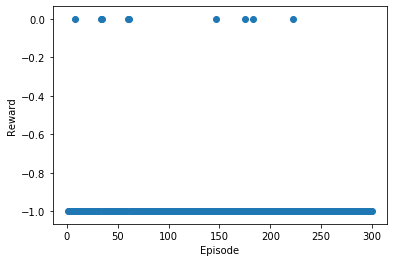

In [19]:
a=rewards_all_episodes
n = 0 
count = 0
n_list=[]
count_list=[]
for i in a :
    for j in i:
        count += j
    count_list.append(sum(i))
    n+=1
    n_list.append(n)
    if n%10 == 0:
        print(n,':',str(count/10)) 
        
ax=plt.scatter(n_list,count_list,marker='o')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [20]:
b=action_all_episodes
step = []
episode=[]
n=1
for i in b:
    step.append(len(i))
    episode.append(n)
    n+=1
print(step)
print(episode)

[9, 3, 2, 10, 4, 2, 3, 38, 4, 2, 8, 10, 4, 2, 2, 4, 7, 5, 7, 5, 4, 4, 4, 8, 3, 2, 2, 3, 7, 4, 6, 4, 7, 36, 58, 7, 6, 4, 4, 6, 4, 5, 6, 3, 6, 7, 5, 7, 7, 2, 12, 4, 6, 2, 3, 2, 5, 2, 4, 51, 42, 3, 9, 2, 2, 11, 2, 4, 7, 10, 4, 2, 8, 5, 3, 3, 7, 5, 5, 11, 5, 8, 6, 2, 7, 15, 9, 2, 4, 9, 11, 2, 6, 5, 5, 3, 2, 8, 3, 9, 4, 8, 3, 9, 7, 5, 6, 3, 3, 4, 6, 6, 11, 13, 2, 3, 4, 2, 7, 7, 3, 5, 6, 7, 9, 3, 5, 5, 4, 3, 4, 10, 10, 4, 3, 5, 5, 9, 5, 4, 6, 8, 7, 4, 3, 10, 56, 16, 4, 4, 5, 6, 5, 7, 6, 4, 4, 2, 4, 3, 2, 8, 6, 9, 4, 12, 6, 3, 7, 3, 5, 3, 6, 15, 60, 5, 7, 4, 2, 2, 4, 10, 58, 3, 5, 4, 10, 2, 4, 5, 7, 5, 4, 2, 9, 8, 4, 2, 9, 9, 6, 4, 2, 9, 13, 9, 7, 4, 3, 9, 7, 5, 14, 5, 7, 6, 3, 11, 5, 9, 12, 57, 11, 5, 2, 4, 8, 13, 9, 9, 4, 11, 5, 19, 3, 2, 5, 10, 3, 4, 2, 9, 2, 2, 3, 6, 3, 4, 4, 2, 11, 9, 4, 2, 14, 3, 4, 8, 3, 6, 4, 4, 5, 6, 9, 3, 9, 2, 4, 5, 3, 7, 2, 6, 4, 3, 4, 3, 7, 8, 5, 14, 3, 5, 15, 5, 3, 11, 2, 4, 6, 15, 16, 5, 9, 9, 6, 11, 16, 4]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16

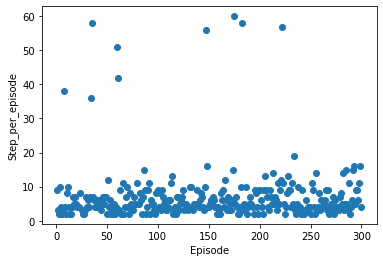

In [21]:
ax=plt.scatter(episode,step,marker='o')
plt.xlabel('Episode')
plt.ylabel('Step_per_episode')
plt.show()

In [67]:
q_table

array([[ 0.349251  ,  0.20832748],
       [ 1.77224689, -0.73807624],
       [ 0.99055676, -0.59842658],
       [ 0.        ,  0.        ],
       [ 0.        , -0.06542415],
       [27.15730793, -0.6529352 ],
       [34.00748832, -0.65424151],
       [ 1.71618289,  0.06933105],
       [49.99300531,  1.96897879],
       [49.37267201,  0.27837086]])

In [15]:
import random
random.uniform(110,150)


133.38019801314636

In [27]:
index_q

[0.1, 0.2, 0.3, 0.4, 0.5]

In [20]:
x

0.1

In [17]:
xxx()